<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/main/Predict_price_after_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from google.colab import files
uploaded = files.upload()

Saving data_price_patterns_double_bot.zip to data_price_patterns_double_bot.zip


## Import packages

In [3]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
import random
import os
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adagrad, Adadelta, RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from scipy import stats

## Get data at pattern for training & testing

In [5]:
#@title Get data
pattern_name = "double_bot" #@param ["double_top", "double_bot"]
import io
import pandas as pd

price_patterns_df = pd.DataFrame()
# for filename in uploaded.keys():
#     print(filename)
#     if 'double_top_data_patterns.csv' not in filename:
#     # if 'data_patterns.csv' not in filename:
#         print('Skipping file', filename)
#         continue
#     try:
#         df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),
#                         header=None)
#         price_patterns_df = price_patterns_df.append(df)
#     except:
#         print('Error', filename)

# filebytes = io.BytesIO(uploaded['data_price_patterns.zip'])
filebytes = io.BytesIO(uploaded['data_price_patterns_{}.zip'.format(pattern_name)])
myzipfile = zipfile.ZipFile(filebytes)
# for filename in os.listdir('.'):
#     if not os.path.isfile(filename):
#         continue
multi_features_data = []
columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
for filename in myzipfile.namelist():
    print(filename)
    if (pattern_name == 'double_top' 
        and 'double_top_data_patterns.csv' not in filename) \
        or (pattern_name == 'double_bottom'
        and 'double_bot_data_patterns.csv' not in filename):
    # if 'data_patterns.csv' not in filename:
        print('Skipping file', filename)
        continue
    # try:
    file = myzipfile.open(filename)
    fileread = file.read()
    # print(io.BytesIO(fileread))
    df = pd.read_csv(io.BytesIO(fileread))
    # print(df.head())
    # multi_features_data.append(df.to_numpy())
    multi_features_data.append(df[columns].to_numpy())
    # Plot the time series
    # df.plot(subplots=True,
    #         layout=(6, 3),
    #         figsize=(22,22),
    #         fontsize=10, 
    #         linewidth=2,
    #         sharex=False,
    #         title='Visualization of the original Time Series')
    # plt.show()
    # price_patterns_df = price_patterns_df.append(df)
    y_data = df['Close']
    prices = np.array(y_data).reshape(-1, 1)
    price_patterns_df = price_patterns_df.append(pd.DataFrame(prices).T)
    # except:
    #     print('Error', filename)

multi_features_data = np.array(multi_features_data)
print(multi_features_data)

price_patterns_df = price_patterns_df.sample(frac=1).reset_index(drop=True)
price_patterns_df

Streaming output truncated to the last 5000 lines.
ADHC_2000-01-01 00:00:00_2021-06-20_30_006_double_bot_data_patterns.csv
ADHC_2000-01-01 00:00:00_2021-06-20_30_007_double_bot_data_patterns.csv
ADHC_2000-01-01 00:00:00_2021-06-20_30_008_double_bot_data_patterns.csv
ADHC_2000-01-01 00:00:00_2021-06-20_30_009_double_bot_data_patterns.csv
ADHC_2000-01-01 00:00:00_2021-06-20_30_010_double_bot_data_patterns.csv
ADHC_2000-01-01 00:00:00_2021-06-20_30_011_double_bot_data_patterns.csv
ADHC_2000-01-01 00:00:00_2021-06-20_30_012_double_bot_data_patterns.csv
ADHC_2000-01-01 00:00:00_2021-06-20_30_013_double_bot_data_patterns.csv
ADHC_2000-01-01 00:00:00_2021-06-20_30_014_double_bot_data_patterns.csv
ADHC_2000-01-01 00:00:00_2021-06-20_30_015_double_bot_data_patterns.csv
ADI_2000-01-01 00:00:00_2021-06-20_30_001_double_bot_data_patterns.csv
ADI_2000-01-01 00:00:00_2021-06-20_30_002_double_bot_data_patterns.csv
ADI_2000-01-01 00:00:00_2021-06-20_30_003_double_bot_data_patterns.csv
ADI_2000-01-01 0

0             1   ...            29            30
0       423.399994    440.450012  ...    523.400024    515.099976
1       152.240005    154.139999  ...    159.000000    159.529999
2        86.250000     86.250000  ...     78.250000     79.750000
3        18.846666     18.736666  ...     18.680000     18.856667
4        26.530001     26.490000  ...     18.580000     20.740000
...            ...           ...  ...           ...           ...
7310     76.480003     75.580002  ...     79.739998     79.919998
7311     20.299999     19.955000  ...     20.110001     20.240000
7312     25.500000     25.400000  ...     24.700001     24.799999
7313  44836.000000  47630.000000  ...  49016.000000  49082.000000
7314    334.125000    334.125000  ...    417.119995    403.260010

[7315 rows x 31 columns]

In [6]:
n_samples, n_steps, n_features = multi_features_data.shape
multi_features_data_df = pd.DataFrame(
    multi_features_data.reshape(n_samples * n_steps, n_features),
    index=pd.MultiIndex.from_product([range(n_samples), range(n_steps)]),
    columns=columns
)
# panel = pd.Panel(multi_features_data)
# panel.to_frame()
multi_features_data_df

High         Low        Open       Close     Volume   Adj Close
0    0    84.931030   80.200127   80.350311   83.504250  1485144.0   62.230995
     1    86.958565   83.729530   83.729530   85.982346  1813317.0   64.077721
     2    87.183846   85.456688   85.982346   86.583092  1283229.0   64.525459
     3    86.658188   84.855942   86.583092   85.456688  1222472.0   63.686016
     4    87.033653   85.156311   85.456688   86.658188  1162464.0   64.581413
...             ...         ...         ...         ...        ...         ...
7314 26  295.200012  285.609985  295.200012  293.049988  3369100.0  293.049988
     27  304.696991  292.709991  295.437012  295.239990  2446200.0  295.239990
     28  293.940002  286.040009  293.010010  288.489990  2507800.0  288.489990
     29  302.000000  273.200012  273.910004  300.250000  4084400.0  300.250000
     30  296.529999  282.404999  291.049988  289.700012  3419800.0  289.700012

[226765 rows x 6 columns]

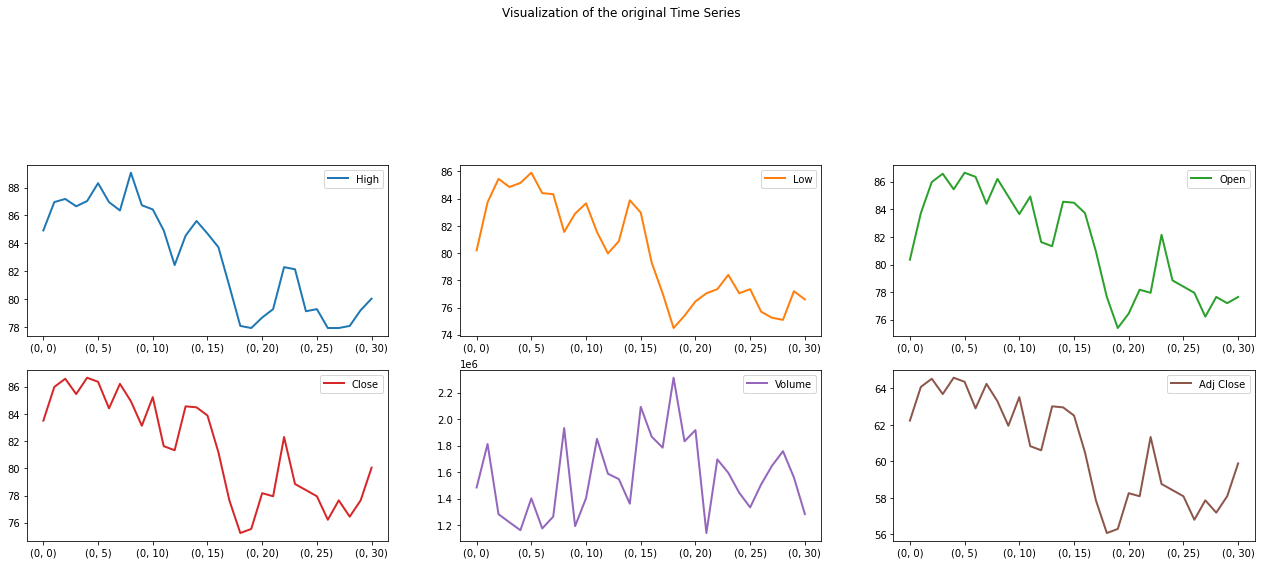

In [7]:
for i in range(min(n_samples, 1)):
    # Plot the time series
    df = multi_features_data_df.loc[pd.IndexSlice[i, range(0, n_steps)], :]
    # df = multi_features_data_df.loc[pd.IndexSlice[i, range(n_steps - (pre_time_steps + 1), n_steps - 1)], :]
    df.plot(subplots=True,
            layout=(6, 3),
            figsize=(22,22),
            fontsize=10, 
            linewidth=2,
            sharex=False,
            title='Visualization of the original Time Series')
    plt.show()

In [8]:
#@title Separate into input and output columns: Get data: X and y
pre_time_steps =  20#@param {type:"integer"}

# X_df = price_patterns_df[price_patterns_df.columns[-(pre_time_steps + 1):-1]]
# y_df = price_patterns_df[price_patterns_df.columns[-1:]]
# X_df = multi_features_data_df.xs(tuple(range(n_steps - (pre_time_steps + 1), n_steps - 1)), level=1, drop_level=False)
# X_df = multi_features_data_df.xs(tuple(i for i in range(29, 30)), level=1, drop_level=False)
# X_df = multi_features_data_df.xs(tuple([28, 29]), level=1, drop_level=False)
X_df = multi_features_data_df.loc[pd.IndexSlice[:, range(n_steps - (pre_time_steps + 1), n_steps - 1)], :]
y_df = multi_features_data_df.xs(n_steps - 1, level=1, drop_level=False)
print(X_df)
print(y_df)

X_data = X_df.values.reshape(n_samples, pre_time_steps, n_features)
# Only predict for 1 step after
y_data = y_df.values.reshape(n_samples, n_features)
print(X_data)
print(y_data)

               High         Low        Open       Close     Volume   Adj Close
0    10   86.432907   83.654434   83.654434   85.231407  1404328.0   63.518101
     11   84.931030   81.551811   84.931030   81.626907  1851685.0   60.831890
     12   82.452934   79.974846   81.626907   81.326530  1588598.0   60.608032
     13   84.555565   80.875969   81.326530   84.555565  1547898.0   63.014442
     14   85.606873   83.879723   84.555565   84.480469  1362797.0   62.958492
...             ...         ...         ...         ...        ...         ...
7314 25  310.980011  294.500000  306.529999  297.589996  2582600.0  297.589996
     26  295.200012  285.609985  295.200012  293.049988  3369100.0  293.049988
     27  304.696991  292.709991  295.437012  295.239990  2446200.0  295.239990
     28  293.940002  286.040009  293.010010  288.489990  2507800.0  288.489990
     29  302.000000  273.200012  273.910004  300.250000  4084400.0  300.250000

[146300 rows x 6 columns]
               High      

## Find patterns func

In [9]:
#@title Find pattern params
#@markdown ### Delta price angle degree from data point to trend line
trend_delta =  15#@param {type:"number"}
#@markdown ### Delta price distance between 2 tops/bottoms
y_delta = 0.15 #@param {type:"number"}
#@markdown ### Min height of pattern
min_height = 0.5 #@param {type:"number"}

In [10]:
#@title Check if data is nearly formed a line

# Get angle of vector ba & vector bc
def get_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    if np.array_equal(a, b) or np.array_equal(a, c) or np.array_equal(b, c):
        return 0

    ba = a - b
    bc = c - b

    if np.all(ba == 0) or np.all(bc == 0):
        return 0

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    # print(a, b, c)
    # print(cosine_angle)
    angle = np.arccos(cosine_angle)

    deg = np.degrees(angle)
    # print('get_angle({}, {}, {}) = {}'.format(a, b, c, deg))
    return deg

def is_trend(x_data, y_data):
    assert len(x_data) == len(y_data)
    if len(x_data) < 2:
        return False
    # print(x_data)
    # print(y_data)
    # Find the line from the first to the last point
    # y = a * x + b
    x1, y1 = x_data[0], y_data[0]
    x2, y2 = x_data[-1], y_data[-1]
    a = (y1 - y2) / (x1 - x2)  # slope
    b = y1 - a * x1  # intercept
    b_is_trend = True
    for i in range(len(x_data)):
        angle1 = get_angle([x_data[0], y_data[0]], [x_data[-1], y_data[-1]], [x_data[i], y_data[i]])
        angle2 = get_angle([x_data[-1], y_data[-1]], [x_data[0], y_data[0]], [x_data[i], y_data[i]])
        if (angle1 > trend_delta) or (angle2 > trend_delta):
            b_is_trend = False
            break
        # y_val = a * x_data[i] + b
        # err = abs(y_val - y_data[i])
        # if (err > trend_delta * y_val):
        #     b_is_trend = False
        #     break
    return b_is_trend
    # p, res, _, _, _ = np.polyfit(x_data, y_data, 1, full=True)
    # err = res[0] if res.size > 0 else 0
    # if err <= len(x_data) * trend_delta:
    #     return True
    # return False

In [11]:
#@title Find double top func

def find_double_top(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max
        # print(key_points)

    suspected_double_tops = list()
    n = len(x_data)
    maxy = np.max(y_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 2):
        for j in range(i + 2, len(key_points)):
            l = key_points[i]
            r = key_points[j]
            # print(l, r, abs(y_data[l] - y_data[r]))
            # if l == 301 and r == 307:
            #     print(y_data[l], y_data[r], max(y_data[key_points[i + 1: j]]))
            if (abs(y_data[l] - y_data[r]) <= y_delta * maxy) \
               and r - l > 1 \
               and min(y_data[l], y_data[r]) >= max(y_data[key_points[i + 1: j]]):
                k_bottom = np.argmin(y_data[l + 1: r]) + l + 1
                # print(l, k_bottom, r)
                if min(y_data[l], y_data[r]) < y_data[k_bottom] + min_height:
                    continue
                (ilows,) = np.where(y_data[:l] <= y_data[k_bottom])
                istart = None
                if ilows.size > 0:
                    istart = ilows[-1]
                (ilows,) = np.where(y_data[r:] <= y_data[k_bottom])
                iend = None
                if ilows.size > 0:
                    iend = ilows[0] + r
                # print(istart, l, k_bottom, r, iend)
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[l: k_bottom + 1], y_data[l: k_bottom + 1]) \
                   and is_trend(x_data[k_bottom: r + 1], y_data[k_bottom: r + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_tops.append((istart, l, k_bottom, r, iend))
    return suspected_double_tops

In [12]:
#@title Find double bottom func

def find_double_bottom(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_bottoms = list()
    n = len(x_data)
    maxy = np.max(y_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 2):
        for j in range(i + 2, len(key_points)):
            l = key_points[i]
            r = key_points[j]
            if (abs(y_data[l] - y_data[r]) <= y_delta * maxy) \
               and r - l > 1 \
               and max(y_data[l], y_data[r]) <= min(y_data[key_points[i + 1: j]]):
                k_top = np.argmax(y_data[l + 1: r]) + l + 1
                if max(y_data[l], y_data[r]) + min_height > y_data[k_top]:
                    continue
                (ihights,) = np.where(y_data[:l] >= y_data[k_top])
                istart = None
                if ihights.size > 0:
                    istart = ihights[-1]
                (ihights,) = np.where(y_data[r:] >= y_data[k_top])
                iend = None
                if ihights.size > 0:
                    iend = ihights[0] + r
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart: l + 1]) \
                   and is_trend(x_data[l: k_top + 1], y_data[l: k_top + 1]) \
                   and is_trend(x_data[k_top: r + 1], y_data[k_top: r + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_bottoms.append((istart, l, k_top, r, iend))
    return suspected_double_bottoms

In [13]:
#@title Visualize result func

def visualize_res(x_data, y_data, suspected_double_tops=[], suspected_double_bottoms=[]):
    # ___ plotting ___
    plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
    # plot stock data
    plt.plot(x_data, y_data, '-', markersize=1.5, color='magenta', alpha=0.7)
    plt.axis('equal')

    for istart, top1, bottom, top2, iend in suspected_double_tops:
        plt.plot(x_data[istart], y_data[istart], "o", color='r')
        plt.plot(x_data[top1], y_data[top1], "o", color='b')
        plt.plot(x_data[bottom], y_data[bottom], "o", color='g')
        plt.plot(x_data[top2], y_data[top2], "o", color='b')
        plt.plot(x_data[iend], y_data[iend], "o", color='r')
        plt.plot(np.array(x_data)[[istart, top1, bottom, top2, iend]], np.array(y_data)[[istart, top1, bottom, top2, iend]], "-", color='g')

    for istart, bot1, top, bot2, iend in suspected_double_bottoms:
        plt.plot(np.array(x_data)[[istart, bot1, top, bot2, iend]], np.array(y_data)[[istart, bot1, top, bot2, iend]], "-", color='b')

    plt.show()

def visualize_pred(X, y_true, y_pred):
    # ___ plotting ___
    plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
    # plot stock data
    n_days_X = len(X)
    n_days_y = len(y_true)
    days = np.array(range(n_days_X + n_days_y))
    # print(days[:n_days_X])
    # print(days[-n_days_y:])
    plt.plot(days[:n_days_X], X, '-', markersize=1.5, color='magenta')
    plt.plot(days[-(n_days_y + 1):], [X[-1], y_true], '-', markersize=1.5, color='red')
    plt.plot(days[-(n_days_y + 1):], [X[-1], y_pred], '-', markersize=1.5, color='blue')
    # plt.axis('equal')

    plt.show()

In [14]:
# i_debug = 1
# for i, row in enumerate(X_data):
#     # if i < i_debug: continue
#     # if i > i_debug: break
#     # x = np.array(range(len(row)))
#     # y = row.to_numpy()
#     # print(x, y)
#     # print(is_trend(x[8:20], y[8:20]))
#     double_tops = find_double_top(range(len(row)), row)
#     double_bots = find_double_bottom(range(len(row)), row)
#     print(i, double_tops, double_bots)
#     visualize_res(range(len(row)), row, double_tops, double_bots)

## Preprocess & split data

In [15]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

def get_binary_direction(pre, cur, min_change=0):
    d = get_direction(pre, cur, min_change)
    if d < 1:
        d = 0
    return d

def y_preice_to_y_label(X, y, feature_pred_idx=0, min_change=0, num_classes=2):
    # print(X.shape, y.shape)
    assert len(X) == len(y)
    # print(feature_pred_idx)
    n = len(y)
    feature_pred_idx_y = min(feature_pred_idx, y.shape[-1] - 1)
    if num_classes <= 2:
        y_label = np.array([get_binary_direction(X[i][-1][feature_pred_idx], y[i][feature_pred_idx_y], min_change) for i in range(n)])
    else:
        y_label = np.array([get_direction(X[i][-1][feature_pred_idx], y[i][feature_pred_idx_y], min_change) for i in range(n)])
        # Convert from {-1; 0; 1} to label {0; 1; 2}
        y_label = y_label + 1
    return y_label

In [16]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
val_ratio = 0.1 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
val_ratio = min(val_ratio, 1 - train_ratio)
test_ratio = 1 - train_ratio - val_ratio
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax", "StandardScaler"]
min_price_change = 0 #@param {type:"number"}
num_classes = 2 #@param {type:"integer"}
feature_pred = "Close" #@param {type:"string"}
train_multi_features = False #@param {type:"boolean"}
feature_pred_idx = columns.index(feature_pred)
# print(feature_pred_idx)

if not train_multi_features:
    X_data, y_data = X_data[:, :, feature_pred_idx], y_data[:, feature_pred_idx]
    X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
    y_data = y_data.reshape(-1, 1)
    # X_train, y_train = X_train[:, :, feature_pred_idx], y_train[:, feature_pred_idx]
    # X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    # y_train = y_train.reshape(-1, 1)
    # X_test, y_test = X_test[:, :, feature_pred_idx], y_test[:, feature_pred_idx]
    # X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    # y_test = y_test.reshape(-1, 1)
    feature_pred_idx = 0

# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=train_ratio, random_state=7)
n_data = len(X_data)
n_train = int(train_ratio * n_data)
X_train, y_train = X_data[: n_train], y_data[: n_train]
if test_ratio > 0:
    n_val = int(val_ratio * n_data)
    n_test = n_data - n_train - n_val
    X_val, y_val = X_data[n_train: n_train + n_val], y_data[n_train: n_train + n_val]
    X_test, y_test = X_data[n_train + n_val:], y_data[n_train + n_val:]
else:
    n_val = n_data - n_train
    # Use val set for testing
    n_test = n_data - n_train
    X_val, y_val = X_data[n_train:], y_data[n_train:]
    X_test, y_test = X_data[n_train:], y_data[n_train:]

y_train = y_train[:, feature_pred_idx]
y_train = y_train.reshape(-1, 1)
y_val = y_val[:, feature_pred_idx]
y_val = y_val.reshape(-1, 1)
y_test = y_test[:, feature_pred_idx]
y_test = y_test.reshape(-1, 1)

print(X_train.shape, y_train.shape)
print('Stats y_train:', stats.describe(y_train))
print(X_val.shape, y_val.shape)
print('Stats y_val:', stats.describe(y_val))
print(X_test.shape, y_test.shape)
print('Stats y_test:', stats.describe(y_test))

if scale_method != 'None':
    if scale_method == 'MinMax':
        sc_train = MinMaxScaler(feature_range = (0, 1))
        sc_val = MinMaxScaler(feature_range = (0, 1))
        sc_test = MinMaxScaler(feature_range = (0, 1))
    else:
        sc_train = StandardScaler()
        sc_val = StandardScaler()
        sc_test = StandardScaler()
    # X_train_scaled = sc_train.fit_transform(X_train.T).T
    # X_test_scaled = sc_test.fit_transform(X_test.T).T
    # y_train_scaled = sc_train.transform(y_train.T).T
    # y_test_scaled = sc_test.transform(y_test.T).T
    X_train_scaled = sc_train.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    y_train_scaled = sc_train.transform(y_train)
    X_val_scaled = sc_val.fit_transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    y_val_scaled = sc_val.transform(y_val)
    X_test_scaled = sc_test.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    y_test_scaled = sc_test.transform(y_test)

    y_train_scaled = y_train_scaled[:, feature_pred_idx]
    y_train_scaled = y_train_scaled.reshape(-1, 1)
    y_val_scaled = y_val_scaled[:, feature_pred_idx]
    y_val_scaled = y_val_scaled.reshape(-1, 1)
    y_test_scaled = y_test_scaled[:, feature_pred_idx]
    y_test_scaled = y_test_scaled.reshape(-1, 1)

    print(X_train_scaled.shape, y_train_scaled.shape)
    print('Stats y_train_scaled:', stats.describe(y_train_scaled))
    print(X_val_scaled.shape, y_val_scaled.shape)
    print('Stats y_val_scaled:', stats.describe(y_val_scaled))
    print(X_test_scaled.shape, y_test_scaled.shape)
    print('Stats y_test_scaled:', stats.describe(y_test_scaled))

    # X_train, y_train = X_train_scaled, y_train_scaled
    # y_train_label, y_train_categorical = y_train_scaled_label, y_train_scaled_categorical
    # X_test, y_test = X_test_scaled, y_test_scaled
    # y_test_label, y_test_categorical = y_test_scaled_label, y_test_scaled_categorical

# print(X_train)
# print(y_train)
# print(y_train_label)
# print(y_train_categorical)

(5852, 20, 1) (5852, 1)
Stats y_train: DescribeResult(nobs=5852, minmax=(array([2.]), array([4612545.])), mean=array([17552.46531769]), variance=array([1.41539802e+10]), skewness=array([19.14428969]), kurtosis=array([522.77158053]))
(731, 20, 1) (731, 1)
Stats y_val: DescribeResult(nobs=731, minmax=(array([3.64428592]), array([2466.09008789])), mean=array([264.41064363]), variance=array([157325.46071886]), skewness=array([2.64105857]), kurtosis=array([7.30493415]))
(732, 20, 1) (732, 1)
Stats y_test: DescribeResult(nobs=732, minmax=(array([5.86999989]), array([1146.42004395])), mean=array([238.00945632]), variance=array([58954.22021442]), skewness=array([1.3526363]), kurtosis=array([1.4131123]))
(5852, 20, 1) (5852, 1)
Stats y_train_scaled: DescribeResult(nobs=5852, minmax=(array([1.74620667e-07]), array([0.80544551])), mean=array([0.00306485]), variance=array([0.00043159]), skewness=array([19.14428969]), kurtosis=array([522.77158053]))
(731, 20, 1) (731, 1)
Stats y_val_scaled: Describ

In [17]:
# i_debug = 1
# for i, row in enumerate(X_test):
#     # if i < i_debug: continue
#     # if i > i_debug: break
#     # x = np.array(range(len(row)))
#     # y = row.to_numpy()
#     # print(x, y)
#     # print(is_trend(x[8:20], y[8:20]))
#     double_tops = find_double_top(range(len(row)), row)
#     double_bots = find_double_bottom(range(len(row)), row)
#     print(i, double_tops, double_bots)
#     visualize_res(range(len(row)), row, double_tops, double_bots)

## LSTM model

### Build model

In [18]:
#@title Build & fit model
lstm_units = 50 #@param {type:"integer"}
dropout_prob = 0.1 #@param {type:"number"}
epochs = 5000 #@param {type:"integer"}
batch_size = 32768 #@param {type:"integer"}
lr = 0.001 #@param {type:"number"}
early_stopping_epochs = 100 #@param {type:"number"}



### Train model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 20, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 2/5000
1/1 [==============================] - 0s 71ms/step - loss: 5.8532e-04 - val_loss: 0.0232


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 3/5000
1/1 [==============================] - 0s 72ms/step - loss: 2.9938e-04 - val_loss: 0.0214


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 4/5000
1/1 [==============================] - 0s 72ms/step - loss: 3.0697e-04 - val_loss: 0.0183


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 5/5000
1/1 [==============================] - 0s 70ms/step - loss: 3.3924e-04 - val_loss: 0.0143


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 6/5000
1/1 [==============================] - 0s 83ms/step - loss: 2.2118e-04 - val_loss: 0.0100


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 7/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.2504e-04 - val_loss: 0.0062


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 8/5000
1/1 [==============================] - 0s 75ms/step - loss: 1.5651e-04 - val_loss: 0.0037


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 9/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.7052e-04 - val_loss: 0.0023


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 10/5000
1/1 [==============================] - 0s 71ms/step - loss: 7.1723e-05 - val_loss: 0.0013


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 11/5000
1/1 [==============================] - 0s 70ms/step - loss: 2.4092e-05 - val_loss: 5.8067e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 12/5000
1/1 [==============================] - 0s 74ms/step - loss: 9.2204e-05 - val_loss: 2.3307e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 13/5000
1/1 [==============================] - 0s 71ms/step - loss: 9.2017e-05 - val_loss: 4.2023e-04
Epoch 14/5000
1/1 [==============================] - 0s 73ms/step - loss: 3.6122e-05 - val_loss: 9.5893e-04
Epoch 15/5000
1/1 [==============================] - 0s 67ms/step - loss: 4.1750e-05 - val_loss: 0.0012
Epoch 16/5000
1/1 [==============================] - 0s 60ms/step - loss: 8.5699e-05 - val_loss: 8.2425e-04
Epoch 17/5000
1/1 [==============================] - 0s 63ms/step - loss: 5.1595e-05 - val_loss: 3.4690e-04
Epoch 18/5000
1/1 [==============================] - 0s 57ms/step - loss: 1.7633e-05 - val_loss: 2.0895e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 19/5000
1/1 [==============================] - 0s 71ms/step - loss: 2.6308e-05 - val_loss: 3.5152e-04
Epoch 20/5000
1/1 [==============================] - 0s 69ms/step - loss: 4.4488e-05 - val_loss: 5.7382e-04
Epoch 21/5000
1/1 [==============================] - 0s 67ms/step - loss: 4.2640e-05 - val_loss: 7.4782e-04
Epoch 22/5000
1/1 [==============================] - 0s 68ms/step - loss: 1.4925e-05 - val_loss: 8.5316e-04
Epoch 23/5000
1/1 [==============================] - 0s 63ms/step - loss: 2.5260e-05 - val_loss: 8.9024e-04
Epoch 24/5000
1/1 [==============================] - 0s 59ms/step - loss: 2.6248e-05 - val_loss: 9.0499e-04
Epoch 25/5000
1/1 [==============================] - 0s 59ms/step - loss: 4.0675e-05 - val_loss: 9.1430e-04
Epoch 26/5000
1/1 [==============================] - 0s 67ms/step - loss: 3.3153e-05 - val_loss: 8.7290e-04
Epoch 27/5000
1/1 [==============================] - 0s 65ms/step - loss: 1.7670e-05 - val_loss: 7.9486e-04
Epoch 28/5000
1/1 [=========

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 32/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.4013e-05 - val_loss: 1.6202e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 33/5000
1/1 [==============================] - 0s 81ms/step - loss: 7.1282e-06 - val_loss: 1.6532e-04
Epoch 34/5000
1/1 [==============================] - 0s 71ms/step - loss: 2.0284e-05 - val_loss: 1.7172e-04
Epoch 35/5000
1/1 [==============================] - 0s 76ms/step - loss: 1.6994e-05 - val_loss: 1.7058e-04
Epoch 36/5000
1/1 [==============================] - 0s 62ms/step - loss: 2.3225e-05 - val_loss: 1.6280e-04
Epoch 37/5000
1/1 [==============================] - 0s 61ms/step - loss: 1.0731e-05 - val_loss: 1.5356e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 38/5000
1/1 [==============================] - 0s 71ms/step - loss: 9.2858e-06 - val_loss: 1.4602e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 39/5000
1/1 [==============================] - 0s 77ms/step - loss: 1.3063e-05 - val_loss: 1.4183e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 40/5000
1/1 [==============================] - 0s 71ms/step - loss: 8.4523e-06 - val_loss: 1.4176e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 41/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.5027e-05 - val_loss: 1.4612e-04
Epoch 42/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.5542e-05 - val_loss: 1.5100e-04
Epoch 43/5000
1/1 [==============================] - 0s 64ms/step - loss: 1.4673e-05 - val_loss: 1.5856e-04
Epoch 44/5000
1/1 [==============================] - 0s 69ms/step - loss: 9.8530e-06 - val_loss: 1.6315e-04
Epoch 45/5000
1/1 [==============================] - 0s 60ms/step - loss: 8.5774e-06 - val_loss: 1.6699e-04
Epoch 46/5000
1/1 [==============================] - 0s 57ms/step - loss: 1.4240e-05 - val_loss: 1.6821e-04
Epoch 47/5000
1/1 [==============================] - 0s 54ms/step - loss: 2.4458e-05 - val_loss: 1.7076e-04
Epoch 48/5000
1/1 [==============================] - 0s 54ms/step - loss: 1.0445e-05 - val_loss: 1.7399e-04
Epoch 49/5000
1/1 [==============================] - 0s 58ms/step - loss: 1.7042e-05 - val_loss: 1.8172e-04
Epoch 50/5000
1/1 [=========

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 61/5000
1/1 [==============================] - 0s 72ms/step - loss: 7.3262e-06 - val_loss: 1.2892e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 62/5000
1/1 [==============================] - 0s 73ms/step - loss: 9.4954e-06 - val_loss: 1.2323e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 63/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.1610e-05 - val_loss: 1.2100e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 64/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.0381e-05 - val_loss: 1.1926e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 65/5000
1/1 [==============================] - 0s 70ms/step - loss: 1.1496e-05 - val_loss: 1.1773e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 66/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.3447e-05 - val_loss: 1.1601e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 67/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.1012e-05 - val_loss: 1.1478e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 68/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.0988e-05 - val_loss: 1.1434e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 69/5000
1/1 [==============================] - 0s 76ms/step - loss: 1.9996e-05 - val_loss: 1.1347e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 70/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.1071e-05 - val_loss: 1.1240e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 71/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.1370e-05 - val_loss: 1.1132e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 72/5000
1/1 [==============================] - 0s 70ms/step - loss: 1.6561e-05 - val_loss: 1.1022e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 73/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.1377e-05 - val_loss: 1.0949e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 74/5000
1/1 [==============================] - 0s 76ms/step - loss: 1.7398e-05 - val_loss: 1.0929e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 75/5000
1/1 [==============================] - 0s 74ms/step - loss: 9.6428e-06 - val_loss: 1.0963e-04
Epoch 76/5000
1/1 [==============================] - 0s 70ms/step - loss: 1.1808e-05 - val_loss: 1.1013e-04
Epoch 77/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.3847e-05 - val_loss: 1.1083e-04
Epoch 78/5000
1/1 [==============================] - 0s 60ms/step - loss: 1.3179e-05 - val_loss: 1.1273e-04
Epoch 79/5000
1/1 [==============================] - 0s 60ms/step - loss: 1.3177e-05 - val_loss: 1.1620e-04
Epoch 80/5000
1/1 [==============================] - 0s 62ms/step - loss: 8.4204e-06 - val_loss: 1.1853e-04
Epoch 81/5000
1/1 [==============================] - 0s 60ms/step - loss: 8.6119e-06 - val_loss: 1.1900e-04
Epoch 82/5000
1/1 [==============================] - 0s 55ms/step - loss: 5.7318e-06 - val_loss: 1.1955e-04
Epoch 83/5000
1/1 [==============================] - 0s 55ms/step - loss: 1.2009e-05 - val_loss: 1.1901e-04
Epoch 84/5000
1/1 [=========

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 93/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.1401e-05 - val_loss: 1.0564e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 94/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.7509e-05 - val_loss: 1.0426e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 95/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.4509e-05 - val_loss: 1.0280e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 96/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.2196e-05 - val_loss: 1.0121e-04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 97/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.0229e-05 - val_loss: 9.9911e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 98/5000
1/1 [==============================] - 0s 82ms/step - loss: 1.0430e-05 - val_loss: 9.9087e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 99/5000
1/1 [==============================] - 0s 73ms/step - loss: 8.8832e-06 - val_loss: 9.8223e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 100/5000
1/1 [==============================] - 0s 71ms/step - loss: 8.8815e-06 - val_loss: 9.7704e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 101/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.1138e-05 - val_loss: 9.7341e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 102/5000
1/1 [==============================] - 0s 74ms/step - loss: 1.5111e-05 - val_loss: 9.7186e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 103/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.1153e-05 - val_loss: 9.7045e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 104/5000
1/1 [==============================] - 0s 75ms/step - loss: 9.8420e-06 - val_loss: 9.6943e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 105/5000
1/1 [==============================] - 0s 71ms/step - loss: 6.7765e-06 - val_loss: 9.6793e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 106/5000
1/1 [==============================] - 0s 72ms/step - loss: 7.8314e-06 - val_loss: 9.6512e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 107/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.5005e-05 - val_loss: 9.6155e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 108/5000
1/1 [==============================] - 0s 72ms/step - loss: 8.8899e-06 - val_loss: 9.5810e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 109/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.3518e-05 - val_loss: 9.5381e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 110/5000
1/1 [==============================] - 0s 72ms/step - loss: 9.6855e-06 - val_loss: 9.5039e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 111/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.4373e-05 - val_loss: 9.4795e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 112/5000
1/1 [==============================] - 0s 74ms/step - loss: 9.4398e-06 - val_loss: 9.4698e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 113/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.0598e-05 - val_loss: 9.4781e-05
Epoch 114/5000
1/1 [==============================] - 0s 69ms/step - loss: 1.0544e-05 - val_loss: 9.5015e-05
Epoch 115/5000
1/1 [==============================] - 0s 64ms/step - loss: 1.2329e-05 - val_loss: 9.5645e-05
Epoch 116/5000
1/1 [==============================] - 0s 66ms/step - loss: 1.1495e-05 - val_loss: 9.6565e-05
Epoch 117/5000
1/1 [==============================] - 0s 64ms/step - loss: 1.1321e-05 - val_loss: 9.7730e-05
Epoch 118/5000
1/1 [==============================] - 0s 57ms/step - loss: 8.0305e-06 - val_loss: 9.9353e-05
Epoch 119/5000
1/1 [==============================] - 0s 59ms/step - loss: 8.5232e-06 - val_loss: 1.0102e-04
Epoch 120/5000
1/1 [==============================] - 0s 60ms/step - loss: 6.7751e-06 - val_loss: 1.0316e-04
Epoch 121/5000
1/1 [==============================] - 0s 60ms/step - loss: 6.5620e-06 - val_loss: 1.0525e-04
Epoch 122/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 144/5000
1/1 [==============================] - 0s 71ms/step - loss: 9.0092e-06 - val_loss: 9.3388e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 145/5000
1/1 [==============================] - 0s 74ms/step - loss: 1.5305e-05 - val_loss: 9.3579e-05
Epoch 146/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.3902e-05 - val_loss: 9.3231e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 147/5000
1/1 [==============================] - 0s 71ms/step - loss: 8.2986e-06 - val_loss: 9.2493e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 148/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.3969e-05 - val_loss: 9.2237e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 149/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.2871e-05 - val_loss: 9.1644e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 150/5000
1/1 [==============================] - 0s 72ms/step - loss: 9.3822e-06 - val_loss: 9.1734e-05
Epoch 151/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.0742e-05 - val_loss: 9.1371e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 152/5000
1/1 [==============================] - 0s 73ms/step - loss: 7.9204e-06 - val_loss: 9.0717e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 153/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.0969e-05 - val_loss: 9.0207e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 154/5000
1/1 [==============================] - 0s 73ms/step - loss: 9.9987e-06 - val_loss: 8.9761e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 155/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.0648e-05 - val_loss: 8.9421e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 156/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.2760e-05 - val_loss: 8.9214e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 157/5000
1/1 [==============================] - 0s 73ms/step - loss: 8.5921e-06 - val_loss: 8.8977e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 158/5000
1/1 [==============================] - 0s 75ms/step - loss: 1.2653e-05 - val_loss: 8.8834e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 159/5000
1/1 [==============================] - 0s 75ms/step - loss: 1.0303e-05 - val_loss: 8.8607e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 160/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.0476e-05 - val_loss: 8.8506e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 161/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.5567e-05 - val_loss: 8.8089e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 162/5000
1/1 [==============================] - 0s 74ms/step - loss: 9.4553e-06 - val_loss: 8.7708e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 163/5000
1/1 [==============================] - 0s 75ms/step - loss: 1.0800e-05 - val_loss: 8.7318e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 164/5000
1/1 [==============================] - 0s 75ms/step - loss: 1.2818e-05 - val_loss: 8.7021e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 165/5000
1/1 [==============================] - 0s 72ms/step - loss: 6.6827e-06 - val_loss: 8.6929e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 166/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.1079e-05 - val_loss: 8.7534e-05
Epoch 167/5000
1/1 [==============================] - 0s 71ms/step - loss: 7.7174e-06 - val_loss: 8.7815e-05
Epoch 168/5000
1/1 [==============================] - 0s 82ms/step - loss: 1.3064e-05 - val_loss: 8.7975e-05
Epoch 169/5000
1/1 [==============================] - 0s 63ms/step - loss: 5.7033e-06 - val_loss: 8.7896e-05
Epoch 170/5000
1/1 [==============================] - 0s 64ms/step - loss: 2.4778e-05 - val_loss: 8.7668e-05
Epoch 171/5000
1/1 [==============================] - 0s 63ms/step - loss: 8.8878e-06 - val_loss: 8.7861e-05
Epoch 172/5000
1/1 [==============================] - 0s 57ms/step - loss: 1.1009e-05 - val_loss: 8.7948e-05
Epoch 173/5000
1/1 [==============================] - 0s 63ms/step - loss: 1.2315e-05 - val_loss: 8.8225e-05
Epoch 174/5000
1/1 [==============================] - 0s 57ms/step - loss: 1.1034e-05 - val_loss: 8.8703e-05
Epoch 175/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 192/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.5130e-05 - val_loss: 8.3792e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 193/5000
1/1 [==============================] - 0s 75ms/step - loss: 1.6193e-05 - val_loss: 8.1923e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 194/5000
1/1 [==============================] - 0s 75ms/step - loss: 7.1719e-06 - val_loss: 8.0814e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 195/5000
1/1 [==============================] - 0s 78ms/step - loss: 8.4317e-06 - val_loss: 8.0210e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 196/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.2009e-05 - val_loss: 7.9689e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 197/5000
1/1 [==============================] - 0s 72ms/step - loss: 8.7978e-06 - val_loss: 7.9420e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 198/5000
1/1 [==============================] - 0s 79ms/step - loss: 1.3429e-05 - val_loss: 7.9154e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 199/5000
1/1 [==============================] - 0s 75ms/step - loss: 1.0720e-05 - val_loss: 7.8943e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 200/5000
1/1 [==============================] - 0s 79ms/step - loss: 9.7736e-06 - val_loss: 7.8748e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 201/5000
1/1 [==============================] - 0s 75ms/step - loss: 9.3514e-06 - val_loss: 7.8590e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 202/5000
1/1 [==============================] - 0s 74ms/step - loss: 1.0580e-05 - val_loss: 7.8451e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 203/5000
1/1 [==============================] - 0s 78ms/step - loss: 7.1639e-06 - val_loss: 7.8426e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 204/5000
1/1 [==============================] - 0s 74ms/step - loss: 8.3072e-06 - val_loss: 7.8553e-05
Epoch 205/5000
1/1 [==============================] - 0s 80ms/step - loss: 1.1484e-05 - val_loss: 7.8759e-05
Epoch 206/5000
1/1 [==============================] - 0s 74ms/step - loss: 1.0635e-05 - val_loss: 7.9463e-05
Epoch 207/5000
1/1 [==============================] - 0s 68ms/step - loss: 9.9854e-06 - val_loss: 8.0440e-05
Epoch 208/5000
1/1 [==============================] - 0s 65ms/step - loss: 4.8891e-06 - val_loss: 8.1091e-05
Epoch 209/5000
1/1 [==============================] - 0s 69ms/step - loss: 8.1934e-06 - val_loss: 8.1925e-05
Epoch 210/5000
1/1 [==============================] - 0s 59ms/step - loss: 1.3303e-05 - val_loss: 8.2502e-05
Epoch 211/5000
1/1 [==============================] - 0s 63ms/step - loss: 1.7921e-05 - val_loss: 8.2321e-05
Epoch 212/5000
1/1 [==============================] - 0s 61ms/step - loss: 9.7482e-06 - val_loss: 8.1796e-05
Epoch 213/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 215/5000
1/1 [==============================] - 0s 75ms/step - loss: 7.7108e-06 - val_loss: 7.6774e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 216/5000
1/1 [==============================] - 0s 84ms/step - loss: 1.0403e-05 - val_loss: 7.6376e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 217/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.4291e-05 - val_loss: 7.6504e-05
Epoch 218/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.1219e-05 - val_loss: 7.6981e-05
Epoch 219/5000
1/1 [==============================] - 0s 66ms/step - loss: 8.9408e-06 - val_loss: 7.7170e-05
Epoch 220/5000
1/1 [==============================] - 0s 63ms/step - loss: 1.3238e-05 - val_loss: 7.7309e-05
Epoch 221/5000
1/1 [==============================] - 0s 65ms/step - loss: 1.0595e-05 - val_loss: 7.7177e-05
Epoch 222/5000
1/1 [==============================] - 0s 60ms/step - loss: 5.7780e-06 - val_loss: 7.7547e-05
Epoch 223/5000
1/1 [==============================] - 0s 69ms/step - loss: 9.4869e-06 - val_loss: 7.7712e-05
Epoch 224/5000
1/1 [==============================] - 0s 61ms/step - loss: 1.2258e-05 - val_loss: 7.7063e-05
Epoch 225/5000
1/1 [==============================] - 0s 59ms/step - loss: 6.7768e-06 - val_loss: 7.6497e-05
Epoch 226/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 227/5000
1/1 [==============================] - 0s 73ms/step - loss: 9.8567e-06 - val_loss: 7.5326e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 228/5000
1/1 [==============================] - 0s 78ms/step - loss: 7.7036e-06 - val_loss: 7.4604e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 229/5000
1/1 [==============================] - 0s 76ms/step - loss: 8.7431e-06 - val_loss: 7.4118e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 230/5000
1/1 [==============================] - 0s 79ms/step - loss: 6.4374e-06 - val_loss: 7.3944e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 231/5000
1/1 [==============================] - 0s 73ms/step - loss: 8.2575e-06 - val_loss: 7.4180e-05
Epoch 232/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.4320e-05 - val_loss: 7.4810e-05
Epoch 233/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.0082e-05 - val_loss: 7.6021e-05
Epoch 234/5000
1/1 [==============================] - 0s 67ms/step - loss: 7.7725e-06 - val_loss: 7.6760e-05
Epoch 235/5000
1/1 [==============================] - 0s 71ms/step - loss: 9.1130e-06 - val_loss: 7.6619e-05
Epoch 236/5000
1/1 [==============================] - 0s 63ms/step - loss: 8.5892e-06 - val_loss: 7.6615e-05
Epoch 237/5000
1/1 [==============================] - 0s 61ms/step - loss: 7.0773e-06 - val_loss: 7.7281e-05
Epoch 238/5000
1/1 [==============================] - 0s 57ms/step - loss: 6.7245e-06 - val_loss: 7.8031e-05
Epoch 239/5000
1/1 [==============================] - 0s 59ms/step - loss: 1.6323e-05 - val_loss: 7.8372e-05
Epoch 240/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 252/5000
1/1 [==============================] - 0s 74ms/step - loss: 8.3425e-06 - val_loss: 7.3371e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 253/5000
1/1 [==============================] - 0s 71ms/step - loss: 8.5431e-06 - val_loss: 7.3501e-05
Epoch 254/5000
1/1 [==============================] - 0s 73ms/step - loss: 8.9682e-06 - val_loss: 7.2997e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 255/5000
1/1 [==============================] - 0s 75ms/step - loss: 6.7097e-06 - val_loss: 7.2174e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 256/5000
1/1 [==============================] - 0s 73ms/step - loss: 8.6165e-06 - val_loss: 7.1441e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 257/5000
1/1 [==============================] - 0s 73ms/step - loss: 9.1647e-06 - val_loss: 7.0747e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 258/5000
1/1 [==============================] - 0s 75ms/step - loss: 6.6831e-06 - val_loss: 7.0221e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 259/5000
1/1 [==============================] - 0s 72ms/step - loss: 7.6457e-06 - val_loss: 6.9972e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 260/5000
1/1 [==============================] - 0s 72ms/step - loss: 8.7410e-06 - val_loss: 6.9836e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 261/5000
1/1 [==============================] - 0s 74ms/step - loss: 1.4637e-05 - val_loss: 6.9681e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 262/5000
1/1 [==============================] - 0s 79ms/step - loss: 1.3510e-05 - val_loss: 6.9445e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 263/5000
1/1 [==============================] - 0s 77ms/step - loss: 1.1408e-05 - val_loss: 6.9293e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 264/5000
1/1 [==============================] - 0s 78ms/step - loss: 1.2318e-05 - val_loss: 6.9112e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 265/5000
1/1 [==============================] - 0s 73ms/step - loss: 7.9206e-06 - val_loss: 6.8906e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 266/5000
1/1 [==============================] - 0s 75ms/step - loss: 1.1651e-05 - val_loss: 6.8723e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 267/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.9026e-06 - val_loss: 6.8663e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 268/5000
1/1 [==============================] - 0s 73ms/step - loss: 8.3992e-06 - val_loss: 6.8823e-05
Epoch 269/5000
1/1 [==============================] - 0s 80ms/step - loss: 1.0172e-05 - val_loss: 6.8725e-05
Epoch 270/5000
1/1 [==============================] - 0s 76ms/step - loss: 9.0319e-06 - val_loss: 6.8628e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 271/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.1761e-05 - val_loss: 6.8710e-05
Epoch 272/5000
1/1 [==============================] - 0s 71ms/step - loss: 6.8033e-06 - val_loss: 6.8535e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 273/5000
1/1 [==============================] - 0s 74ms/step - loss: 1.1005e-05 - val_loss: 6.8516e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 274/5000
1/1 [==============================] - 0s 74ms/step - loss: 7.1515e-06 - val_loss: 6.8291e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 275/5000
1/1 [==============================] - 0s 75ms/step - loss: 6.6689e-06 - val_loss: 6.7948e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 276/5000
1/1 [==============================] - 0s 74ms/step - loss: 1.1240e-05 - val_loss: 6.7573e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 277/5000
1/1 [==============================] - 0s 73ms/step - loss: 9.5109e-06 - val_loss: 6.7032e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 278/5000
1/1 [==============================] - 0s 74ms/step - loss: 7.4170e-06 - val_loss: 6.6757e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 279/5000
1/1 [==============================] - 0s 75ms/step - loss: 5.3146e-06 - val_loss: 6.6498e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 280/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.6014e-05 - val_loss: 6.6295e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 281/5000
1/1 [==============================] - 0s 76ms/step - loss: 8.0100e-06 - val_loss: 6.6063e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 282/5000
1/1 [==============================] - 0s 76ms/step - loss: 7.7085e-06 - val_loss: 6.5934e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 283/5000
1/1 [==============================] - 0s 78ms/step - loss: 1.1572e-05 - val_loss: 6.5747e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 284/5000
1/1 [==============================] - 0s 73ms/step - loss: 7.8210e-06 - val_loss: 6.5700e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 285/5000
1/1 [==============================] - 0s 80ms/step - loss: 7.4878e-06 - val_loss: 6.5950e-05
Epoch 286/5000
1/1 [==============================] - 0s 81ms/step - loss: 5.5174e-06 - val_loss: 6.6431e-05
Epoch 287/5000
1/1 [==============================] - 0s 72ms/step - loss: 9.9888e-06 - val_loss: 6.6613e-05
Epoch 288/5000
1/1 [==============================] - 0s 64ms/step - loss: 1.2772e-05 - val_loss: 6.6702e-05
Epoch 289/5000
1/1 [==============================] - 0s 70ms/step - loss: 7.0953e-06 - val_loss: 6.7094e-05
Epoch 290/5000
1/1 [==============================] - 0s 69ms/step - loss: 8.1365e-06 - val_loss: 6.7107e-05
Epoch 291/5000
1/1 [==============================] - 0s 58ms/step - loss: 1.2311e-05 - val_loss: 6.6155e-05
Epoch 292/5000
1/1 [==============================] - 0s 63ms/step - loss: 8.4545e-06 - val_loss: 6.5500e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 293/5000
1/1 [==============================] - 0s 76ms/step - loss: 8.4374e-06 - val_loss: 6.5487e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 294/5000
1/1 [==============================] - 0s 73ms/step - loss: 7.1674e-06 - val_loss: 6.5324e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 295/5000
1/1 [==============================] - 0s 77ms/step - loss: 7.2432e-06 - val_loss: 6.4941e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 296/5000
1/1 [==============================] - 0s 73ms/step - loss: 7.5371e-06 - val_loss: 6.4200e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 297/5000
1/1 [==============================] - 0s 73ms/step - loss: 9.9904e-06 - val_loss: 6.3679e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 298/5000
1/1 [==============================] - 0s 77ms/step - loss: 5.5246e-06 - val_loss: 6.4427e-05
Epoch 299/5000
1/1 [==============================] - 0s 73ms/step - loss: 9.0232e-06 - val_loss: 6.5975e-05
Epoch 300/5000
1/1 [==============================] - 0s 71ms/step - loss: 9.5039e-06 - val_loss: 6.8525e-05
Epoch 301/5000
1/1 [==============================] - 0s 74ms/step - loss: 1.0067e-05 - val_loss: 7.0746e-05
Epoch 302/5000
1/1 [==============================] - 0s 75ms/step - loss: 1.4710e-05 - val_loss: 7.1329e-05
Epoch 303/5000
1/1 [==============================] - 0s 63ms/step - loss: 6.5826e-06 - val_loss: 7.2118e-05
Epoch 304/5000
1/1 [==============================] - 0s 66ms/step - loss: 8.5159e-06 - val_loss: 7.3382e-05
Epoch 305/5000
1/1 [==============================] - 0s 63ms/step - loss: 1.5169e-05 - val_loss: 7.2935e-05
Epoch 306/5000
1/1 [==============================] - 0s 61ms/step - loss: 9.1355e-06 - val_loss: 7.2284e-05
Epoch 307/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 311/5000
1/1 [==============================] - 0s 75ms/step - loss: 7.6786e-06 - val_loss: 6.2422e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 312/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.5262e-06 - val_loss: 6.1960e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 313/5000
1/1 [==============================] - 0s 75ms/step - loss: 9.4209e-06 - val_loss: 6.1814e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 314/5000
1/1 [==============================] - 0s 73ms/step - loss: 9.3460e-06 - val_loss: 6.1926e-05
Epoch 315/5000
1/1 [==============================] - 0s 73ms/step - loss: 7.8491e-06 - val_loss: 6.2681e-05
Epoch 316/5000
1/1 [==============================] - 0s 68ms/step - loss: 7.6446e-06 - val_loss: 6.3731e-05
Epoch 317/5000
1/1 [==============================] - 0s 65ms/step - loss: 8.8707e-06 - val_loss: 6.4178e-05
Epoch 318/5000
1/1 [==============================] - 0s 60ms/step - loss: 8.2203e-06 - val_loss: 6.4217e-05
Epoch 319/5000
1/1 [==============================] - 0s 70ms/step - loss: 8.7226e-06 - val_loss: 6.4328e-05
Epoch 320/5000
1/1 [==============================] - 0s 59ms/step - loss: 7.5640e-06 - val_loss: 6.4532e-05
Epoch 321/5000
1/1 [==============================] - 0s 56ms/step - loss: 1.2276e-05 - val_loss: 6.4589e-05
Epoch 322/5000
1/1 [==============================] - 0s 55ms/step - loss: 9.4024e-06 - val_loss: 6.4672e-05
Epoch 323/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 330/5000
1/1 [==============================] - 0s 75ms/step - loss: 7.9091e-06 - val_loss: 6.1371e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 331/5000
1/1 [==============================] - 0s 73ms/step - loss: 8.6311e-06 - val_loss: 6.1200e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 332/5000
1/1 [==============================] - 0s 75ms/step - loss: 8.4056e-06 - val_loss: 6.0313e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 333/5000
1/1 [==============================] - 0s 74ms/step - loss: 7.2168e-06 - val_loss: 5.9581e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 334/5000
1/1 [==============================] - 0s 73ms/step - loss: 6.6669e-06 - val_loss: 5.9276e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 335/5000
1/1 [==============================] - 0s 72ms/step - loss: 6.0547e-06 - val_loss: 5.9211e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 336/5000
1/1 [==============================] - 0s 73ms/step - loss: 8.9362e-06 - val_loss: 5.9315e-05
Epoch 337/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.1643e-05 - val_loss: 5.9641e-05
Epoch 338/5000
1/1 [==============================] - 0s 77ms/step - loss: 6.8653e-06 - val_loss: 6.0250e-05
Epoch 339/5000
1/1 [==============================] - 0s 73ms/step - loss: 7.9240e-06 - val_loss: 6.0419e-05
Epoch 340/5000
1/1 [==============================] - 0s 69ms/step - loss: 7.1473e-06 - val_loss: 6.0137e-05
Epoch 341/5000
1/1 [==============================] - 0s 68ms/step - loss: 8.7971e-06 - val_loss: 5.9184e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 342/5000
1/1 [==============================] - 0s 72ms/step - loss: 8.8157e-06 - val_loss: 5.8884e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 343/5000
1/1 [==============================] - 0s 72ms/step - loss: 7.1170e-06 - val_loss: 5.8726e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 344/5000
1/1 [==============================] - 0s 74ms/step - loss: 8.6163e-06 - val_loss: 5.8993e-05
Epoch 345/5000
1/1 [==============================] - 0s 77ms/step - loss: 6.0687e-06 - val_loss: 5.9349e-05
Epoch 346/5000
1/1 [==============================] - 0s 92ms/step - loss: 1.5422e-05 - val_loss: 5.9675e-05
Epoch 347/5000
1/1 [==============================] - 0s 66ms/step - loss: 6.8774e-06 - val_loss: 5.9567e-05
Epoch 348/5000
1/1 [==============================] - 0s 61ms/step - loss: 7.5956e-06 - val_loss: 5.9366e-05
Epoch 349/5000
1/1 [==============================] - 0s 59ms/step - loss: 8.9106e-06 - val_loss: 5.9267e-05
Epoch 350/5000
1/1 [==============================] - 0s 65ms/step - loss: 8.6961e-06 - val_loss: 5.9092e-05
Epoch 351/5000
1/1 [==============================] - 0s 60ms/step - loss: 5.2623e-06 - val_loss: 5.8635e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 352/5000
1/1 [==============================] - 0s 74ms/step - loss: 7.1228e-06 - val_loss: 5.8146e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 353/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.8881e-06 - val_loss: 5.8148e-05
Epoch 354/5000
1/1 [==============================] - 0s 75ms/step - loss: 1.6047e-05 - val_loss: 5.8127e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 355/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.7511e-06 - val_loss: 5.7810e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 356/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.0166e-06 - val_loss: 5.7570e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 357/5000
1/1 [==============================] - 0s 73ms/step - loss: 7.4707e-06 - val_loss: 5.7456e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 358/5000
1/1 [==============================] - 0s 75ms/step - loss: 6.4921e-06 - val_loss: 5.7054e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 359/5000
1/1 [==============================] - 0s 81ms/step - loss: 9.7122e-06 - val_loss: 5.6732e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 360/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.3024e-06 - val_loss: 5.6723e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 361/5000
1/1 [==============================] - 0s 74ms/step - loss: 7.2541e-06 - val_loss: 5.6835e-05
Epoch 362/5000
1/1 [==============================] - 0s 73ms/step - loss: 1.0742e-05 - val_loss: 5.7073e-05
Epoch 363/5000
1/1 [==============================] - 0s 74ms/step - loss: 8.4115e-06 - val_loss: 5.7317e-05
Epoch 364/5000
1/1 [==============================] - 0s 68ms/step - loss: 1.1043e-05 - val_loss: 5.7227e-05
Epoch 365/5000
1/1 [==============================] - 0s 66ms/step - loss: 6.4426e-06 - val_loss: 5.7215e-05
Epoch 366/5000
1/1 [==============================] - 0s 62ms/step - loss: 4.8458e-06 - val_loss: 5.7250e-05
Epoch 367/5000
1/1 [==============================] - 0s 73ms/step - loss: 9.1537e-06 - val_loss: 5.7495e-05
Epoch 368/5000
1/1 [==============================] - 0s 62ms/step - loss: 6.5402e-06 - val_loss: 5.7198e-05
Epoch 369/5000
1/1 [==============================] - 0s 60ms/step - loss: 7.5910e-06 - val_loss: 5.6785e-05
Epoch 370/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 371/5000
1/1 [==============================] - 0s 74ms/step - loss: 8.1228e-06 - val_loss: 5.6582e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 372/5000
1/1 [==============================] - 0s 72ms/step - loss: 9.2629e-06 - val_loss: 5.6890e-05
Epoch 373/5000
1/1 [==============================] - 0s 72ms/step - loss: 8.5666e-06 - val_loss: 5.6780e-05
Epoch 374/5000
1/1 [==============================] - 0s 78ms/step - loss: 1.1483e-05 - val_loss: 5.6520e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 375/5000
1/1 [==============================] - 0s 74ms/step - loss: 8.6541e-06 - val_loss: 5.6420e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 376/5000
1/1 [==============================] - 0s 74ms/step - loss: 8.6398e-06 - val_loss: 5.6108e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 377/5000
1/1 [==============================] - 0s 72ms/step - loss: 8.1543e-06 - val_loss: 5.5654e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 378/5000
1/1 [==============================] - 0s 75ms/step - loss: 6.7708e-06 - val_loss: 5.5334e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 379/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.5076e-06 - val_loss: 5.5124e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 380/5000
1/1 [==============================] - 0s 78ms/step - loss: 8.5324e-06 - val_loss: 5.4999e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 381/5000
1/1 [==============================] - 0s 74ms/step - loss: 7.9258e-06 - val_loss: 5.5017e-05
Epoch 382/5000
1/1 [==============================] - 0s 73ms/step - loss: 5.0273e-06 - val_loss: 5.5226e-05
Epoch 383/5000
1/1 [==============================] - 0s 74ms/step - loss: 7.2568e-06 - val_loss: 5.5671e-05
Epoch 384/5000
1/1 [==============================] - 0s 70ms/step - loss: 6.7463e-06 - val_loss: 5.6102e-05
Epoch 385/5000
1/1 [==============================] - 0s 65ms/step - loss: 1.2625e-05 - val_loss: 5.6569e-05
Epoch 386/5000
1/1 [==============================] - 0s 63ms/step - loss: 6.8155e-06 - val_loss: 5.8231e-05
Epoch 387/5000
1/1 [==============================] - 0s 61ms/step - loss: 9.9333e-06 - val_loss: 5.8857e-05
Epoch 388/5000
1/1 [==============================] - 0s 68ms/step - loss: 6.5299e-06 - val_loss: 5.8302e-05
Epoch 389/5000
1/1 [==============================] - 0s 63ms/step - loss: 5.8148e-06 - val_loss: 5.8106e-05
Epoch 390/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 392/5000
1/1 [==============================] - 0s 77ms/step - loss: 9.0431e-06 - val_loss: 5.4275e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 393/5000
1/1 [==============================] - 0s 76ms/step - loss: 8.9748e-06 - val_loss: 5.4307e-05
Epoch 394/5000
1/1 [==============================] - 0s 79ms/step - loss: 8.7573e-06 - val_loss: 5.4314e-05
Epoch 395/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.5939e-06 - val_loss: 5.4413e-05
Epoch 396/5000
1/1 [==============================] - 0s 68ms/step - loss: 7.2550e-06 - val_loss: 5.4297e-05
Epoch 397/5000
1/1 [==============================] - 0s 66ms/step - loss: 9.7243e-06 - val_loss: 5.4271e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 398/5000
1/1 [==============================] - 0s 72ms/step - loss: 9.7396e-06 - val_loss: 5.4311e-05
Epoch 399/5000
1/1 [==============================] - 0s 72ms/step - loss: 5.6586e-06 - val_loss: 5.4445e-05
Epoch 400/5000
1/1 [==============================] - 0s 68ms/step - loss: 5.9371e-06 - val_loss: 5.5109e-05
Epoch 401/5000
1/1 [==============================] - 0s 64ms/step - loss: 1.0253e-05 - val_loss: 5.5986e-05
Epoch 402/5000
1/1 [==============================] - 0s 67ms/step - loss: 1.0621e-05 - val_loss: 5.7107e-05
Epoch 403/5000
1/1 [==============================] - 0s 63ms/step - loss: 6.9219e-06 - val_loss: 5.7774e-05
Epoch 404/5000
1/1 [==============================] - 0s 58ms/step - loss: 7.1968e-06 - val_loss: 5.8947e-05
Epoch 405/5000
1/1 [==============================] - 0s 64ms/step - loss: 4.5524e-06 - val_loss: 6.0626e-05
Epoch 406/5000
1/1 [==============================] - 0s 65ms/step - loss: 8.2368e-06 - val_loss: 6.0353e-05
Epoch 407/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 418/5000
1/1 [==============================] - 0s 73ms/step - loss: 7.6356e-06 - val_loss: 5.2803e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 419/5000
1/1 [==============================] - 0s 77ms/step - loss: 7.0851e-06 - val_loss: 5.2287e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 420/5000
1/1 [==============================] - 0s 73ms/step - loss: 8.8020e-06 - val_loss: 5.2026e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 421/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.9993e-06 - val_loss: 5.2324e-05
Epoch 422/5000
1/1 [==============================] - 0s 75ms/step - loss: 1.2354e-05 - val_loss: 5.2869e-05
Epoch 423/5000
1/1 [==============================] - 0s 75ms/step - loss: 9.4271e-06 - val_loss: 5.4380e-05
Epoch 424/5000
1/1 [==============================] - 0s 69ms/step - loss: 5.0433e-06 - val_loss: 5.7028e-05
Epoch 425/5000
1/1 [==============================] - 0s 68ms/step - loss: 7.2131e-06 - val_loss: 5.9139e-05
Epoch 426/5000
1/1 [==============================] - 0s 62ms/step - loss: 1.1093e-05 - val_loss: 5.9947e-05
Epoch 427/5000
1/1 [==============================] - 0s 59ms/step - loss: 4.6888e-06 - val_loss: 5.9996e-05
Epoch 428/5000
1/1 [==============================] - 0s 61ms/step - loss: 5.3611e-06 - val_loss: 6.1113e-05
Epoch 429/5000
1/1 [==============================] - 0s 63ms/step - loss: 7.6817e-06 - val_loss: 5.9957e-05
Epoch 430/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 434/5000
1/1 [==============================] - 0s 73ms/step - loss: 6.4261e-06 - val_loss: 5.1569e-05
Epoch 435/5000
1/1 [==============================] - 0s 77ms/step - loss: 5.3110e-06 - val_loss: 5.2384e-05
Epoch 436/5000
1/1 [==============================] - 0s 74ms/step - loss: 7.6951e-06 - val_loss: 5.4483e-05
Epoch 437/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.0506e-05 - val_loss: 6.0530e-05
Epoch 438/5000
1/1 [==============================] - 0s 60ms/step - loss: 7.0210e-06 - val_loss: 6.6939e-05
Epoch 439/5000
1/1 [==============================] - 0s 62ms/step - loss: 9.3727e-06 - val_loss: 7.1518e-05
Epoch 440/5000
1/1 [==============================] - 0s 63ms/step - loss: 6.5325e-06 - val_loss: 7.3518e-05
Epoch 441/5000
1/1 [==============================] - 0s 61ms/step - loss: 5.5138e-06 - val_loss: 7.7306e-05
Epoch 442/5000
1/1 [==============================] - 0s 59ms/step - loss: 6.4139e-06 - val_loss: 7.9751e-05
Epoch 443/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 452/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.7114e-06 - val_loss: 5.0990e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 453/5000
1/1 [==============================] - 0s 76ms/step - loss: 9.5786e-06 - val_loss: 5.2159e-05
Epoch 454/5000
1/1 [==============================] - 0s 76ms/step - loss: 5.7003e-06 - val_loss: 5.3597e-05
Epoch 455/5000
1/1 [==============================] - 0s 72ms/step - loss: 6.0897e-06 - val_loss: 5.4191e-05
Epoch 456/5000
1/1 [==============================] - 0s 72ms/step - loss: 1.1371e-05 - val_loss: 5.3013e-05
Epoch 457/5000
1/1 [==============================] - 0s 65ms/step - loss: 6.0207e-06 - val_loss: 5.2357e-05
Epoch 458/5000
1/1 [==============================] - 0s 64ms/step - loss: 8.5164e-06 - val_loss: 5.1752e-05
Epoch 459/5000
1/1 [==============================] - 0s 73ms/step - loss: 6.2491e-06 - val_loss: 5.0969e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 460/5000
1/1 [==============================] - 0s 76ms/step - loss: 5.4757e-06 - val_loss: 5.0524e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 461/5000
1/1 [==============================] - 0s 77ms/step - loss: 9.2883e-06 - val_loss: 5.0369e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 462/5000
1/1 [==============================] - 0s 74ms/step - loss: 7.2860e-06 - val_loss: 5.1090e-05
Epoch 463/5000
1/1 [==============================] - 0s 73ms/step - loss: 6.6524e-06 - val_loss: 5.3218e-05
Epoch 464/5000
1/1 [==============================] - 0s 80ms/step - loss: 6.3041e-06 - val_loss: 5.5964e-05
Epoch 465/5000
1/1 [==============================] - 0s 71ms/step - loss: 1.1980e-05 - val_loss: 5.9405e-05
Epoch 466/5000
1/1 [==============================] - 0s 64ms/step - loss: 5.6205e-06 - val_loss: 6.4899e-05
Epoch 467/5000
1/1 [==============================] - 0s 64ms/step - loss: 6.2240e-06 - val_loss: 6.8931e-05
Epoch 468/5000
1/1 [==============================] - 0s 72ms/step - loss: 8.1895e-06 - val_loss: 7.1014e-05
Epoch 469/5000
1/1 [==============================] - 0s 67ms/step - loss: 8.2827e-06 - val_loss: 7.1978e-05
Epoch 470/5000
1/1 [==============================] - 0s 68ms/step - loss: 6.0456e-06 - val_loss: 7.0300e-05
Epoch 471/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 479/5000
1/1 [==============================] - 0s 75ms/step - loss: 6.8478e-06 - val_loss: 4.9346e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 480/5000
1/1 [==============================] - 0s 74ms/step - loss: 7.9168e-06 - val_loss: 4.9651e-05
Epoch 481/5000
1/1 [==============================] - 0s 72ms/step - loss: 7.7586e-06 - val_loss: 5.0184e-05
Epoch 482/5000
1/1 [==============================] - 0s 69ms/step - loss: 8.4995e-06 - val_loss: 5.0910e-05
Epoch 483/5000
1/1 [==============================] - 0s 72ms/step - loss: 4.7536e-06 - val_loss: 5.1378e-05
Epoch 484/5000
1/1 [==============================] - 0s 64ms/step - loss: 6.6625e-06 - val_loss: 5.0684e-05
Epoch 485/5000
1/1 [==============================] - 0s 63ms/step - loss: 6.1874e-06 - val_loss: 5.0414e-05
Epoch 486/5000
1/1 [==============================] - 0s 65ms/step - loss: 5.7809e-06 - val_loss: 4.9898e-05
Epoch 487/5000
1/1 [==============================] - 0s 64ms/step - loss: 4.5020e-06 - val_loss: 4.9365e-05
Epoch 488/5000
1/1 [==============================] - 0s 72ms/step - loss: 8.4767e-06 - val_loss: 4.8997e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 489/5000
1/1 [==============================] - 0s 72ms/step - loss: 5.7490e-06 - val_loss: 4.9017e-05
Epoch 490/5000
1/1 [==============================] - 0s 71ms/step - loss: 9.6059e-06 - val_loss: 4.9494e-05
Epoch 491/5000
1/1 [==============================] - 0s 74ms/step - loss: 5.2948e-06 - val_loss: 5.0067e-05
Epoch 492/5000
1/1 [==============================] - 0s 66ms/step - loss: 7.9219e-06 - val_loss: 5.0405e-05
Epoch 493/5000
1/1 [==============================] - 0s 61ms/step - loss: 5.0943e-06 - val_loss: 5.0195e-05
Epoch 494/5000
1/1 [==============================] - 0s 63ms/step - loss: 6.3625e-06 - val_loss: 5.0193e-05
Epoch 495/5000
1/1 [==============================] - 0s 60ms/step - loss: 4.7553e-06 - val_loss: 5.0112e-05
Epoch 496/5000
1/1 [==============================] - 0s 61ms/step - loss: 7.8077e-06 - val_loss: 4.9334e-05
Epoch 497/5000
1/1 [==============================] - 0s 66ms/step - loss: 8.4924e-06 - val_loss: 4.8897e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 498/5000
1/1 [==============================] - 0s 76ms/step - loss: 3.9072e-06 - val_loss: 4.8840e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 499/5000
1/1 [==============================] - 0s 75ms/step - loss: 5.2326e-06 - val_loss: 4.8819e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 500/5000
1/1 [==============================] - 0s 78ms/step - loss: 6.8077e-06 - val_loss: 4.8788e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 501/5000
1/1 [==============================] - 0s 73ms/step - loss: 4.6258e-06 - val_loss: 4.8829e-05
Epoch 502/5000
1/1 [==============================] - 0s 77ms/step - loss: 7.3616e-06 - val_loss: 4.8783e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 503/5000
1/1 [==============================] - 0s 75ms/step - loss: 4.7718e-06 - val_loss: 4.8743e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 504/5000
1/1 [==============================] - 0s 73ms/step - loss: 6.5856e-06 - val_loss: 4.8728e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 505/5000
1/1 [==============================] - 0s 75ms/step - loss: 6.3849e-06 - val_loss: 4.8732e-05
Epoch 506/5000
1/1 [==============================] - 0s 75ms/step - loss: 8.5351e-06 - val_loss: 4.8756e-05
Epoch 507/5000
1/1 [==============================] - 0s 68ms/step - loss: 5.9208e-06 - val_loss: 4.8744e-05
Epoch 508/5000
1/1 [==============================] - 0s 63ms/step - loss: 5.0464e-06 - val_loss: 4.8756e-05
Epoch 509/5000
1/1 [==============================] - 0s 66ms/step - loss: 4.0560e-06 - val_loss: 4.8898e-05
Epoch 510/5000
1/1 [==============================] - 0s 60ms/step - loss: 8.8089e-06 - val_loss: 4.9388e-05
Epoch 511/5000
1/1 [==============================] - 0s 66ms/step - loss: 6.8002e-06 - val_loss: 4.9216e-05
Epoch 512/5000
1/1 [==============================] - 0s 64ms/step - loss: 6.0667e-06 - val_loss: 4.9482e-05
Epoch 513/5000
1/1 [==============================] - 0s 65ms/step - loss: 1.0083e-05 - val_loss: 5.0536e-05
Epoch 514/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 530/5000
1/1 [==============================] - 0s 80ms/step - loss: 1.1840e-05 - val_loss: 4.7693e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 531/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.6430e-06 - val_loss: 4.8082e-05
Epoch 532/5000
1/1 [==============================] - 0s 75ms/step - loss: 6.1106e-06 - val_loss: 4.9003e-05
Epoch 533/5000
1/1 [==============================] - 0s 73ms/step - loss: 5.6364e-06 - val_loss: 5.0240e-05
Epoch 534/5000
1/1 [==============================] - 0s 69ms/step - loss: 6.7705e-06 - val_loss: 5.0899e-05
Epoch 535/5000
1/1 [==============================] - 0s 64ms/step - loss: 8.1863e-06 - val_loss: 5.1031e-05
Epoch 536/5000
1/1 [==============================] - 0s 63ms/step - loss: 5.0106e-06 - val_loss: 5.0775e-05
Epoch 537/5000
1/1 [==============================] - 0s 63ms/step - loss: 6.6598e-06 - val_loss: 5.0852e-05
Epoch 538/5000
1/1 [==============================] - 0s 62ms/step - loss: 8.3276e-06 - val_loss: 5.0987e-05
Epoch 539/5000
1/1 [==============================] - 0s 62ms/step - loss: 8.6007e-06 - val_loss: 5.2005e-05
Epoch 540/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 557/5000
1/1 [==============================] - 0s 90ms/step - loss: 5.9443e-06 - val_loss: 4.6699e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 558/5000
1/1 [==============================] - 0s 73ms/step - loss: 8.0919e-06 - val_loss: 4.7771e-05
Epoch 559/5000
1/1 [==============================] - 0s 72ms/step - loss: 8.8541e-06 - val_loss: 5.0403e-05
Epoch 560/5000
1/1 [==============================] - 0s 69ms/step - loss: 1.0117e-05 - val_loss: 5.2329e-05
Epoch 561/5000
1/1 [==============================] - 0s 67ms/step - loss: 5.7519e-06 - val_loss: 5.1935e-05
Epoch 562/5000
1/1 [==============================] - 0s 72ms/step - loss: 6.8731e-06 - val_loss: 5.0114e-05
Epoch 563/5000
1/1 [==============================] - 0s 64ms/step - loss: 5.8704e-06 - val_loss: 4.8427e-05
Epoch 564/5000
1/1 [==============================] - 0s 60ms/step - loss: 5.0429e-06 - val_loss: 4.7007e-05
Epoch 565/5000
1/1 [==============================] - 0s 61ms/step - loss: 5.9792e-06 - val_loss: 4.6363e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 566/5000
1/1 [==============================] - 0s 77ms/step - loss: 4.5246e-06 - val_loss: 4.6710e-05
Epoch 567/5000
1/1 [==============================] - 0s 85ms/step - loss: 5.4358e-06 - val_loss: 4.7623e-05
Epoch 568/5000
1/1 [==============================] - 0s 78ms/step - loss: 4.7894e-06 - val_loss: 4.8923e-05
Epoch 569/5000
1/1 [==============================] - 0s 69ms/step - loss: 5.4743e-06 - val_loss: 4.9386e-05
Epoch 570/5000
1/1 [==============================] - 0s 68ms/step - loss: 5.0490e-06 - val_loss: 5.0154e-05
Epoch 571/5000
1/1 [==============================] - 0s 64ms/step - loss: 6.5134e-06 - val_loss: 4.9907e-05
Epoch 572/5000
1/1 [==============================] - 0s 59ms/step - loss: 6.3287e-06 - val_loss: 4.8998e-05
Epoch 573/5000
1/1 [==============================] - 0s 61ms/step - loss: 6.1608e-06 - val_loss: 4.8549e-05
Epoch 574/5000
1/1 [==============================] - 0s 62ms/step - loss: 5.7354e-06 - val_loss: 4.8313e-05
Epoch 575/5000
1/1 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 580/5000
1/1 [==============================] - 0s 73ms/step - loss: 5.2561e-06 - val_loss: 4.6855e-05
Epoch 581/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.8347e-06 - val_loss: 4.7135e-05
Epoch 582/5000
1/1 [==============================] - 0s 75ms/step - loss: 6.9203e-06 - val_loss: 4.7020e-05
Epoch 583/5000
1/1 [==============================] - 0s 67ms/step - loss: 5.6479e-06 - val_loss: 4.7059e-05
Epoch 584/5000
1/1 [==============================] - 0s 67ms/step - loss: 6.9055e-06 - val_loss: 4.6562e-05
Epoch 585/5000
1/1 [==============================] - 0s 62ms/step - loss: 7.5203e-06 - val_loss: 4.6707e-05
Epoch 586/5000
1/1 [==============================] - 0s 60ms/step - loss: 9.8241e-06 - val_loss: 4.6279e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 587/5000
1/1 [==============================] - 0s 74ms/step - loss: 5.0232e-06 - val_loss: 4.6065e-05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_best_val_loss/assets


Epoch 588/5000
1/1 [==============================] - 0s 77ms/step - loss: 6.3491e-06 - val_loss: 4.6093e-05
Epoch 589/5000
1/1 [==============================] - 0s 77ms/step - loss: 8.3805e-06 - val_loss: 4.6482e-05
Epoch 590/5000
1/1 [==============================] - 0s 68ms/step - loss: 4.1413e-06 - val_loss: 4.6892e-05
Epoch 591/5000
1/1 [==============================] - 0s 69ms/step - loss: 7.0657e-06 - val_loss: 4.6895e-05
Epoch 592/5000
1/1 [==============================] - 0s 74ms/step - loss: 6.2959e-06 - val_loss: 4.6802e-05
Epoch 593/5000
1/1 [==============================] - 0s 62ms/step - loss: 4.2689e-06 - val_loss: 4.7045e-05
Epoch 594/5000
1/1 [==============================] - 0s 61ms/step - loss: 5.3978e-06 - val_loss: 4.7085e-05
Epoch 595/5000
1/1 [==============================] - 0s 64ms/step - loss: 6.0615e-06 - val_loss: 4.6703e-05
Epoch 596/5000
1/1 [==============================] - 0s 61ms/step - loss: 5.7300e-06 - val_loss: 4.6355e-05
Epoch 597/5000
1/1 

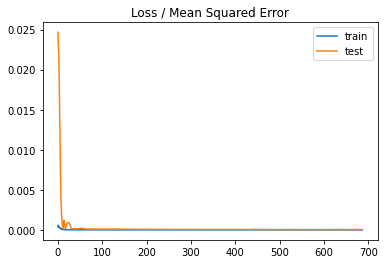

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_latest/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_bottom_latest/assets


In [19]:
def train_lstm(X_train, y_train, X_test, y_test, lstm_units=50, dropout_prob=0.5, n_features=1, epochs=6000, batch_size=32768, lr=0.001, early_stopping_epochs=100):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))

    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True,
                input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_prob))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # # Adding a third LSTM layer and some Dropout regularisation
    # model.add(LSTM(units=lstm_units,
    #             return_sequences=True))
    # model.add(Dropout(dropout_prob))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    # Adding the output layer
    model.add(Dense(units=1))

    # Adam optimizer
    opt = Adam(learning_rate=lr)
    # opt = Adam(learning_rate=lr, epsilon=1e-06, decay=1e-06)
    # # PiecewiseConstantDecay optimizer
    # boundaries = [200, 800, 2000, 4000]
    # values = [0.01, 0.001, 0.0005, 0.0001, 0.00001]
    # opt = keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries, values)

    # checkpoint = ModelCheckpoint("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss", monitor='val_loss', verbose=2,
    #                              save_best_only=True, mode='auto')
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            "/content/drive/MyDrive/PredictPriceByPattern/LSTM_{}_best_val_loss".format(pattern_name),
            save_best_only=True,
            monitor="val_loss"
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        ),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_epochs, verbose=1),
    ]


    # Compiling the model
    # model.compile(optimizer=opt,
    #               loss=tf.keras.losses.MeanAbsolutePercentageError())
    model.compile(loss = 'mean_squared_error', optimizer = opt)
    # model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.summary()

    tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

    # Fitting the model to the Training set
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        shuffle=False,
                        epochs=epochs, batch_size=batch_size,
                        callbacks=callbacks)

    # evaluate the model
    train_mse = model.evaluate(X_train, y_train)
    test_mse = model.evaluate(X_test, y_test)
    print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
    # plot loss during training
    plt.title('Loss / Mean Squared Error')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    return model

if scale_method != 'None':
    model = train_lstm(X_train_scaled, y_train_scaled,
                       X_val_scaled, y_val_scaled,
                       lstm_units=lstm_units, dropout_prob=dropout_prob,
                       n_features=X_train_scaled.shape[-1],
                       epochs=epochs, batch_size=batch_size, lr=lr,
                       early_stopping_epochs=early_stopping_epochs)
else:
    model = train_lstm(X_train, y_train,
                       X_val, y_val,
                       lstm_units=lstm_units, dropout_prob=dropout_prob,
                       n_features=X_train.shape[-1],
                       epochs=epochs, batch_size=batch_size, lr=lr,
                       early_stopping_epochs=early_stopping_epochs)
# model = train_lstm(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lstm_units, dropout_prob, epochs, batch_size)
model.save('/content/drive/MyDrive/PredictPriceByPattern/LSTM_{}_latest'.format(pattern_name))

### Test model

In [20]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def calc_confusion_matrix(X, y_true, y_pred, min_change=1):
    y_true_label = y_preice_to_y_label(X, y_true,
                                       min_change=min_price_change,
                                       feature_pred_idx=feature_pred_idx,
                                       num_classes=num_classes)
    y_pred_label = y_preice_to_y_label(X, y_pred,
                                       min_change=min_price_change,
                                       feature_pred_idx=feature_pred_idx,
                                       num_classes=num_classes)
    labels = list(range(num_classes))
    # print(labels)
    cm = confusion_matrix(y_true_label, y_pred_label, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp.plot()
    return cm

def calc_accuracy(X, y_true, y_pred, min_change=1):
    y_true_label = y_preice_to_y_label(X, y_true,
                                       min_change=min_price_change,
                                       feature_pred_idx=feature_pred_idx,
                                       num_classes=num_classes)
    y_pred_label = y_preice_to_y_label(X, y_pred,
                                       min_change=min_price_change,
                                       feature_pred_idx=feature_pred_idx,
                                       num_classes=num_classes)
    return accuracy_score(y_true_label, y_pred_label)

In [22]:
# X_test = X_train
lstm_model = keras.models.load_model("/content/drive/MyDrive/PredictPriceByPattern/LSTM_{}_best_val_loss".format(pattern_name))

In [23]:
if scale_method != 'None':
    predicted_stock_price = lstm_model.predict(X_test_scaled)
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
else:
    predicted_stock_price = lstm_model.predict(X_test)
# predicted_stock_price = lstm_model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))
# if scale_method == 'MinMax':
#     predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [24]:
print(y_test)
print(predicted_stock_price)

[[ 246.78999329]
 [ 253.41999817]
 [ 265.13000488]
 [ 310.51998901]
 [ 314.83999634]
 [ 323.95999146]
 [ 345.77999878]
 [ 336.02999878]
 [ 362.66000366]
 [ 381.8500061 ]
 [ 389.57998657]
 [ 395.77999878]
 [ 417.60998535]
 [  45.75      ]
 [  47.9375    ]
 [  50.375     ]
 [  40.90000153]
 [  42.36999893]
 [  37.5       ]
 [  32.43000031]
 [  32.97999954]
 [  24.87999916]
 [  25.65999985]
 [  21.68000031]
 [  24.87000084]
 [  27.30999947]
 [  40.59999847]
 [  39.34000015]
 [  26.89999962]
 [  26.69000053]
 [  25.67000008]
 [  28.45999908]
 [  37.79000092]
 [  37.81000137]
 [  30.07999992]
 [  33.24599838]
 [  32.82600021]
 [  36.2820015 ]
 [  46.05799866]
 [  43.91600037]
 [  47.06800079]
 [  38.94599915]
 [  40.61999893]
 [  54.93199921]
 [  49.7820015 ]
 [  44.36000061]
 [  60.5019989 ]
 [  65.05200195]
 [  72.55000305]
 [  61.74000168]
 [  62.52000046]
 [  63.45000076]
 [  69.84999847]
 [  68.36799622]
 [  57.38800049]
 [  63.22600174]
 [  53.68399811]
 [  51.00600052]
 [ 109.7679977

In [25]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[-16.67]
 [-0.41]
 [13.86]
 [-4.17]
 [-1.01]
 [-4.69]
 [-7.26]
 [-12.26]
 [-1.83]
 [-7.31]
 [-4.97]
 [-5.90]
 [-5.55]
 [-1.50]
 [3.55]
 [1.46]
 [-3.93]
 [1.50]
 [1.36]
 [0.13]
 [-0.12]
 [-0.80]
 [0.85]
 [0.56]
 [0.74]
 [0.36]
 [0.99]
 [-0.84]
 [1.80]
 [1.26]
 [-0.08]
 [-0.12]
 [0.53]
 [-0.16]
 [0.92]
 [0.02]
 [3.07]
 [2.46]
 [1.20]
 [-1.90]
 [-1.38]
 [-0.33]
 [1.95]
 [1.92]
 [2.15]
 [0.69]
 [0.75]
 [-0.99]
 [2.81]
 [-0.61]
 [1.08]
 [-2.10]
 [0.91]
 [0.81]
 [-2.64]
 [-6.53]
 [-1.56]
 [-0.24]
 [12.10]
 [15.06]
 [3.11]
 [15.97]
 [13.60]
 [16.60]
 [20.25]
 [-10.92]
 [3.31]
 [63.09]
 [15.55]
 [30.97]
 [-15.73]
 [21.85]
 [86.04]
 [-55.44]
 [-14.42]
 [-14.42]
 [1.12]
 [0.07]
 [0.70]
 [-0.29]
 [0.06]
 [0.79]
 [-0.42]
 [0.20]
 [-0.22]
 [-0.22]
 [0.91]
 [0.33]
 [1.40]
 [0.05]
 [-0.97]
 [0.13]
 [-0.23]
 [0.93]
 [1.41]
 [1.38]
 [1.55]
 [-2.56]
 [0.83]
 [-4.20]
 [2.45]
 [1.32]
 [-0.77]
 [-3.36]
 [10.88]
 [2.72]
 [-4.50]
 [2.86]
 [0.96]
 [-0.86]
 [-1.84]
 [-0.07]
 [0.95]
 [0.12]
 [0.01]
 [0.96]
 [0

rmse: 21.469801243581006 mape: 3.544455050434636
confusion_matrix: [[212 184]
 [193 143]]
acc: 0.4849726775956284


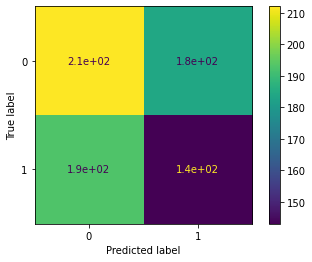

In [26]:
# Calculate RMSE and MAPE
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import mean_absolute_percentage_error

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
# mape = mean_absolute_percentage_error(y_test.reshape(-1), predicted_stock_price.reshape(-1))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

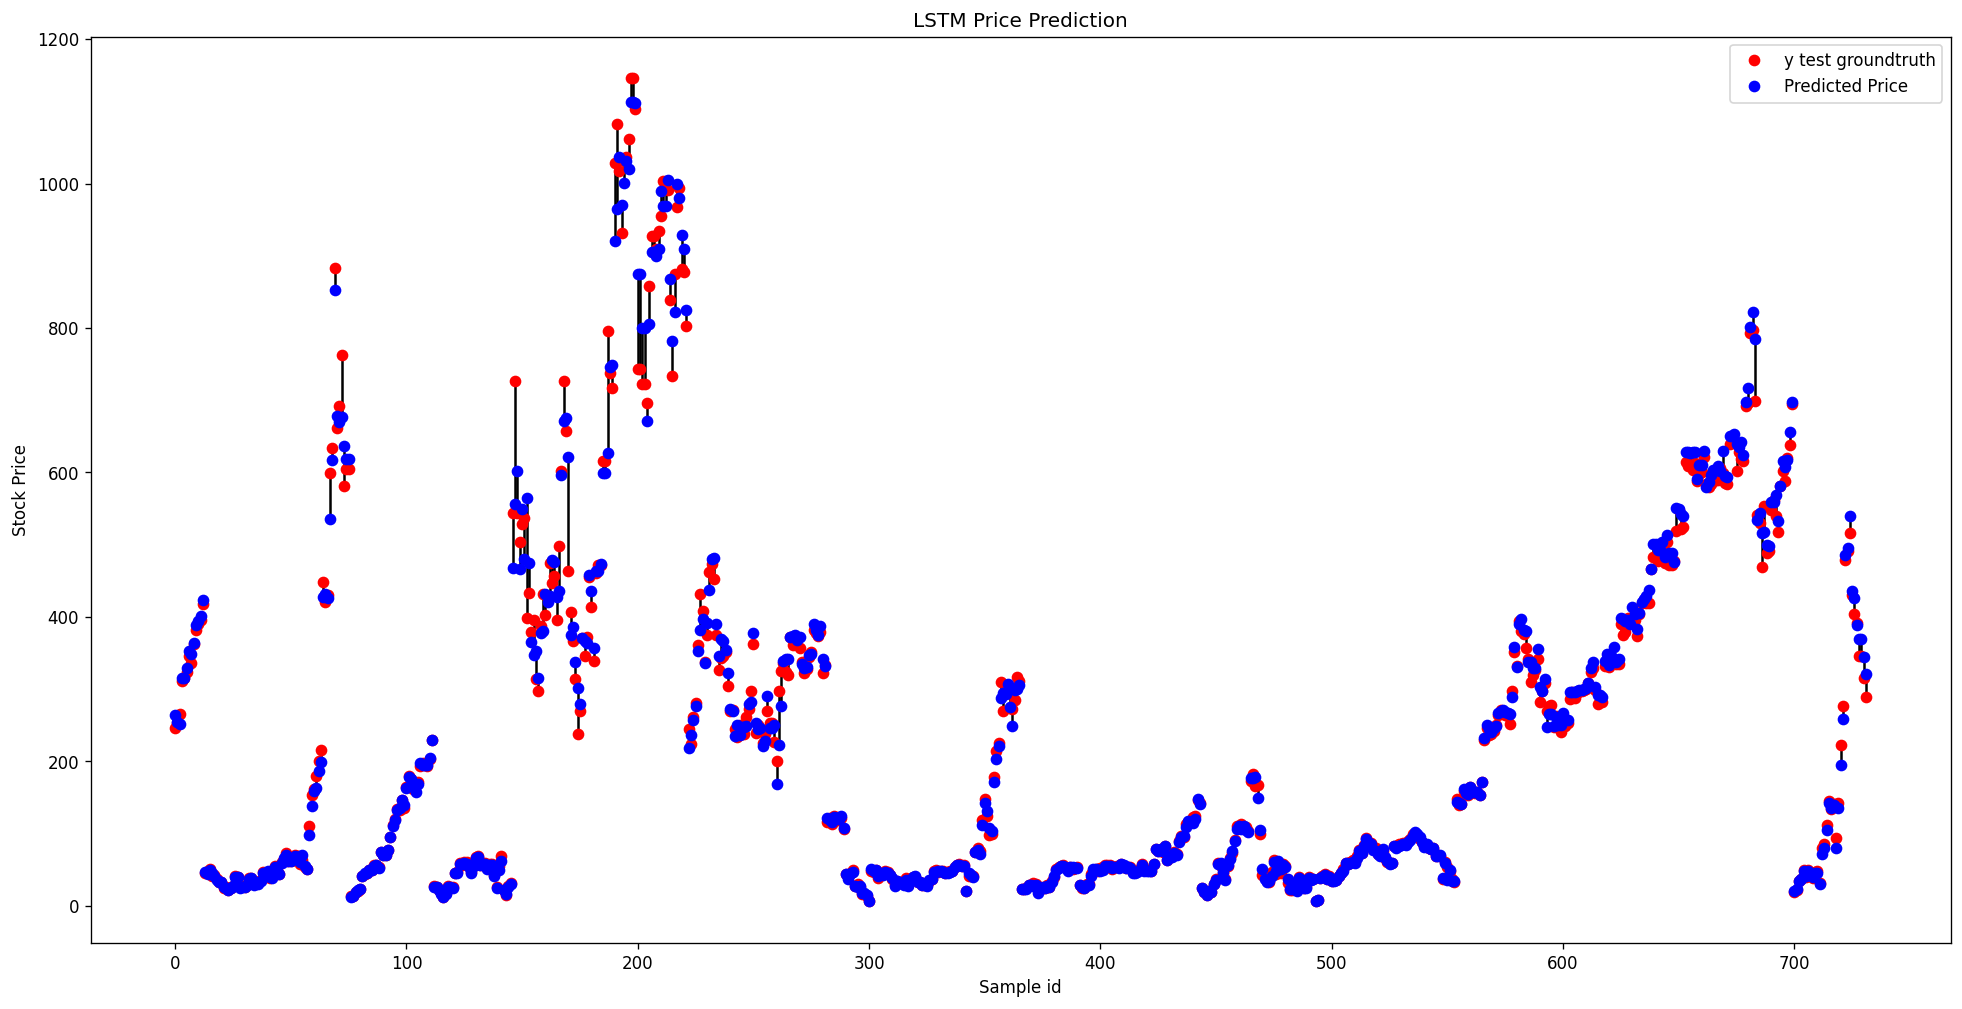

In [27]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('LSTM Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

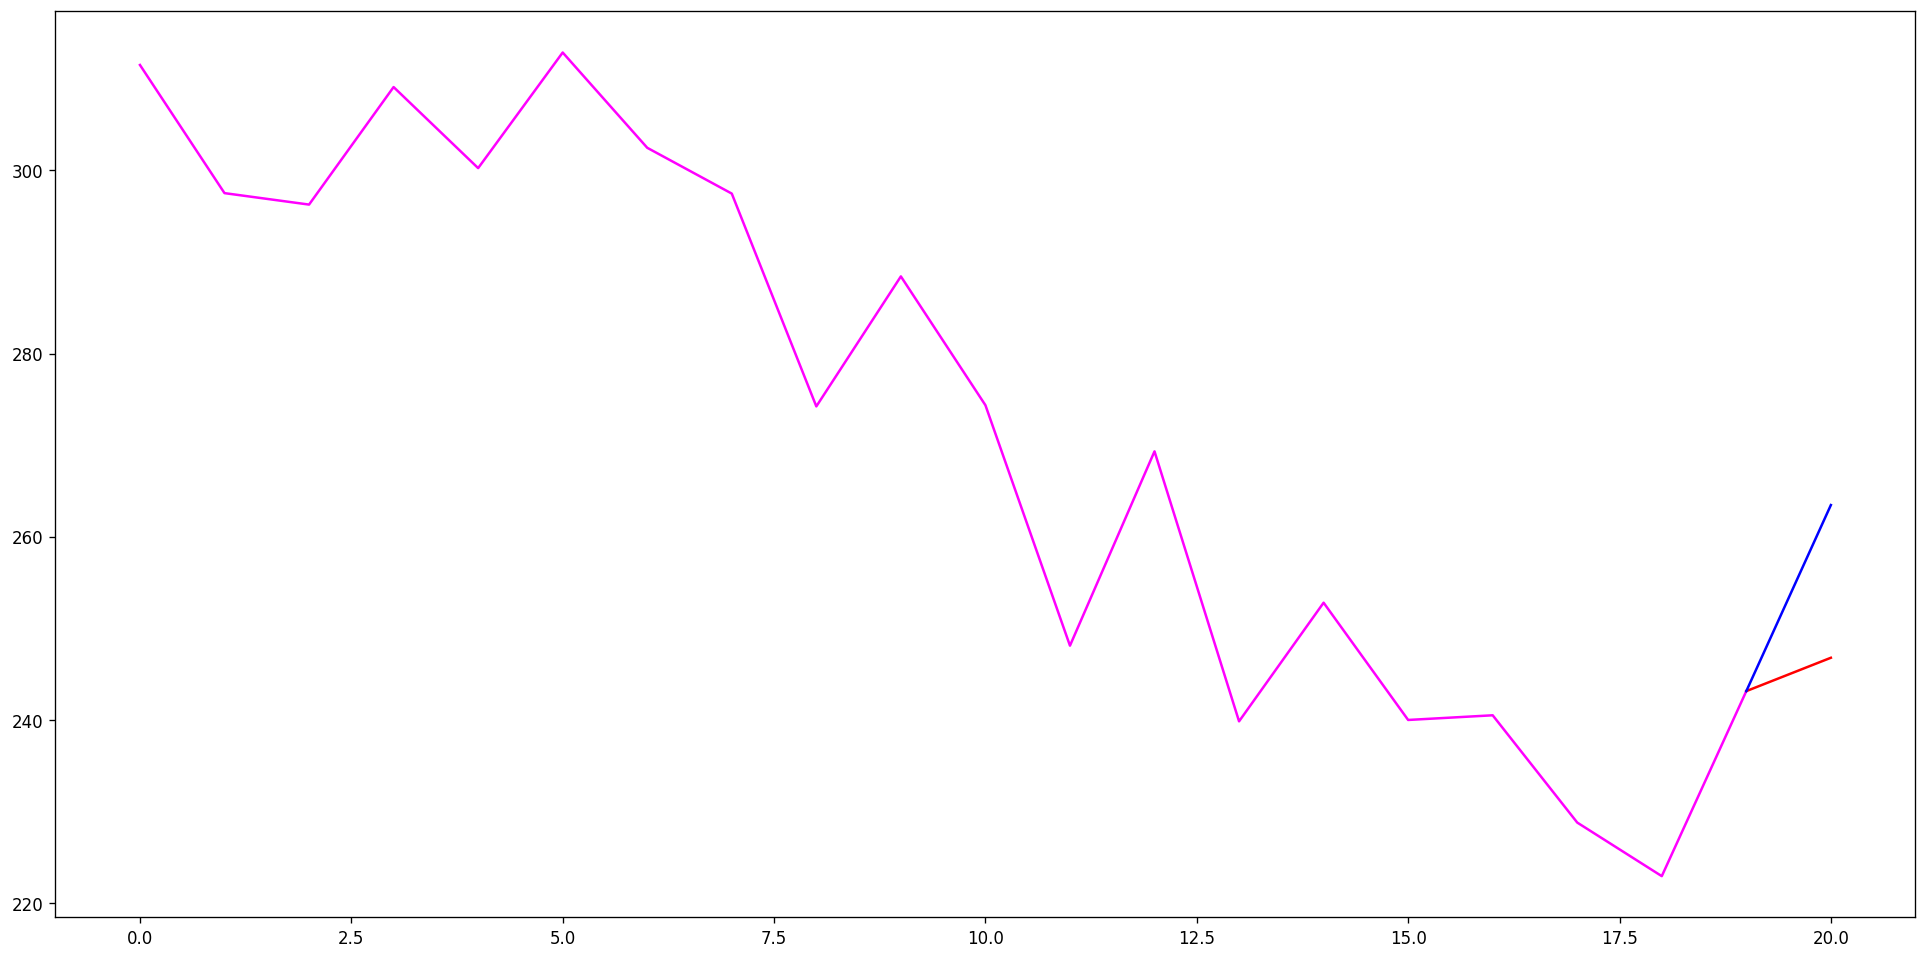

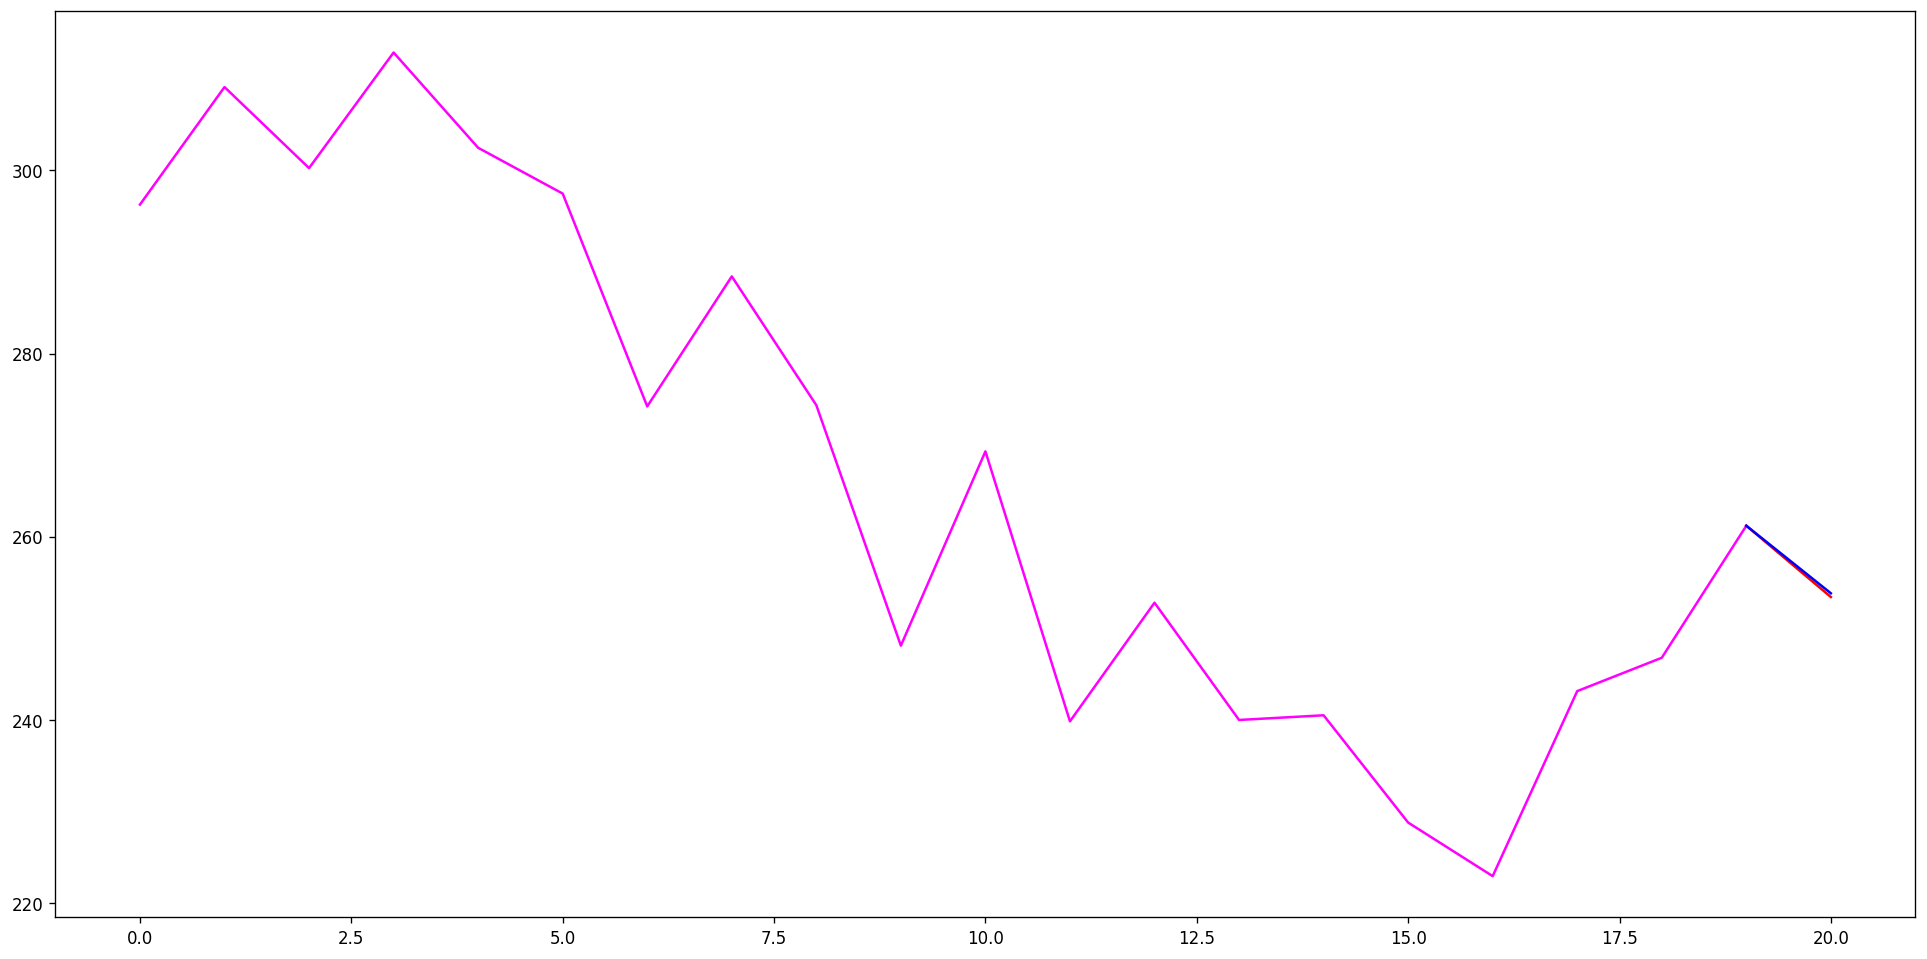

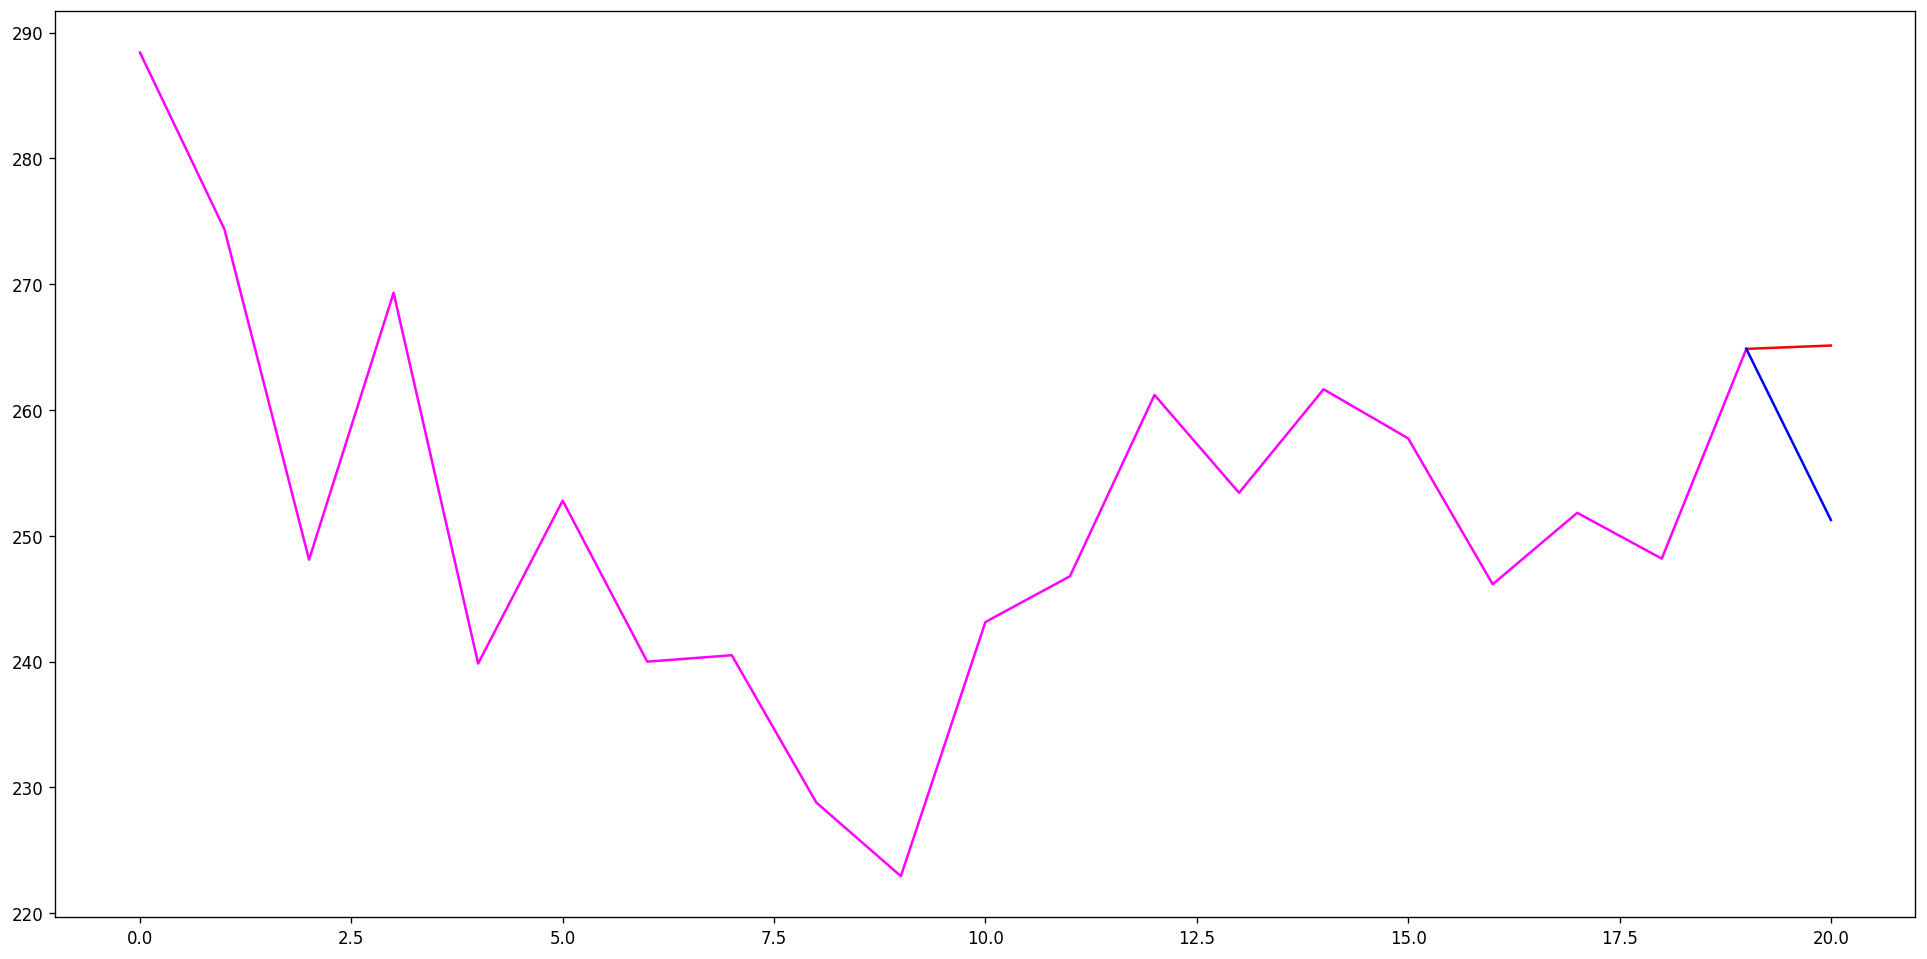

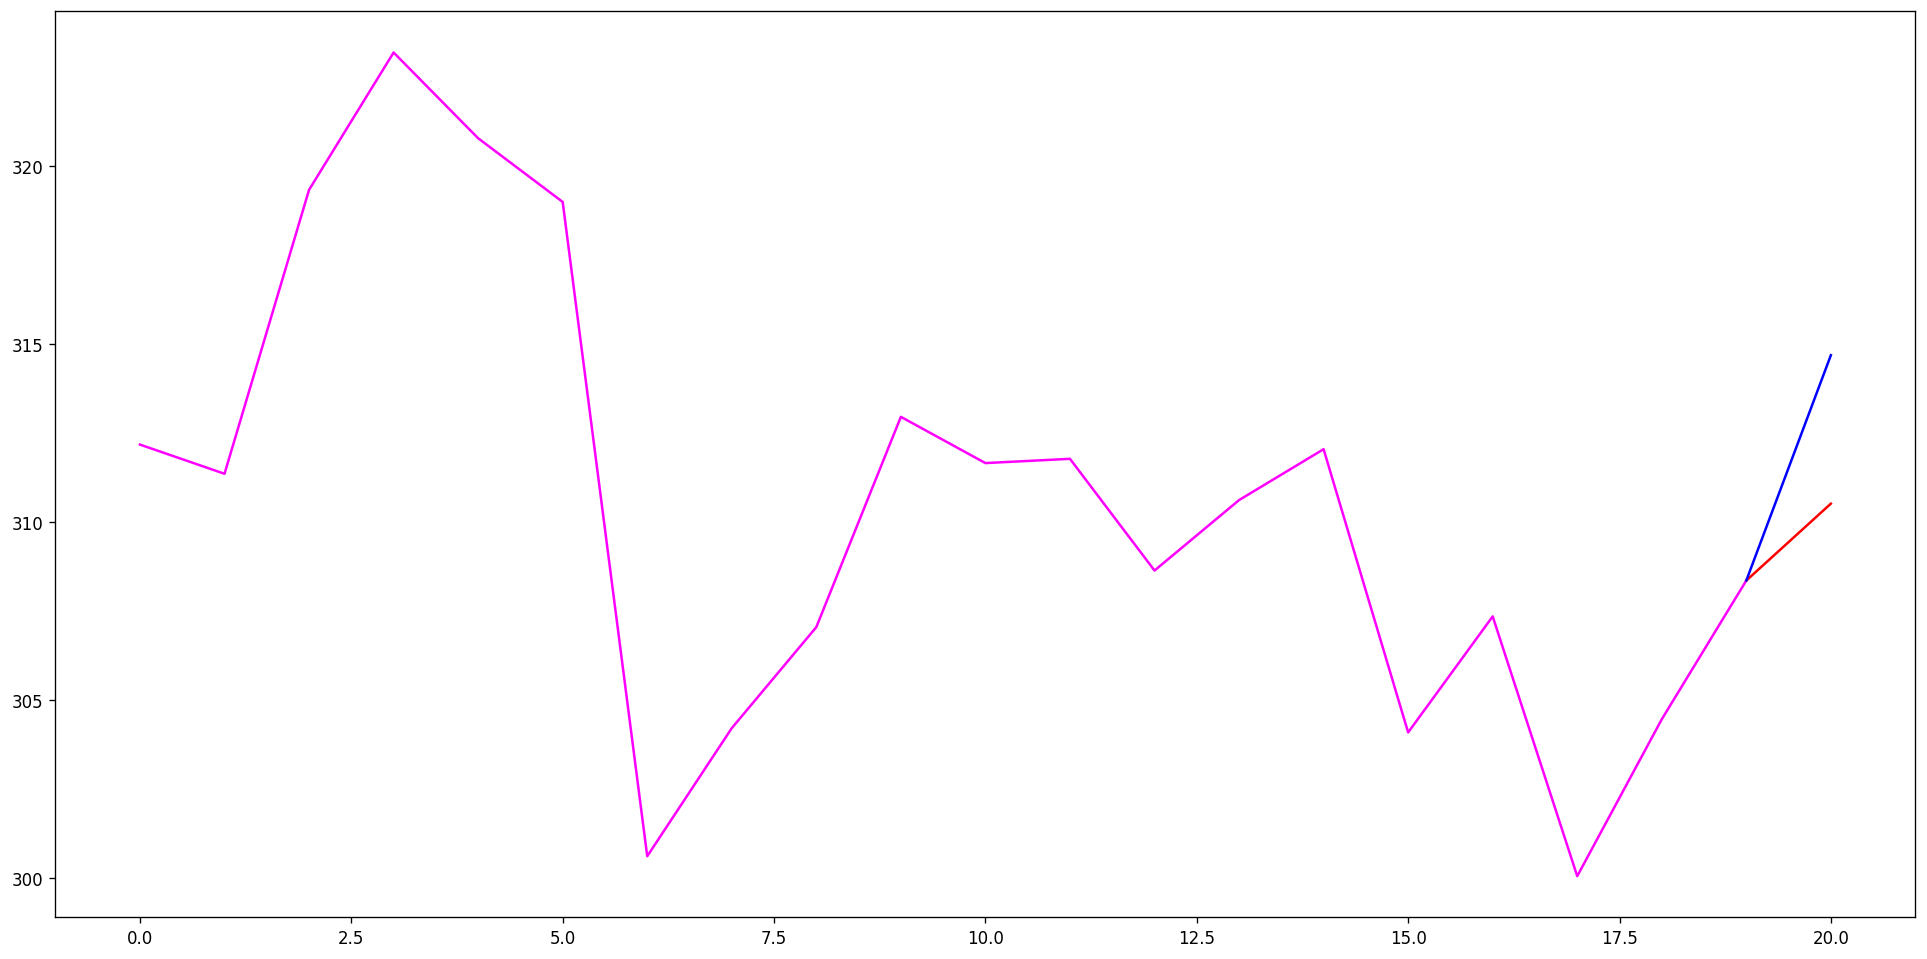

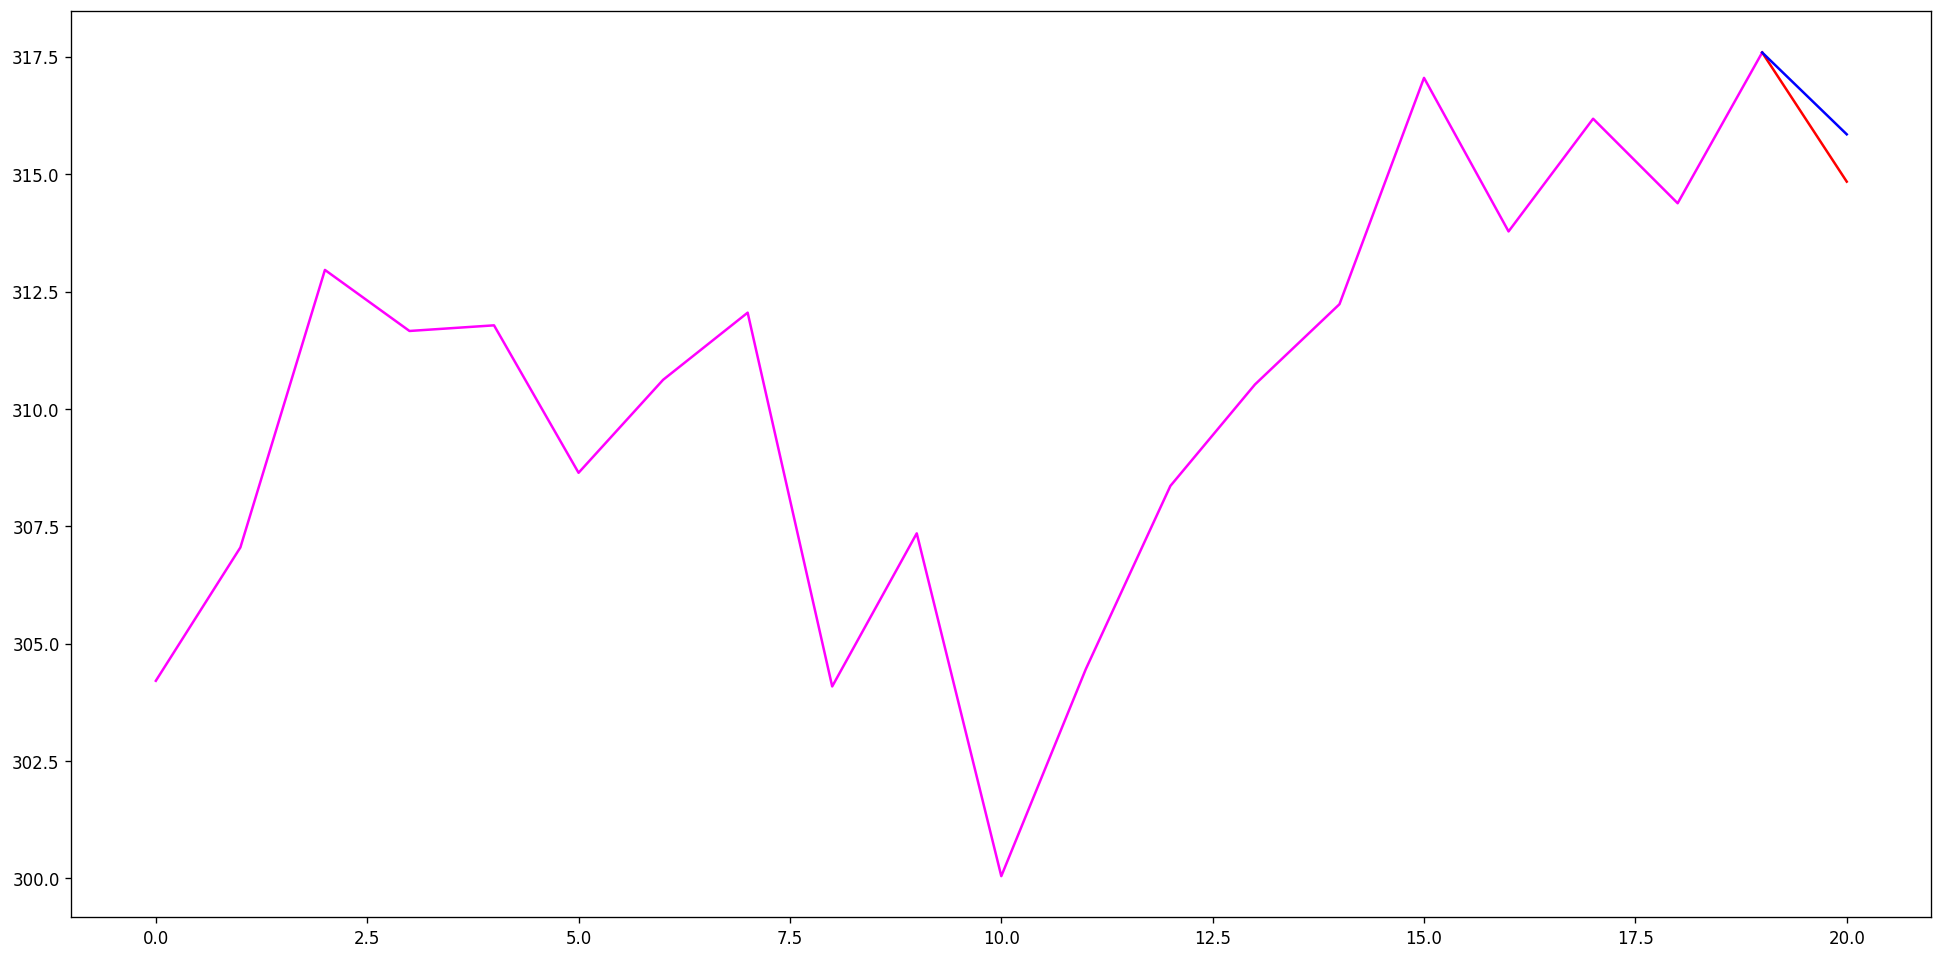

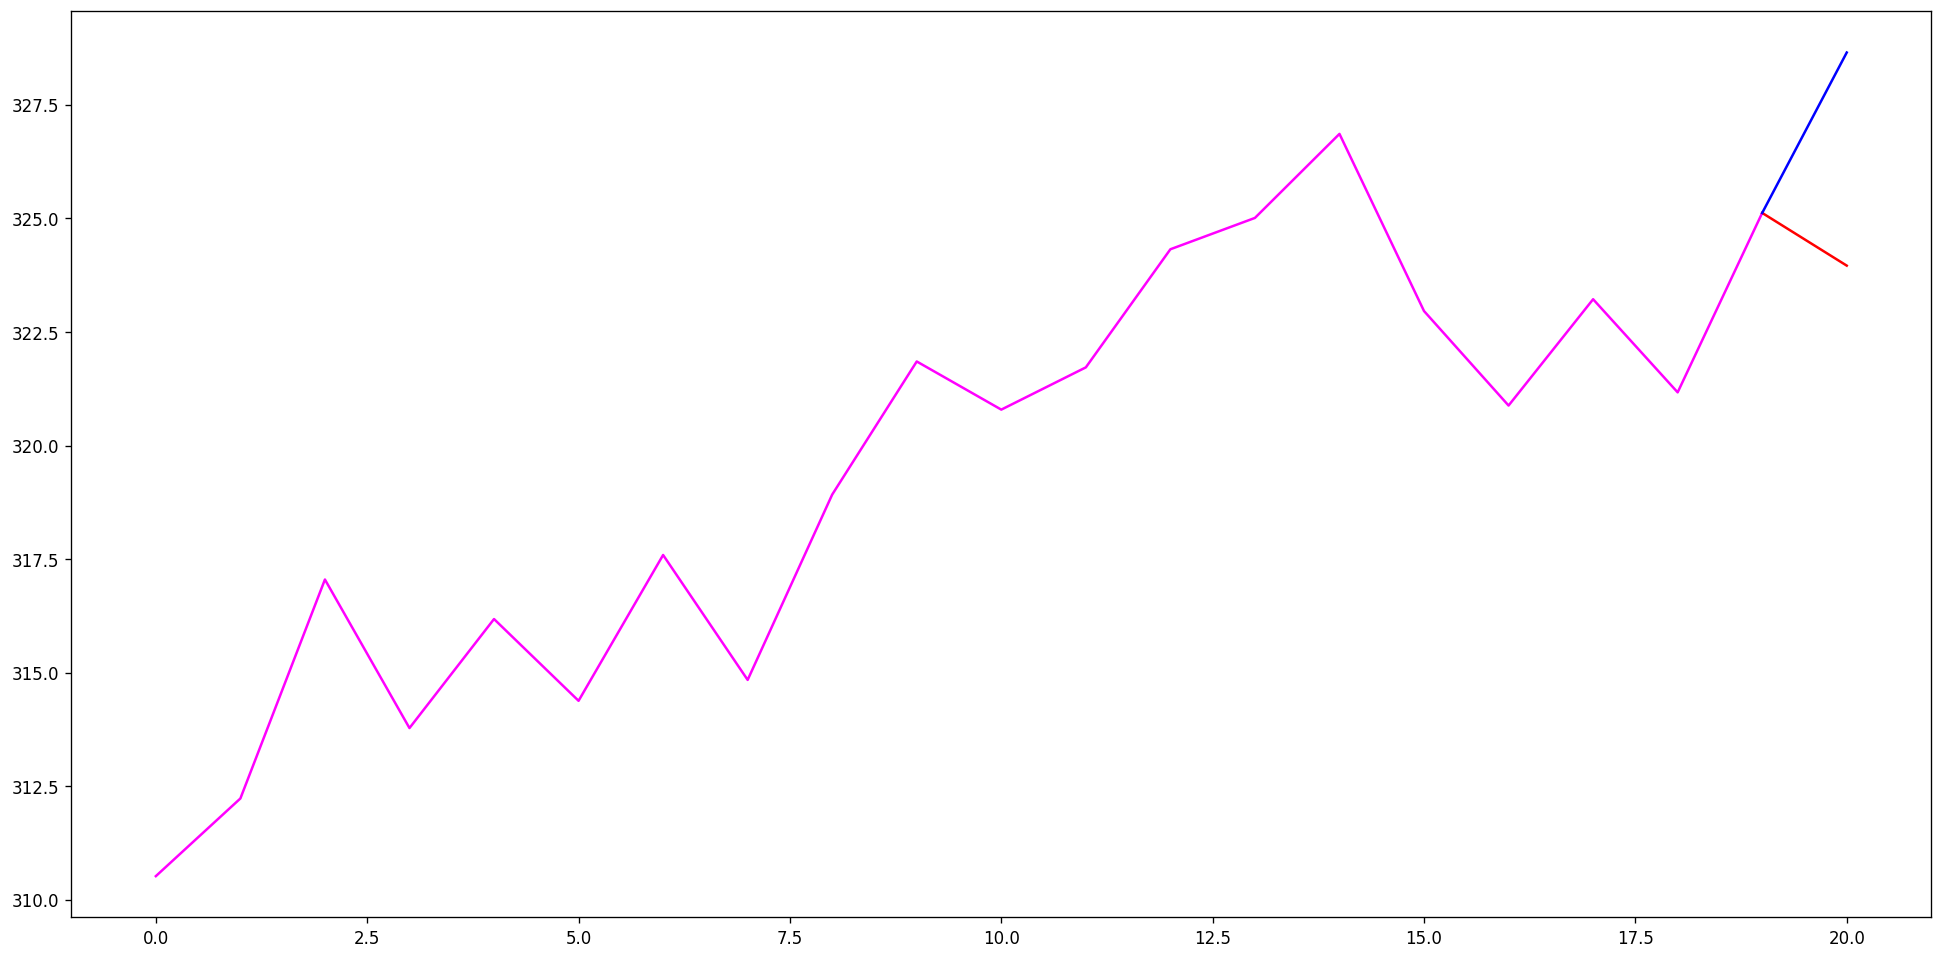

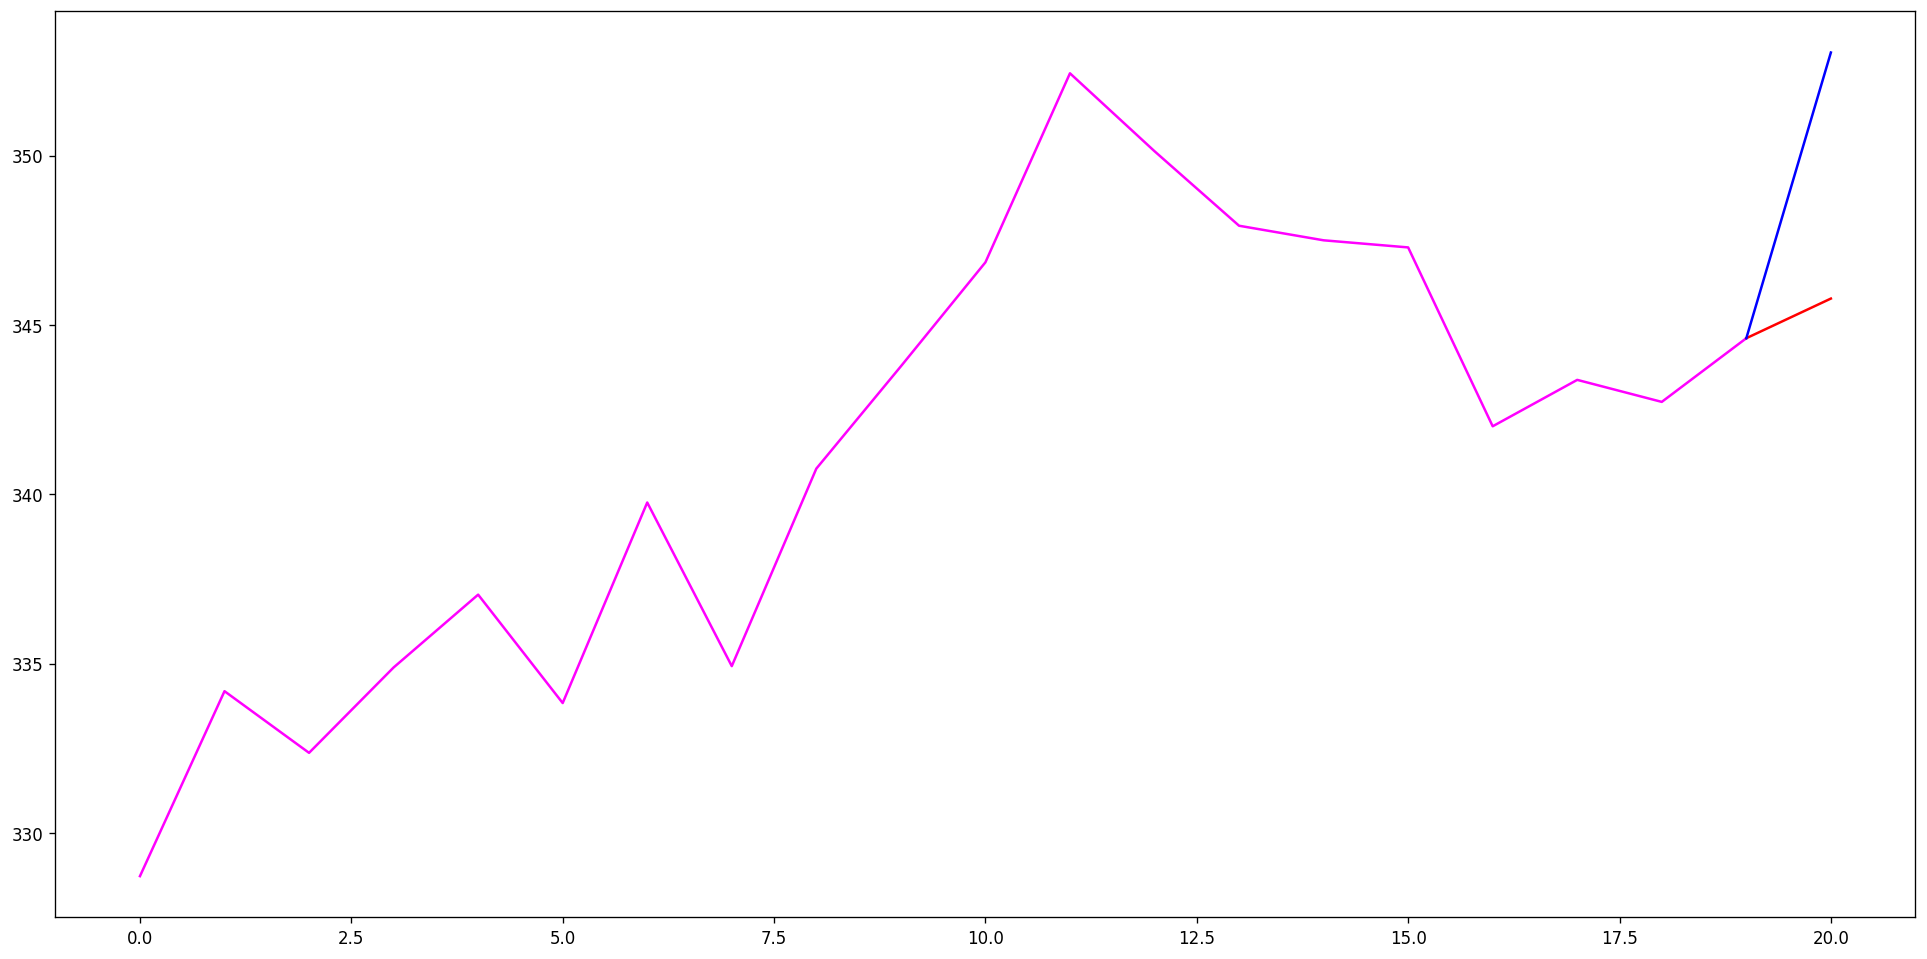

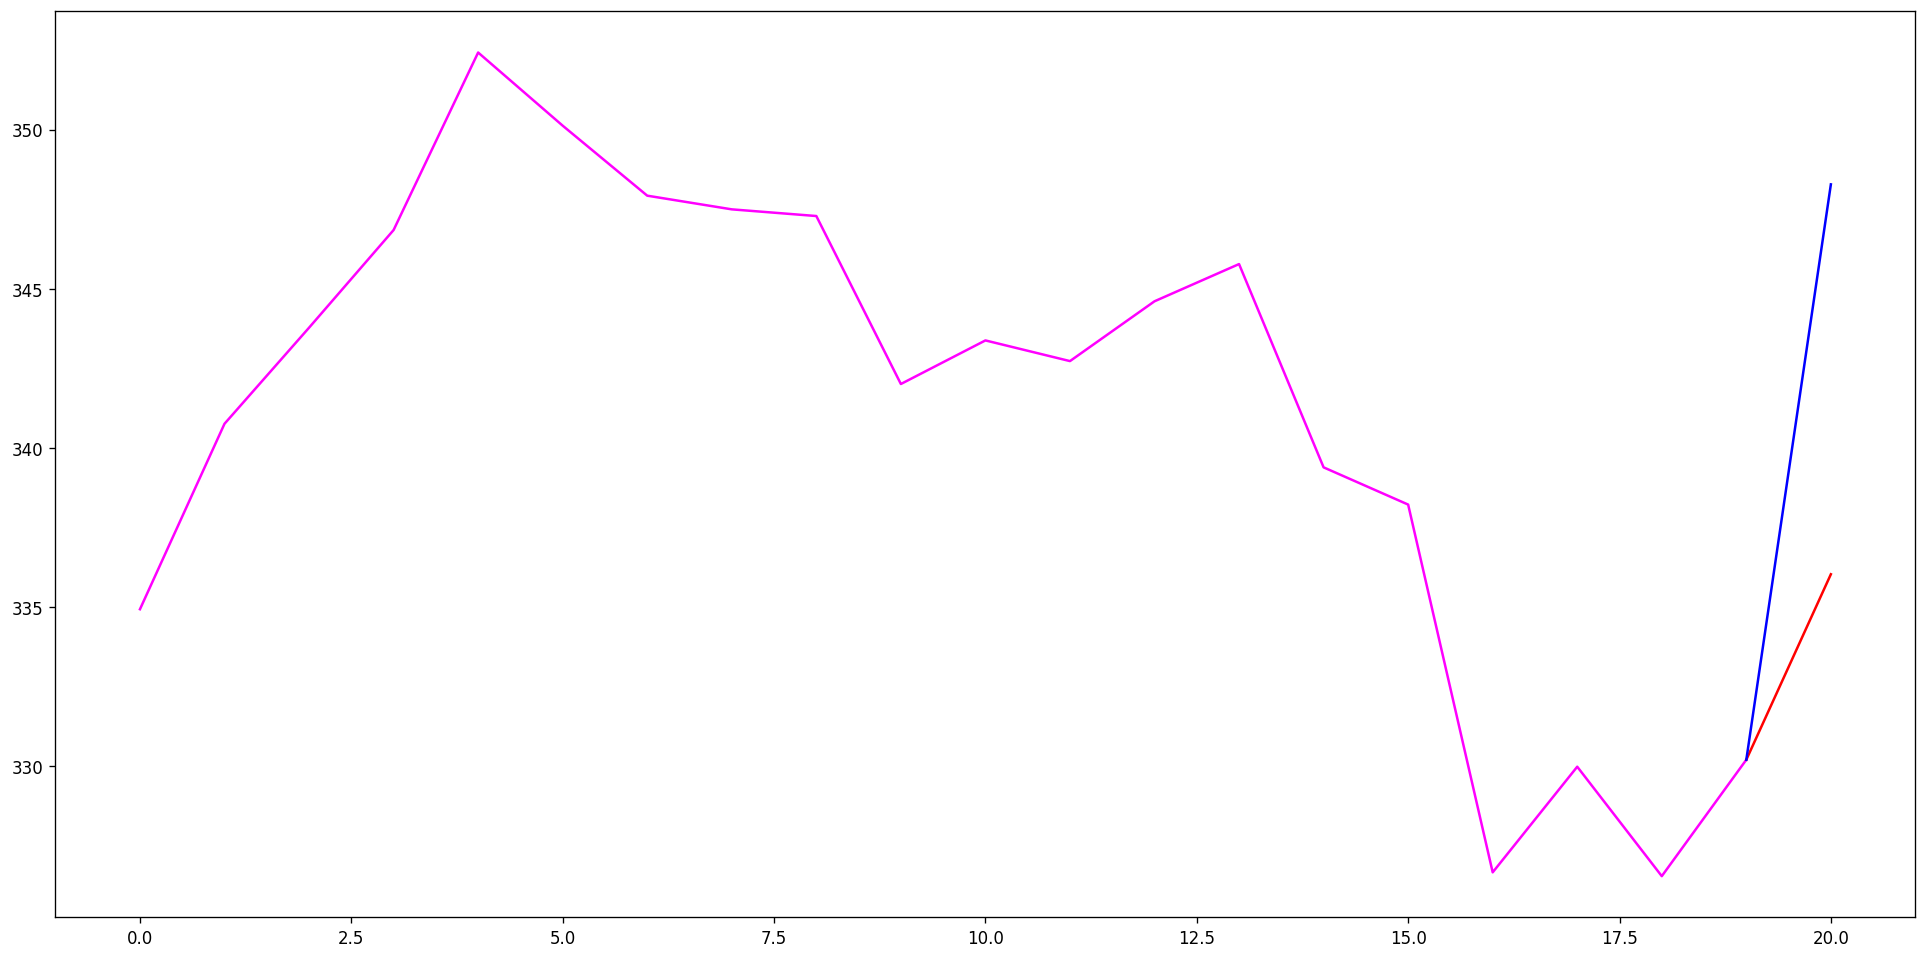

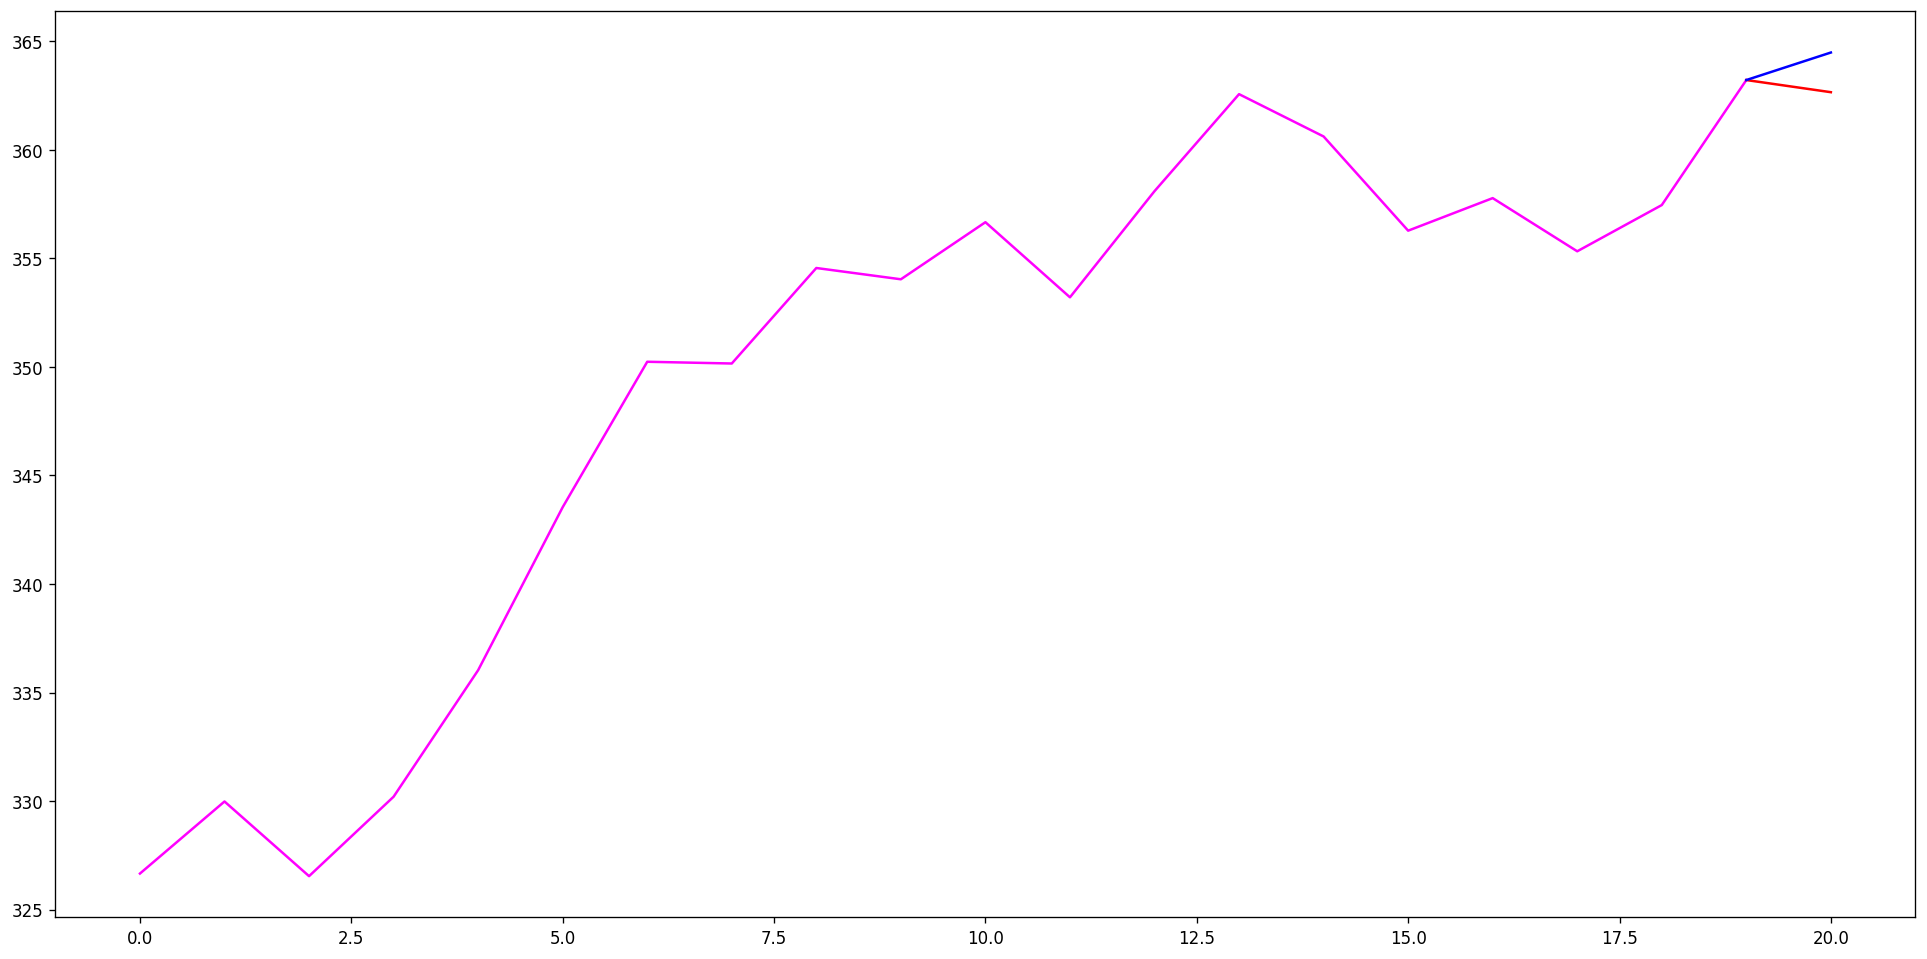

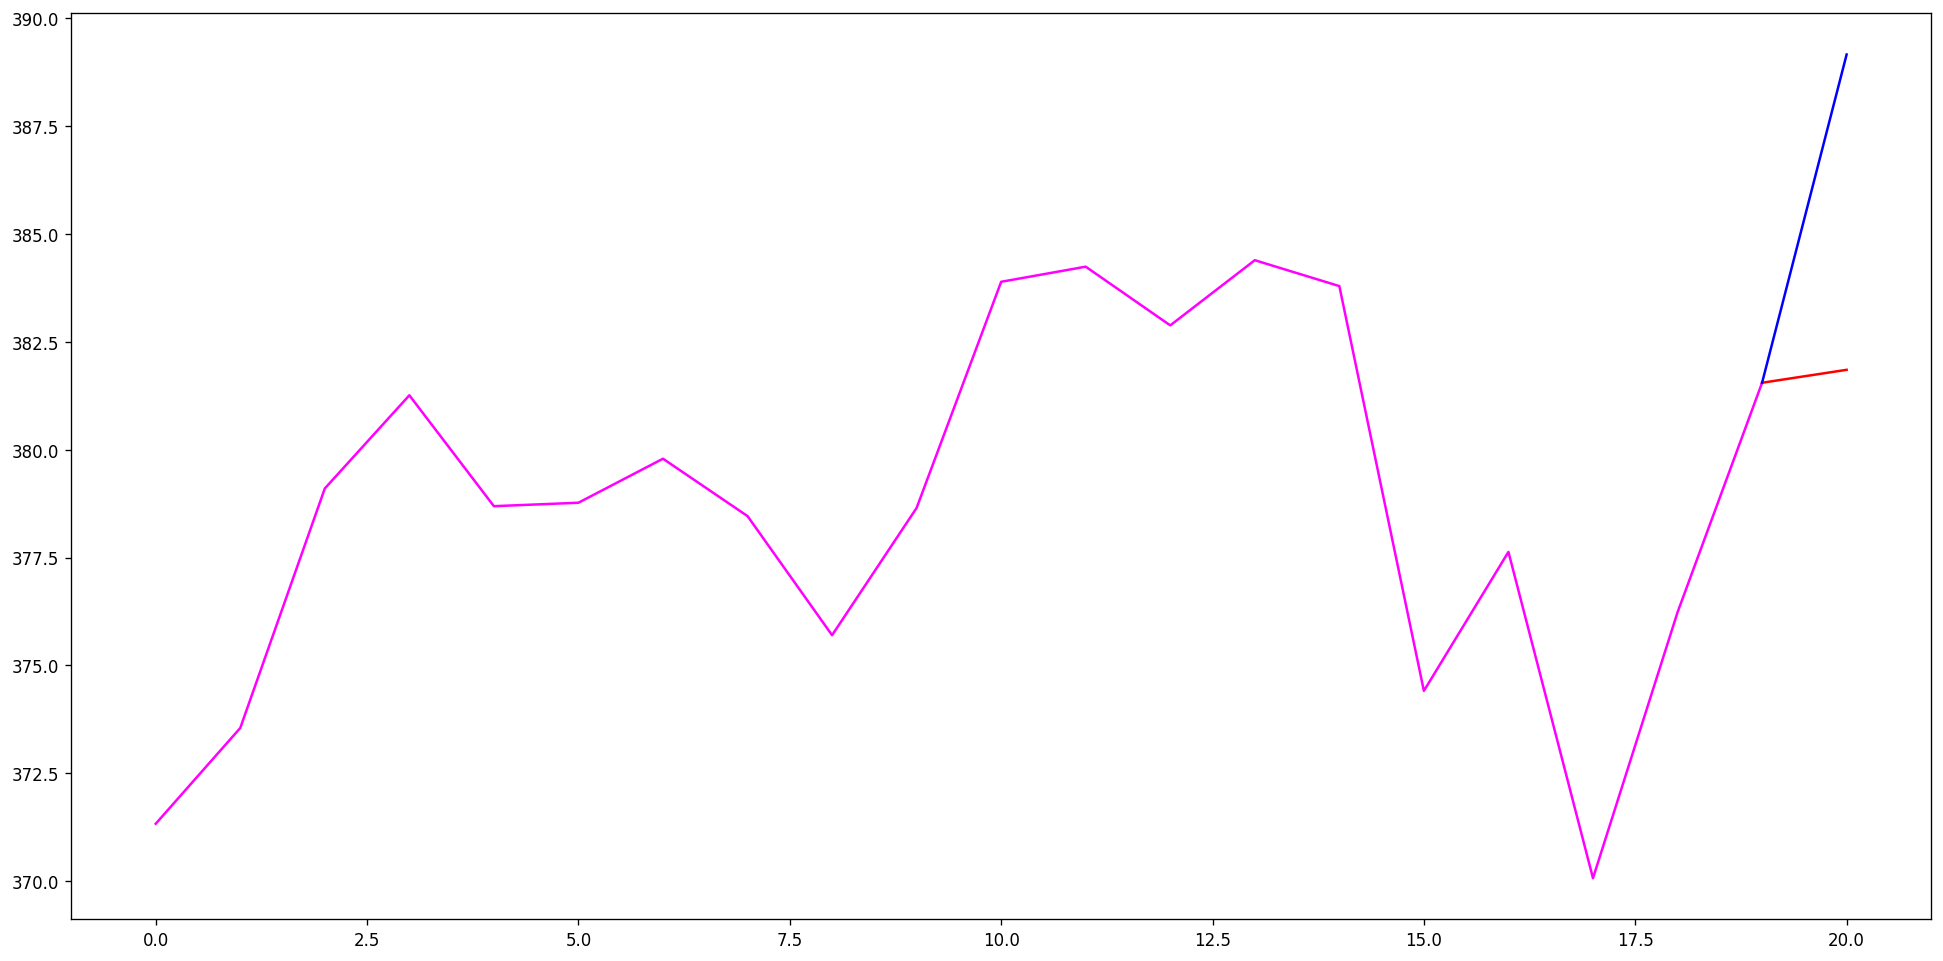

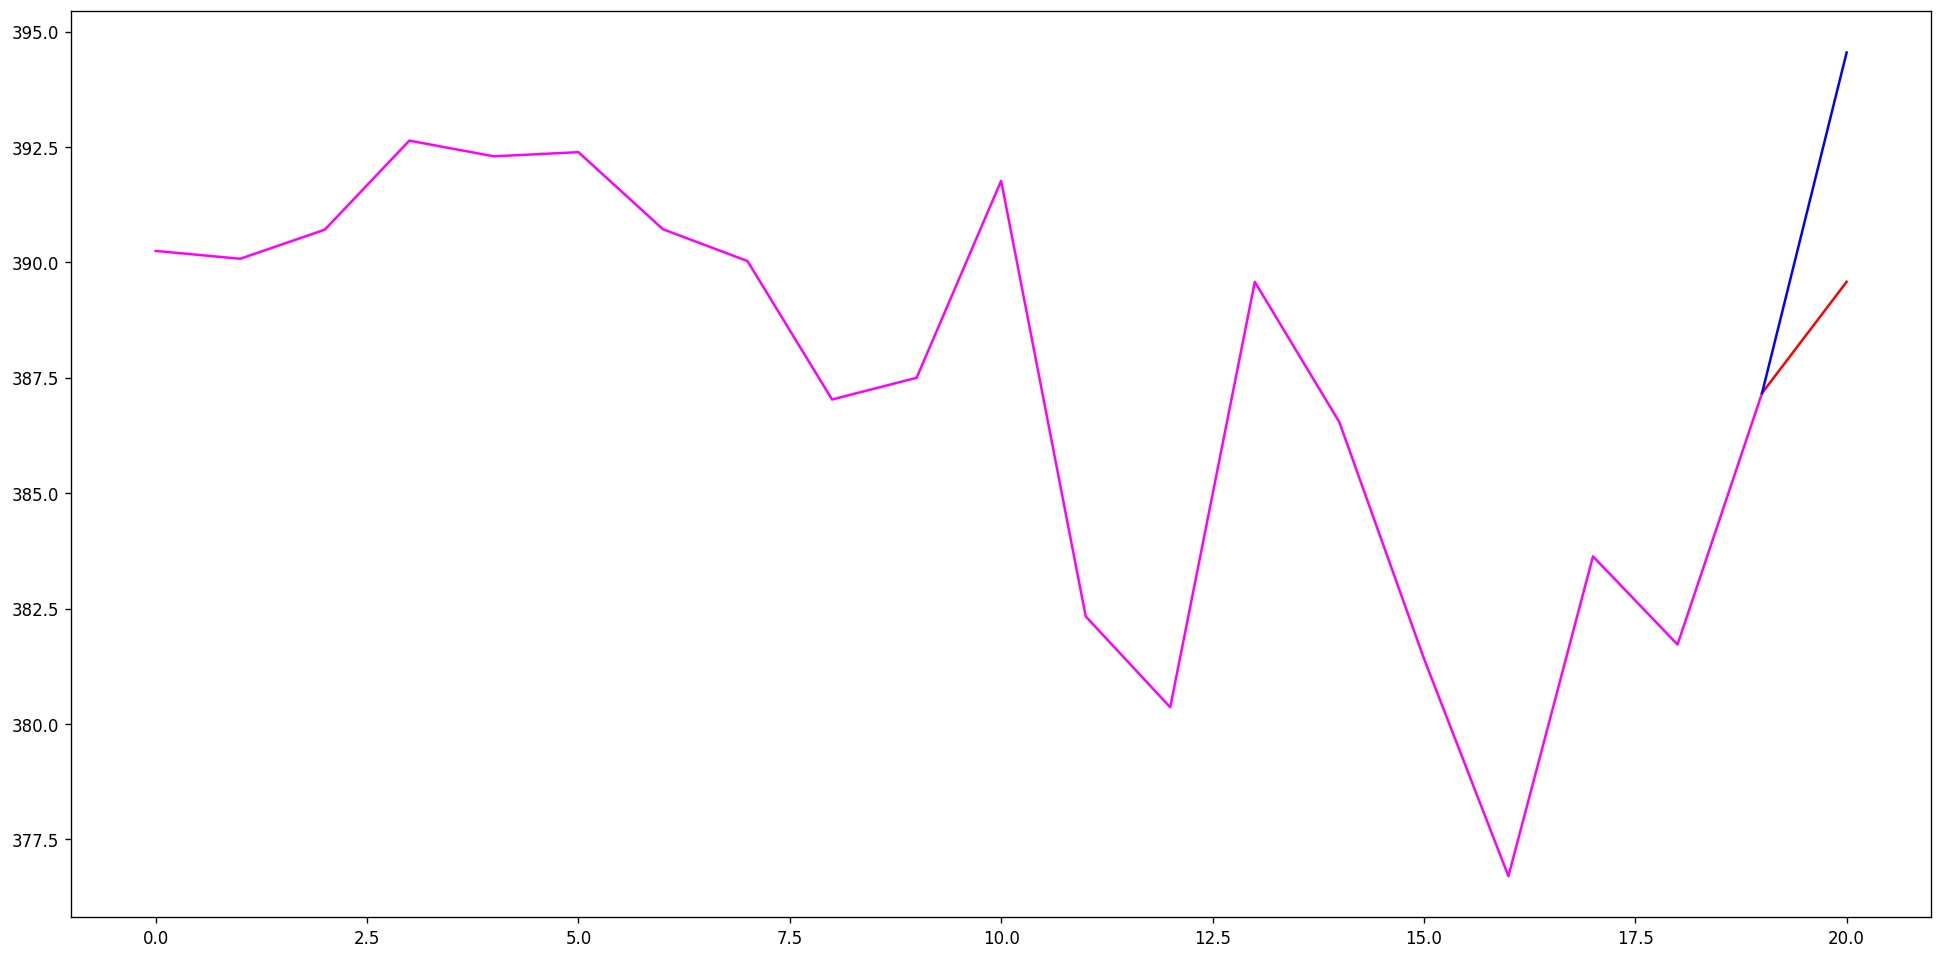

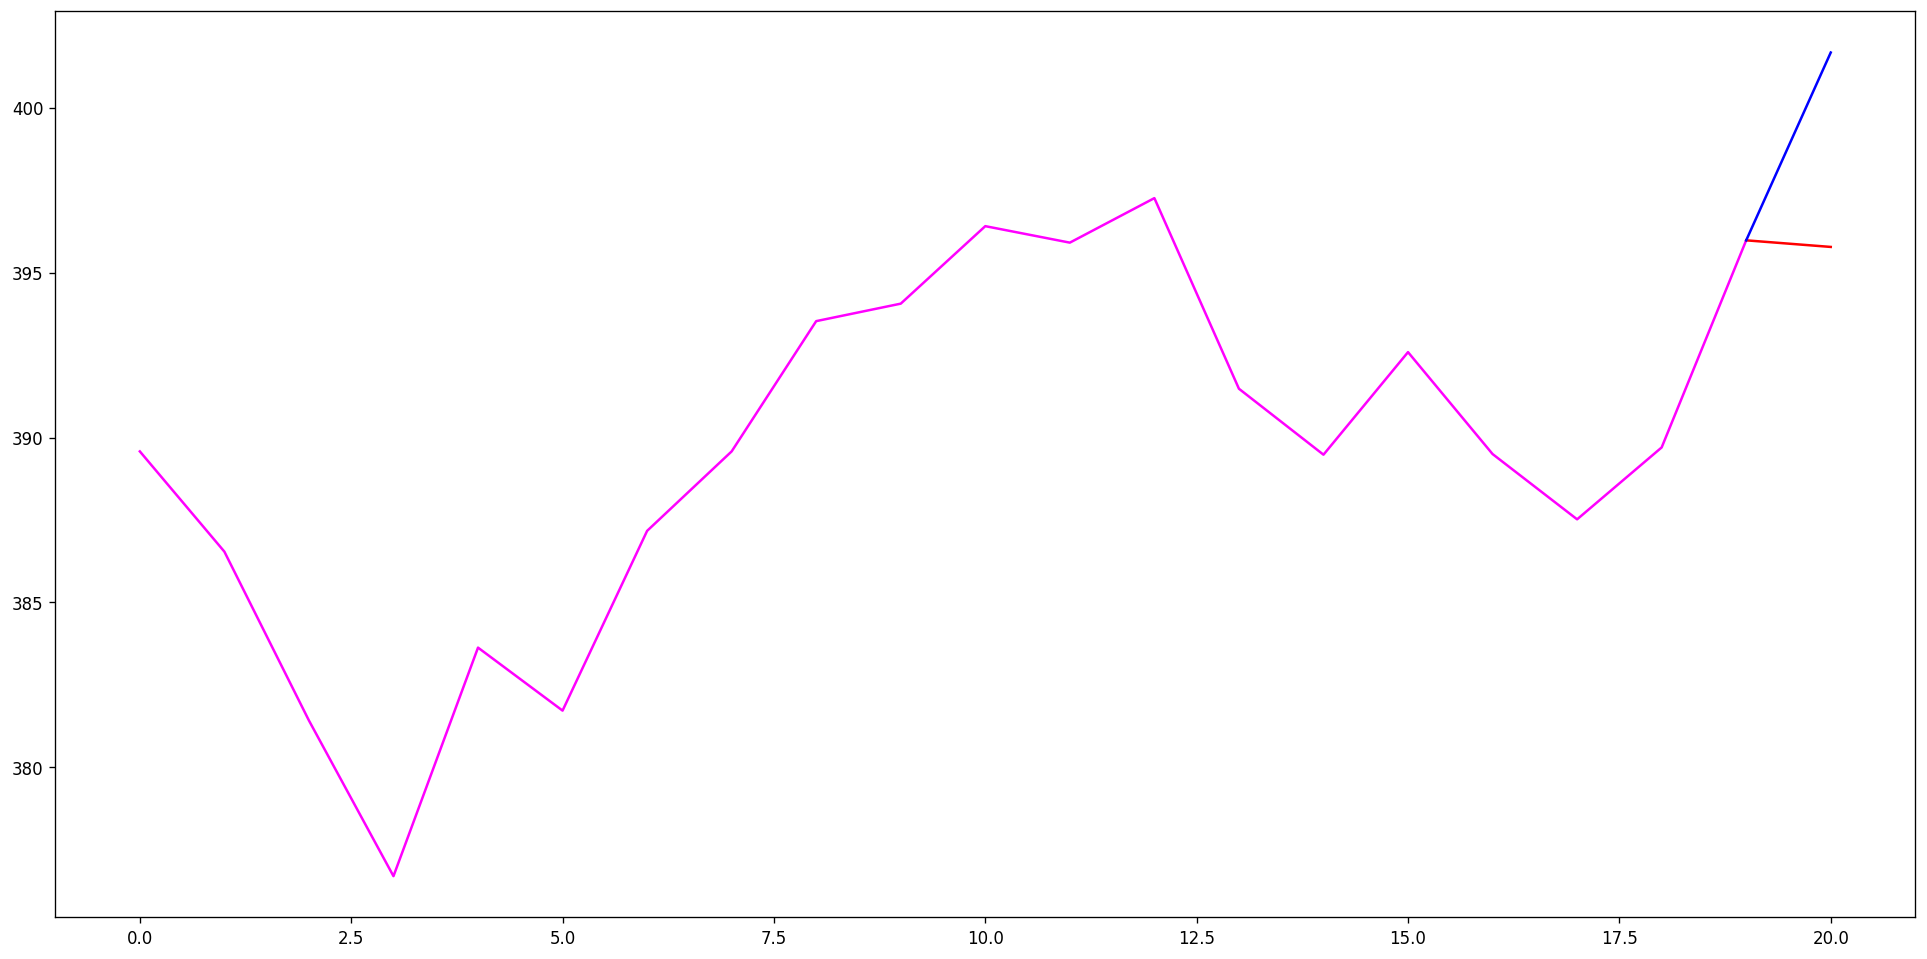

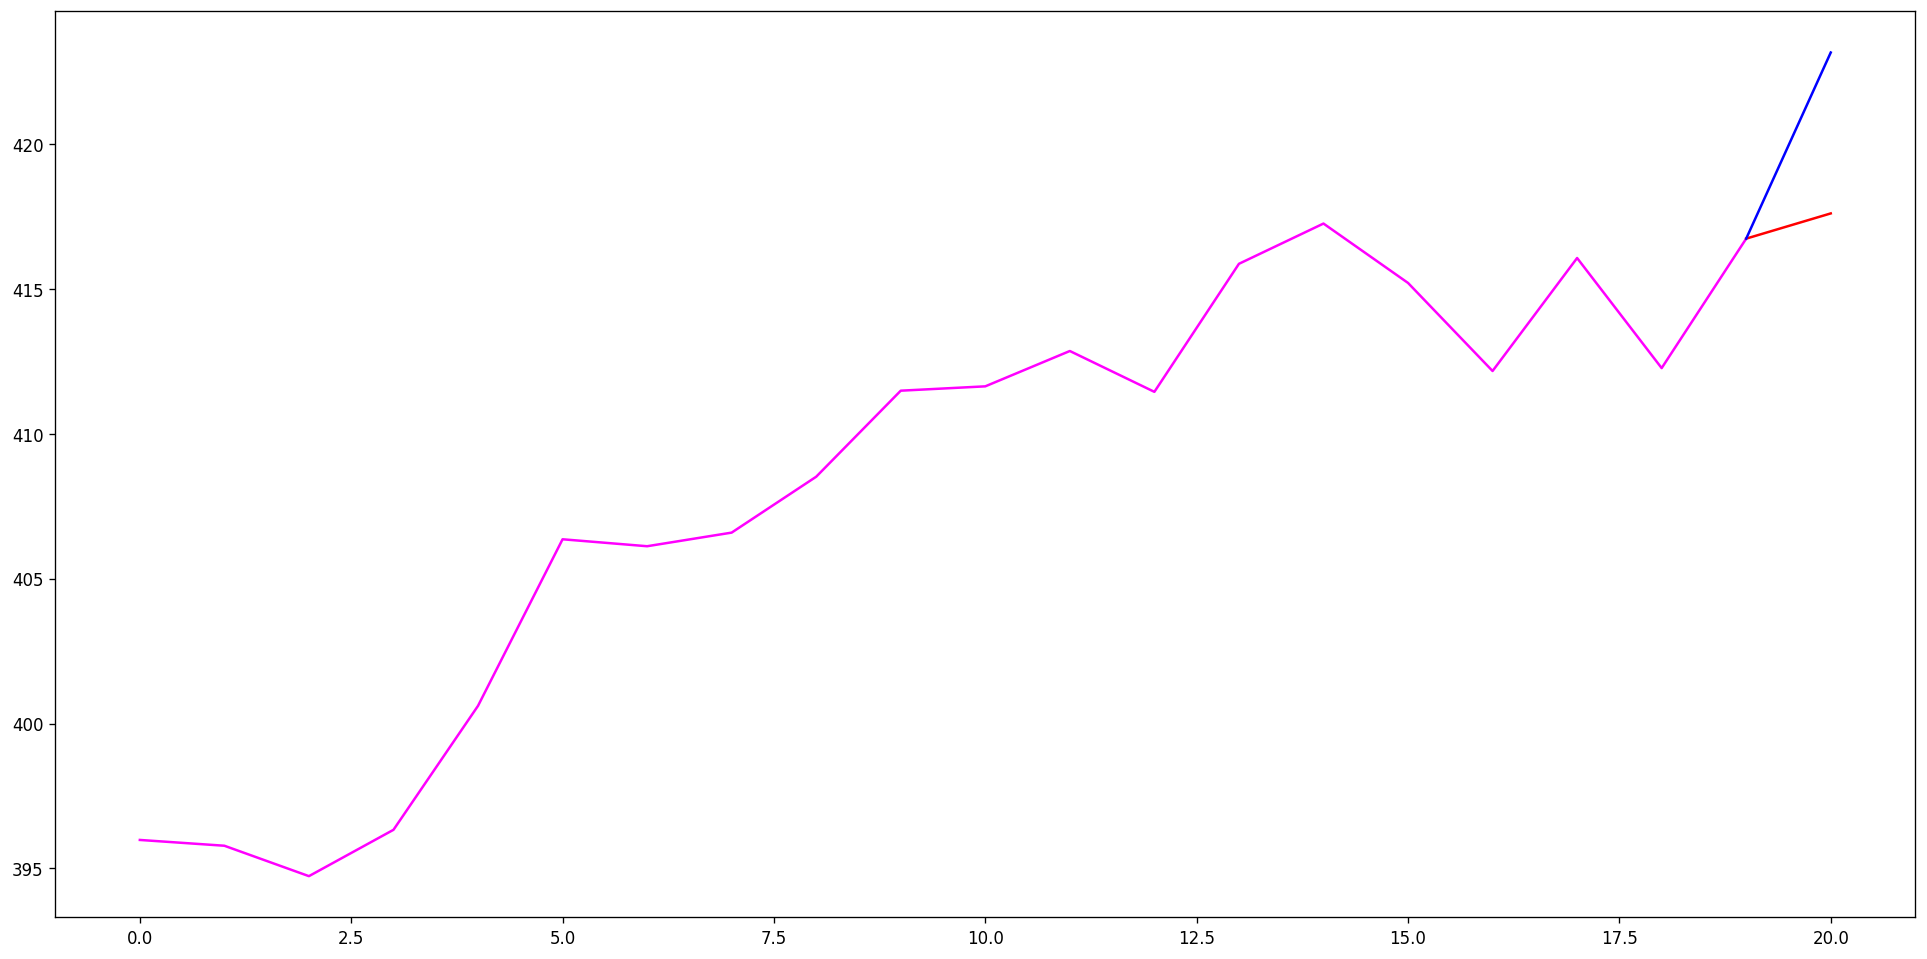

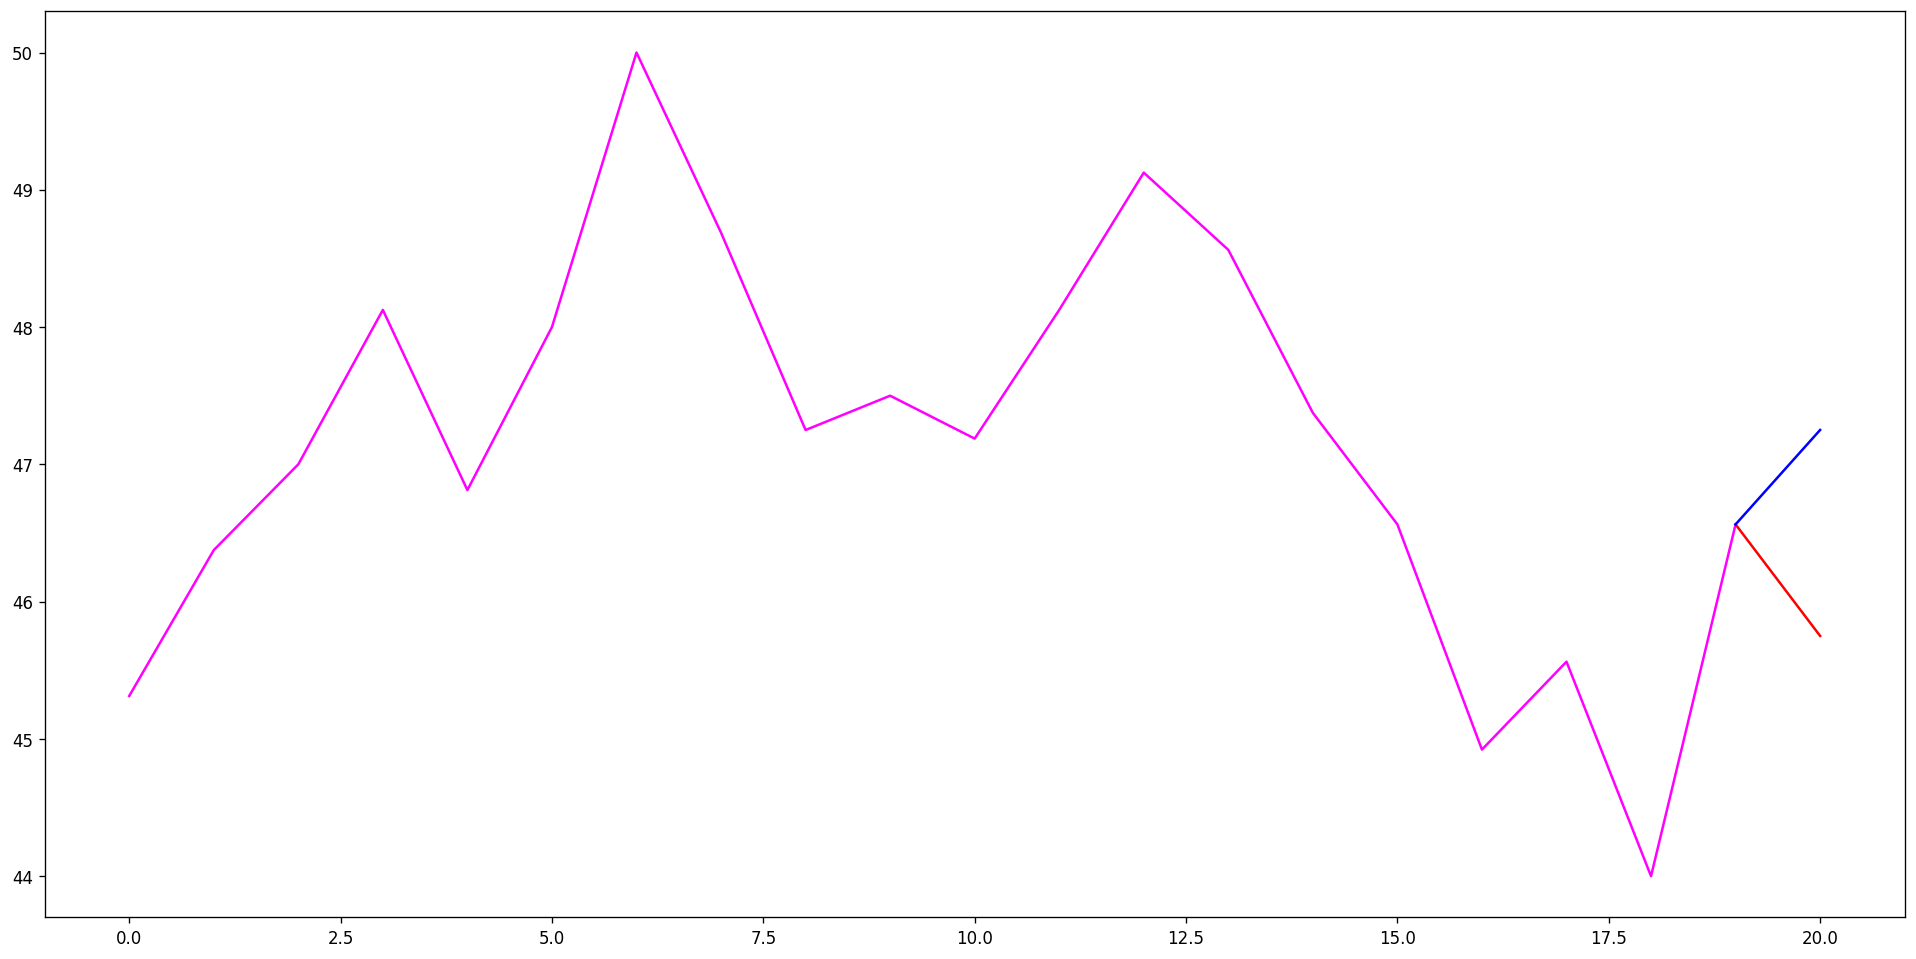

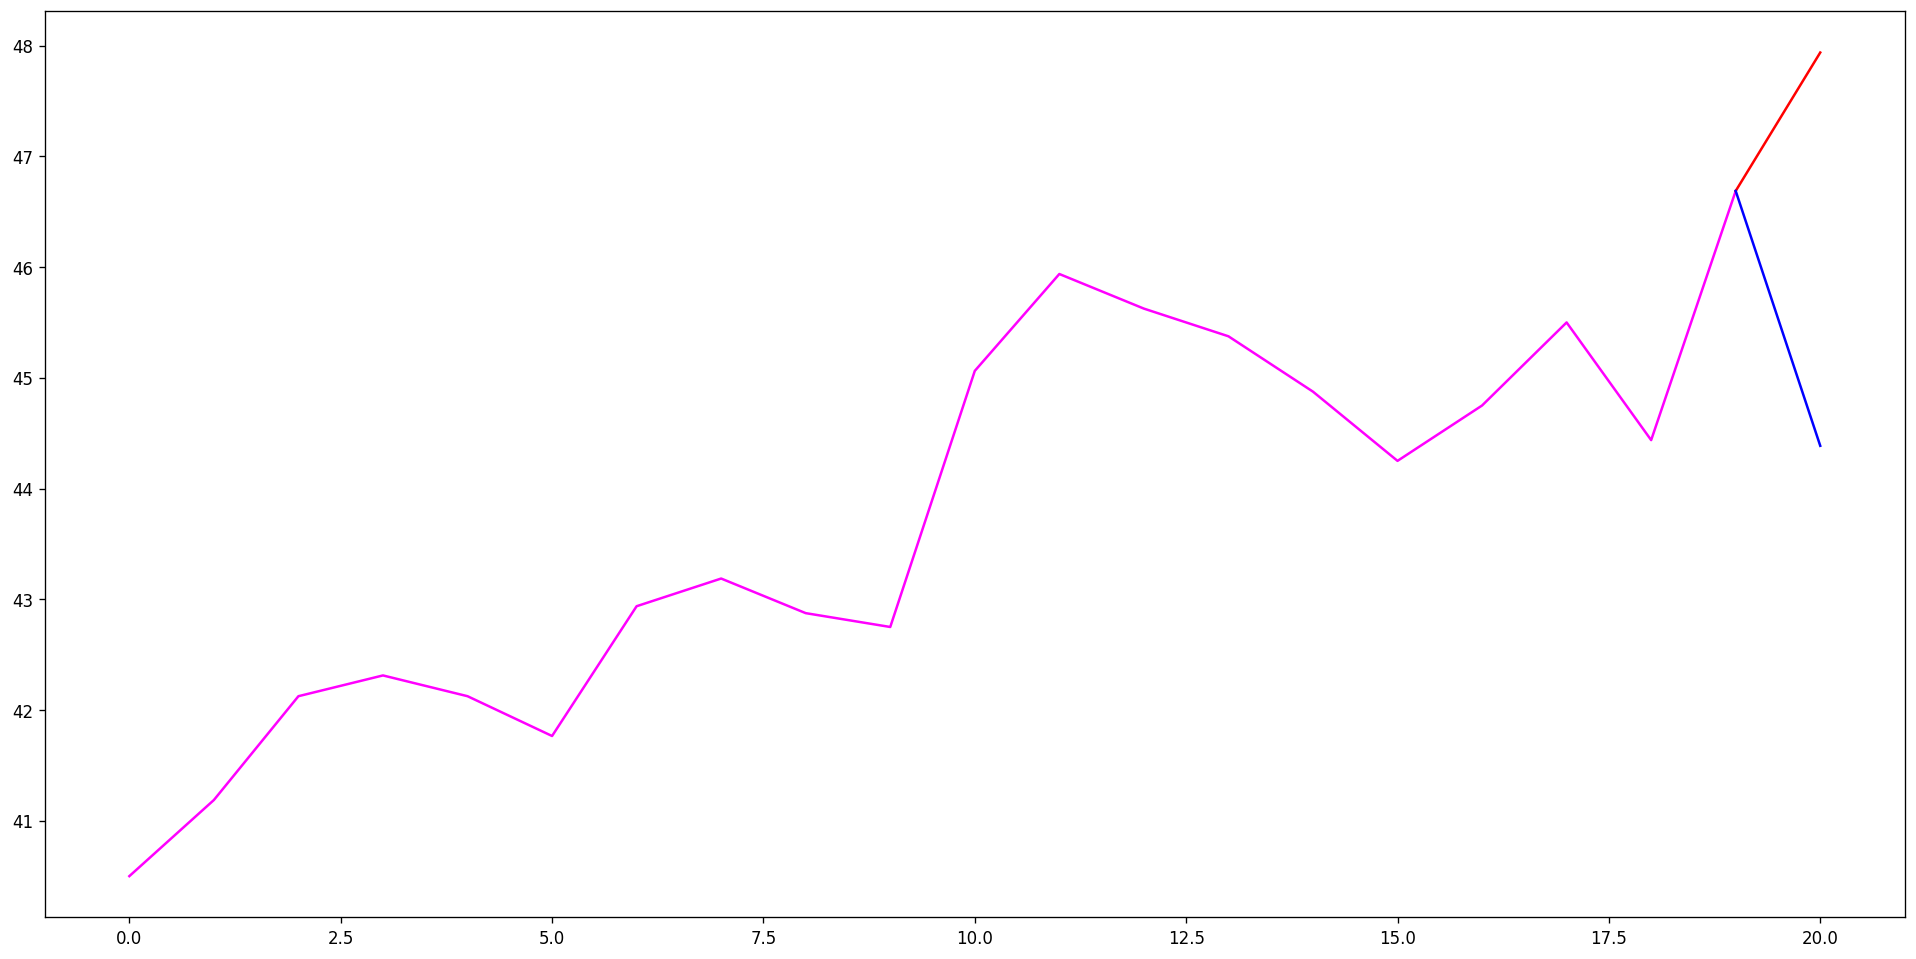

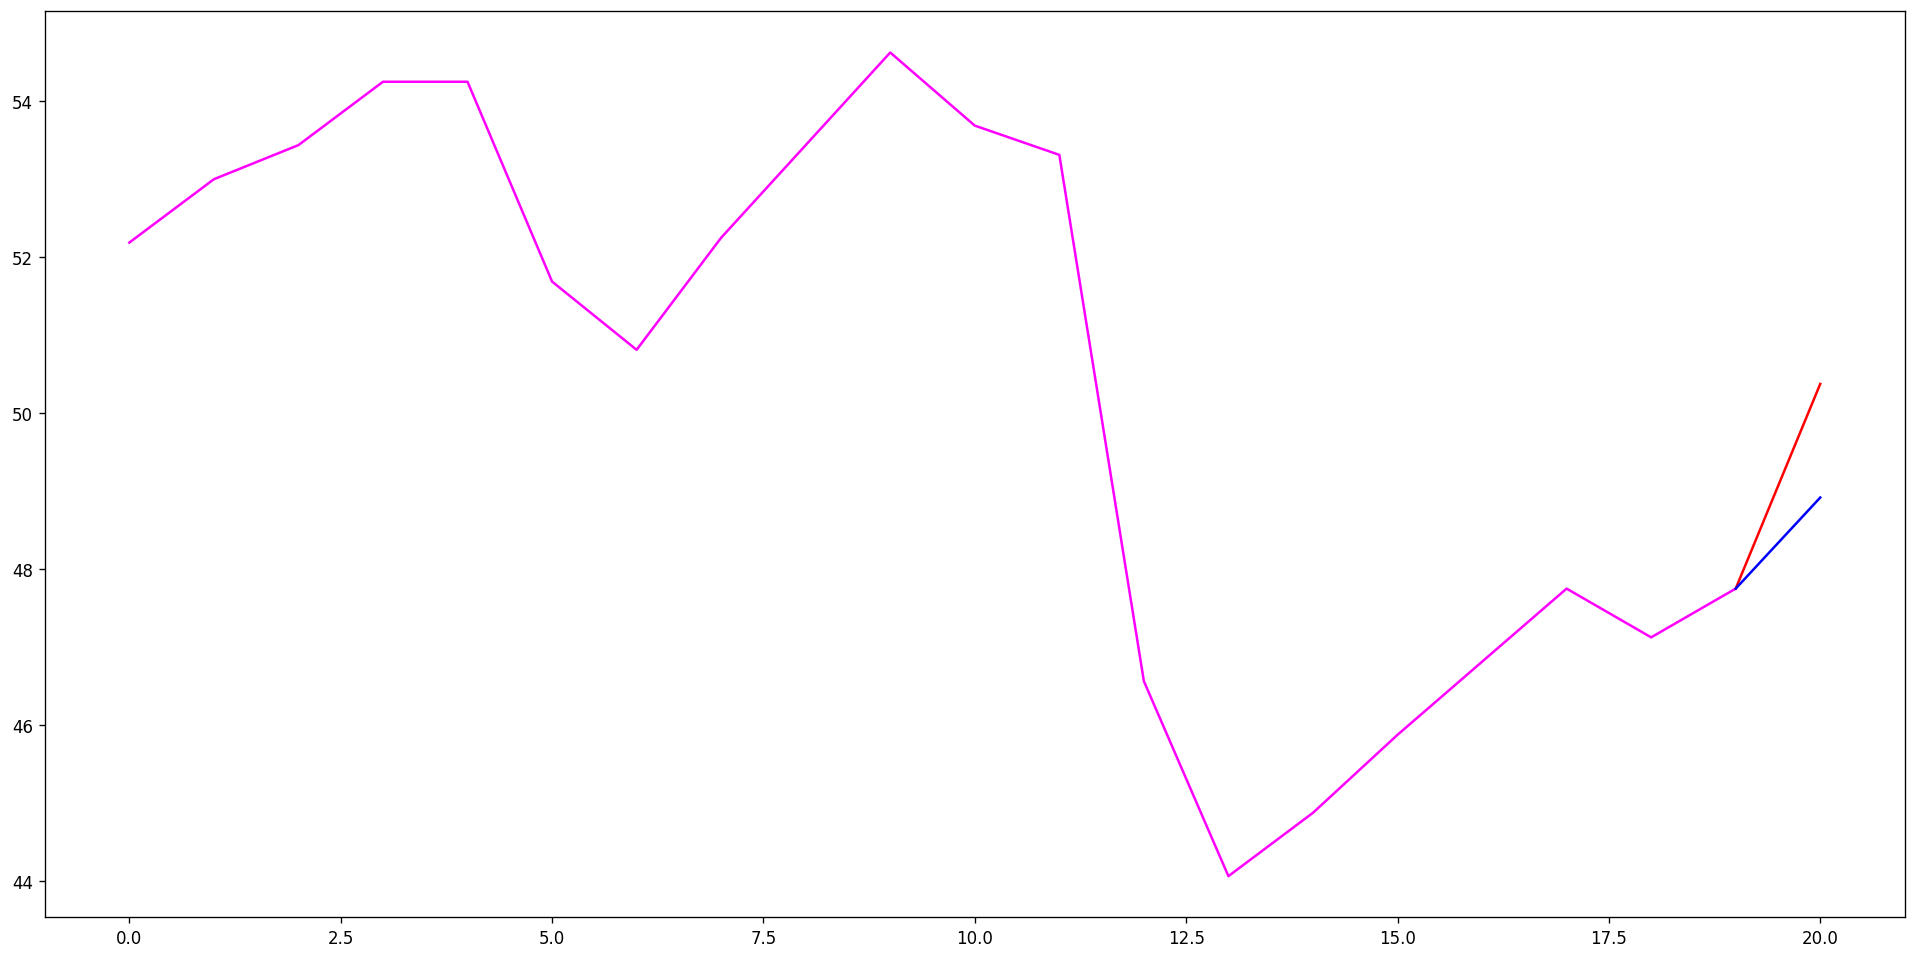

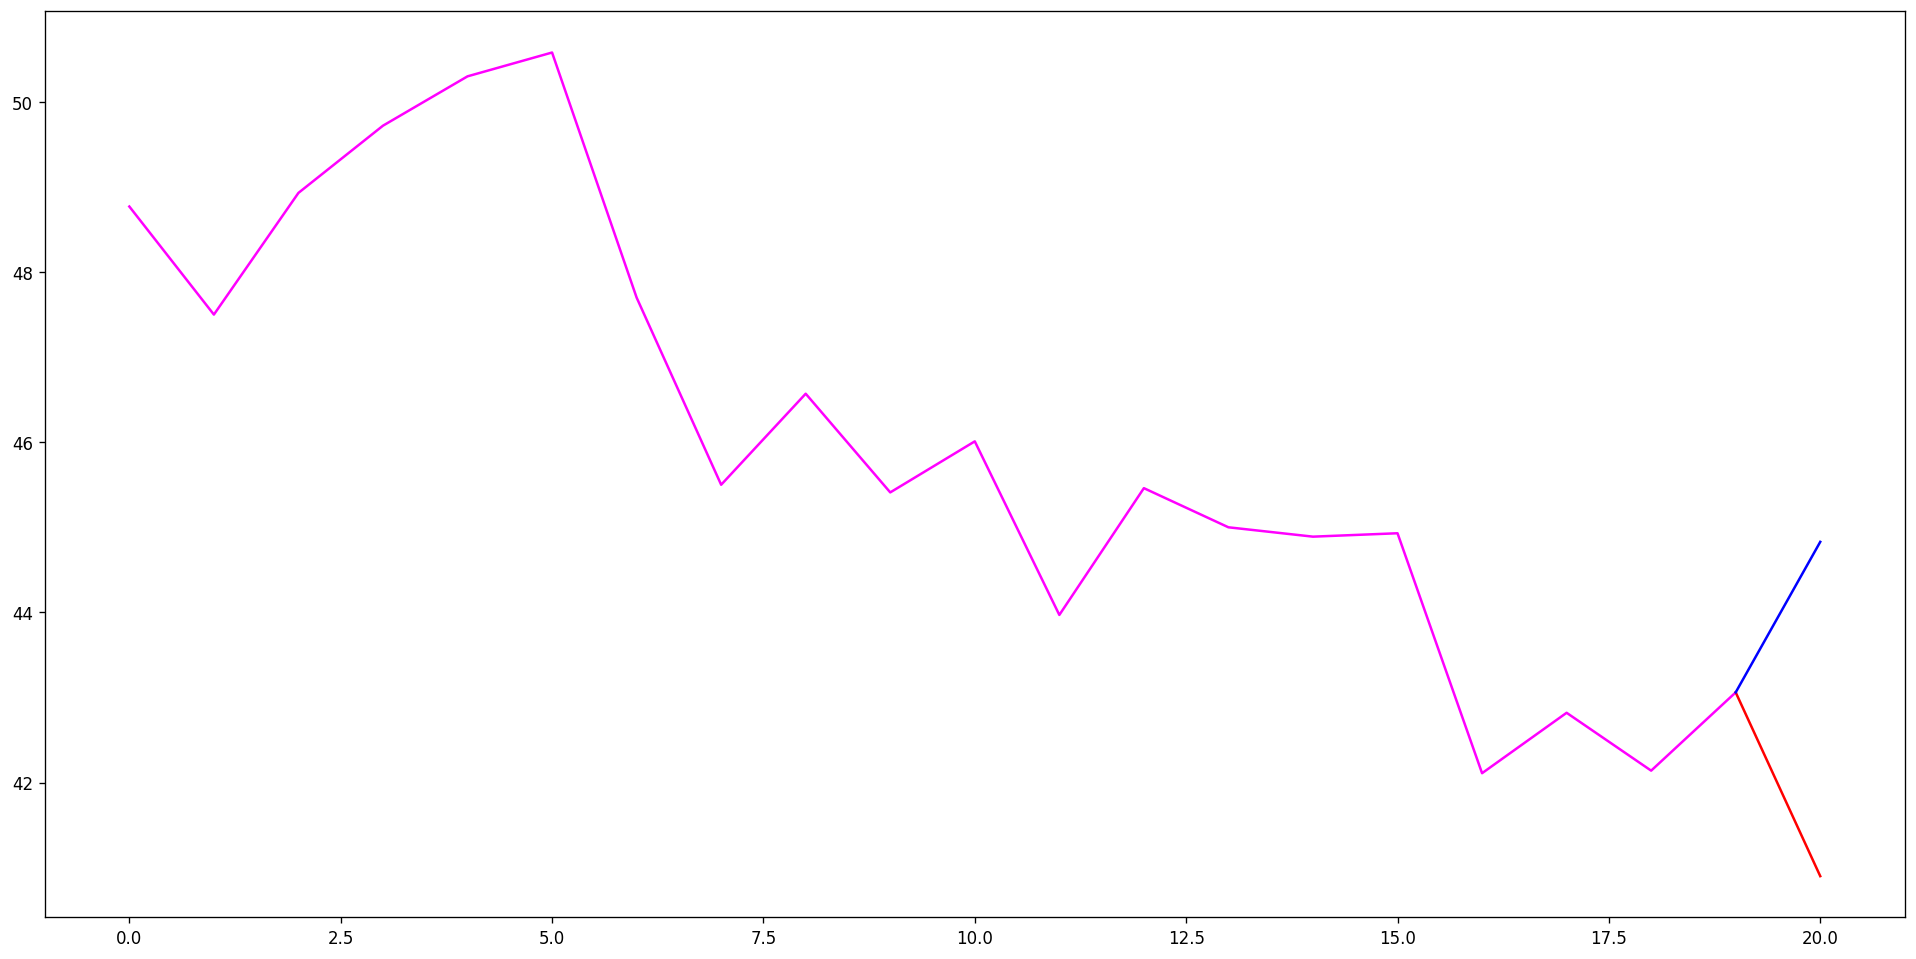

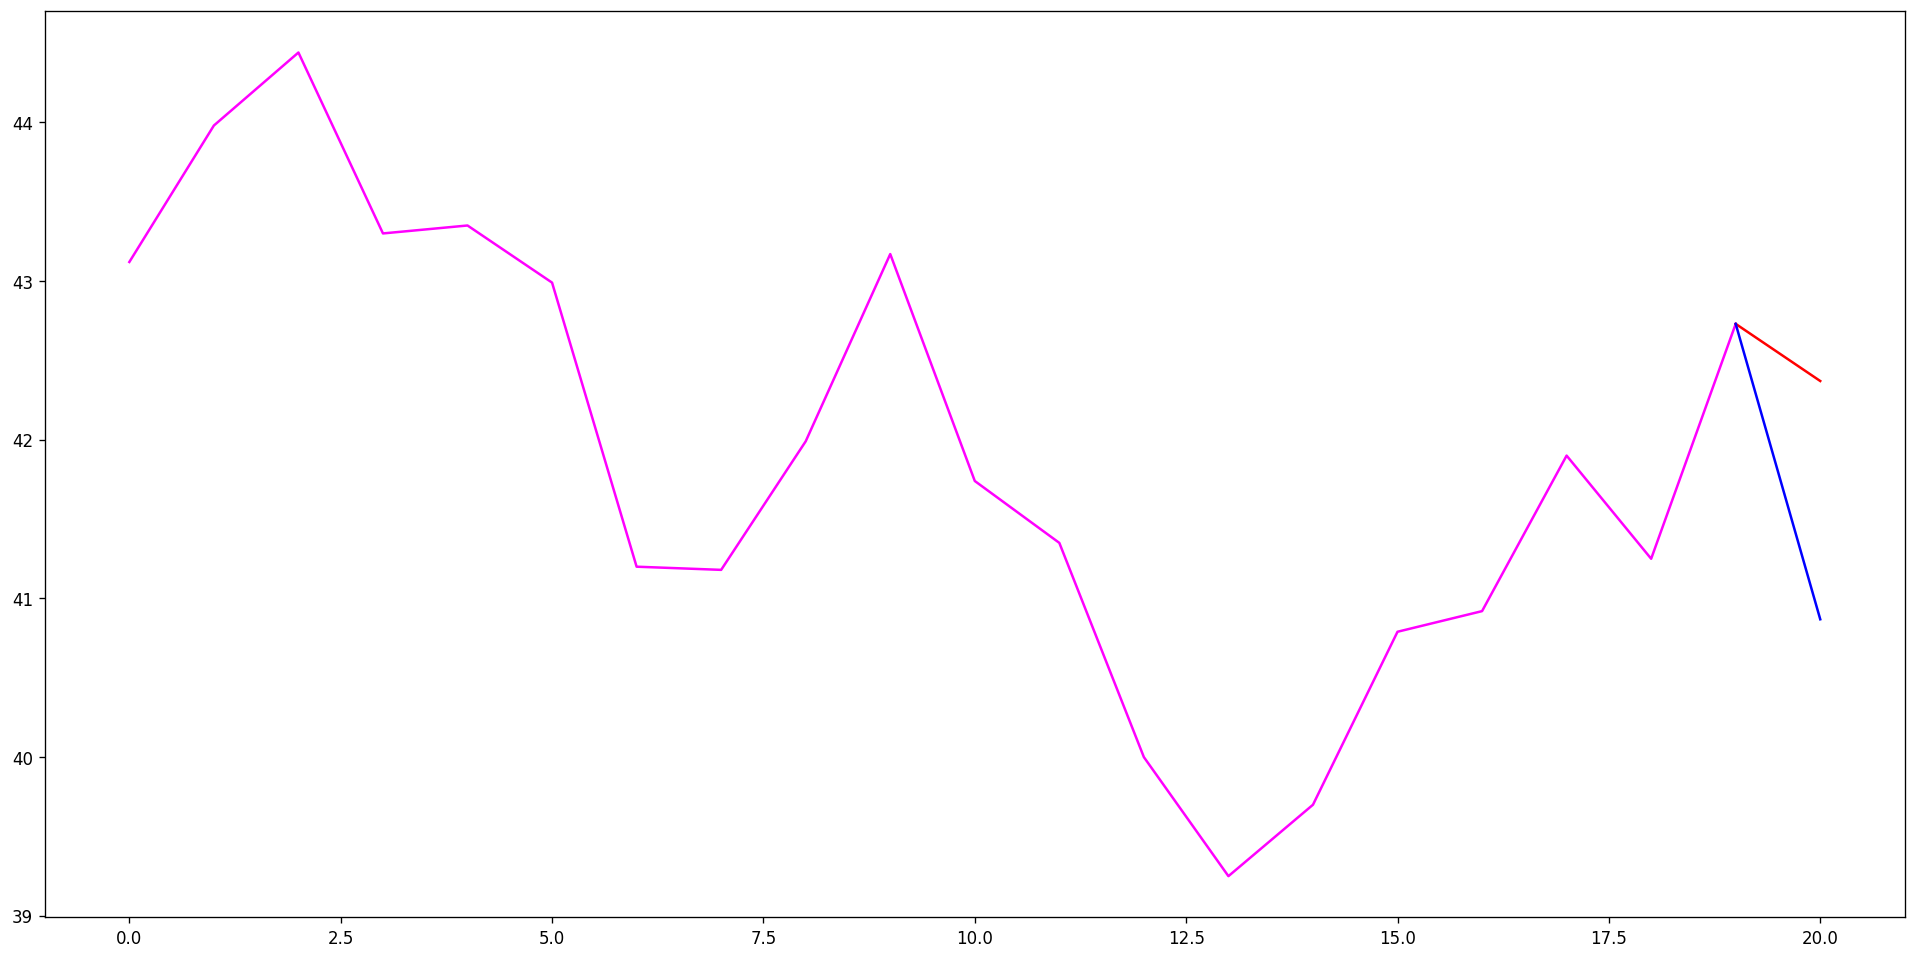

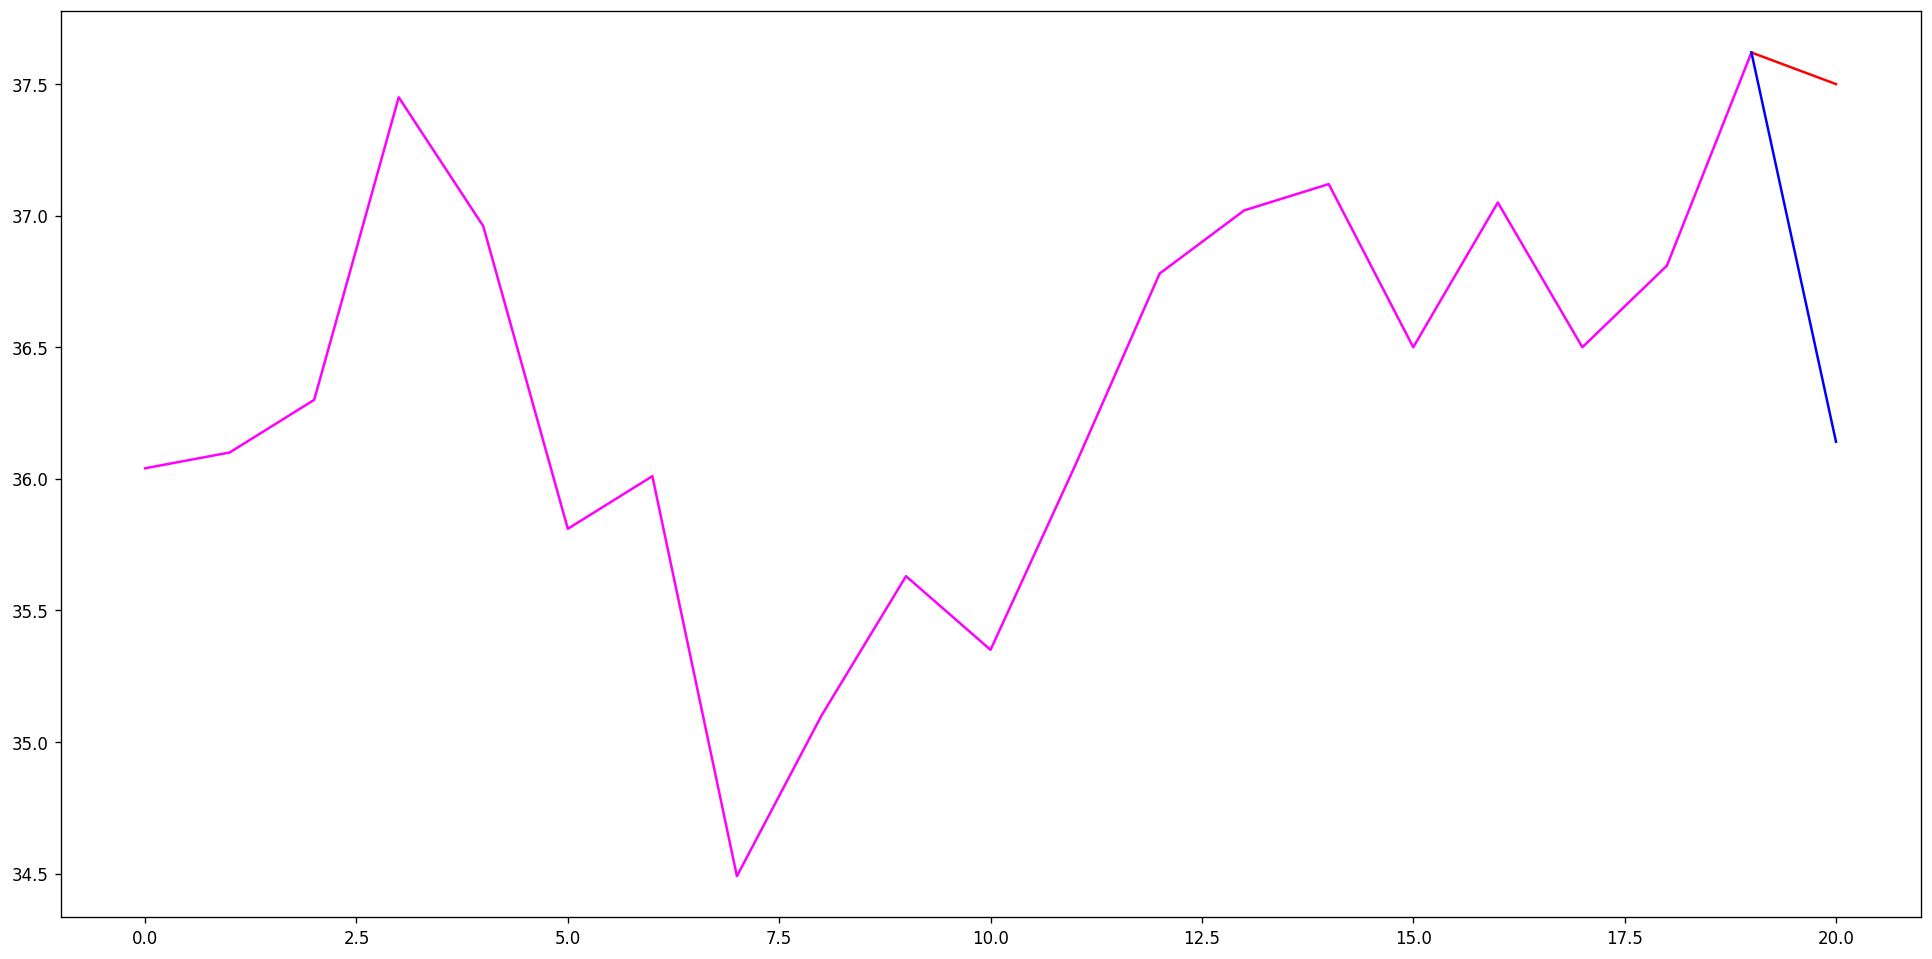

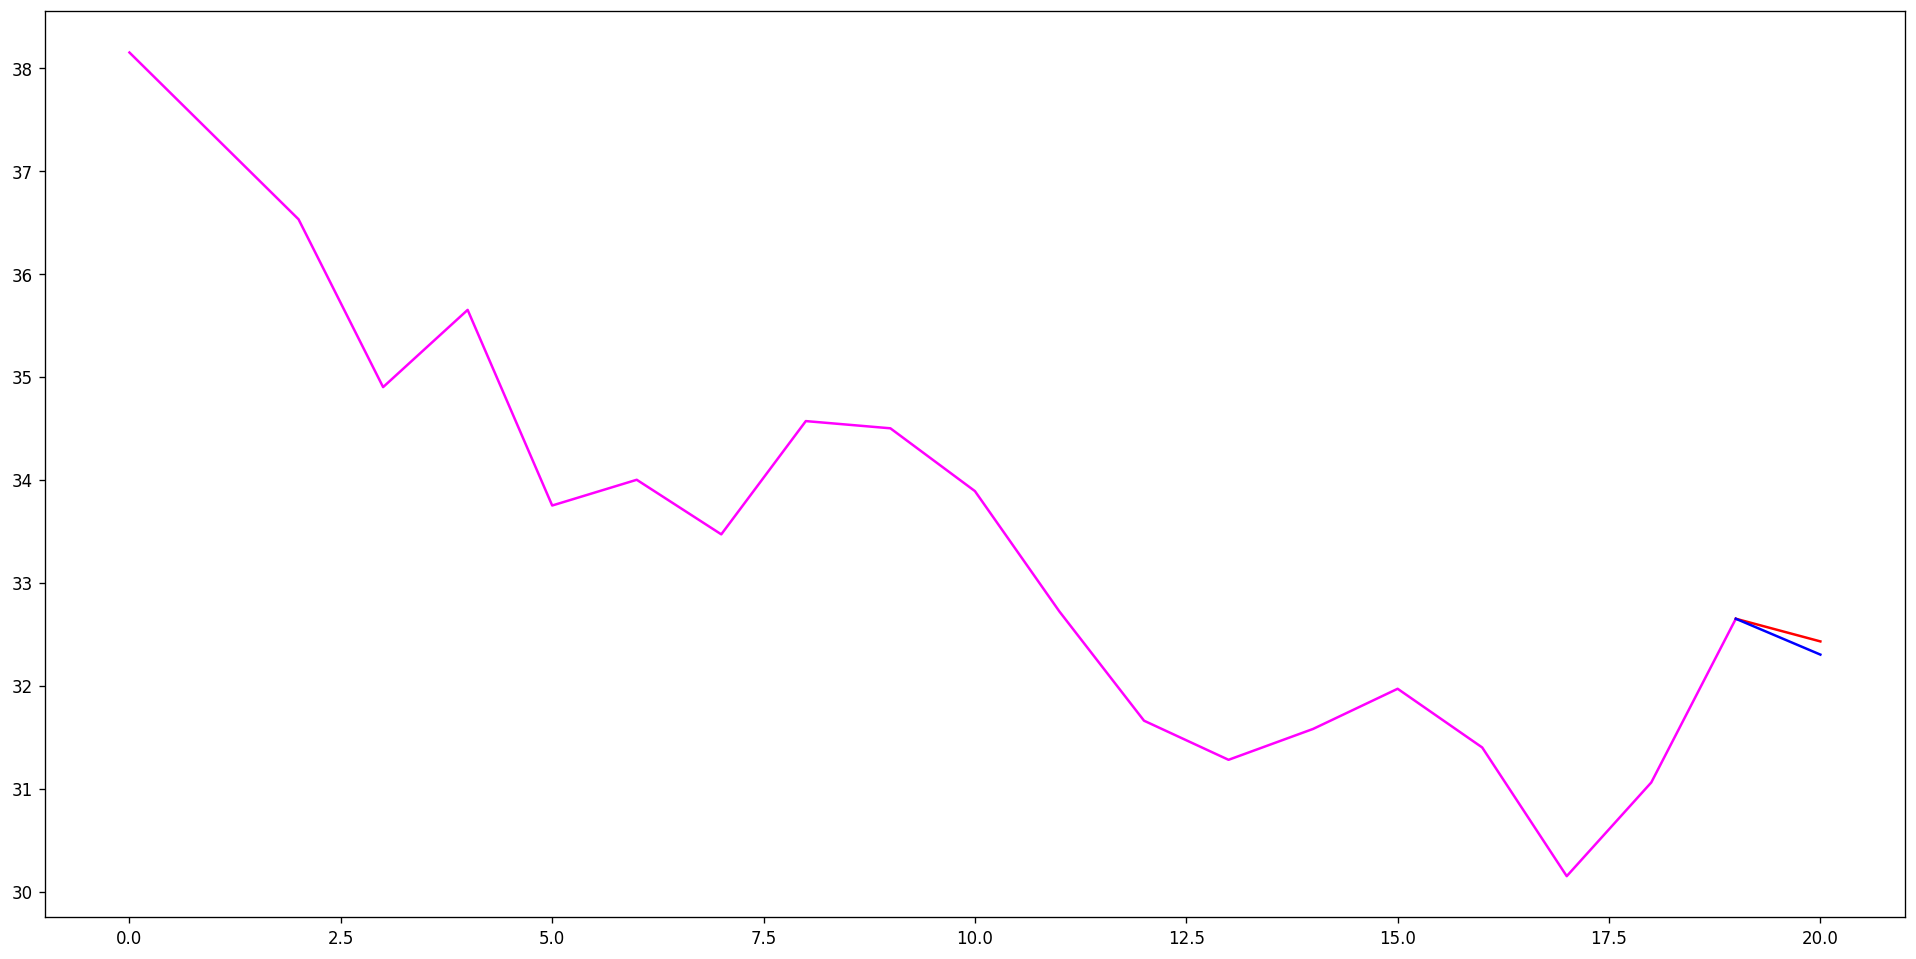

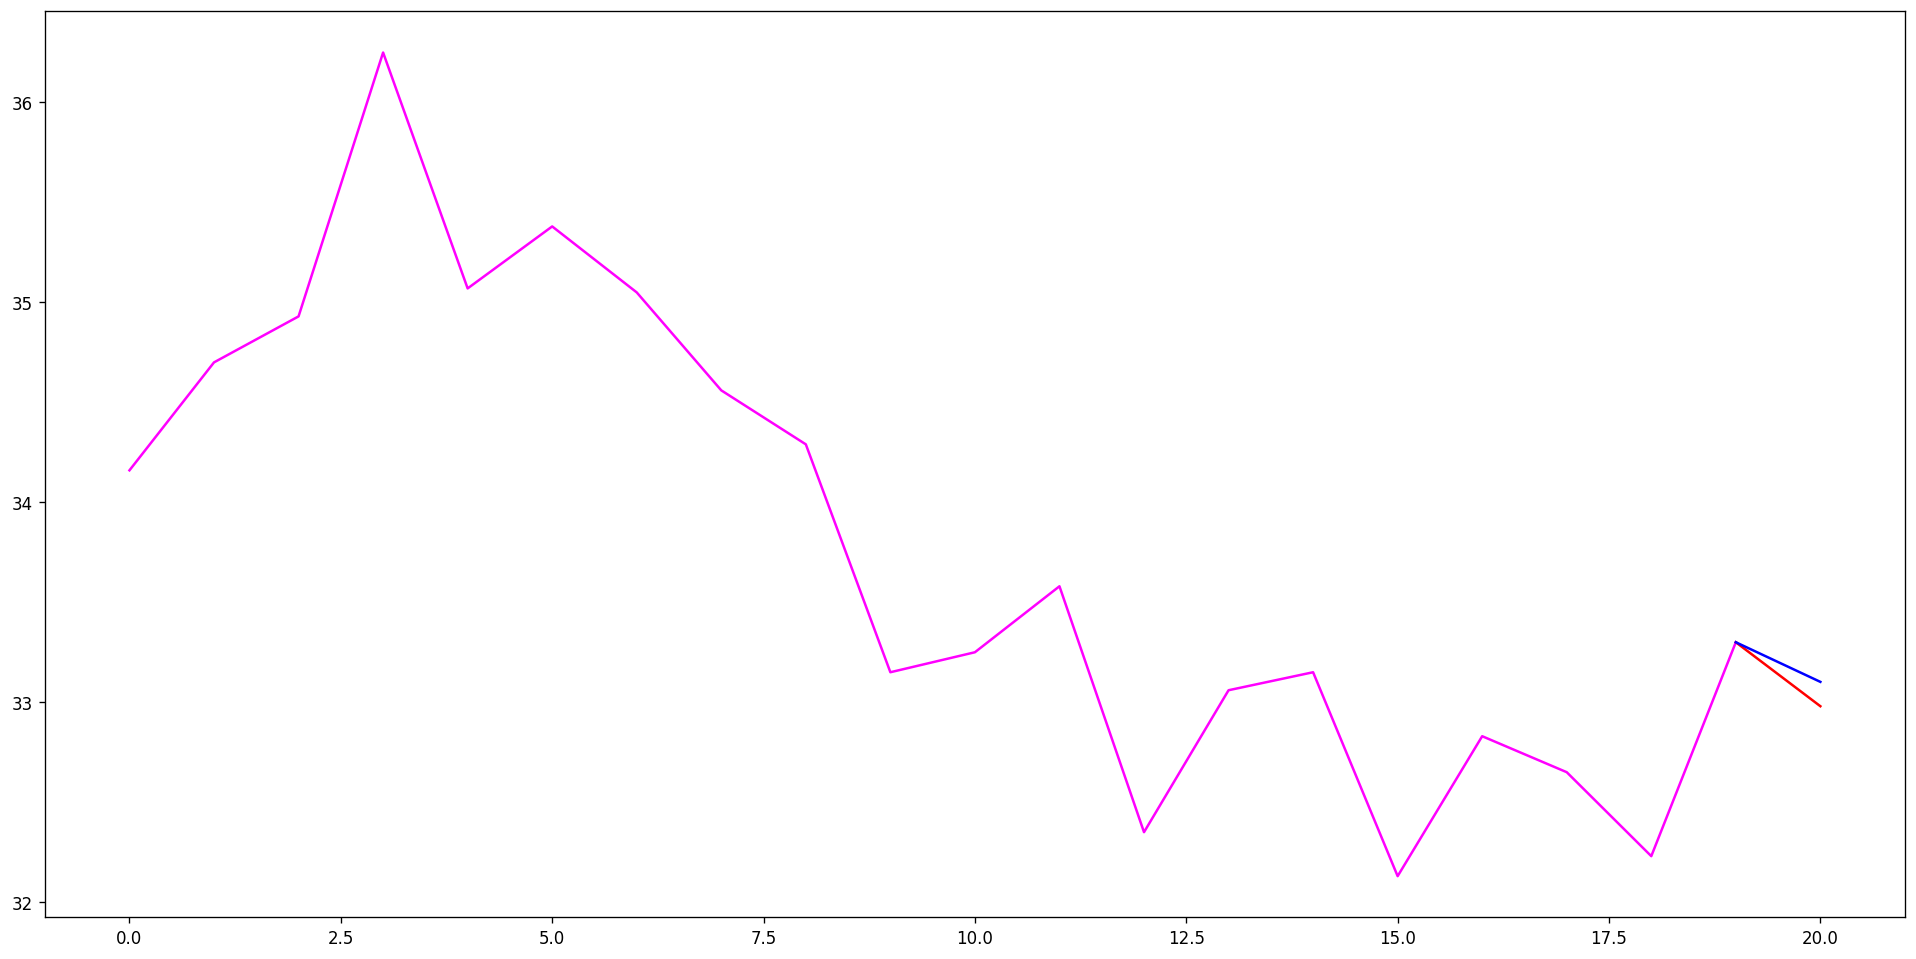

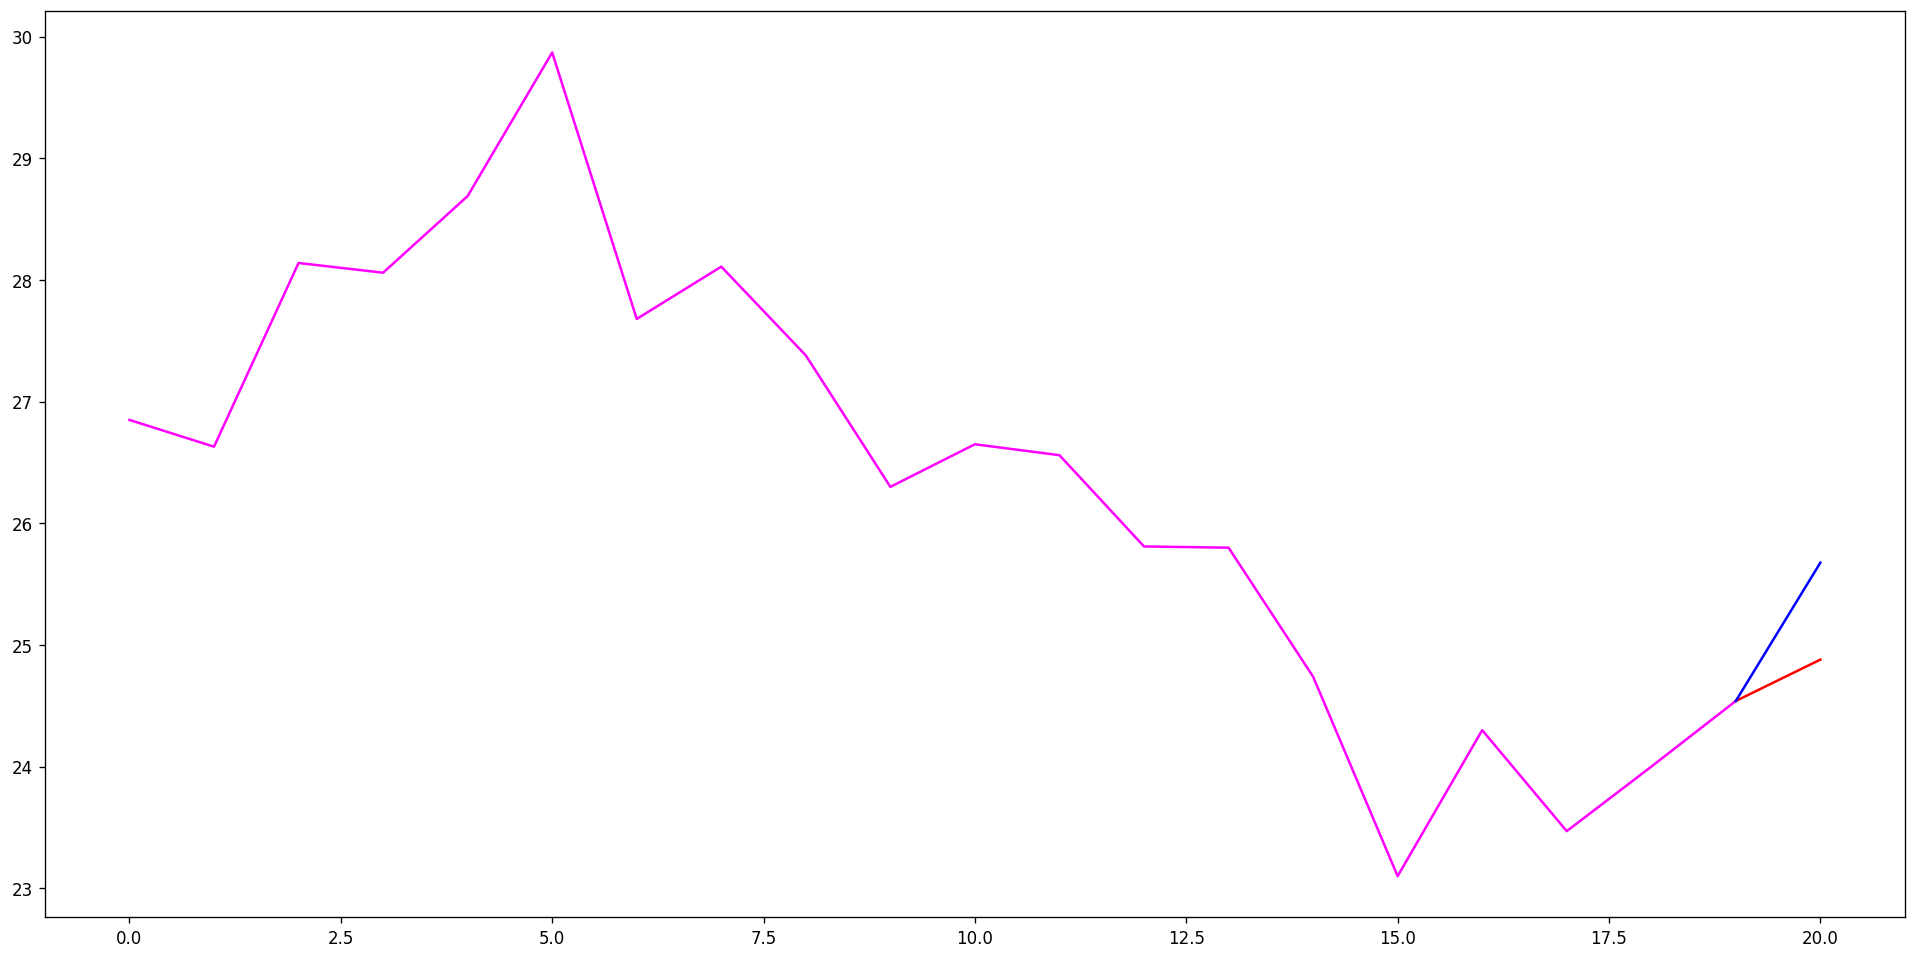

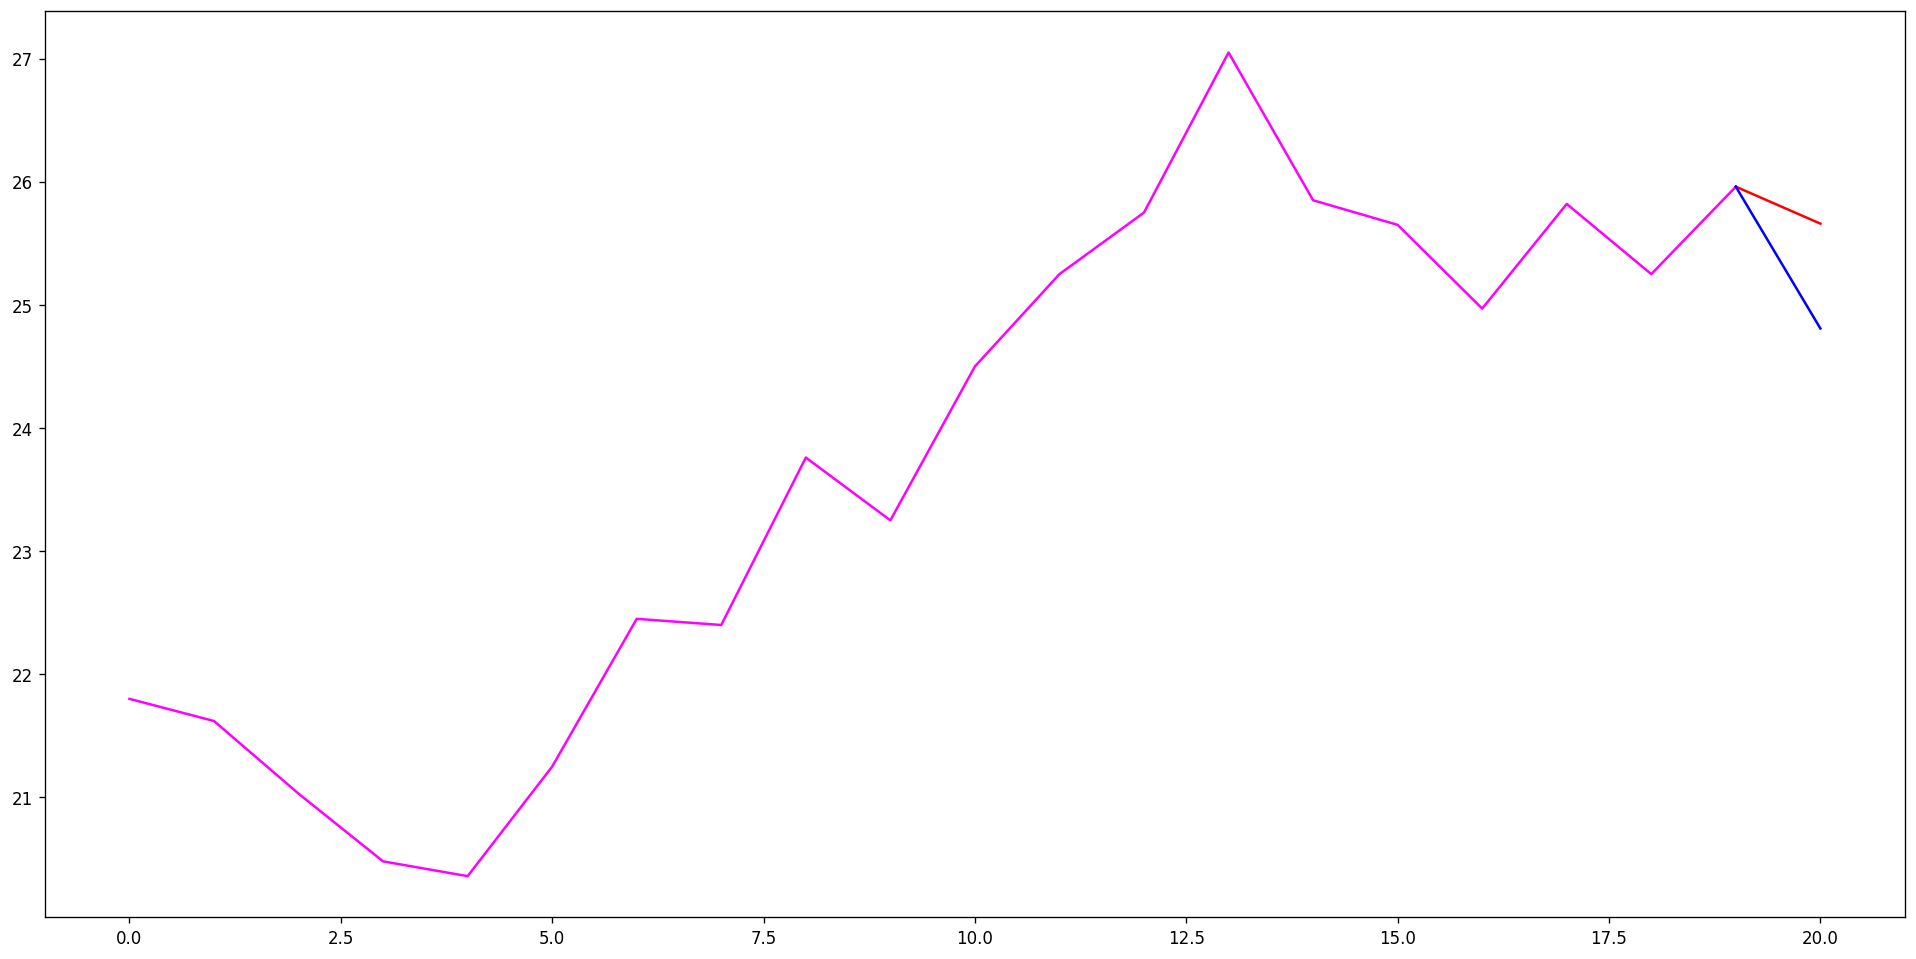

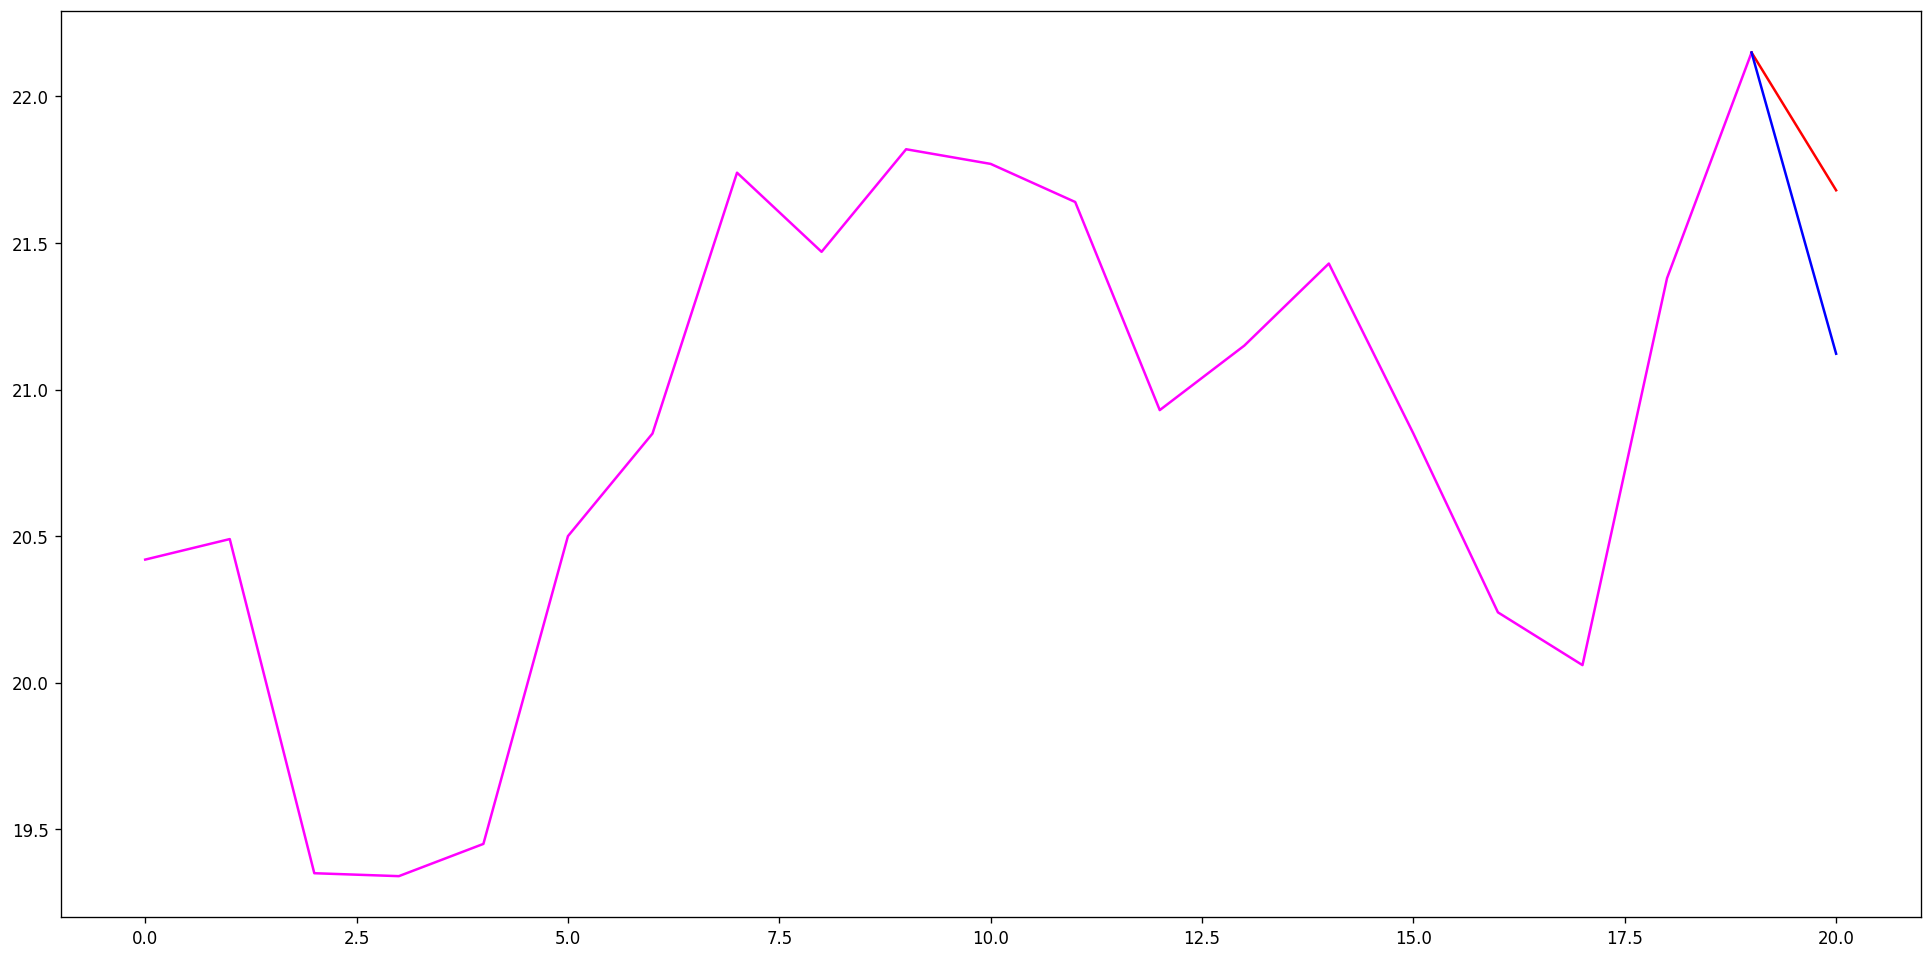

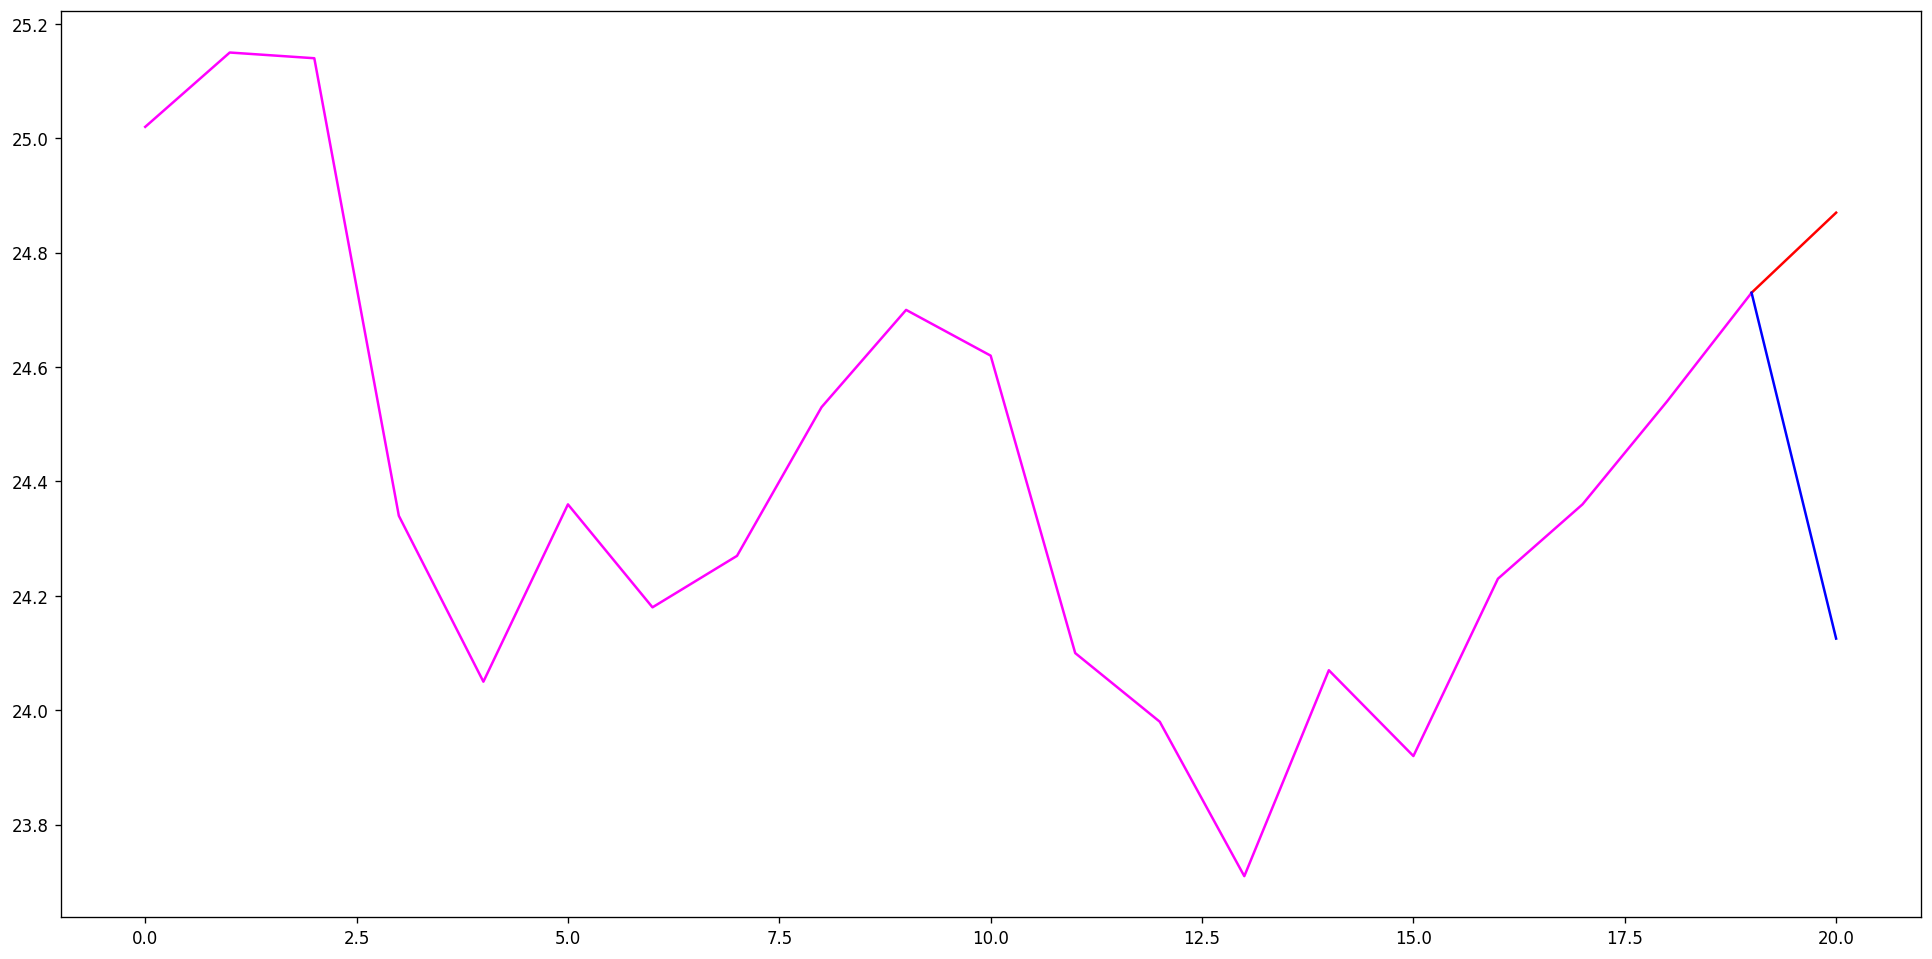

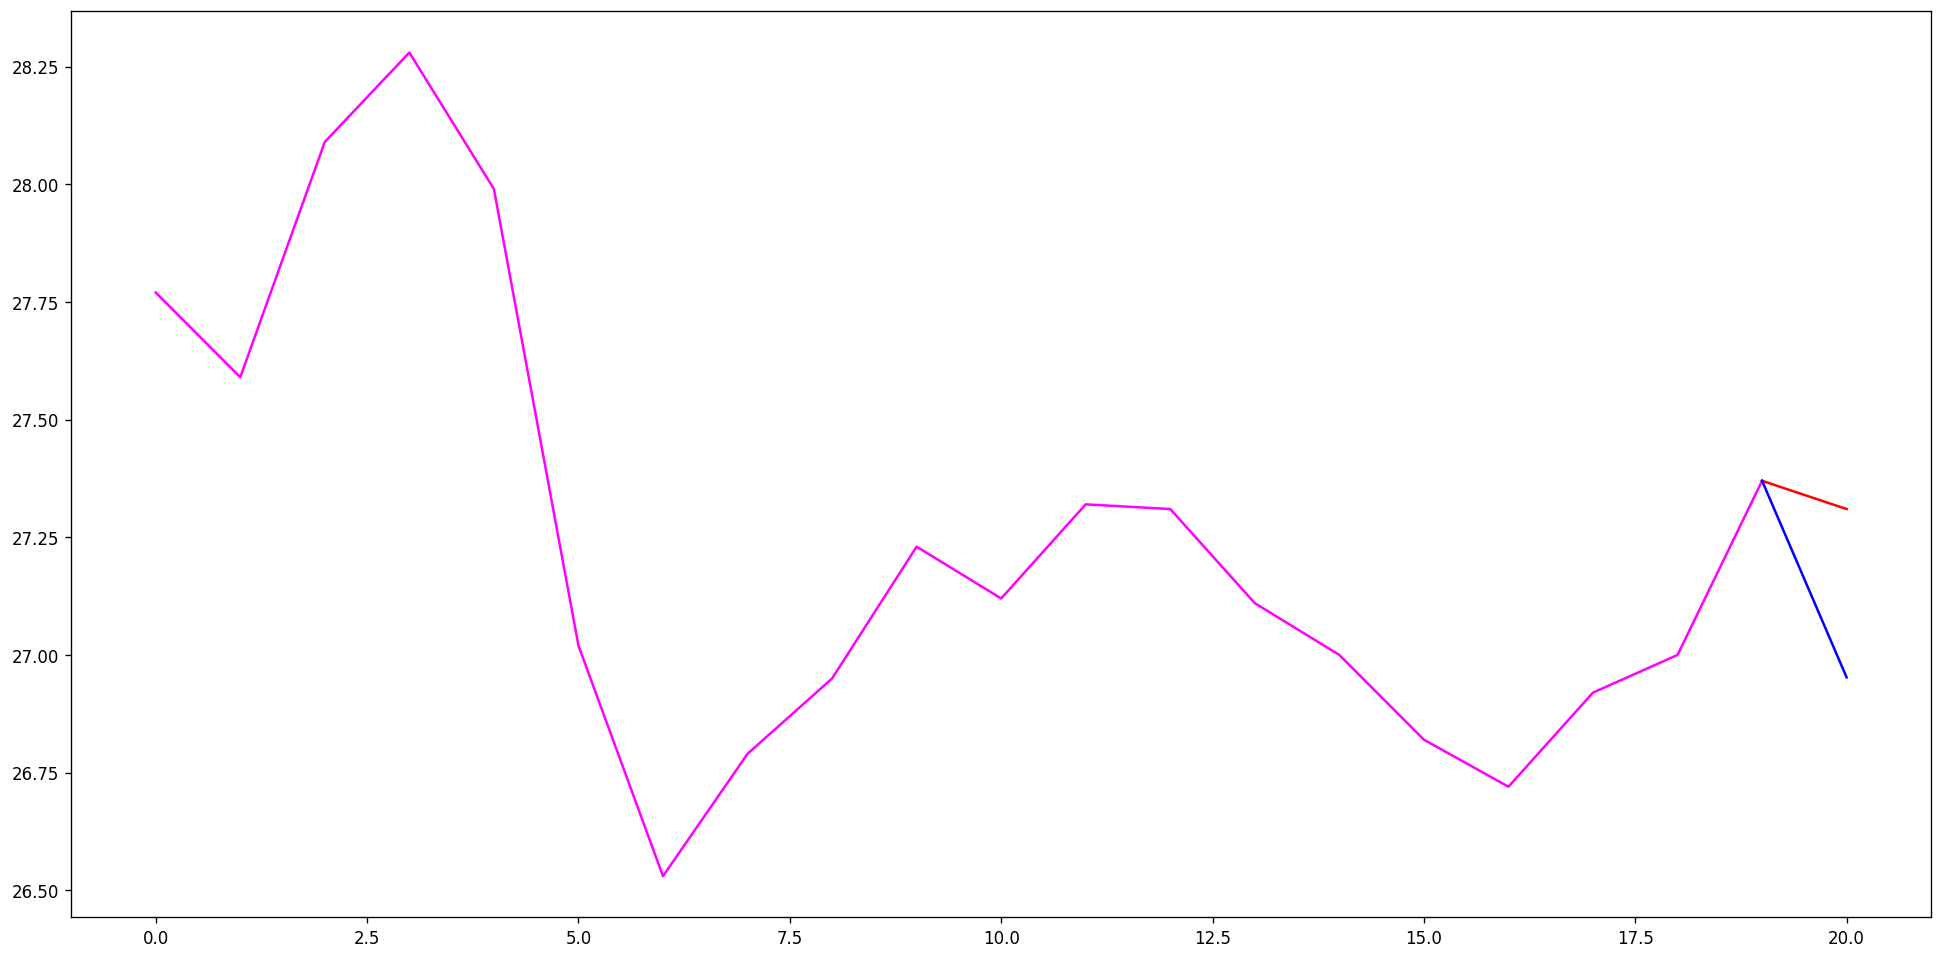

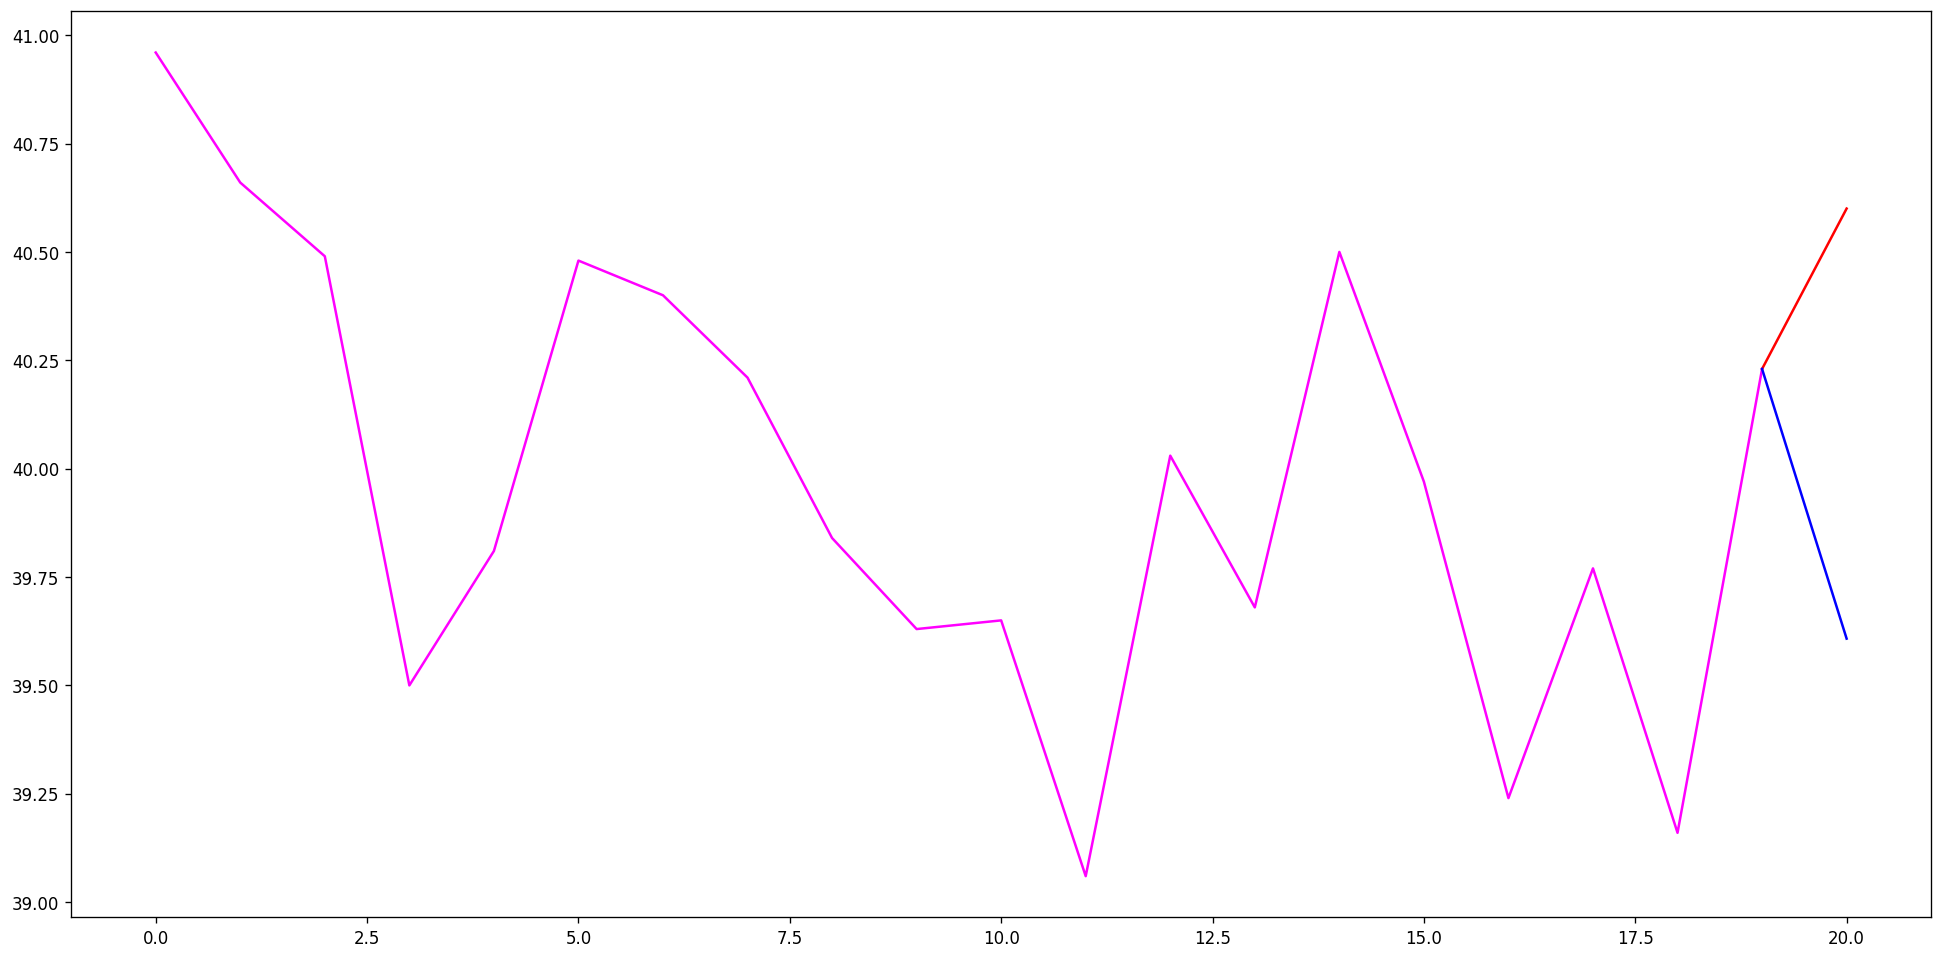

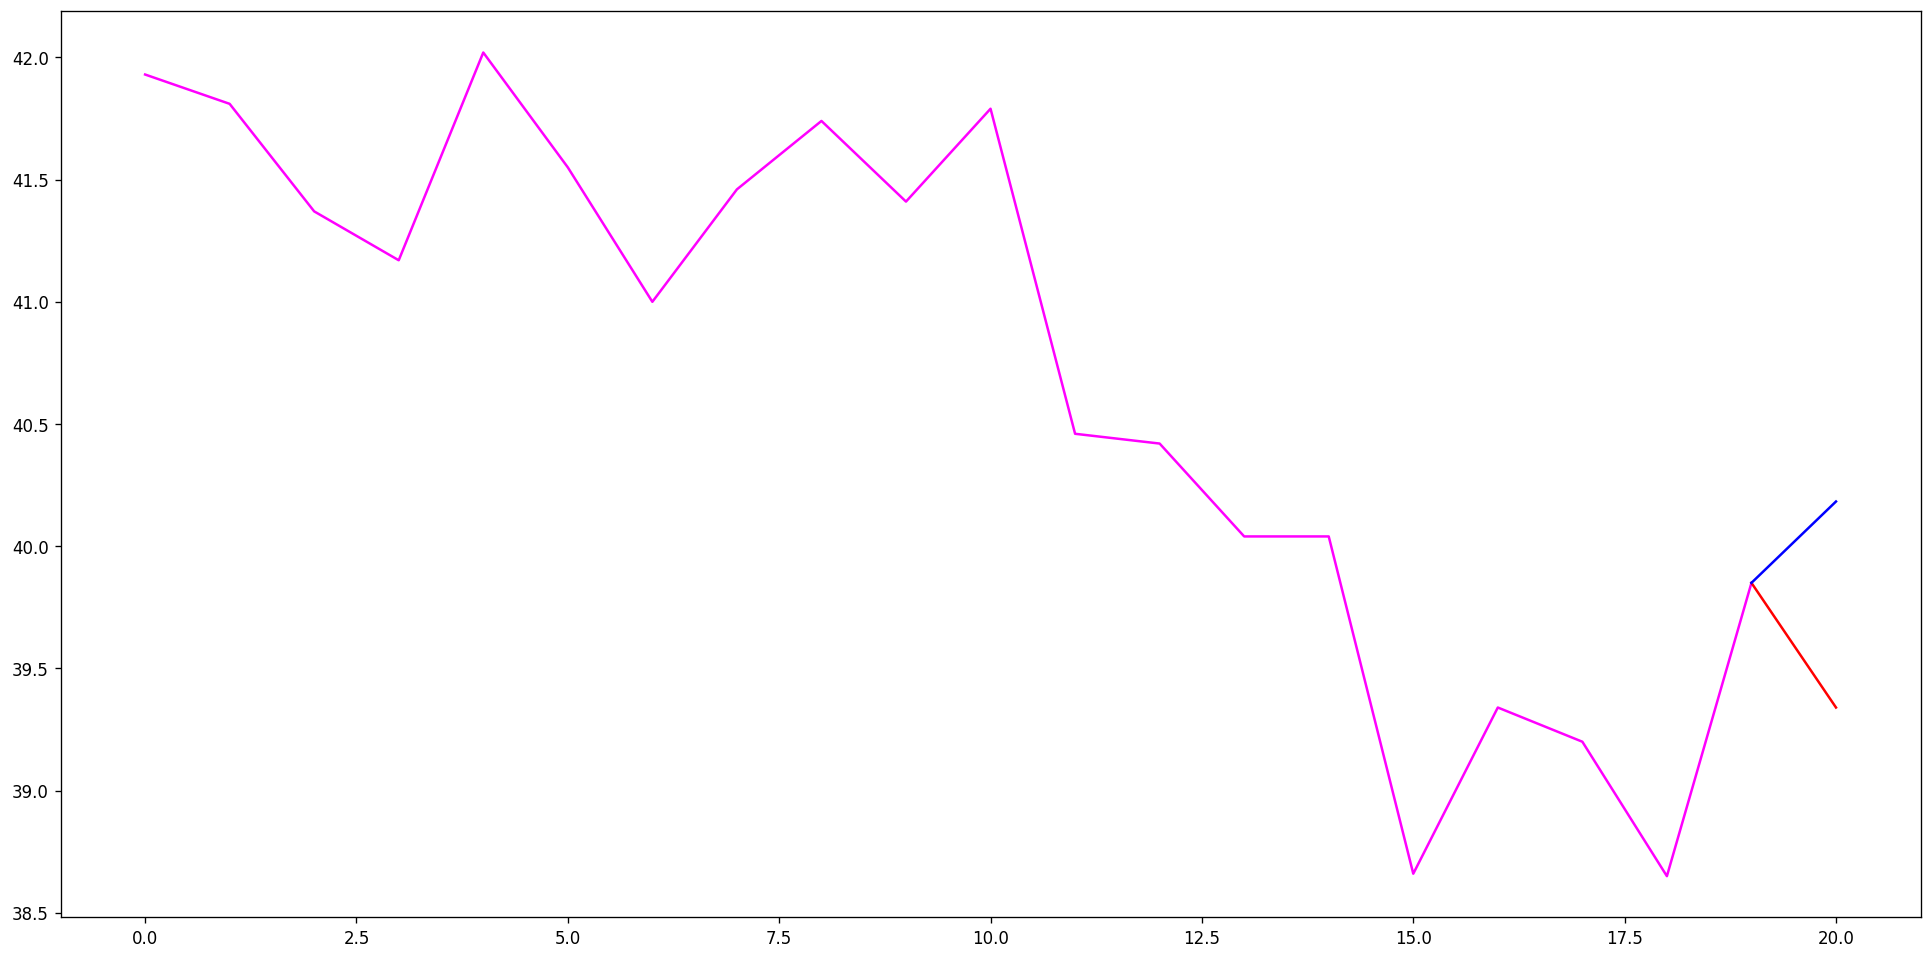

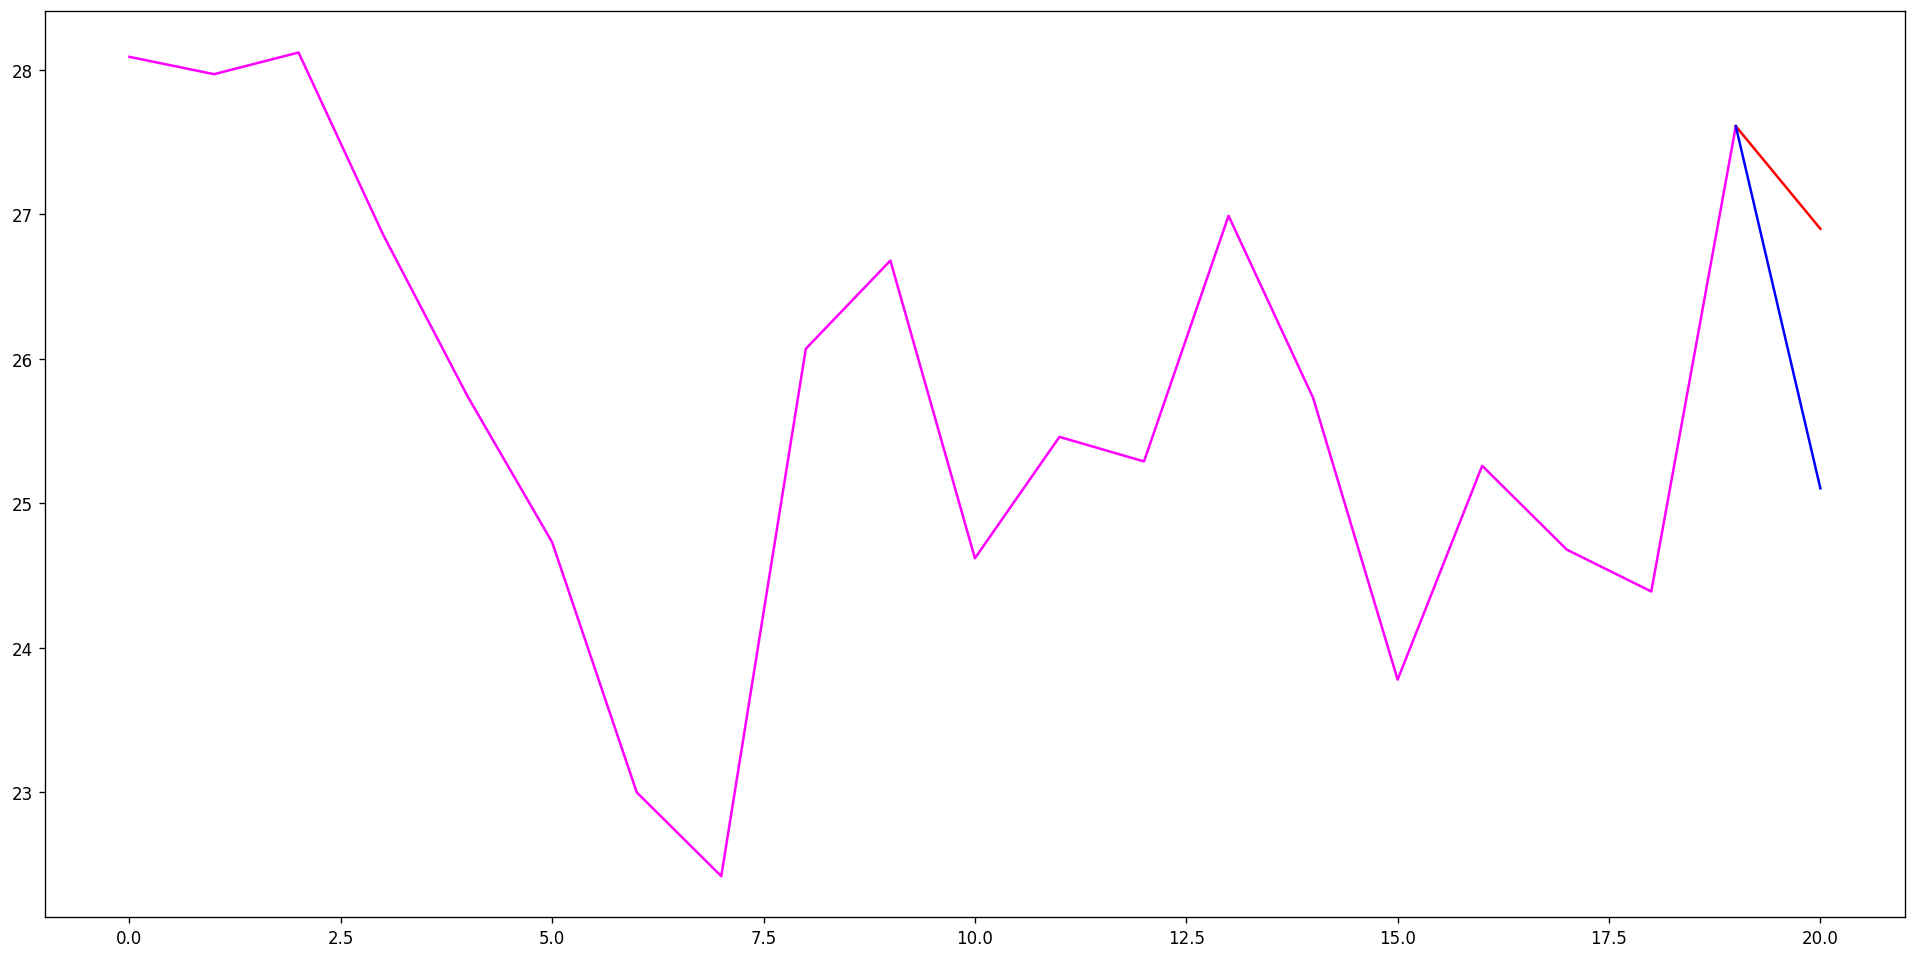

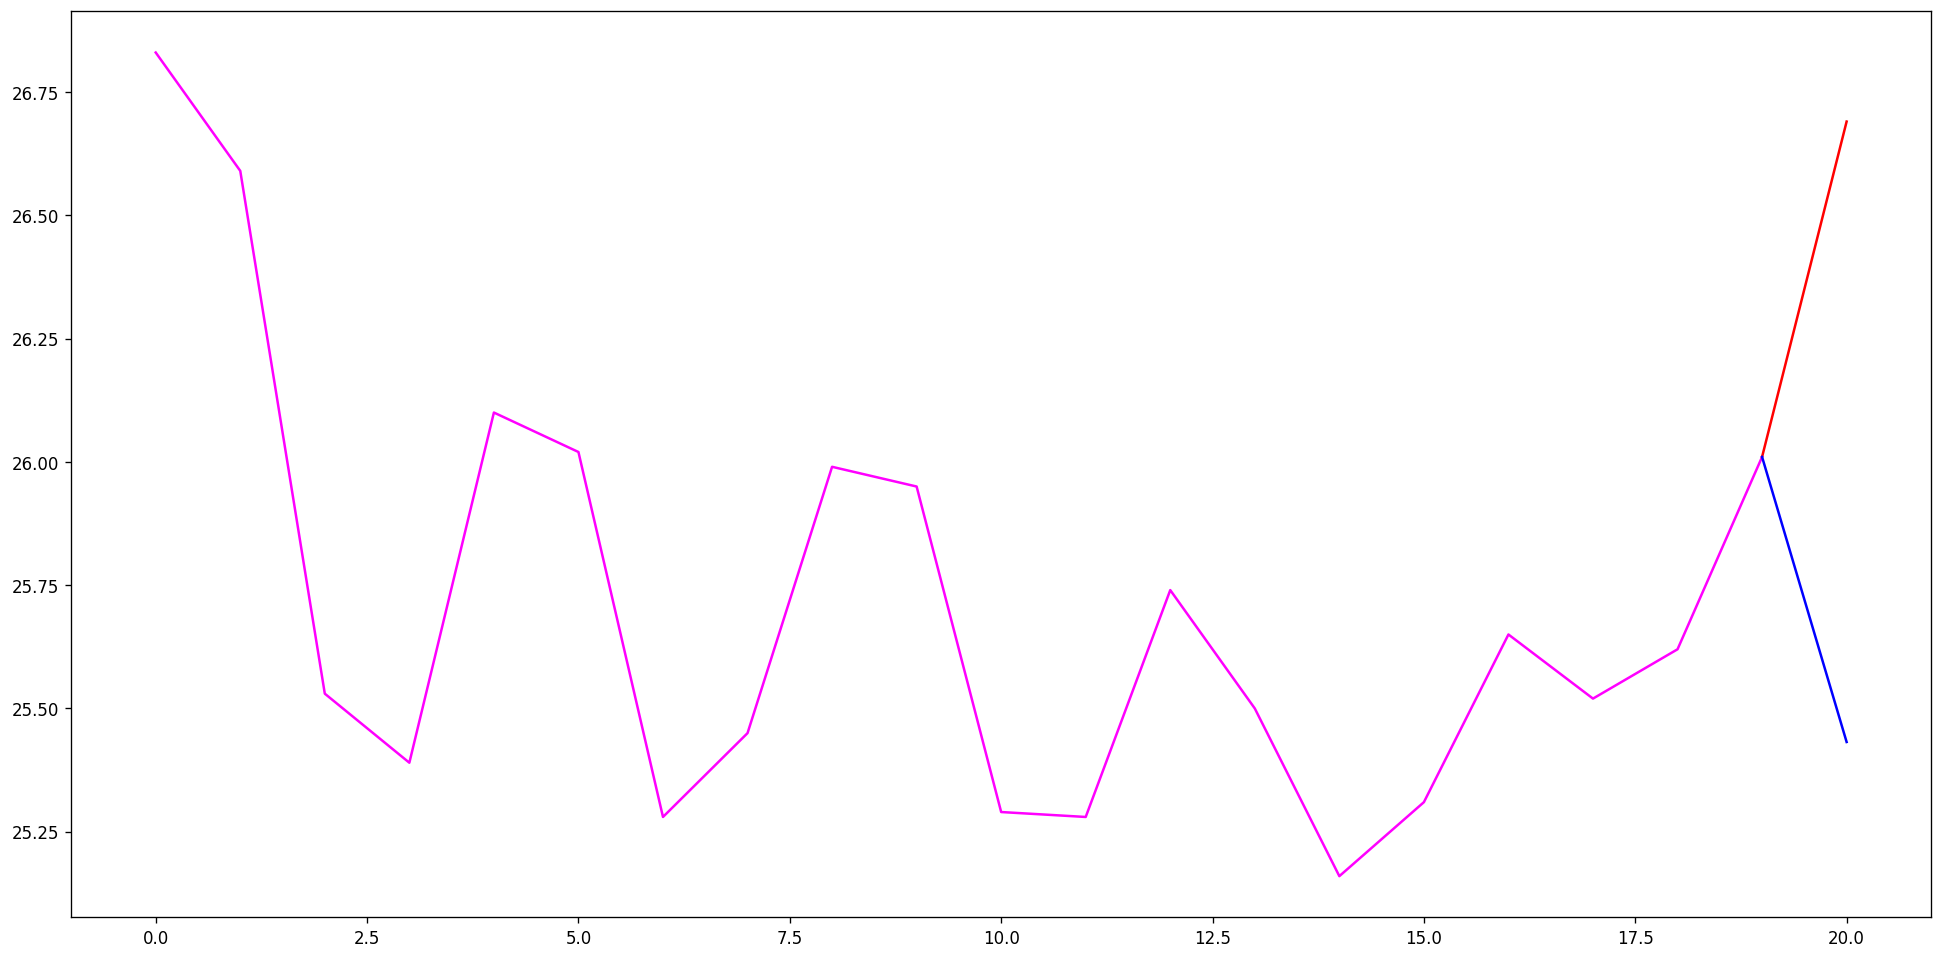

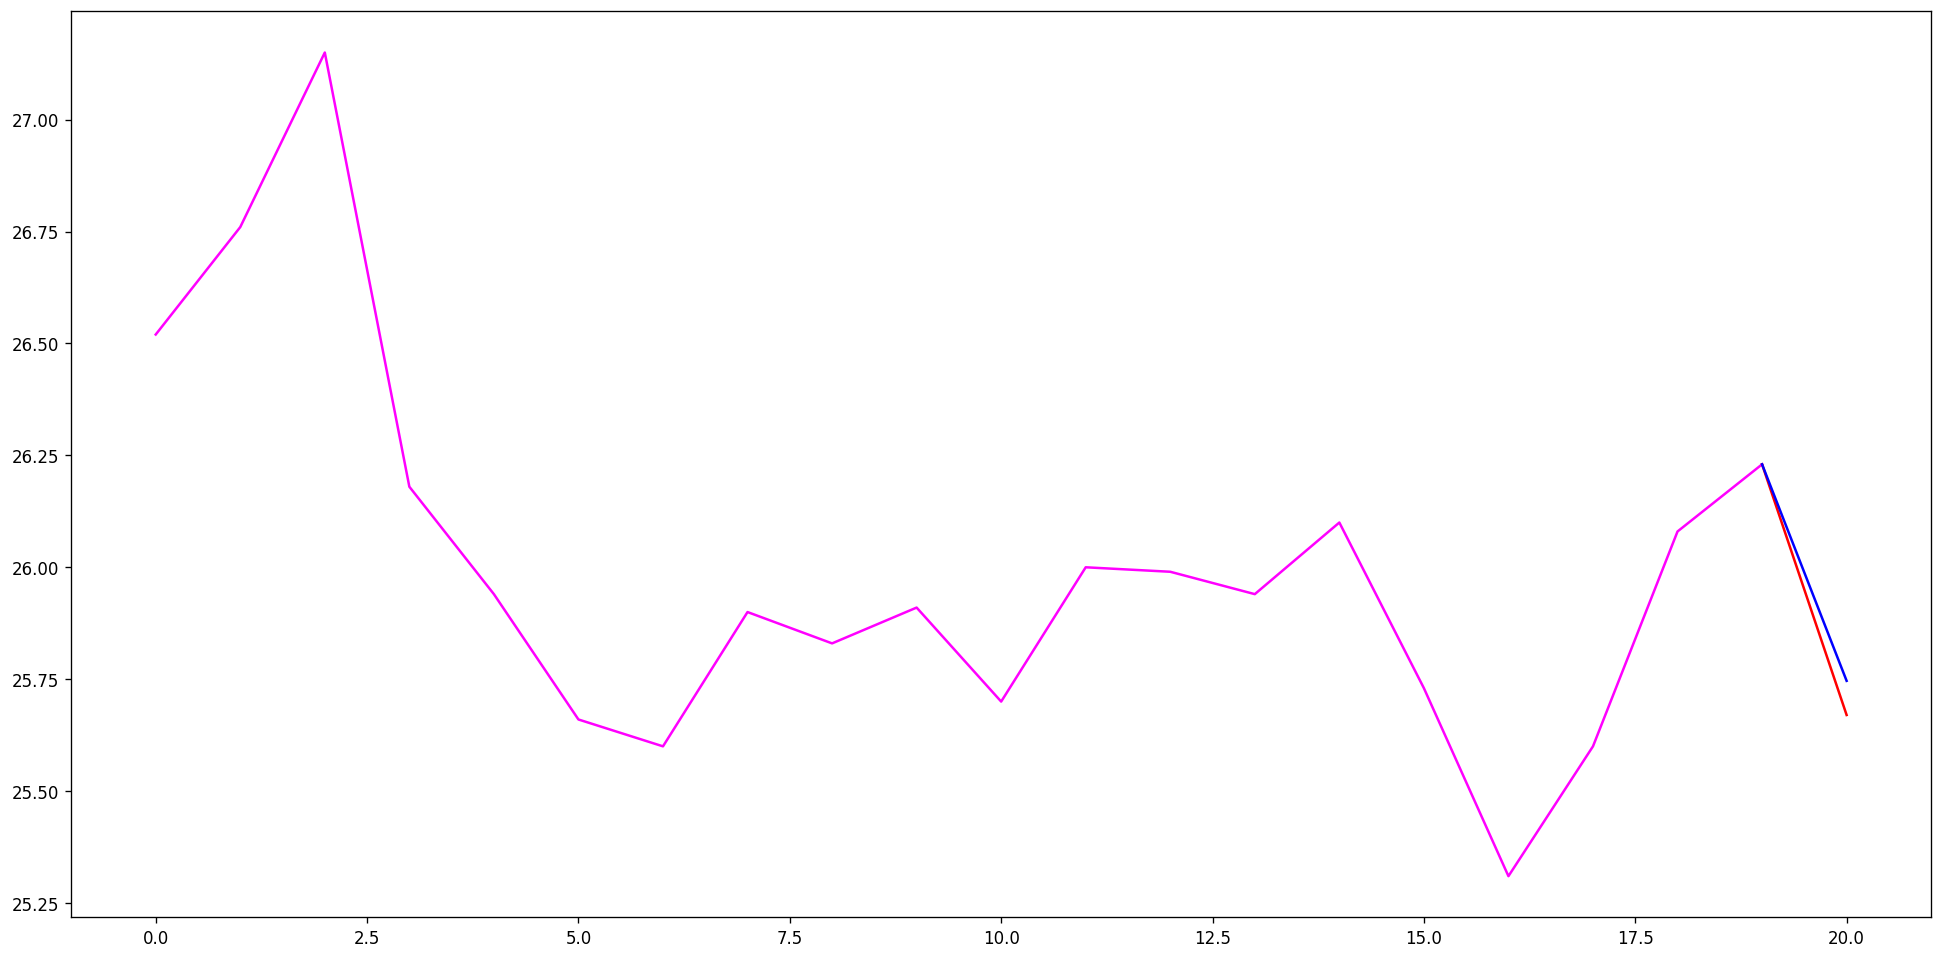

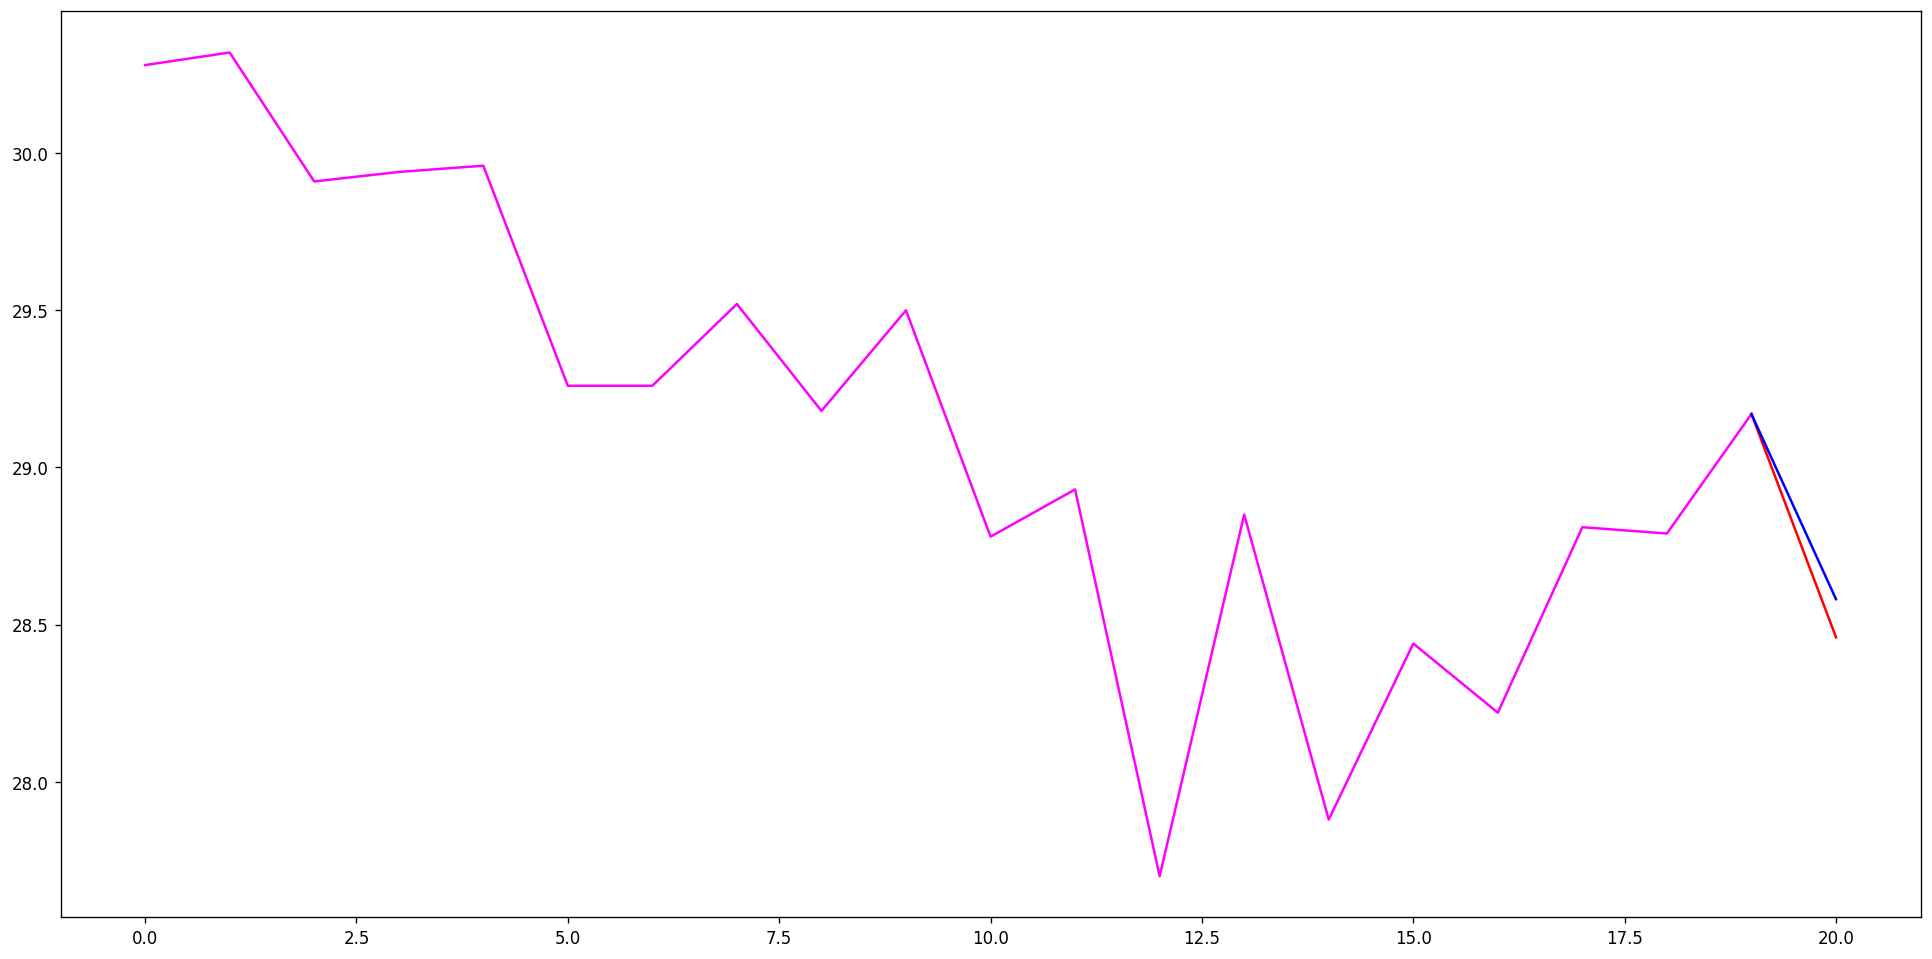

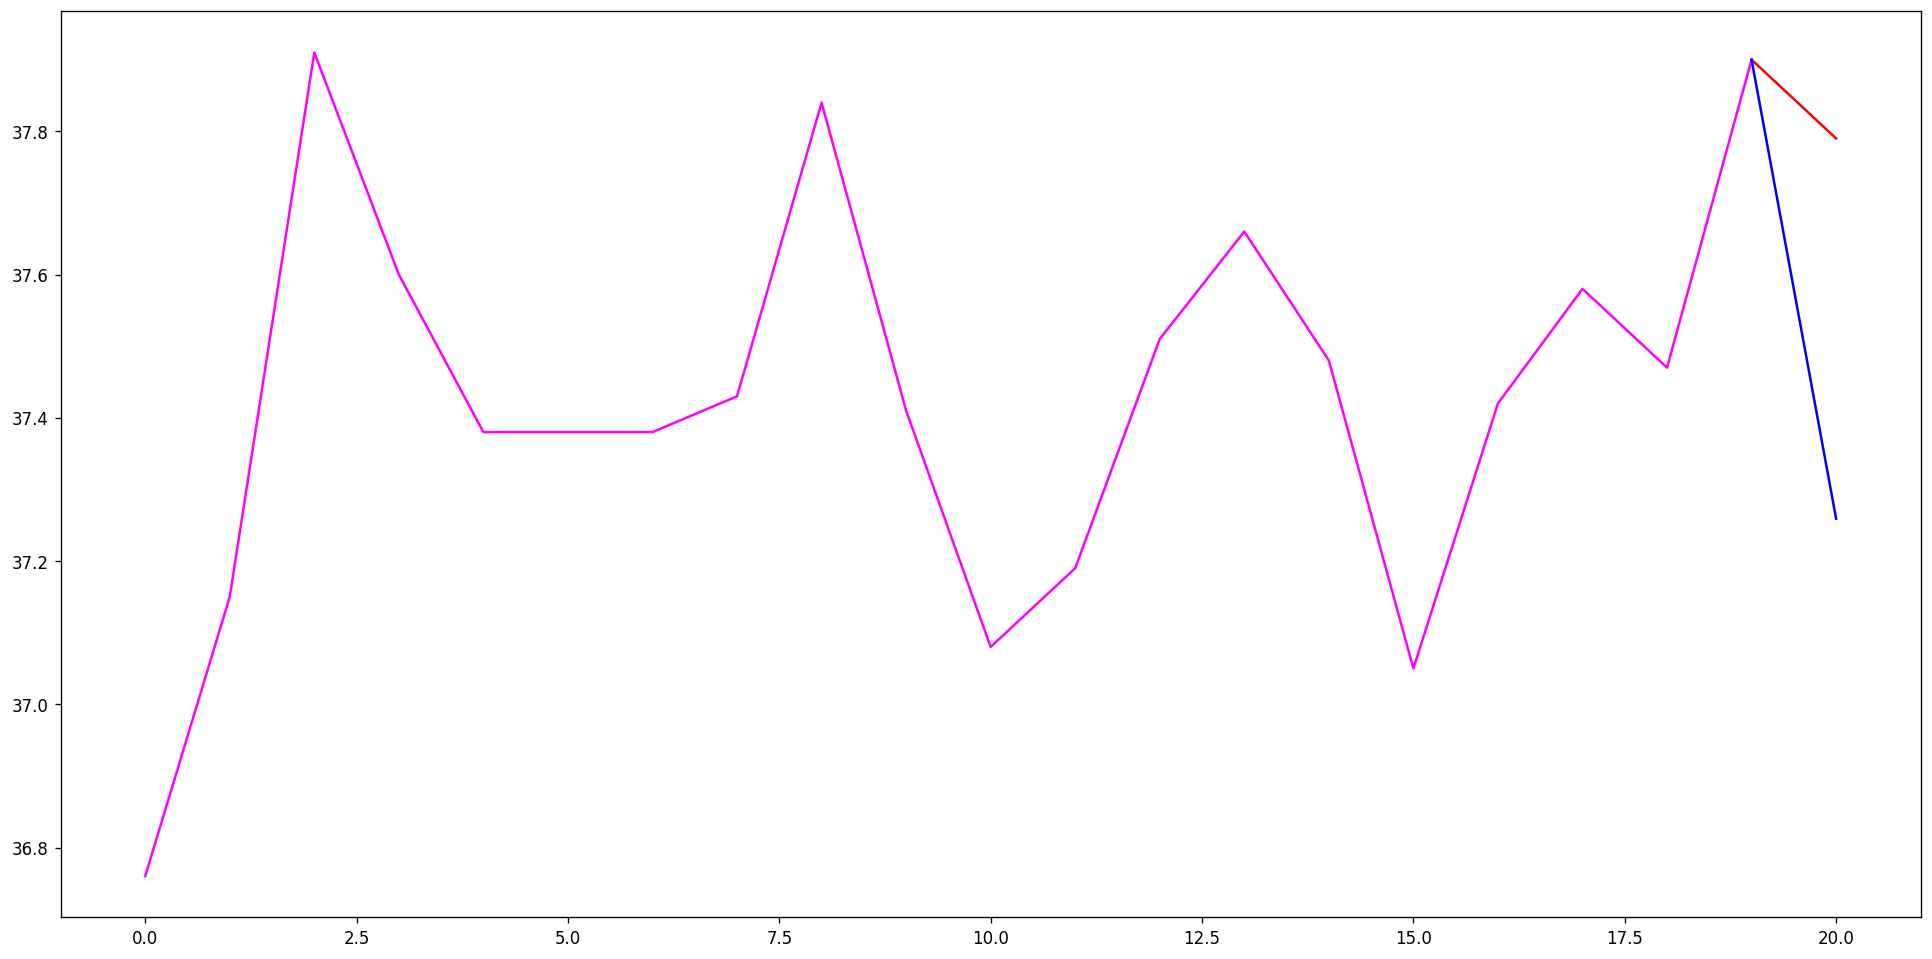

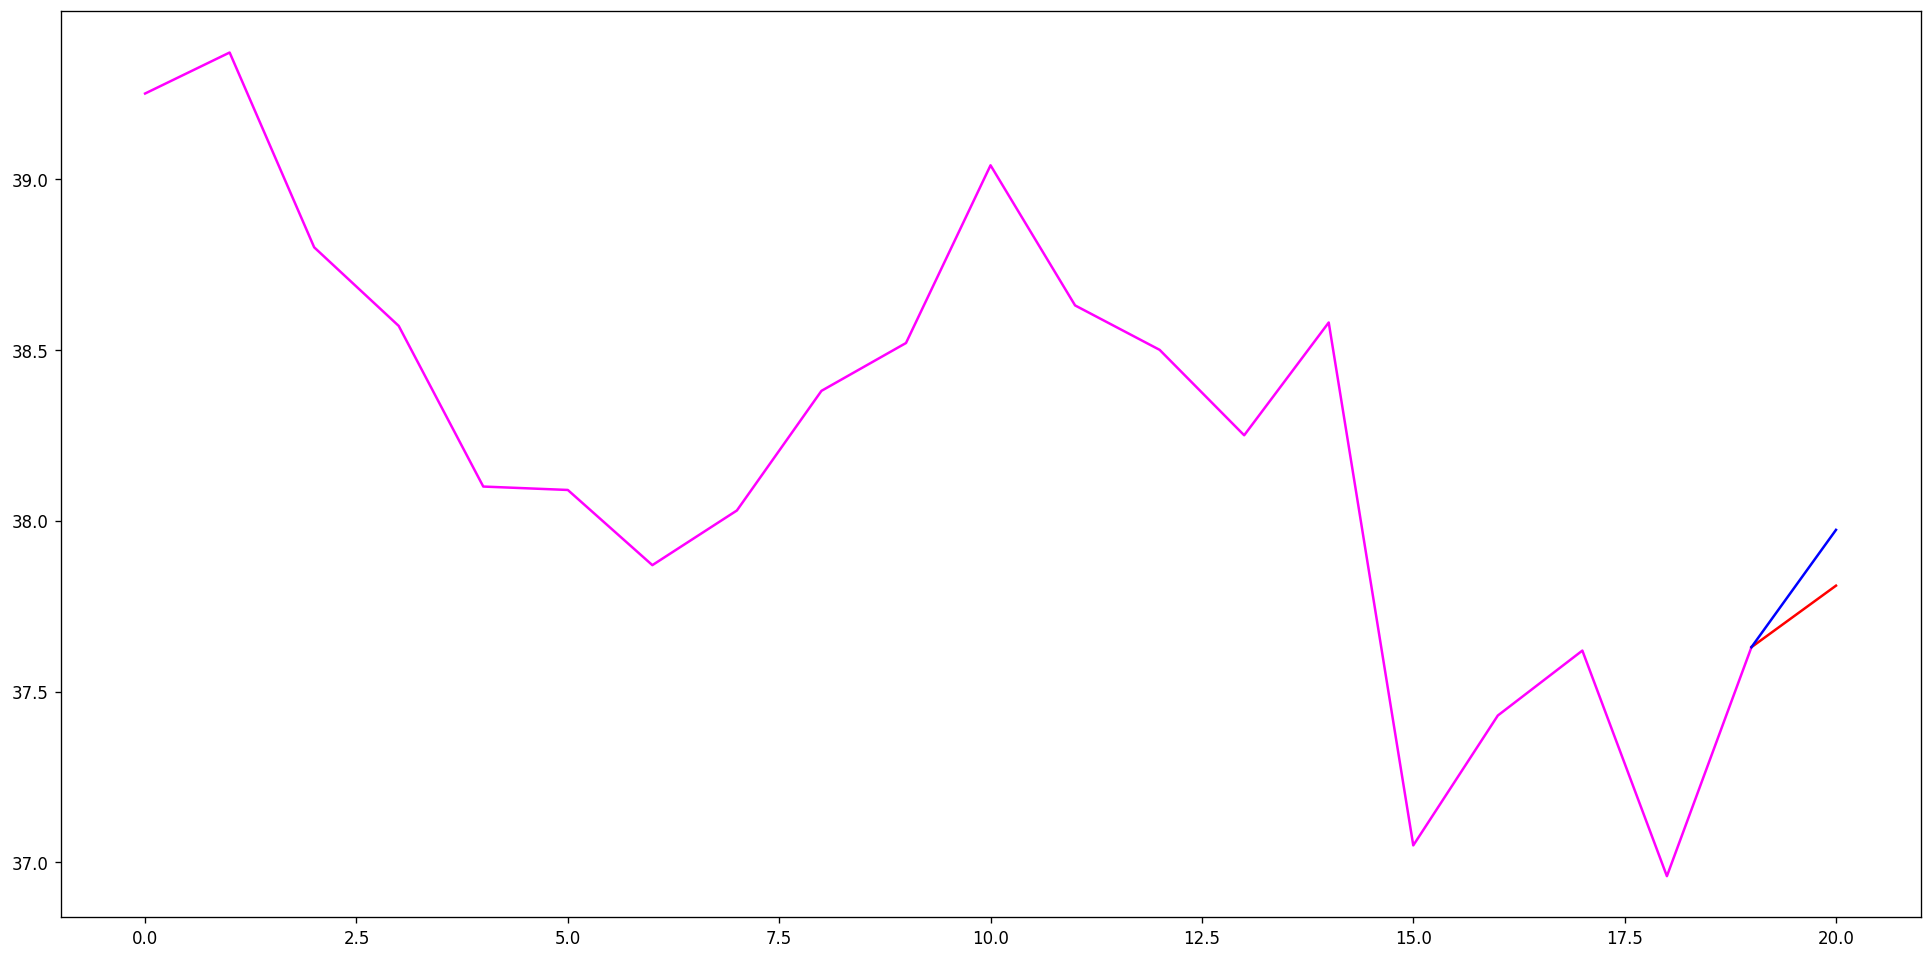

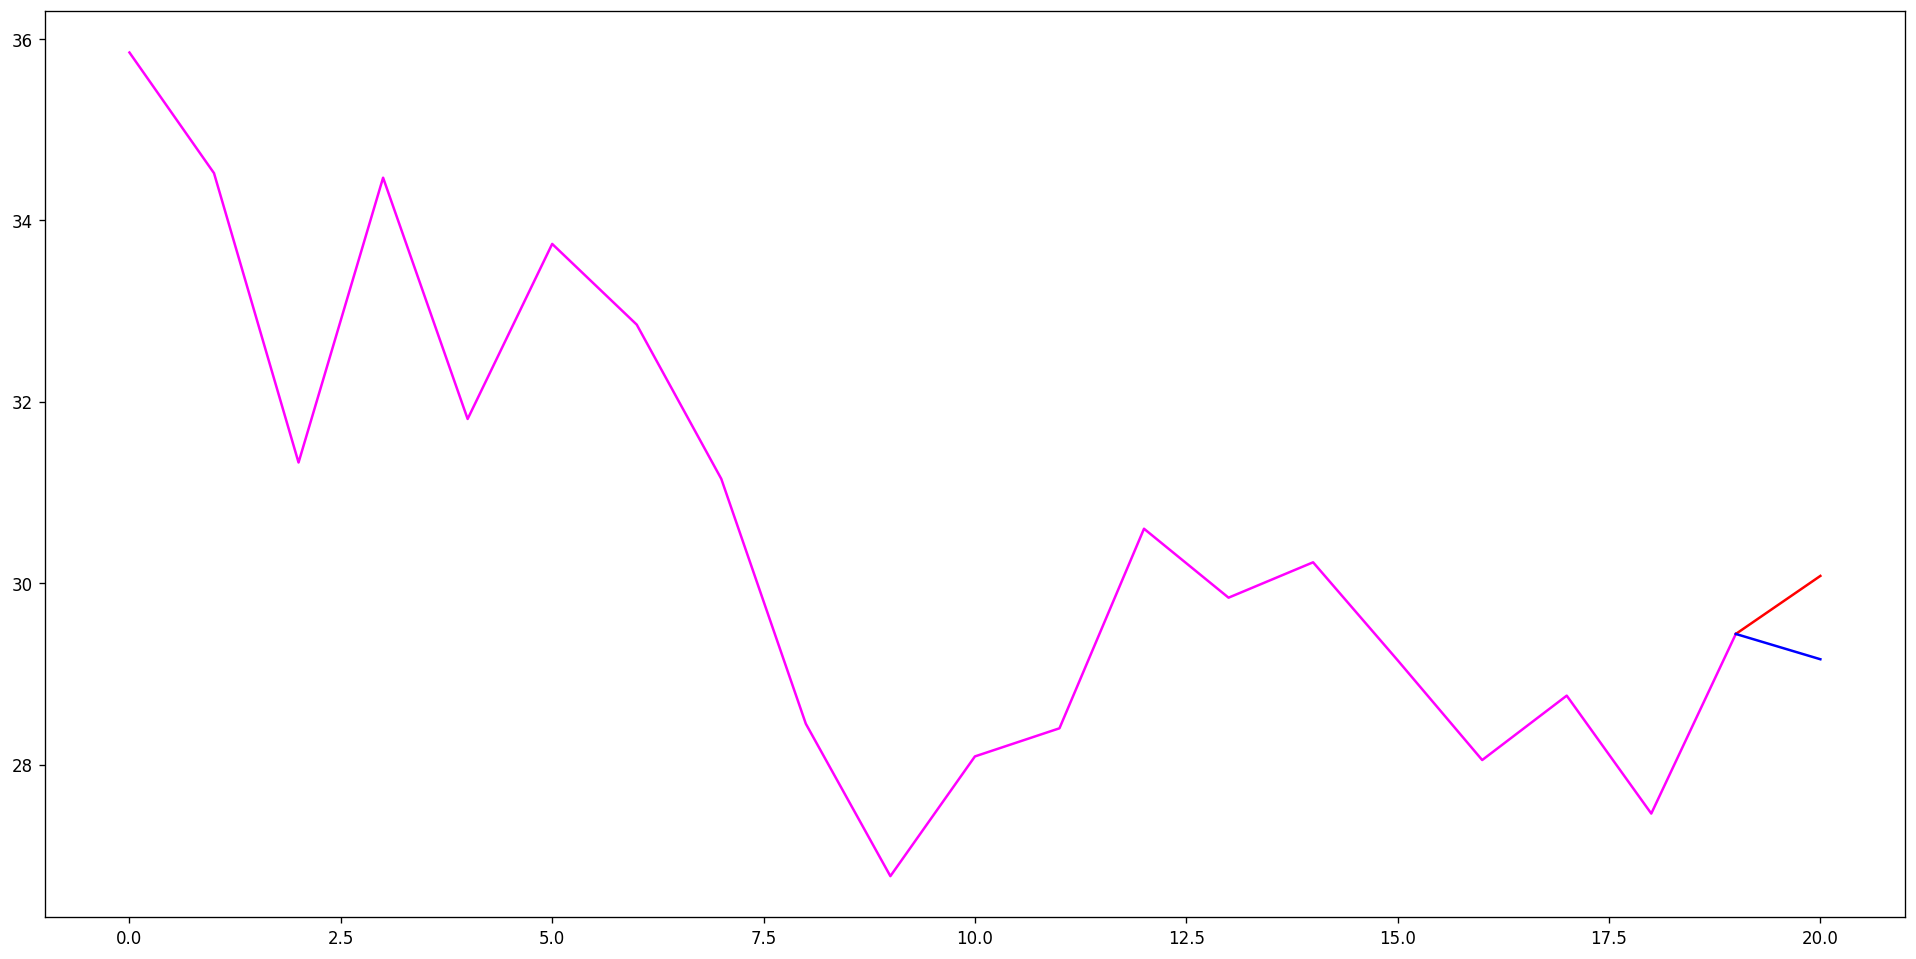

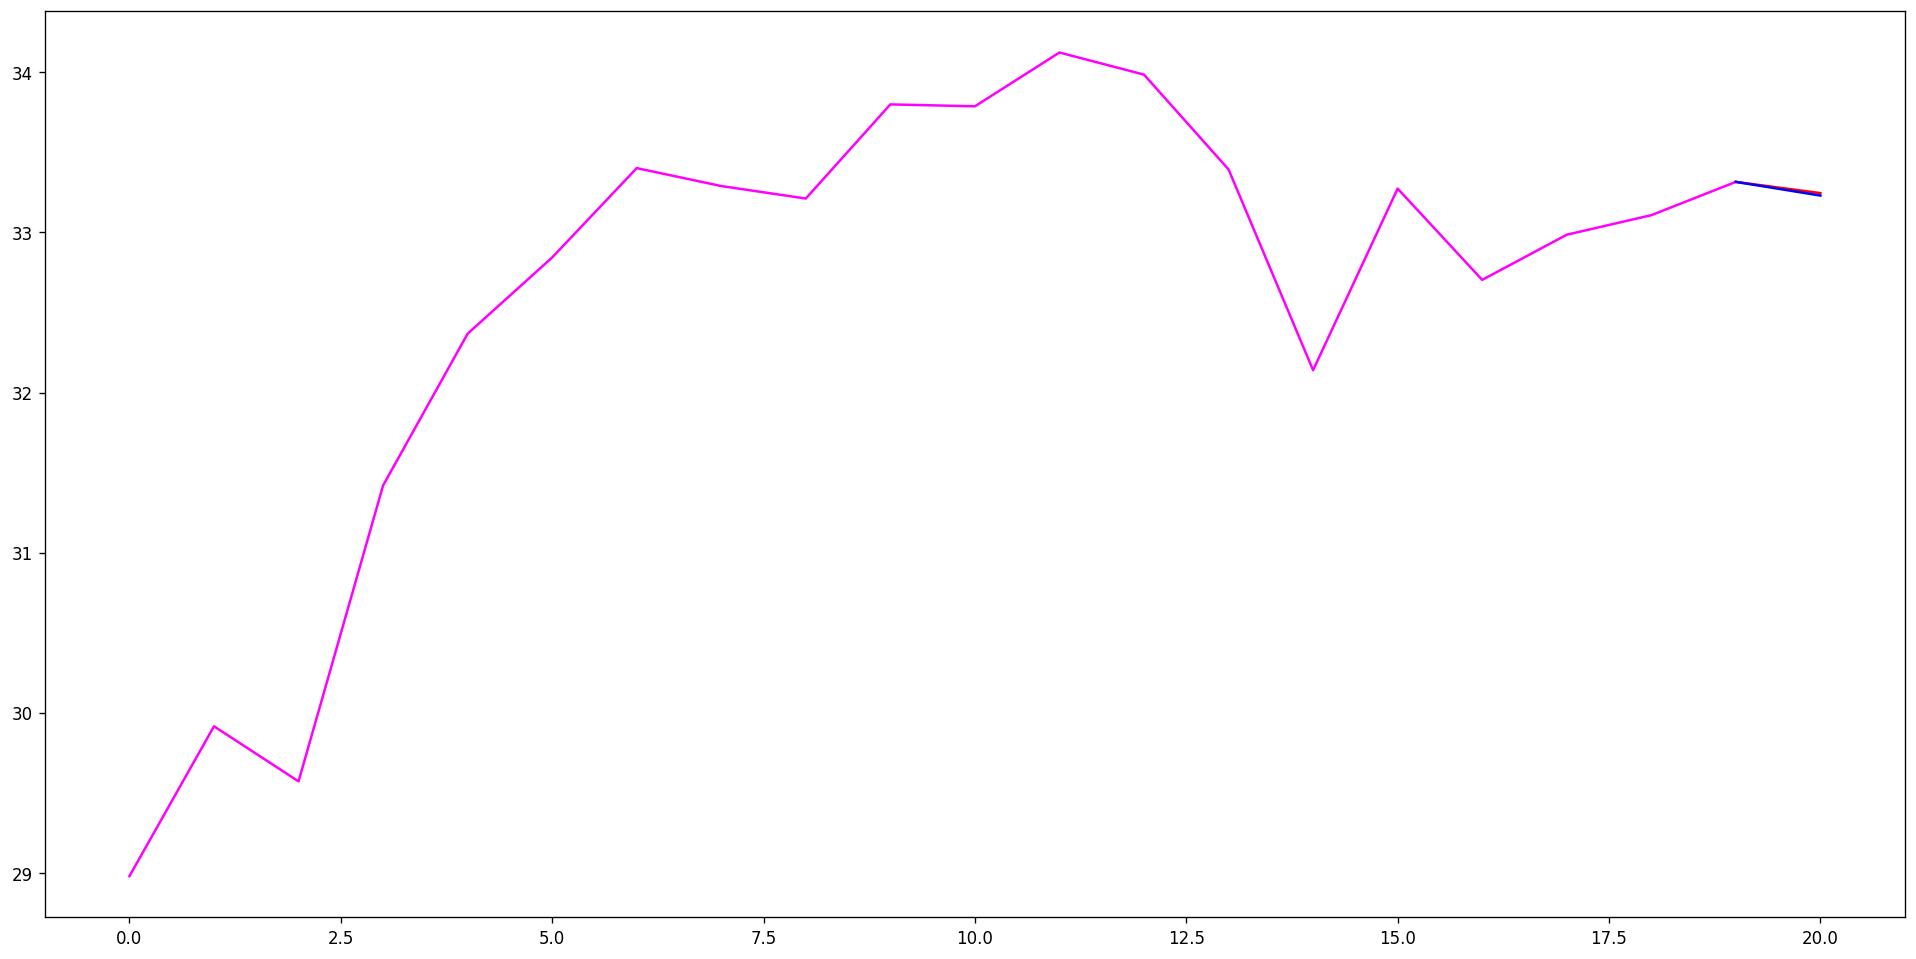

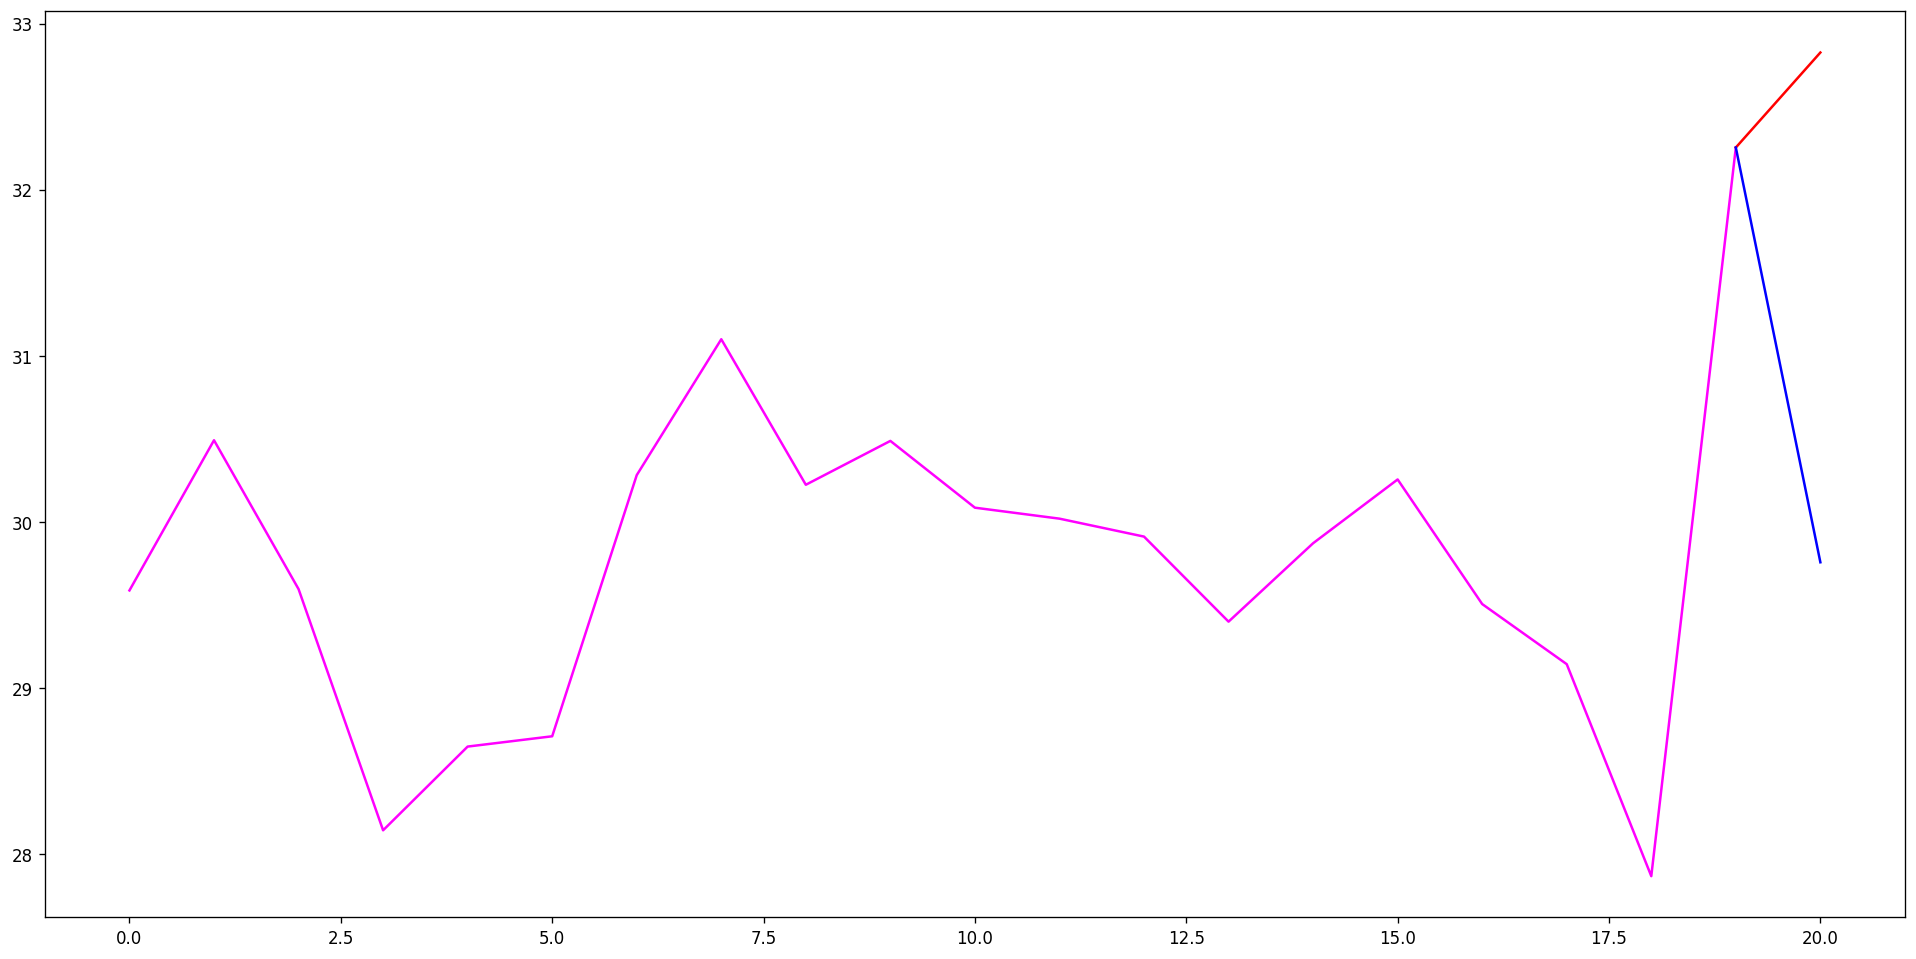

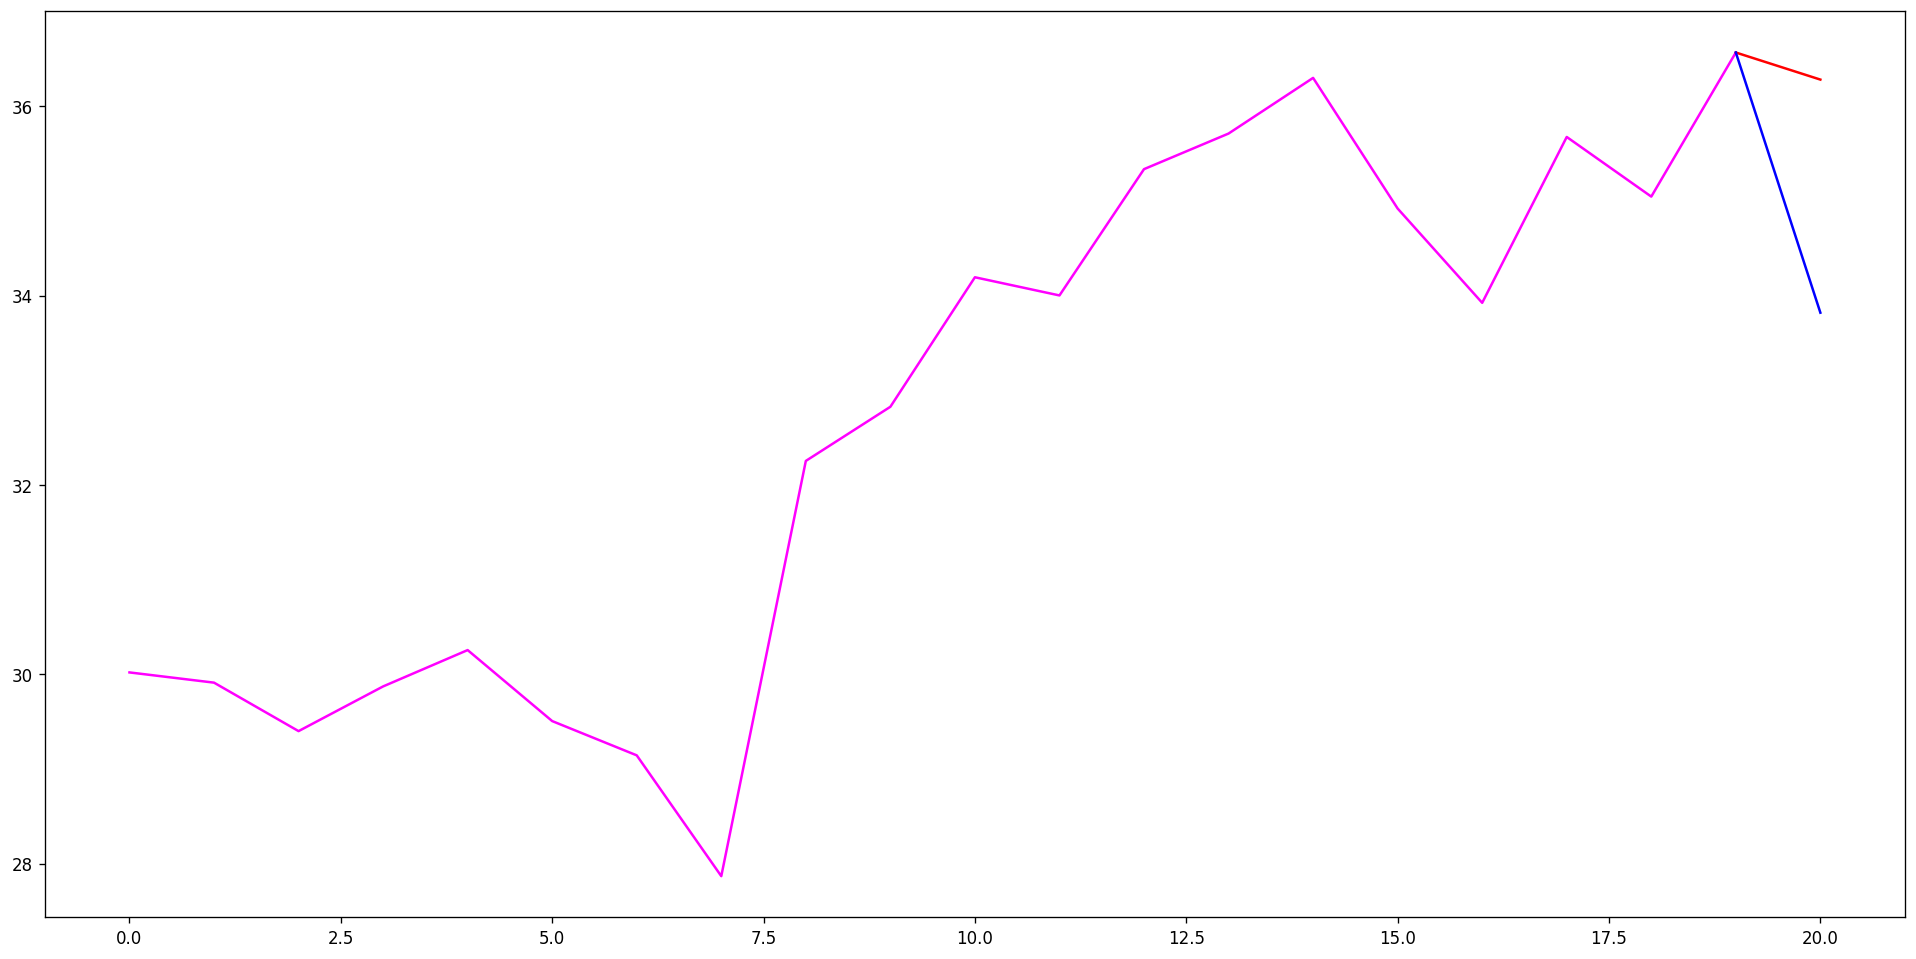

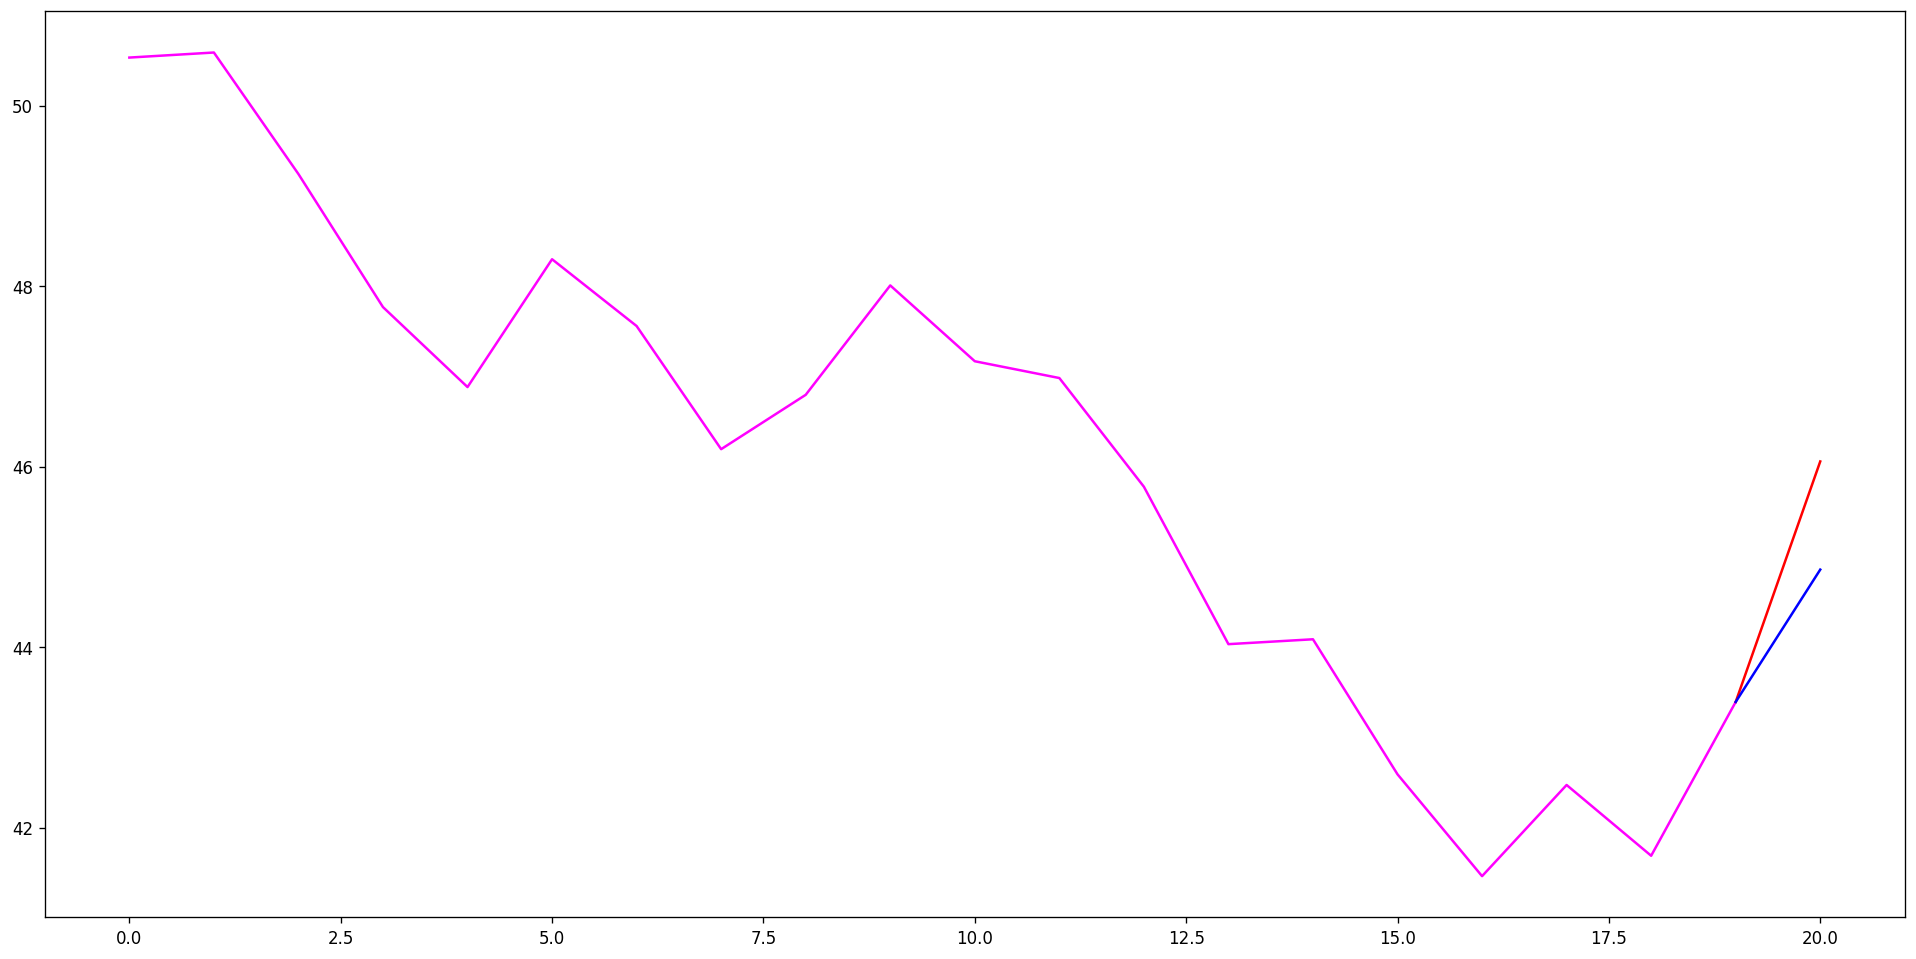

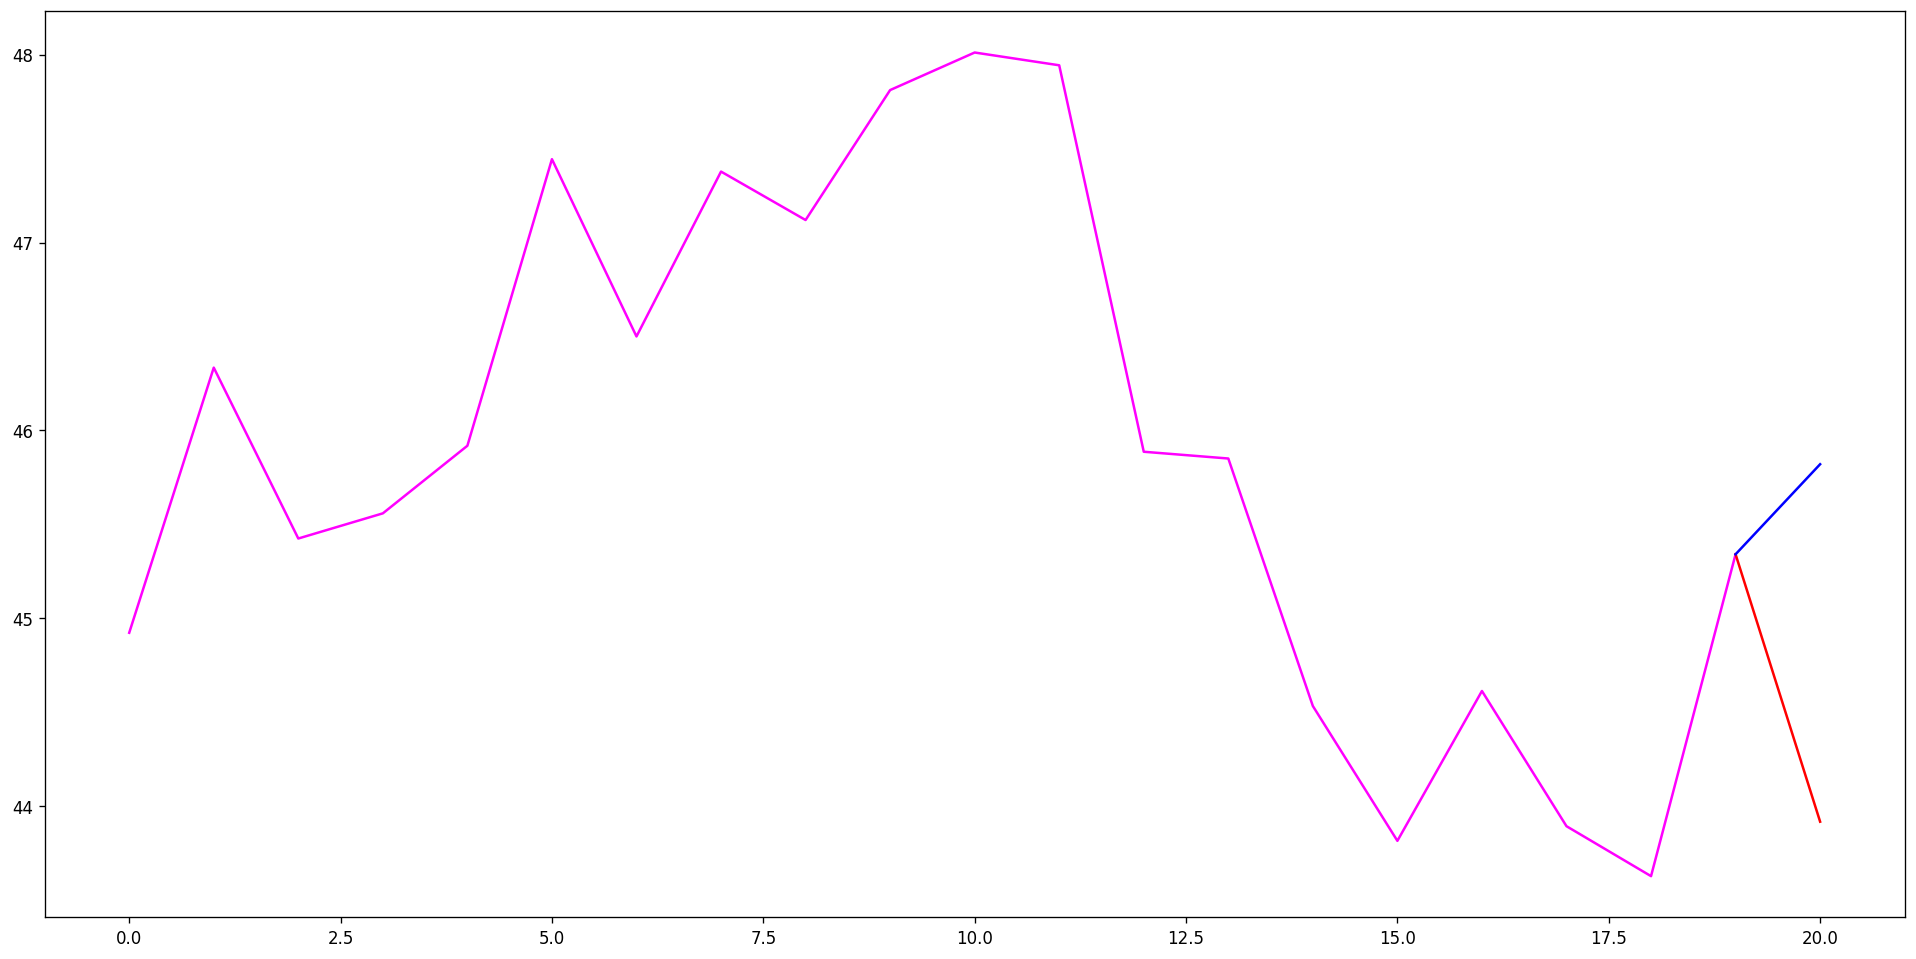

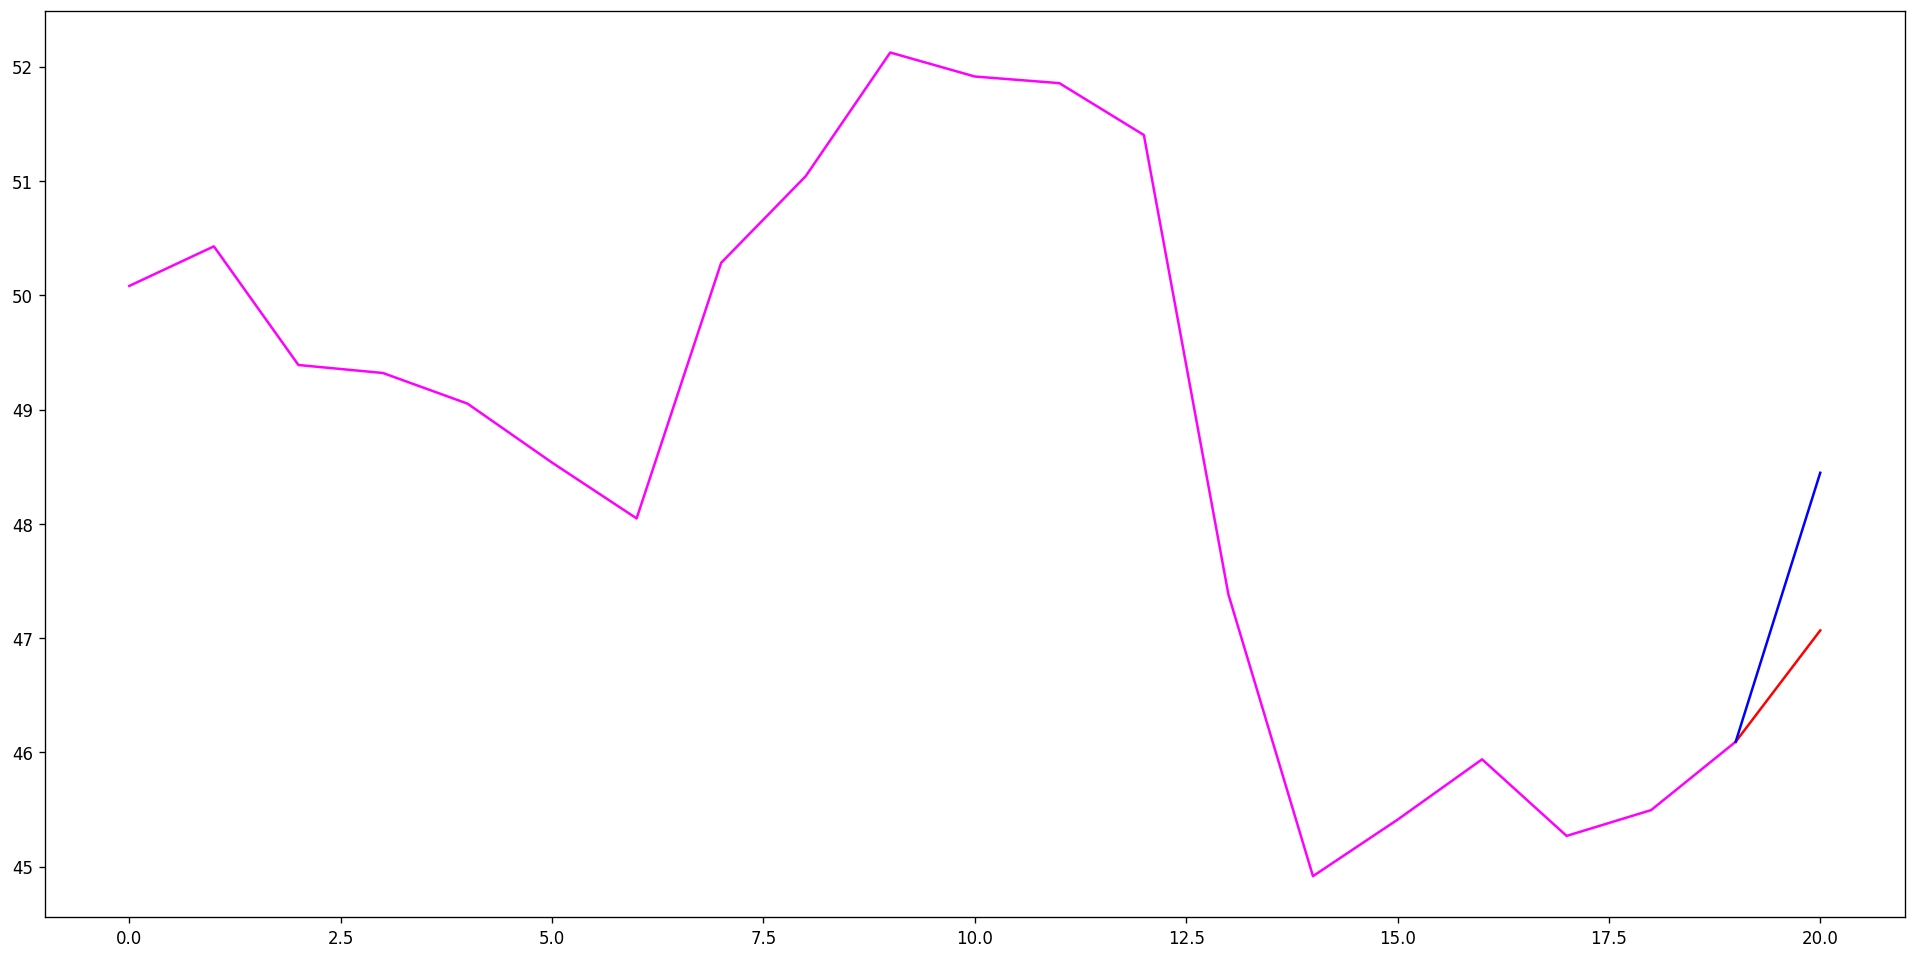

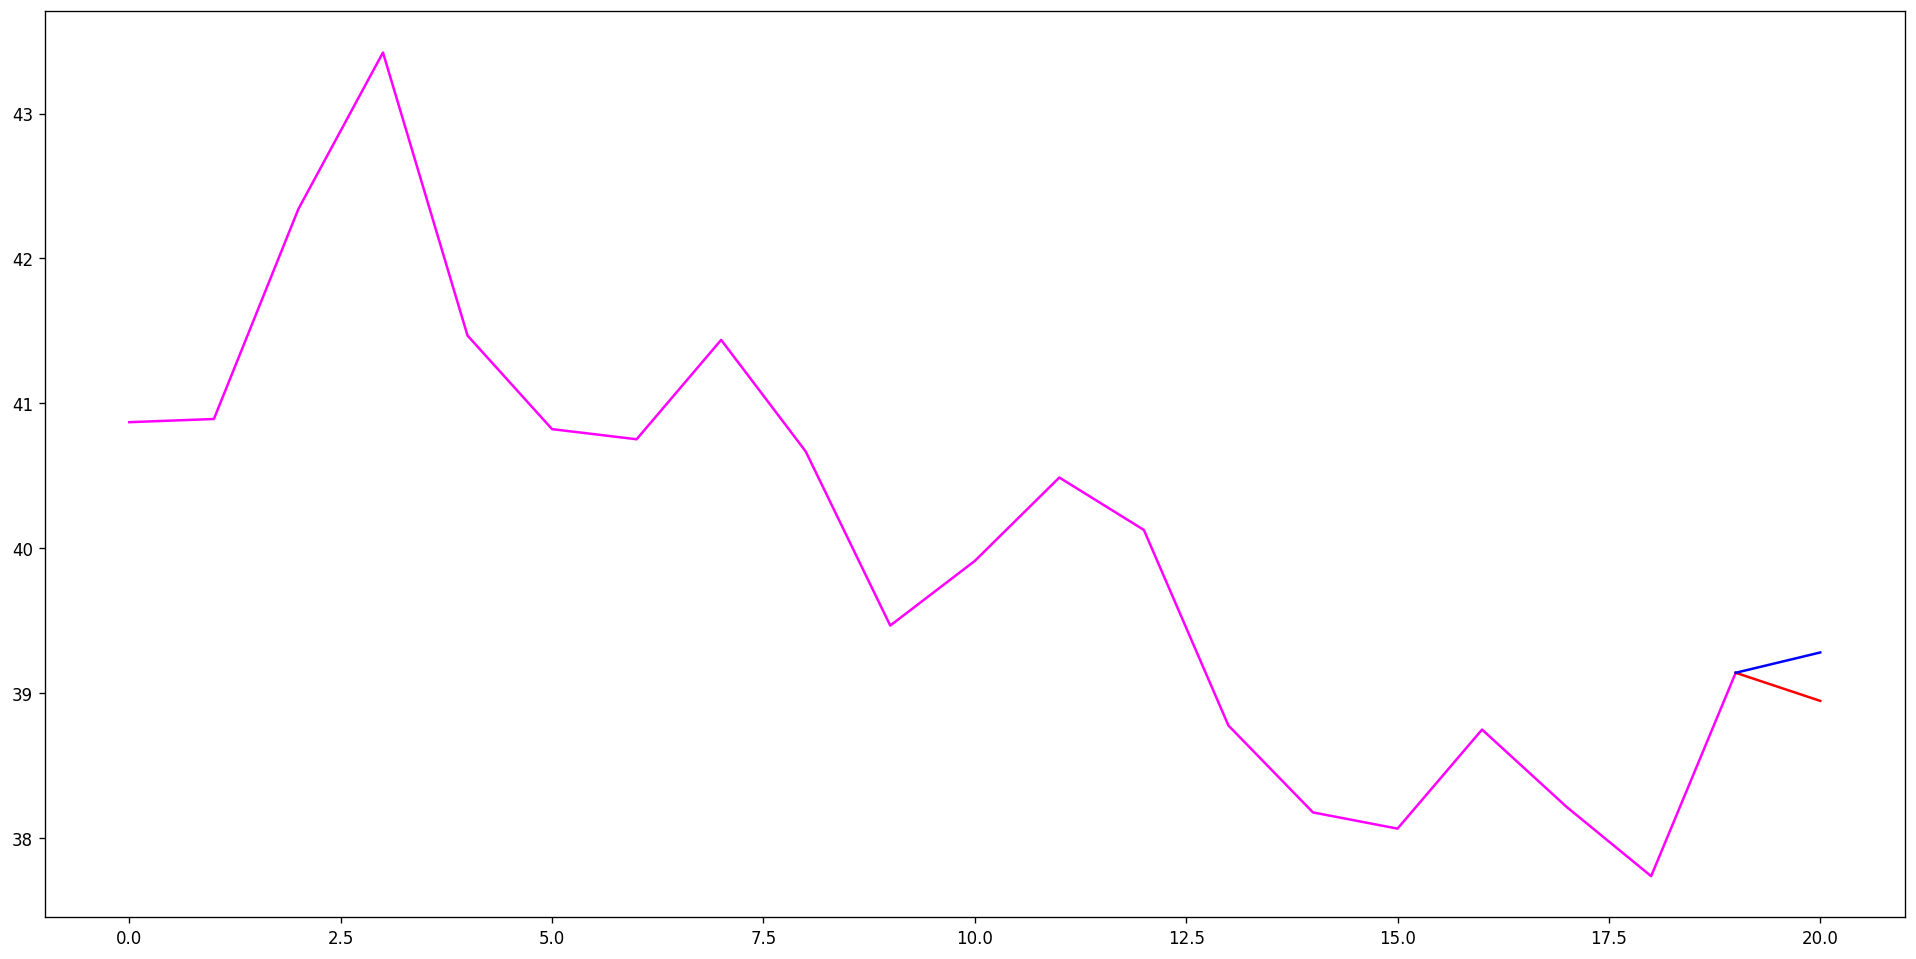

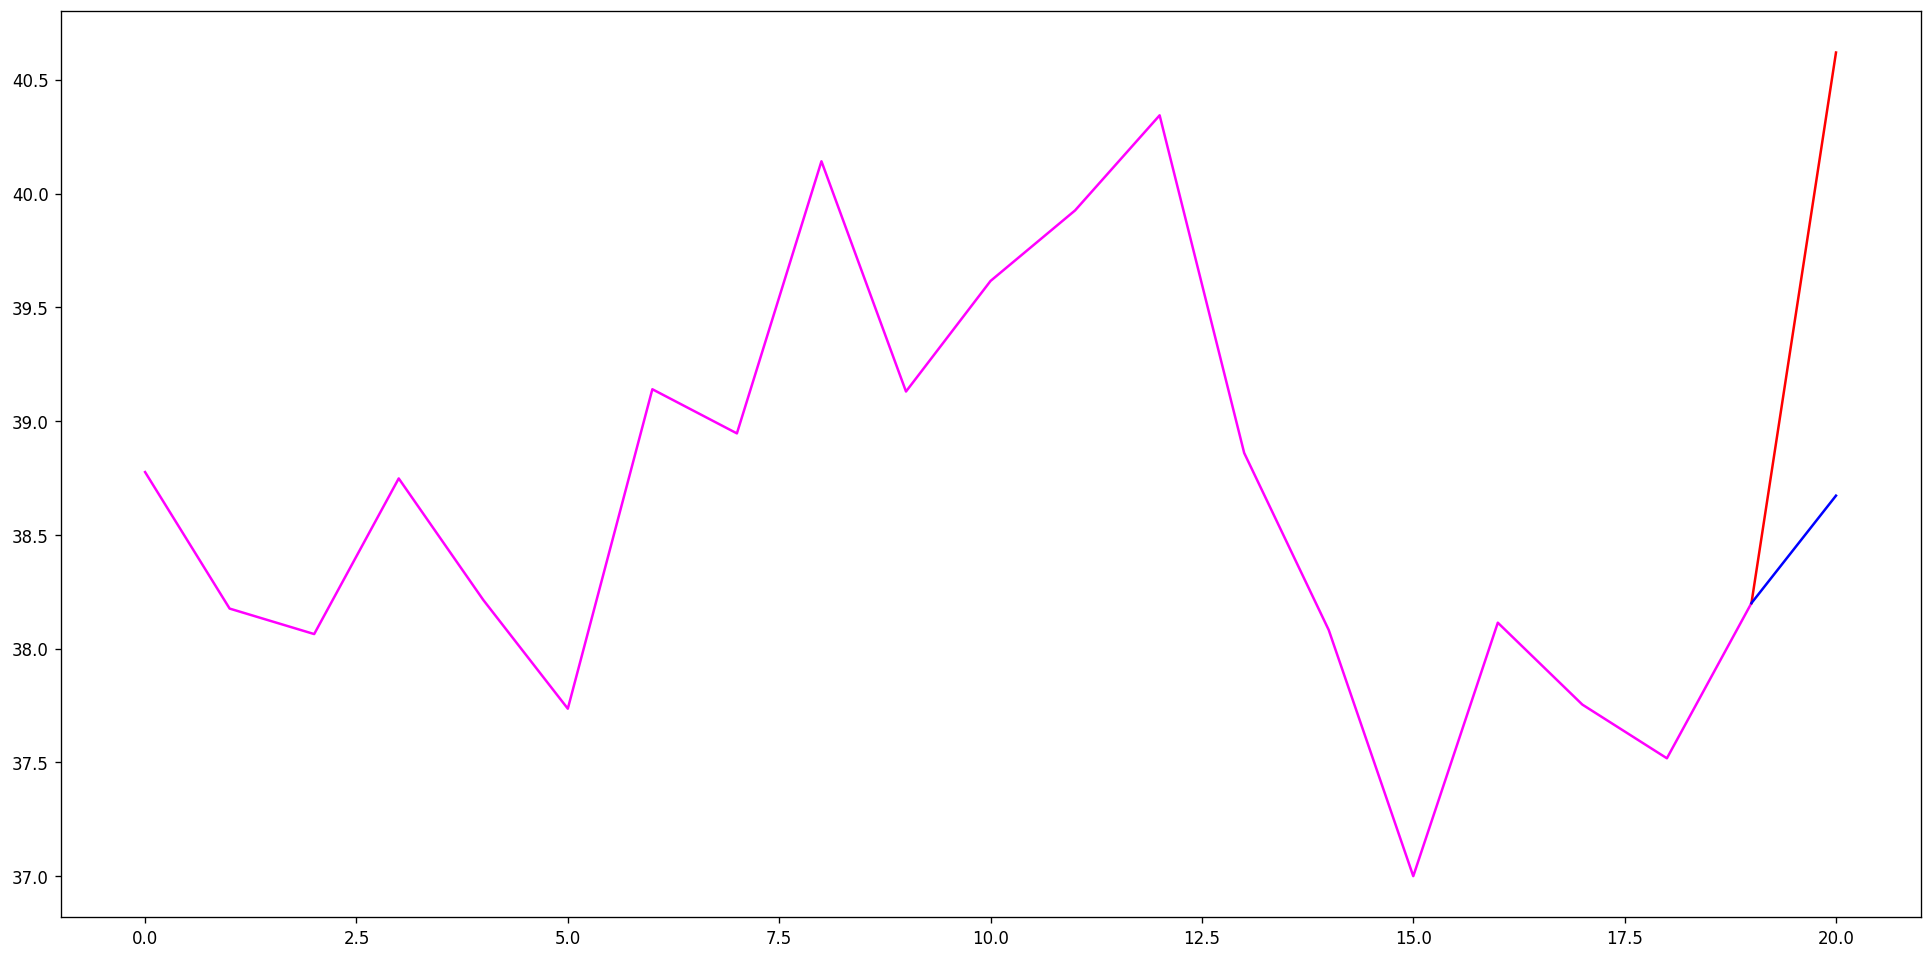

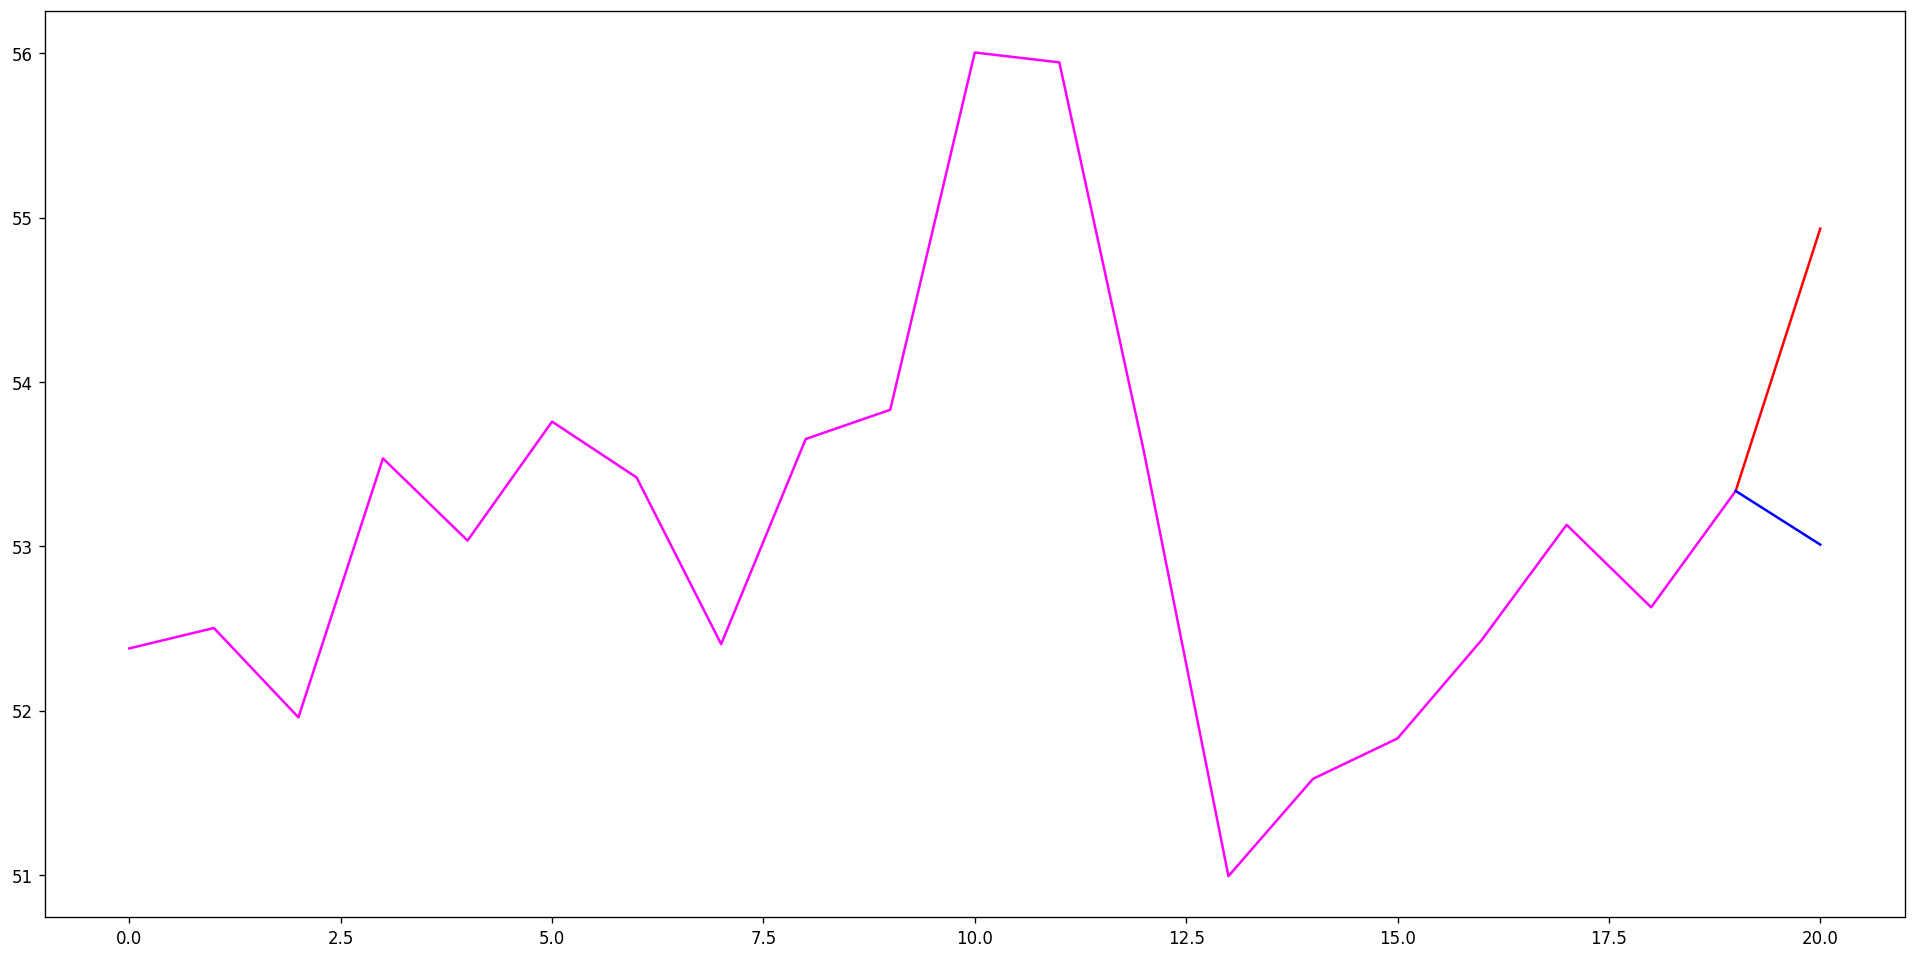

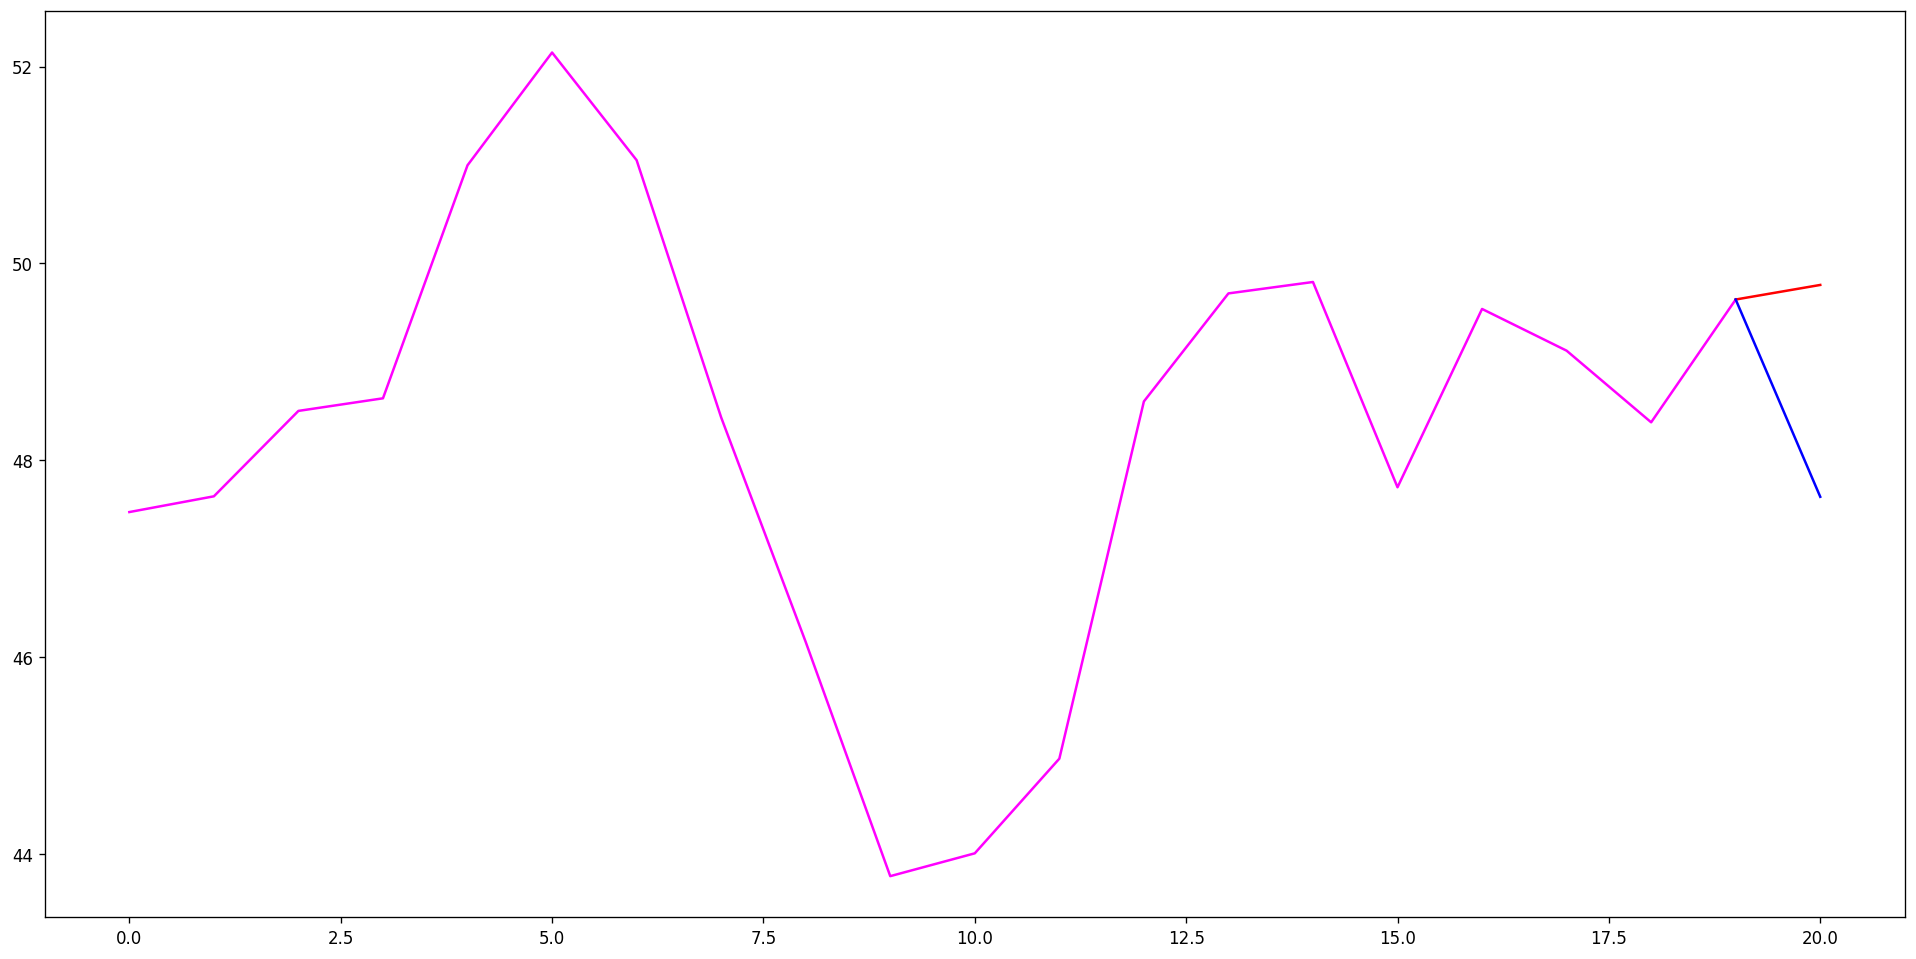

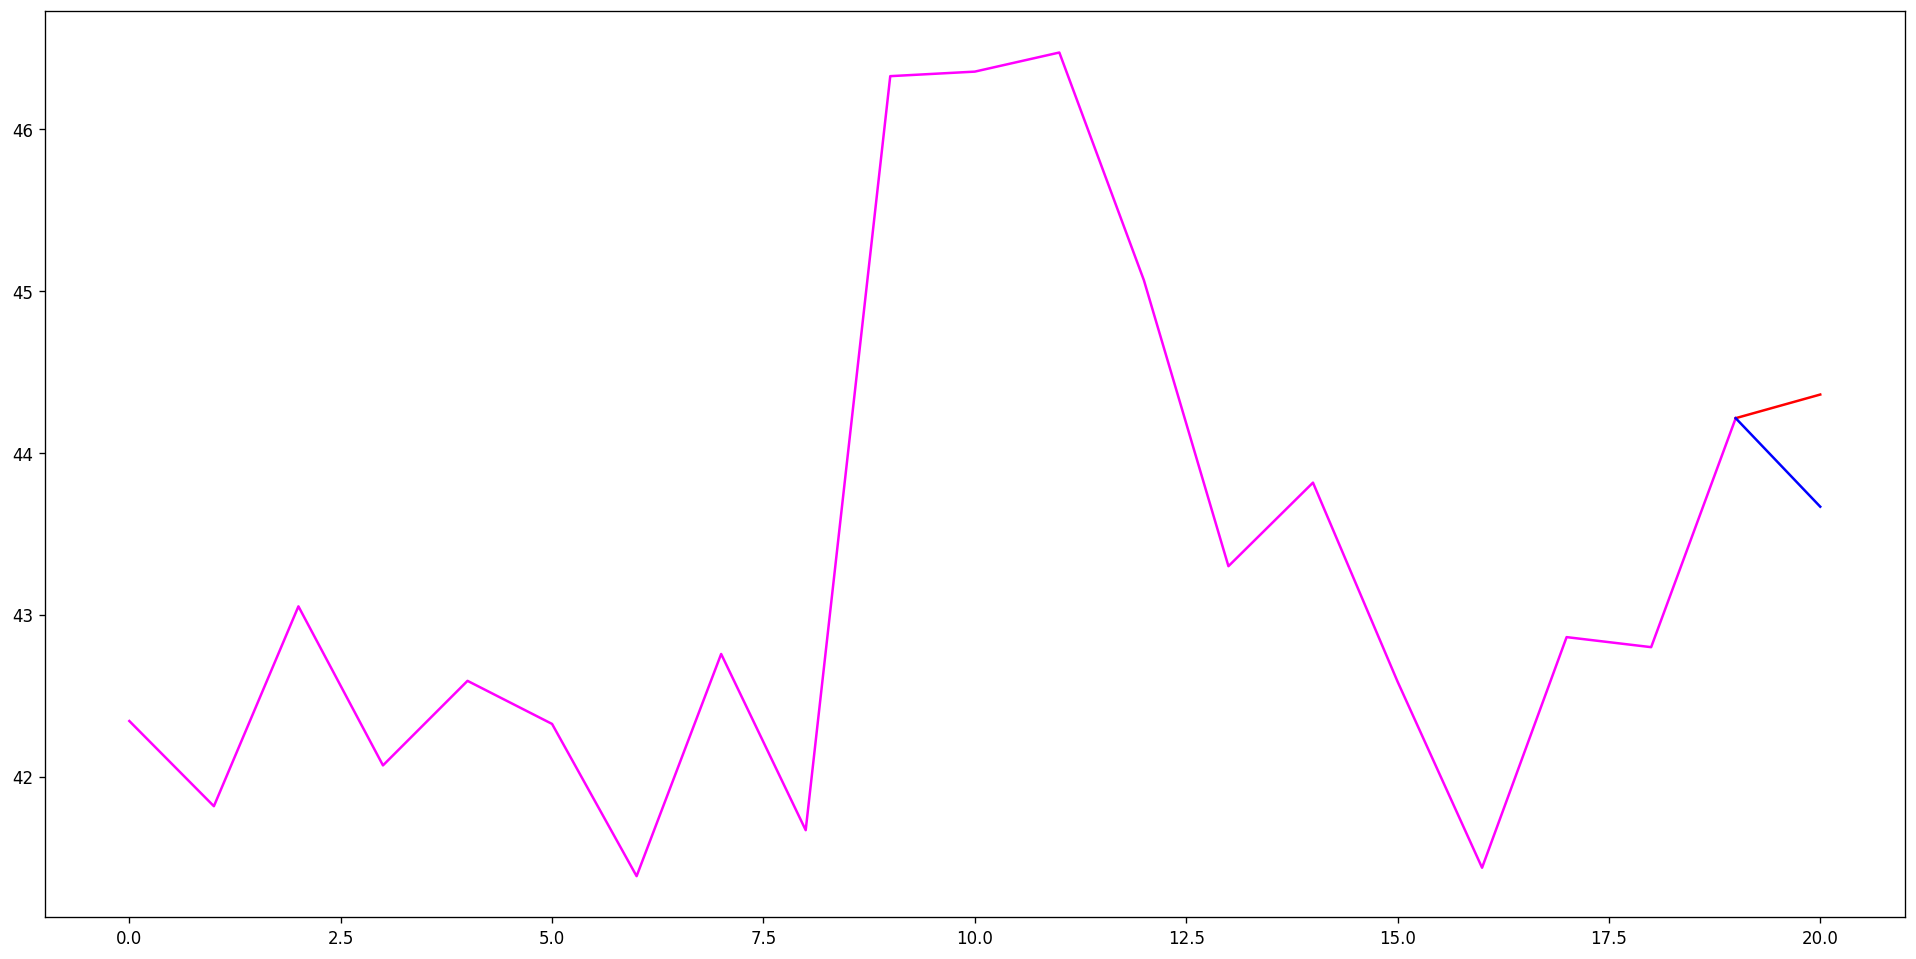

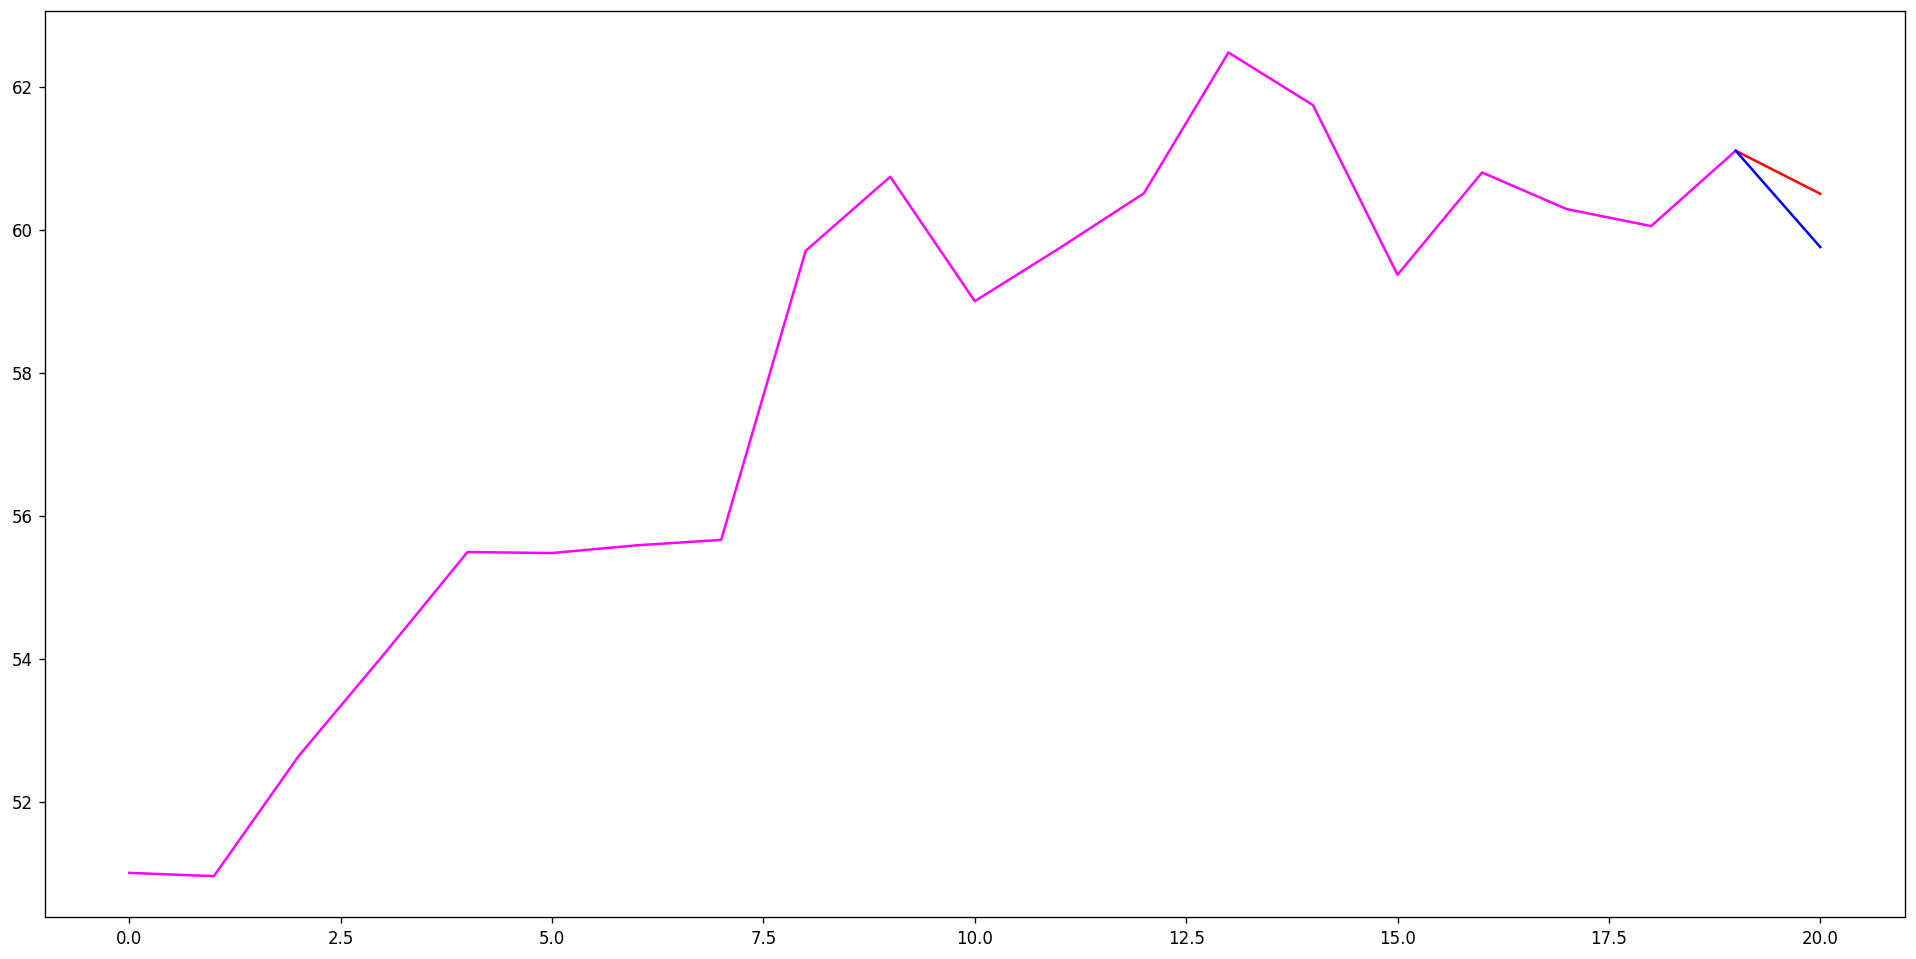

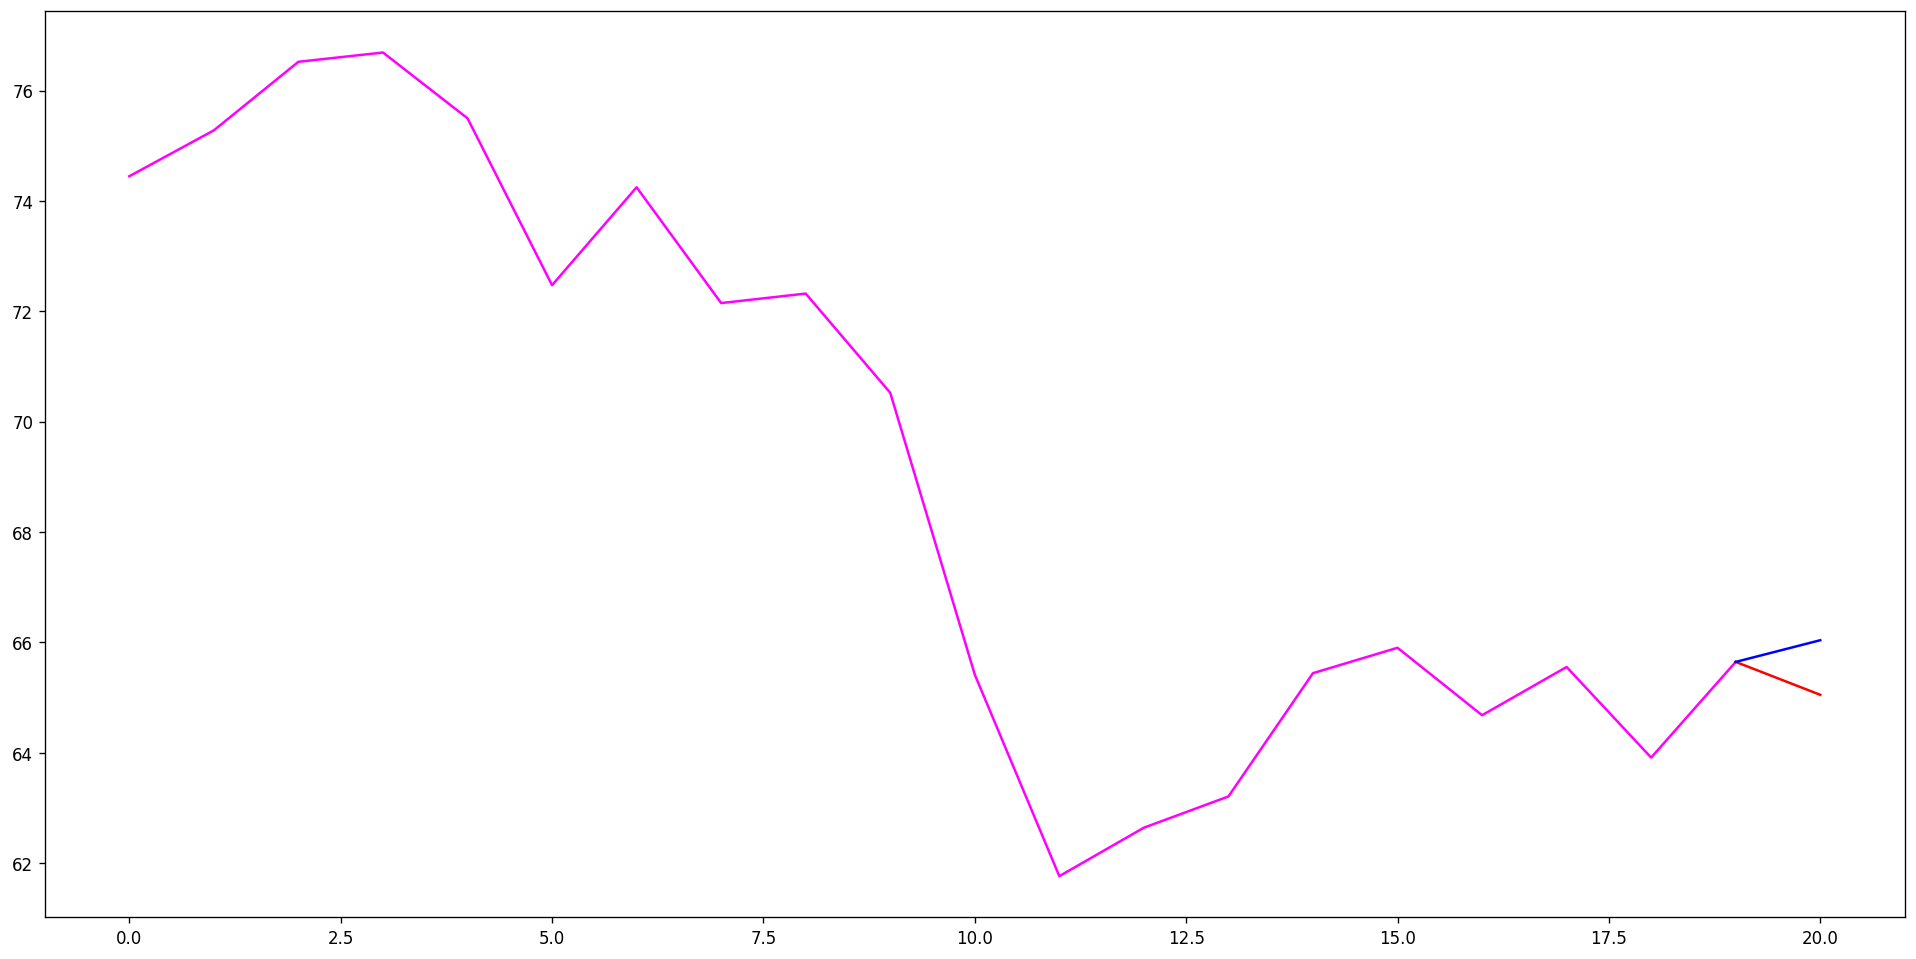

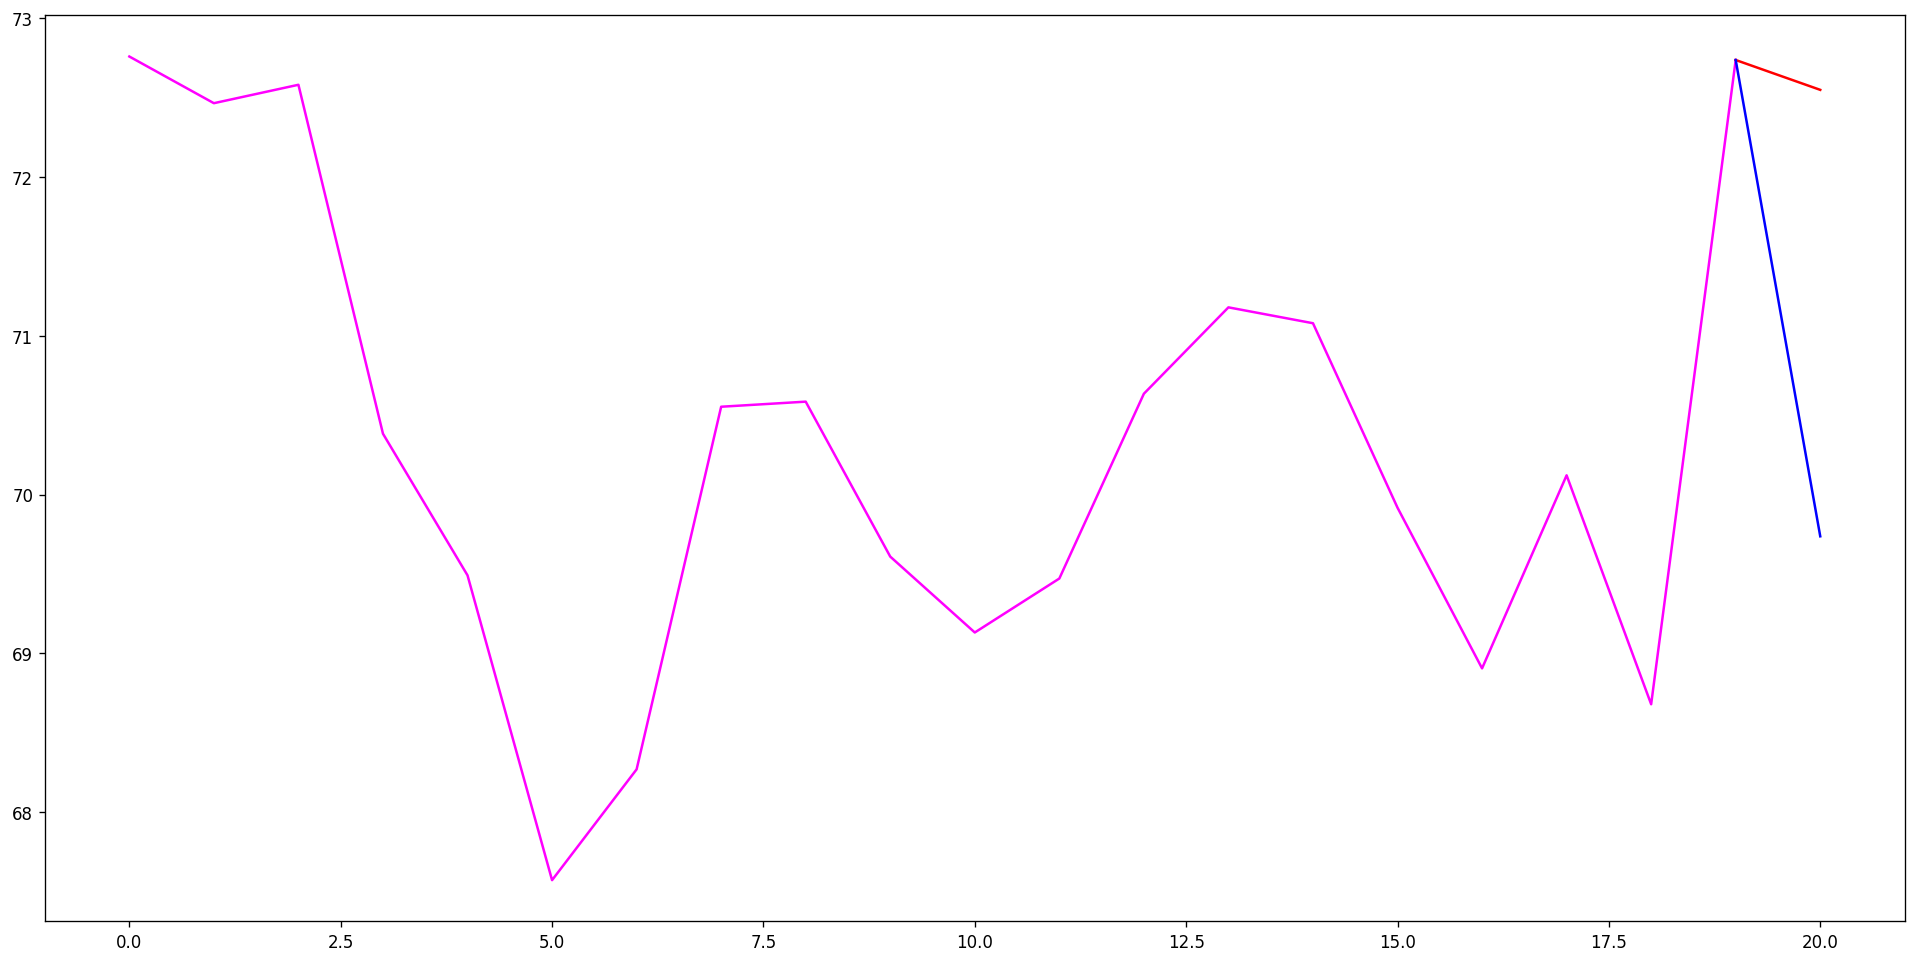

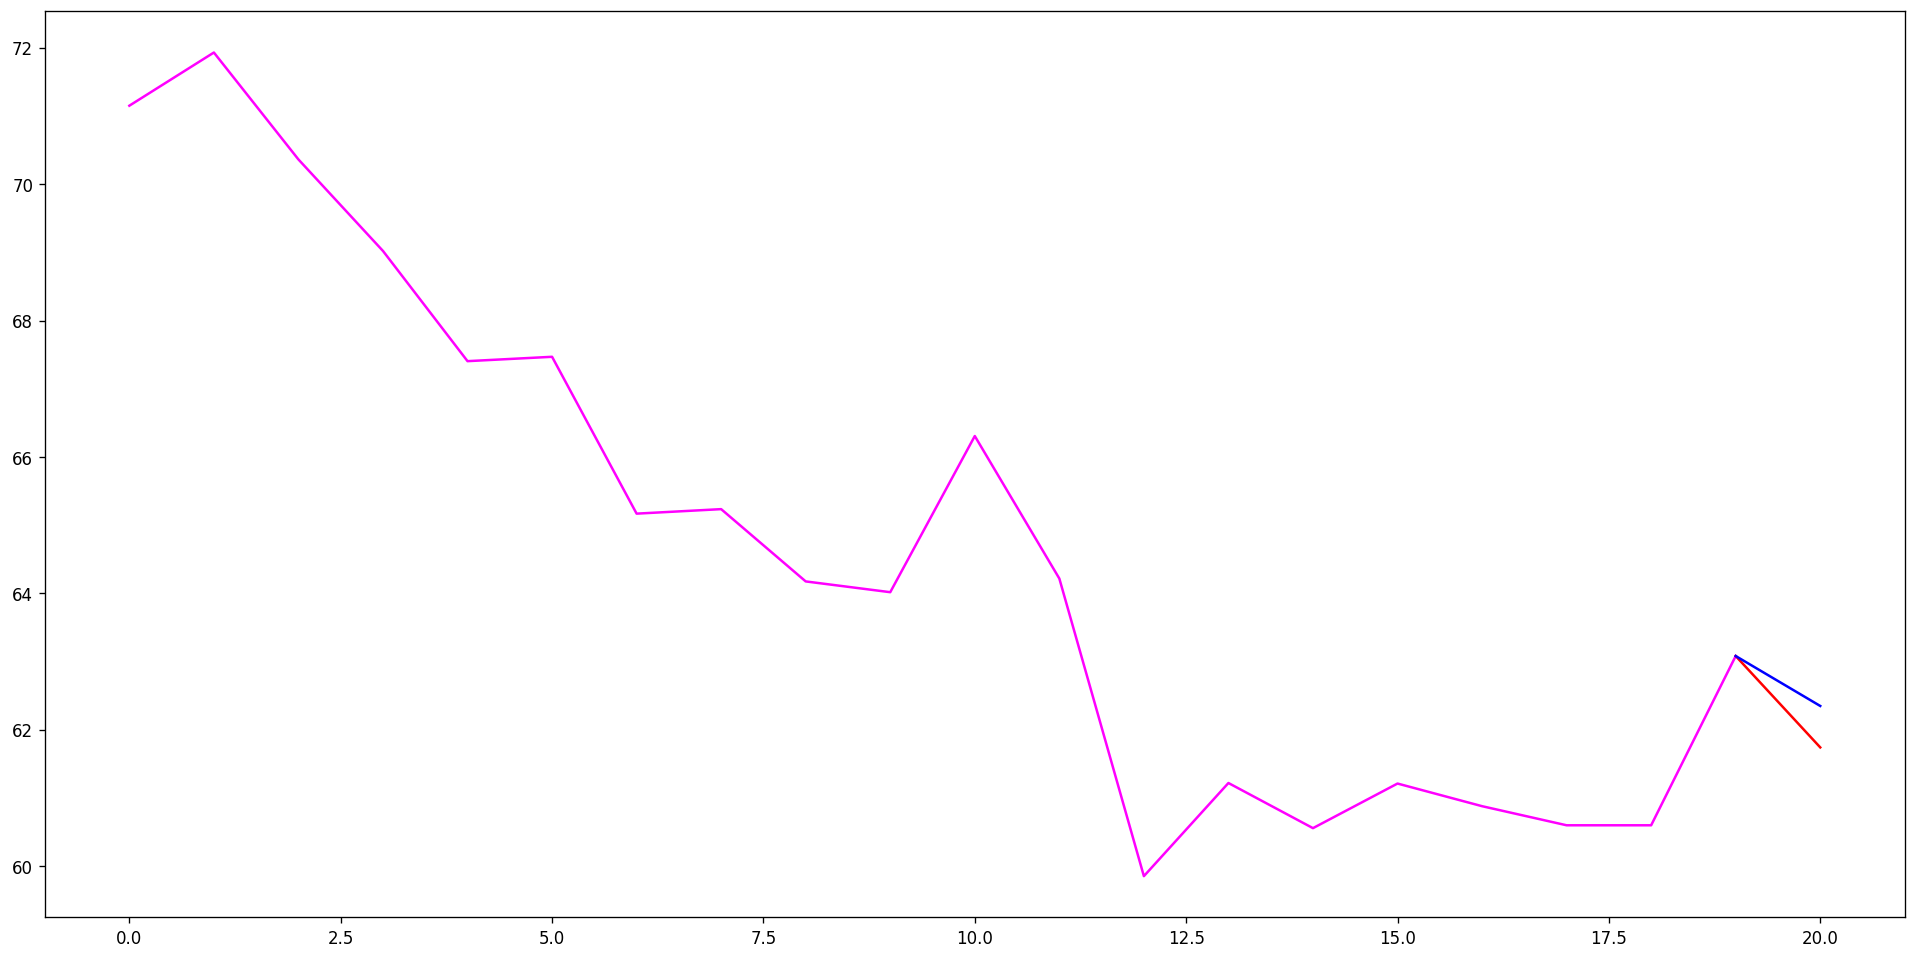

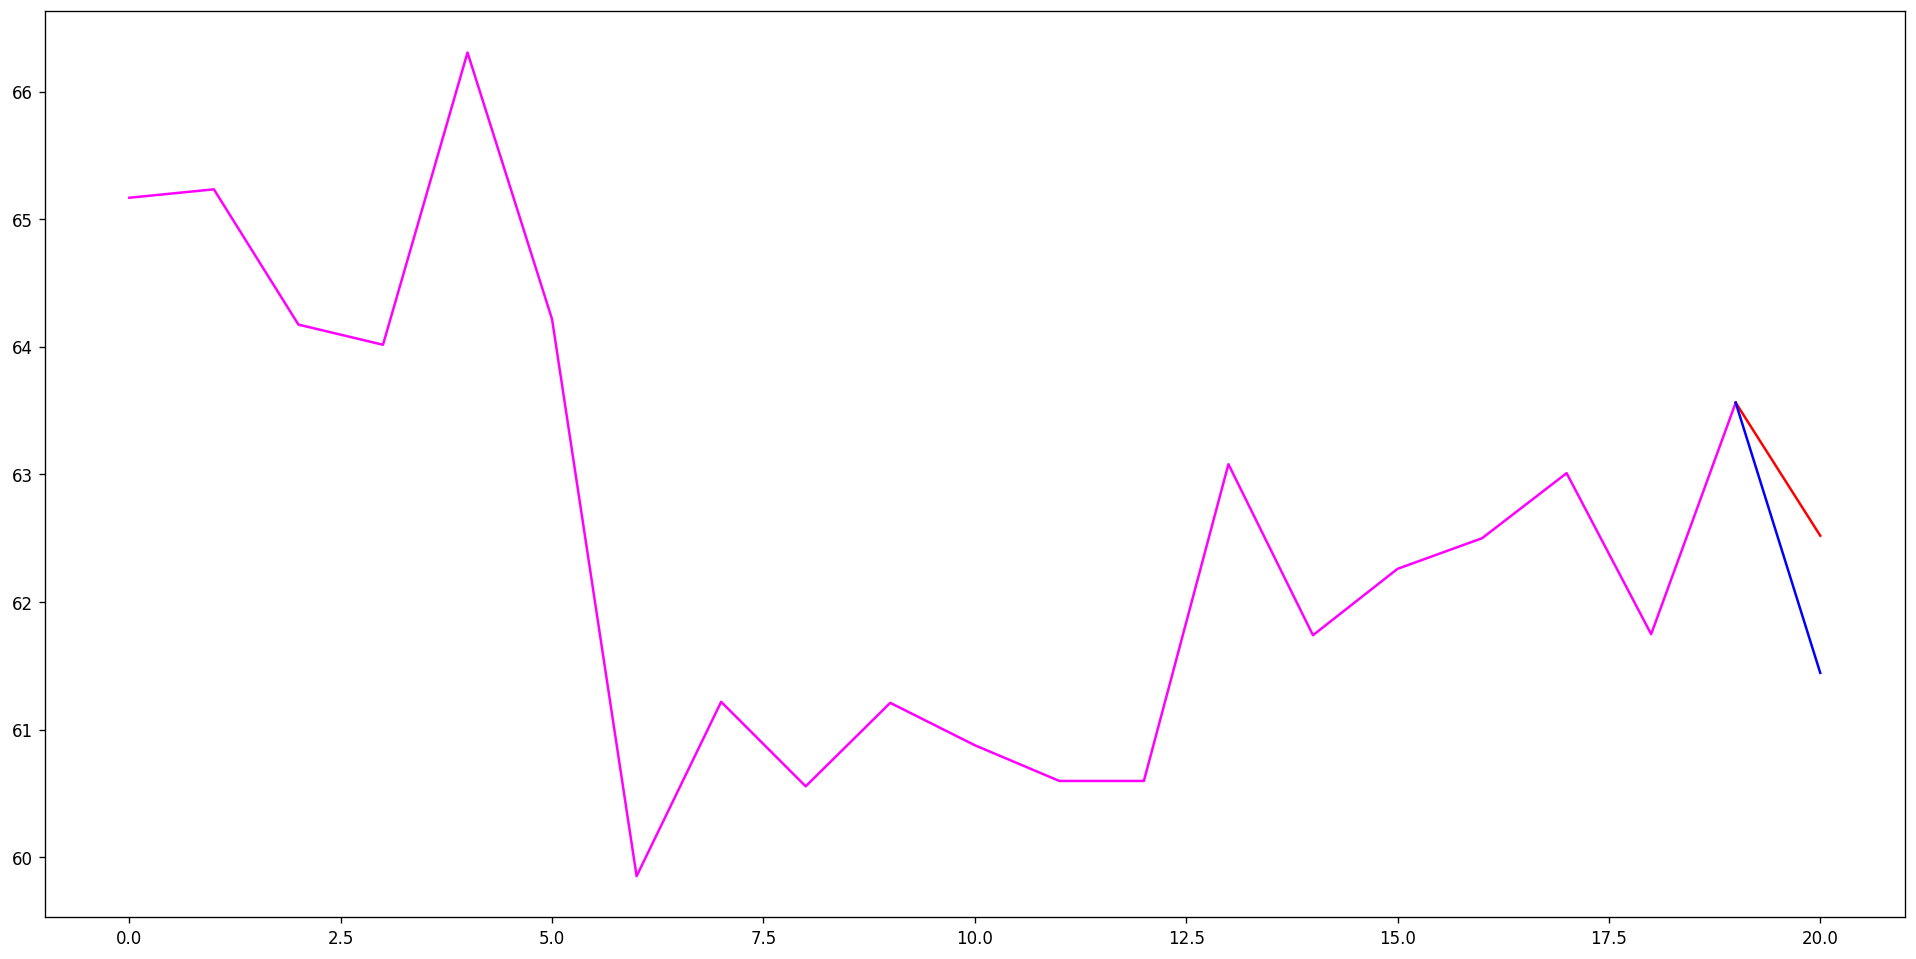

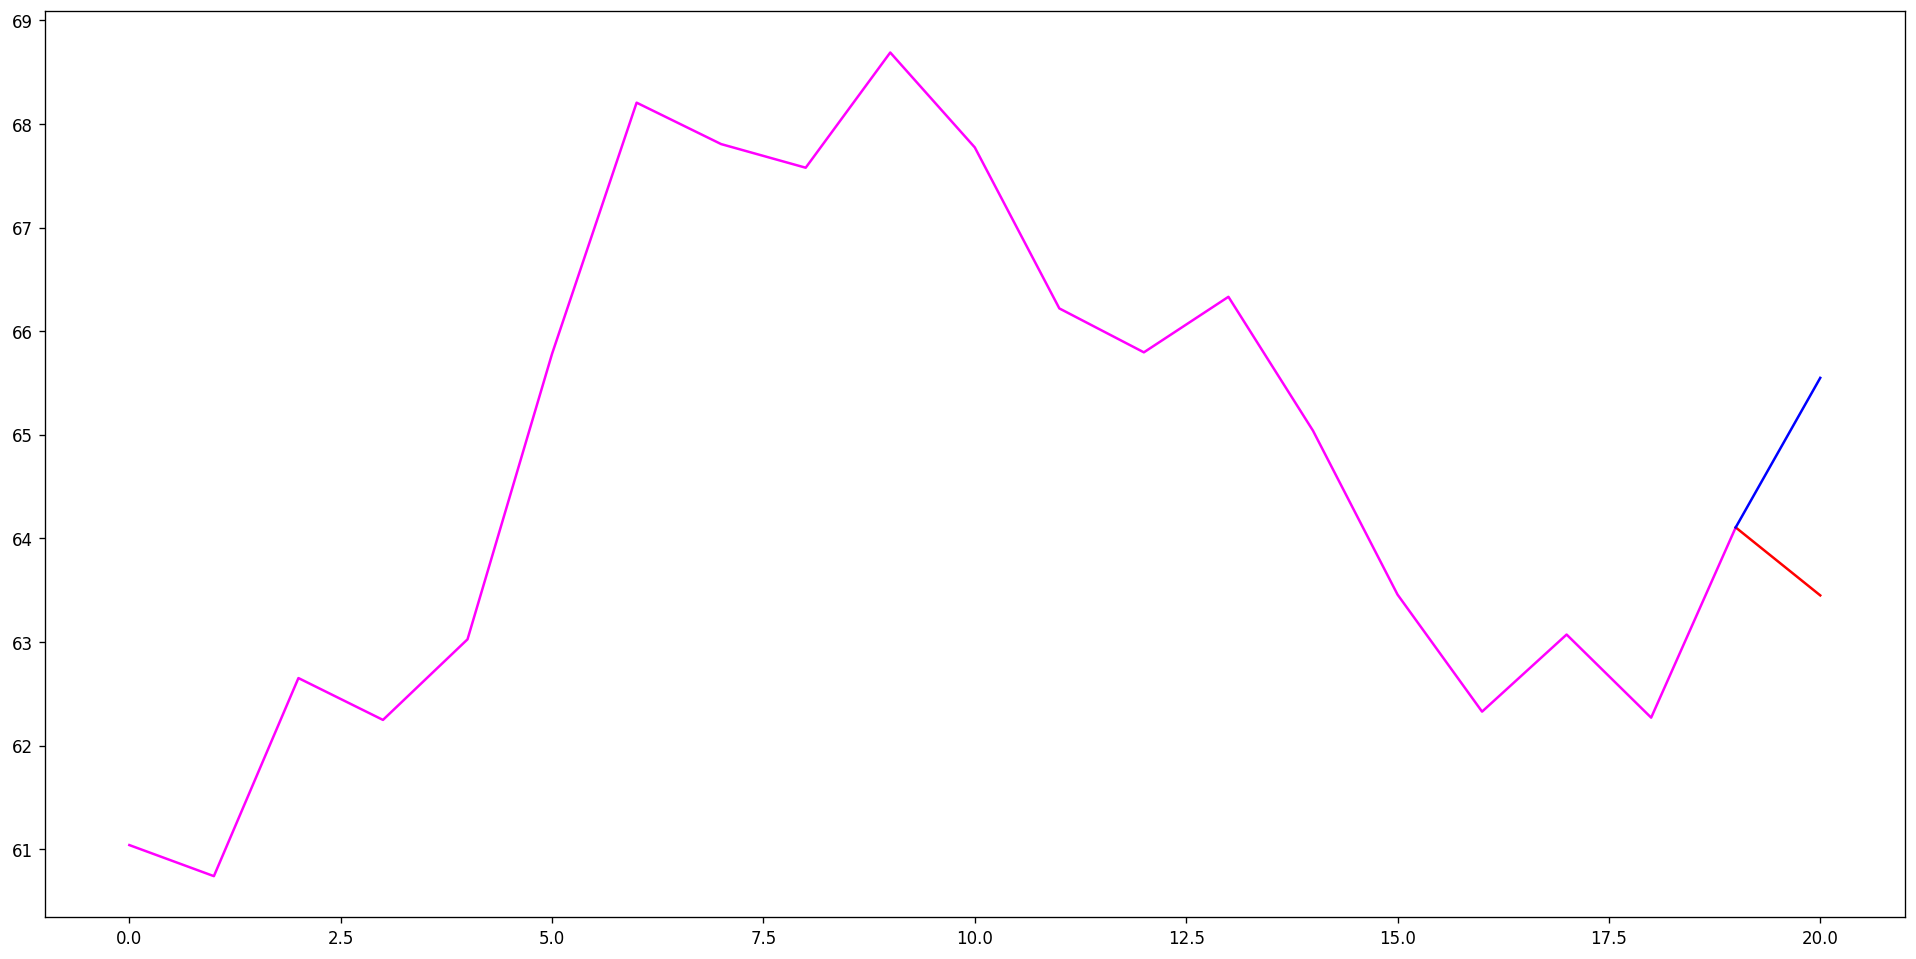

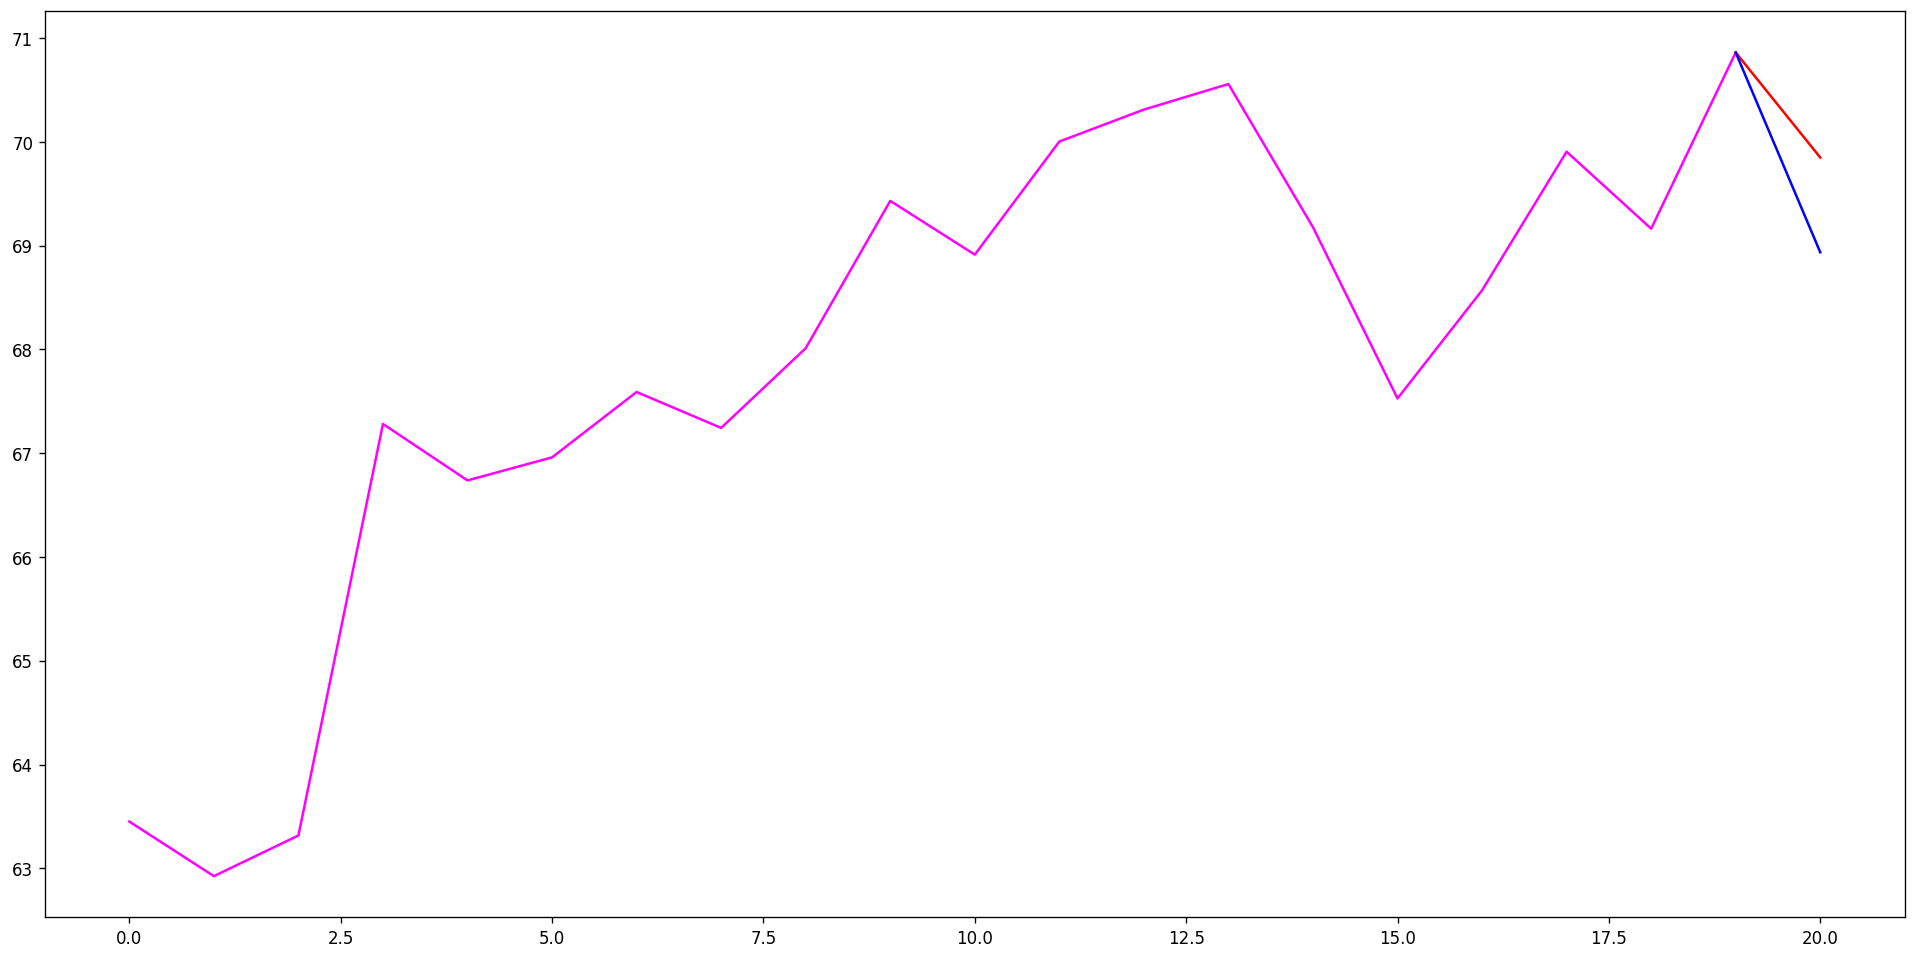

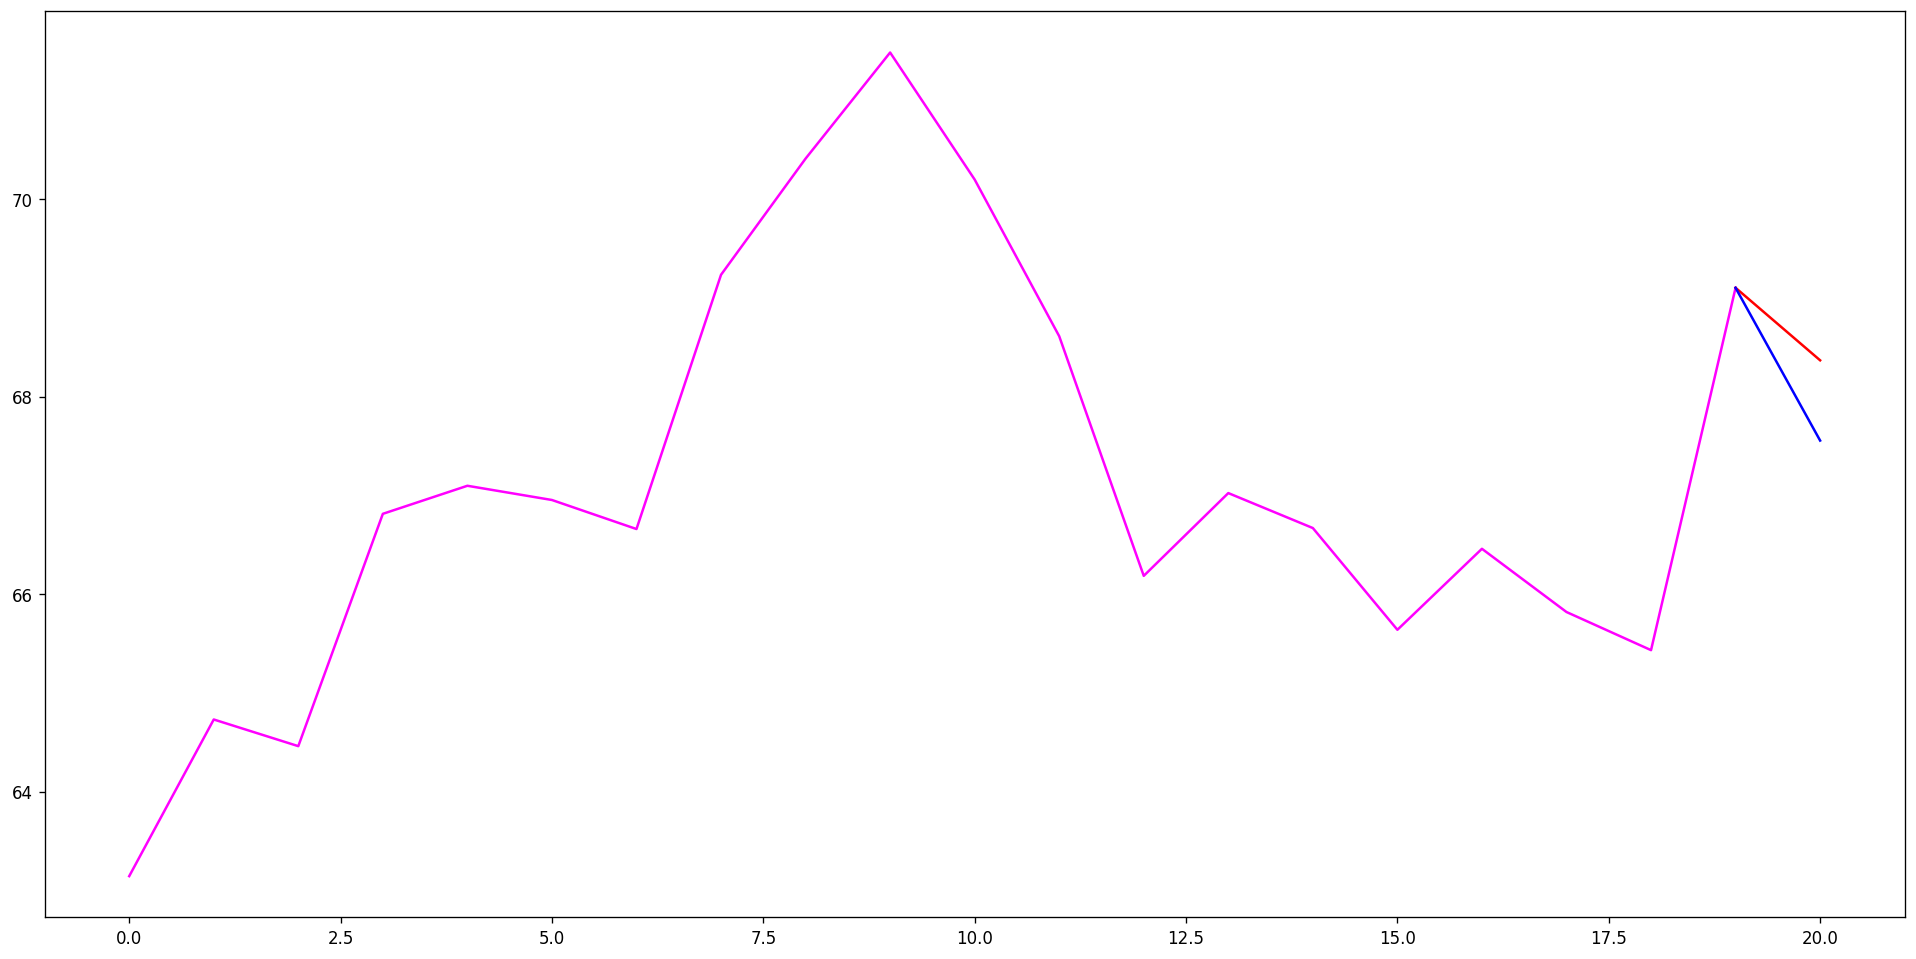

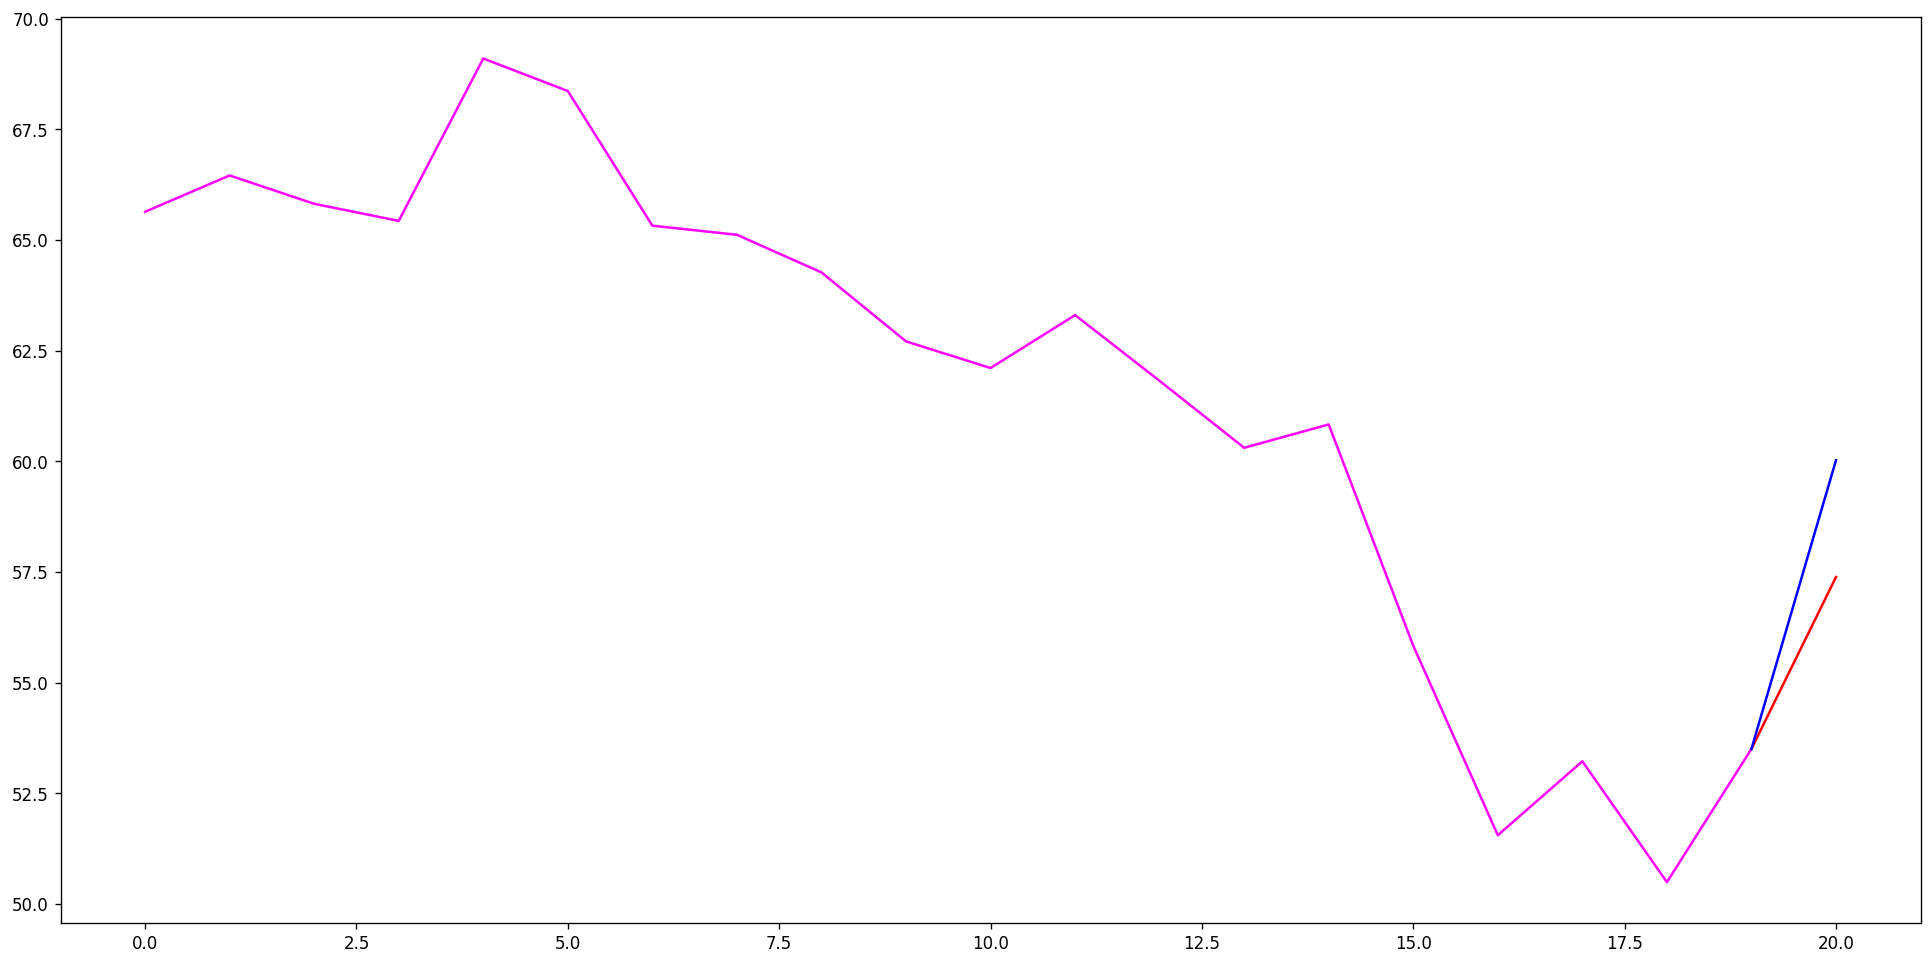

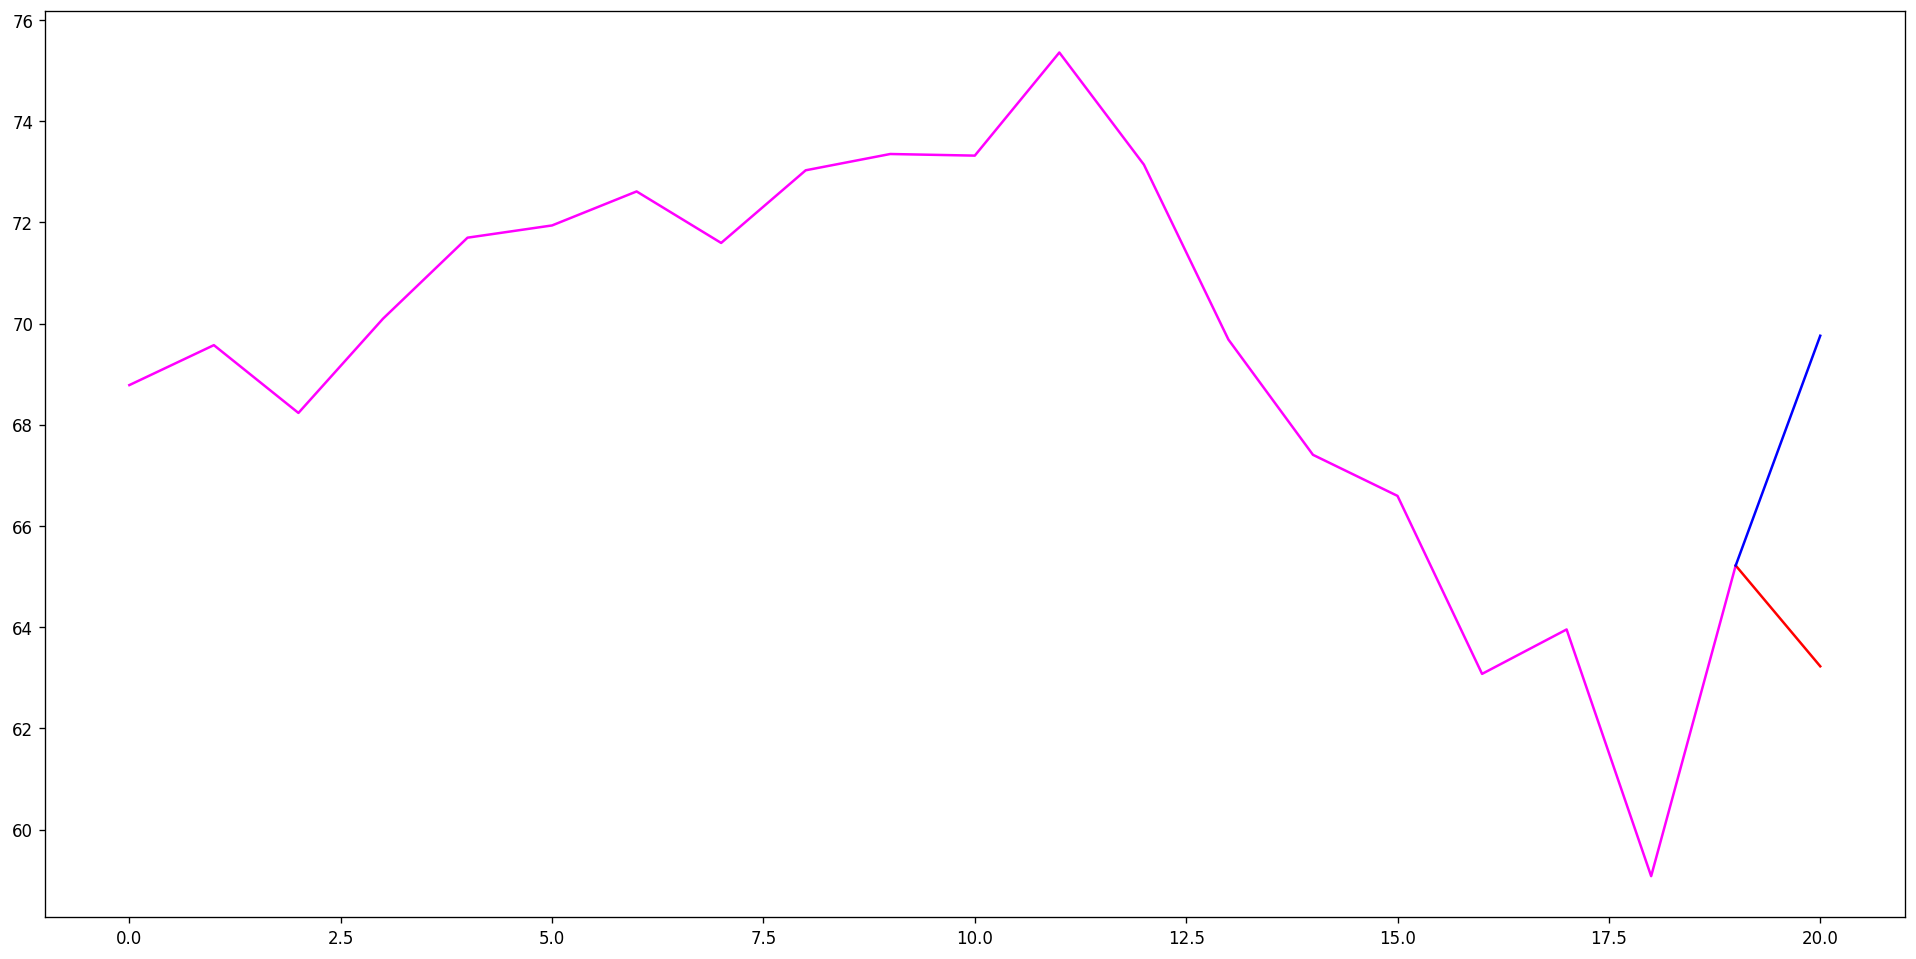

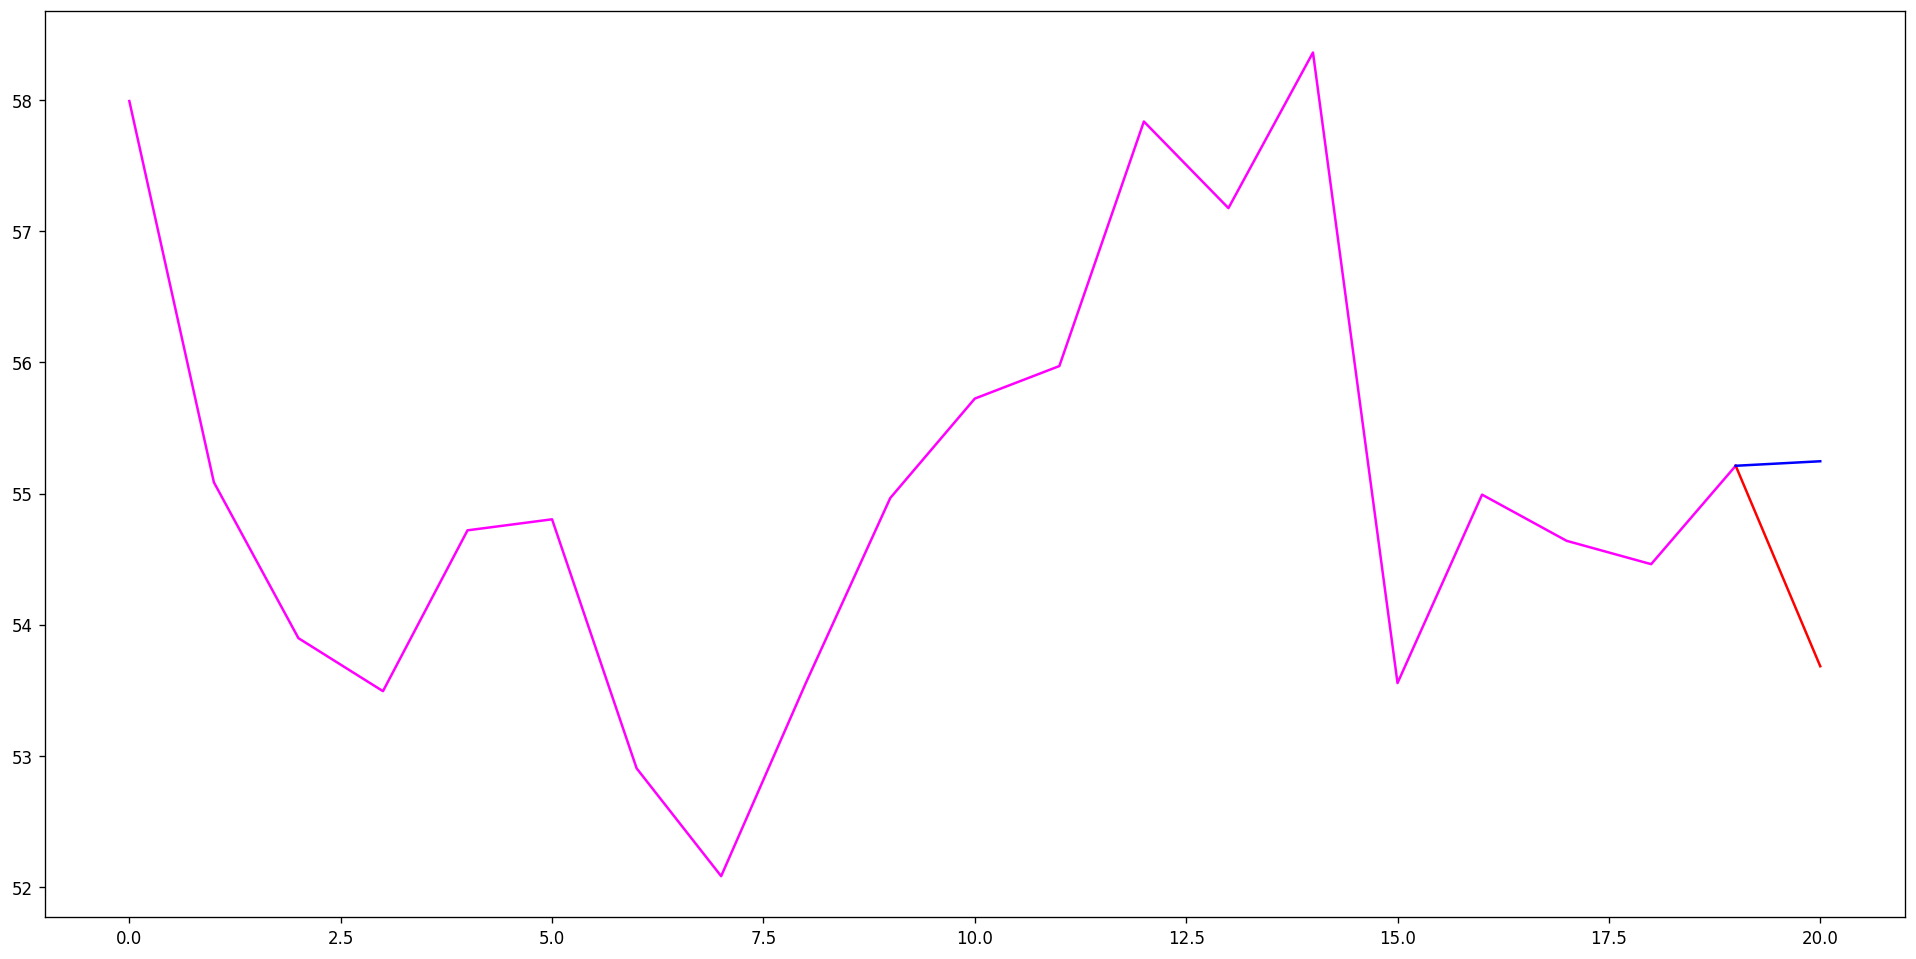

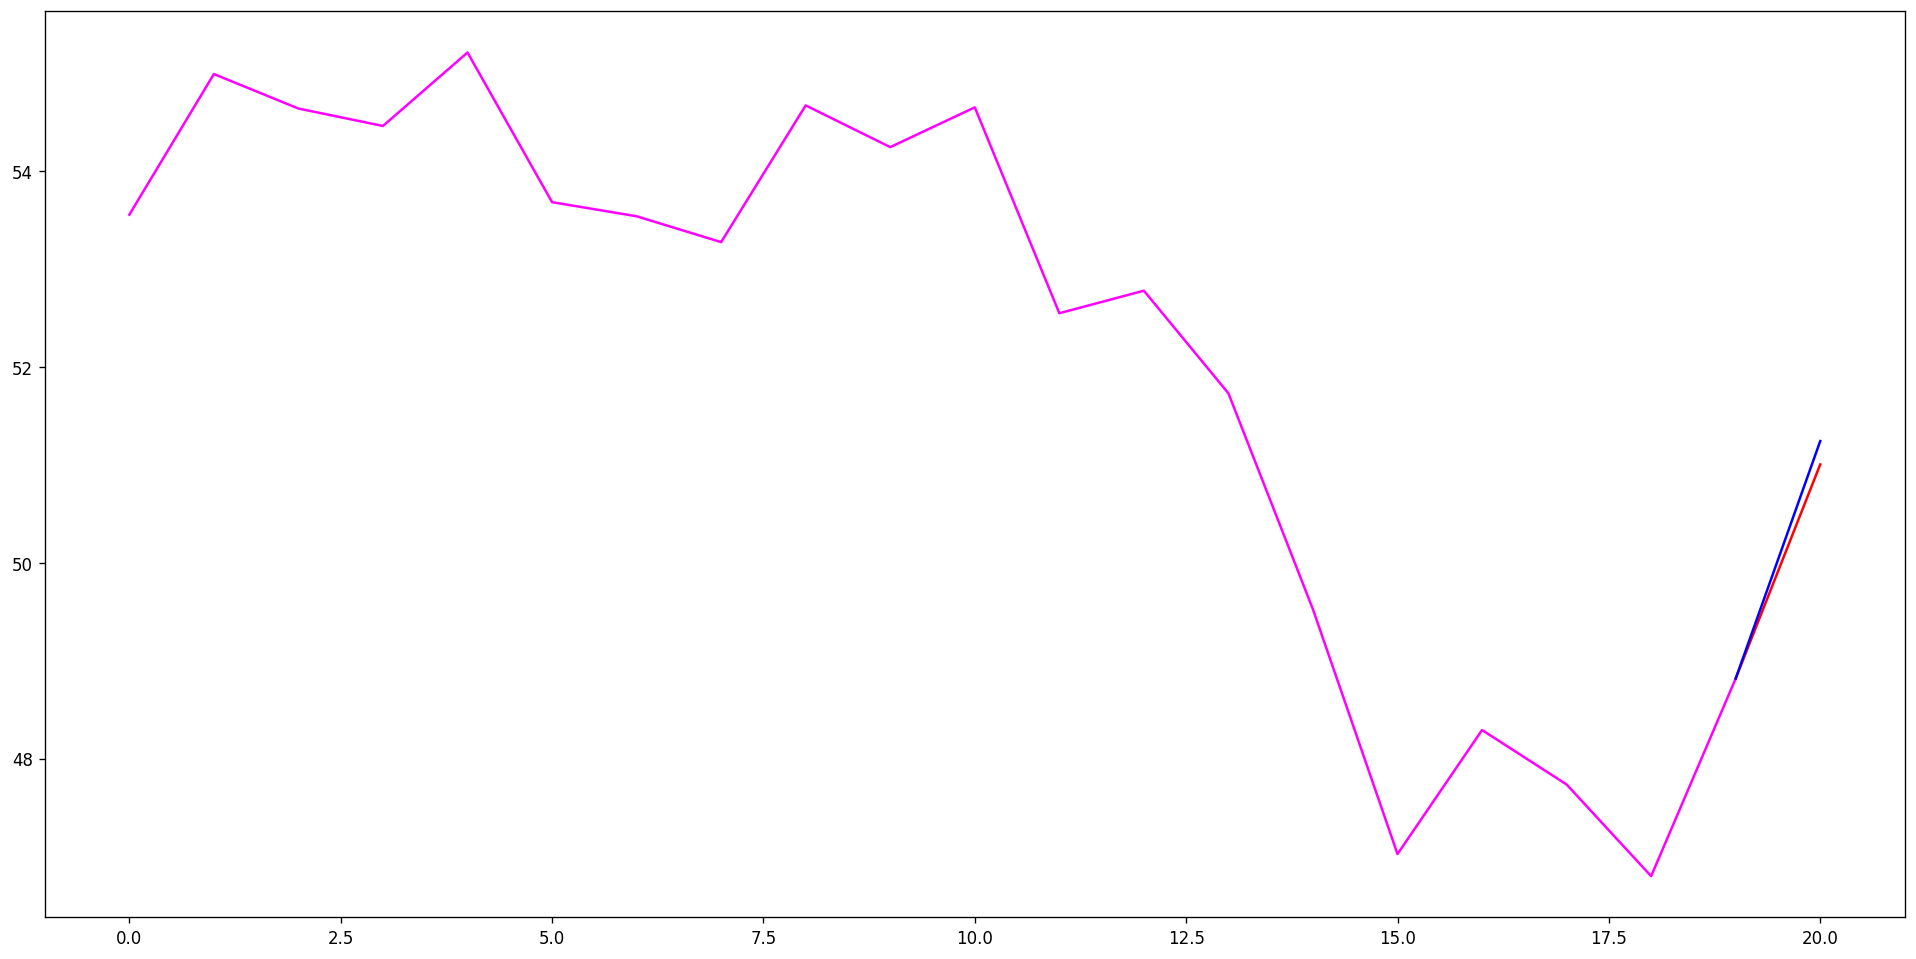

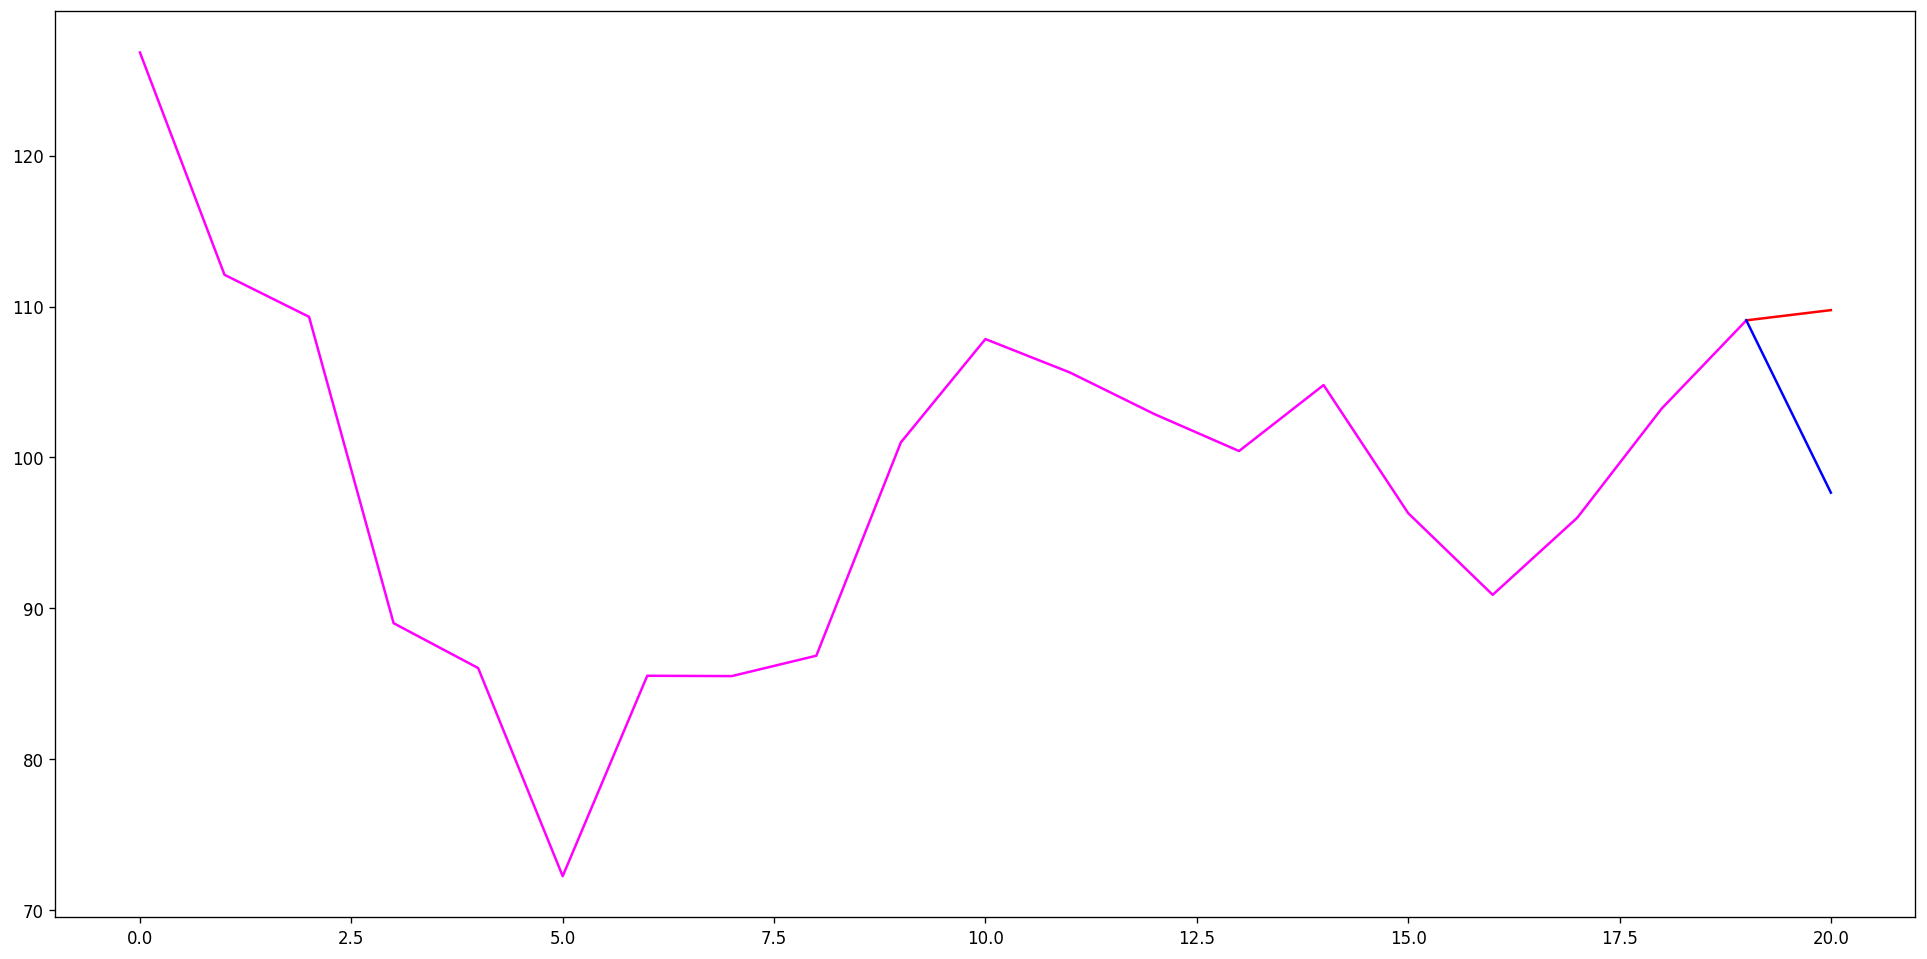

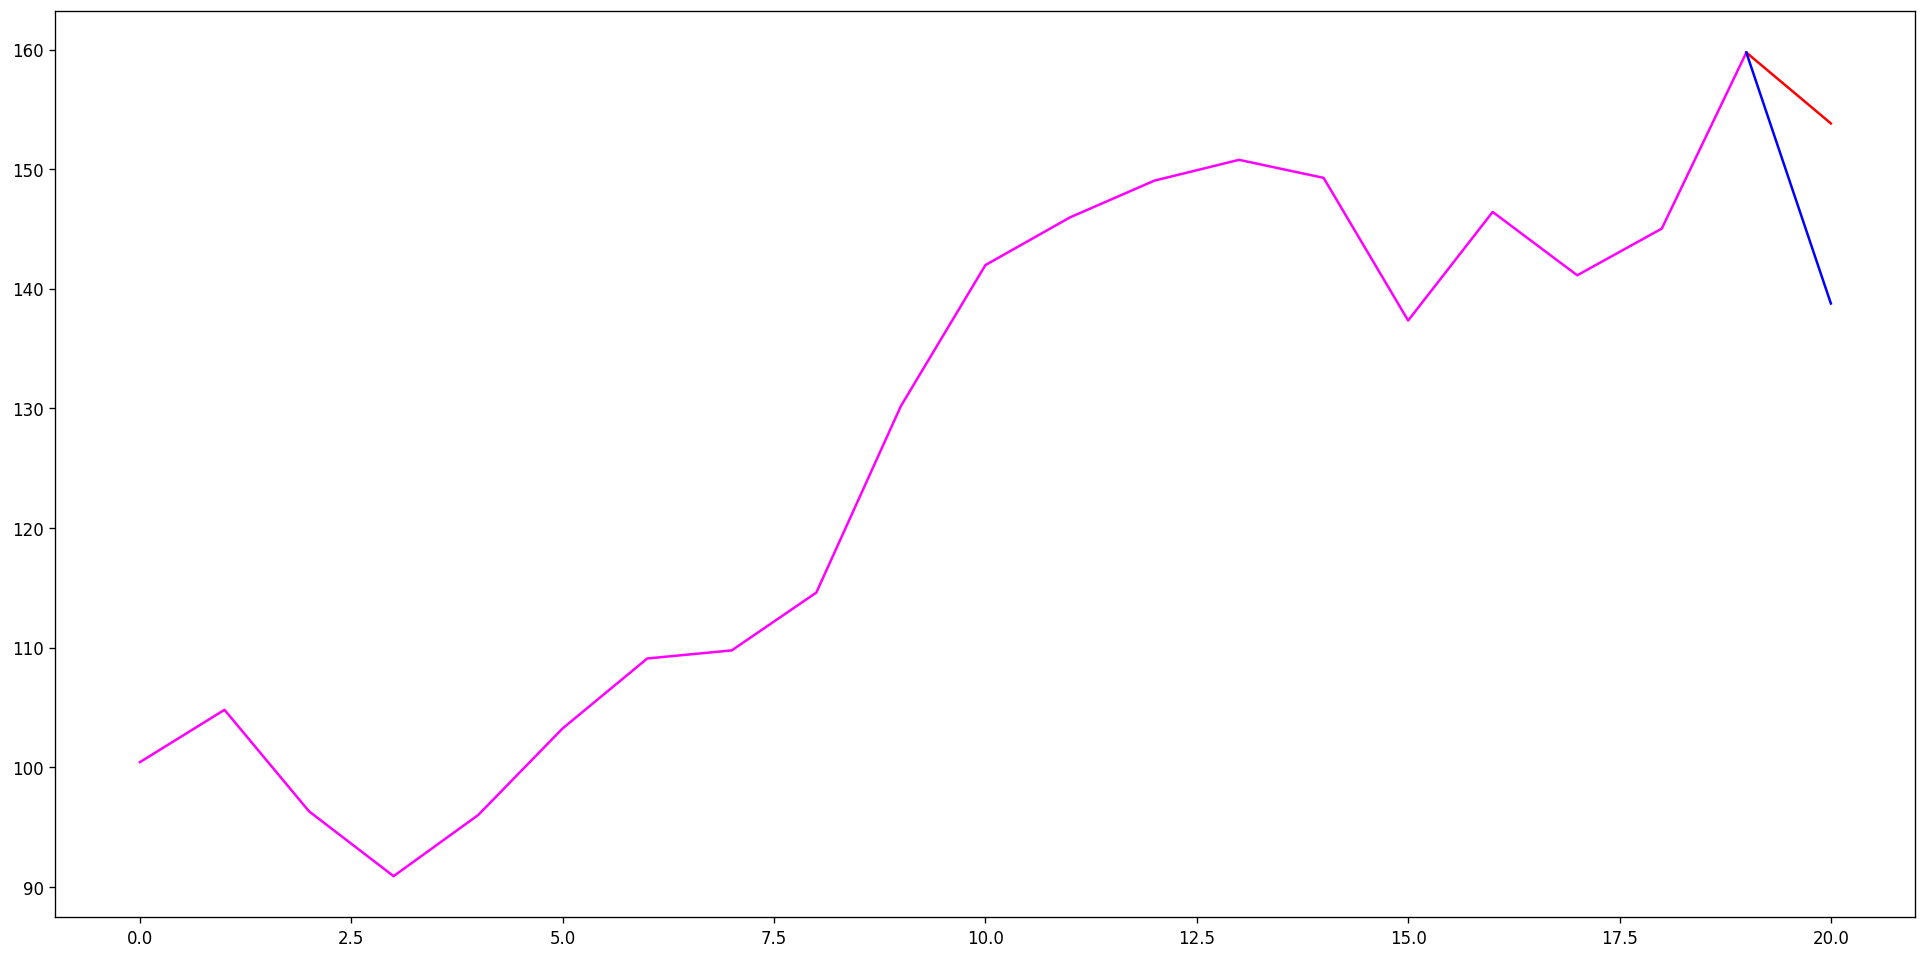

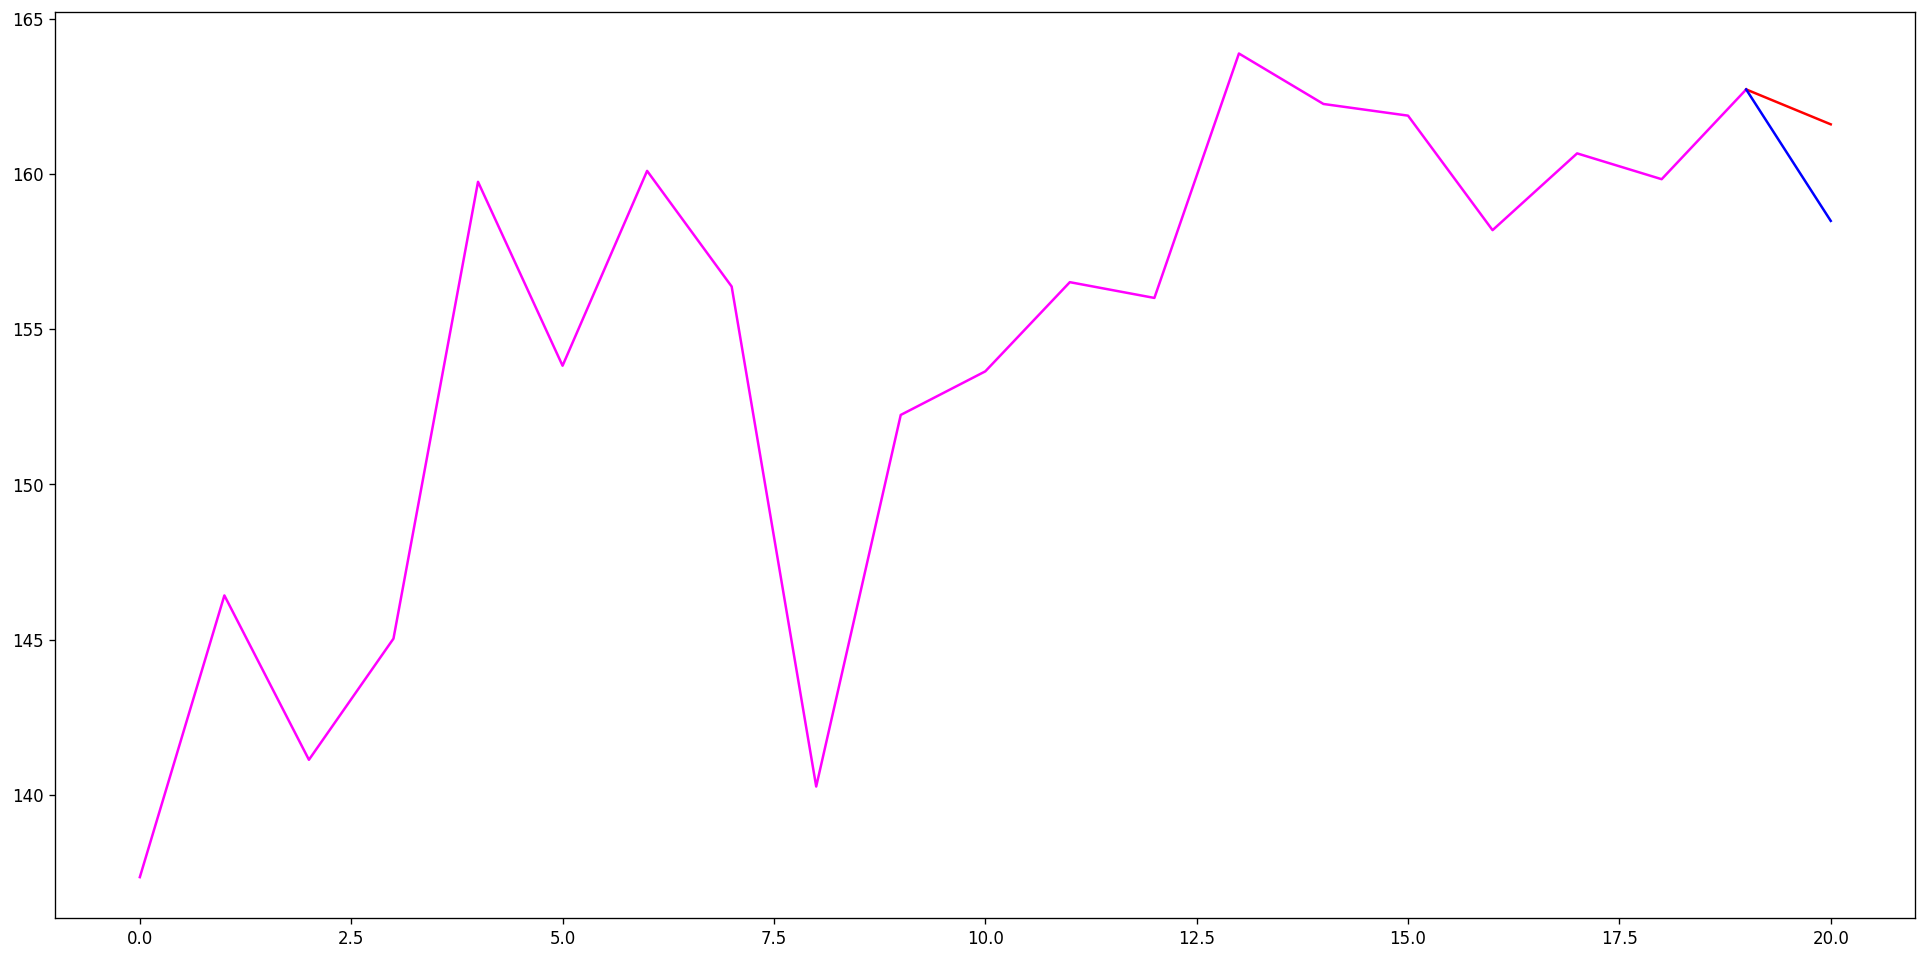

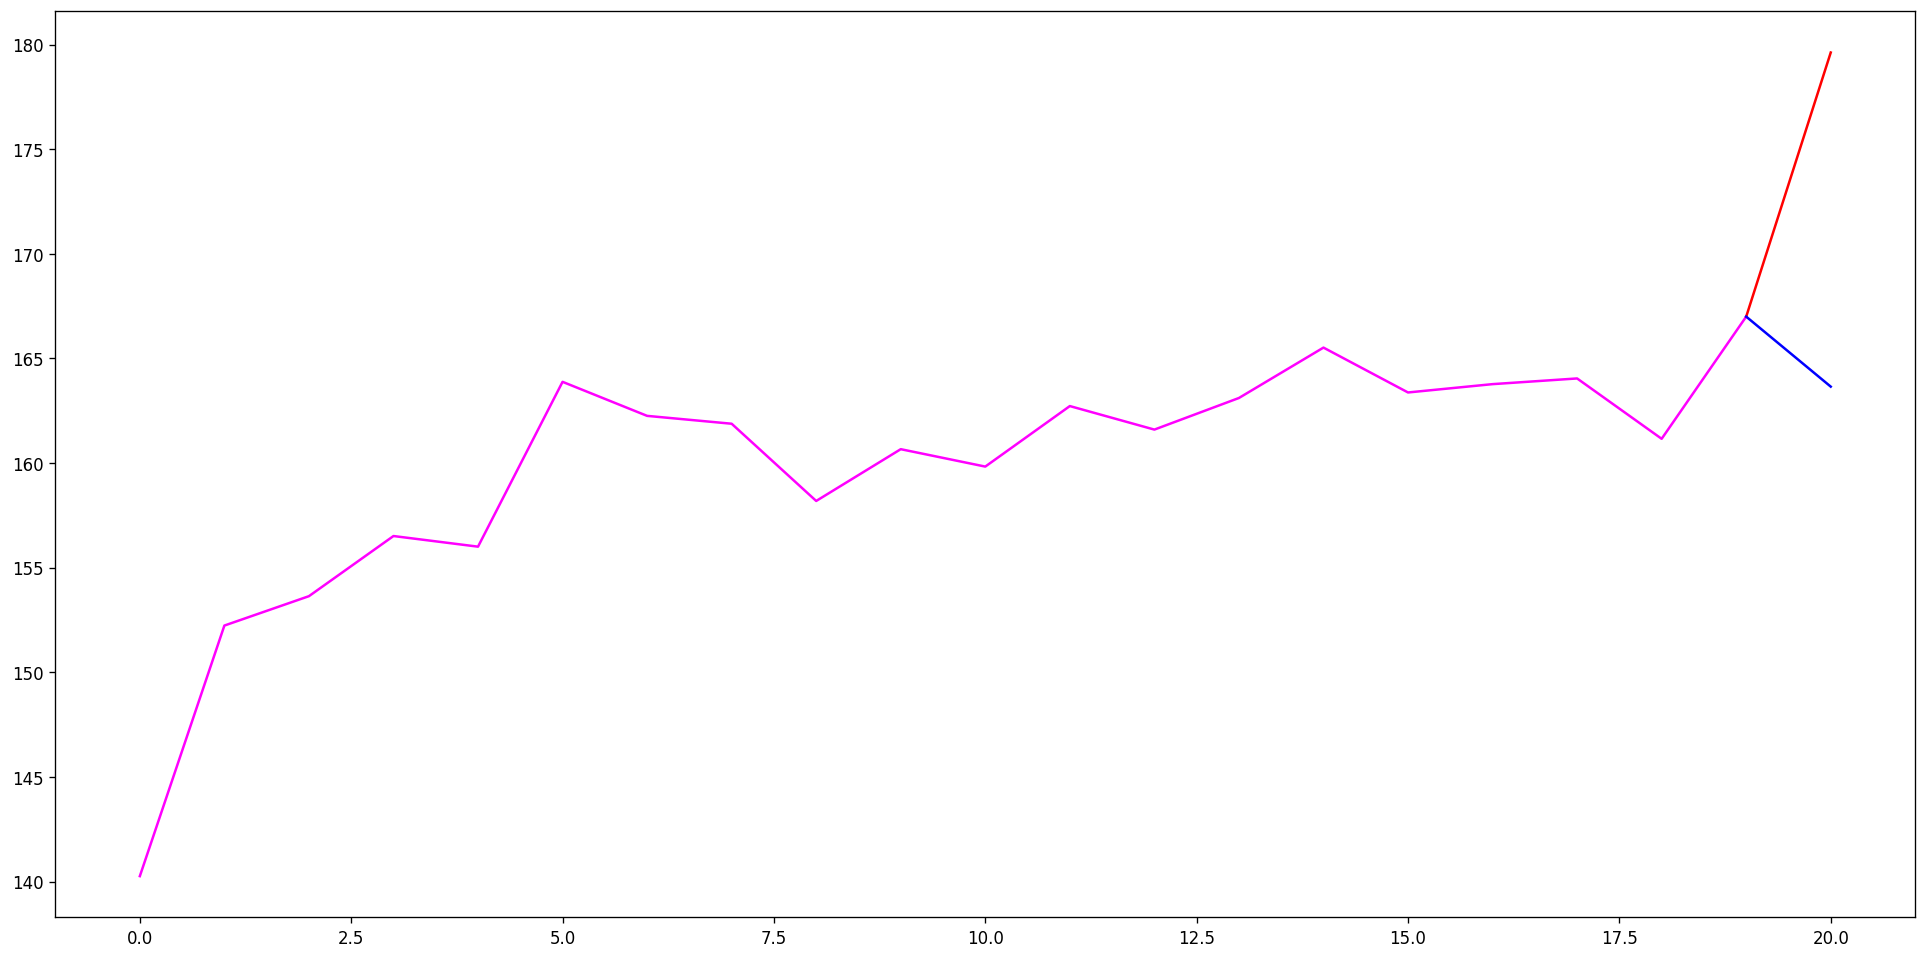

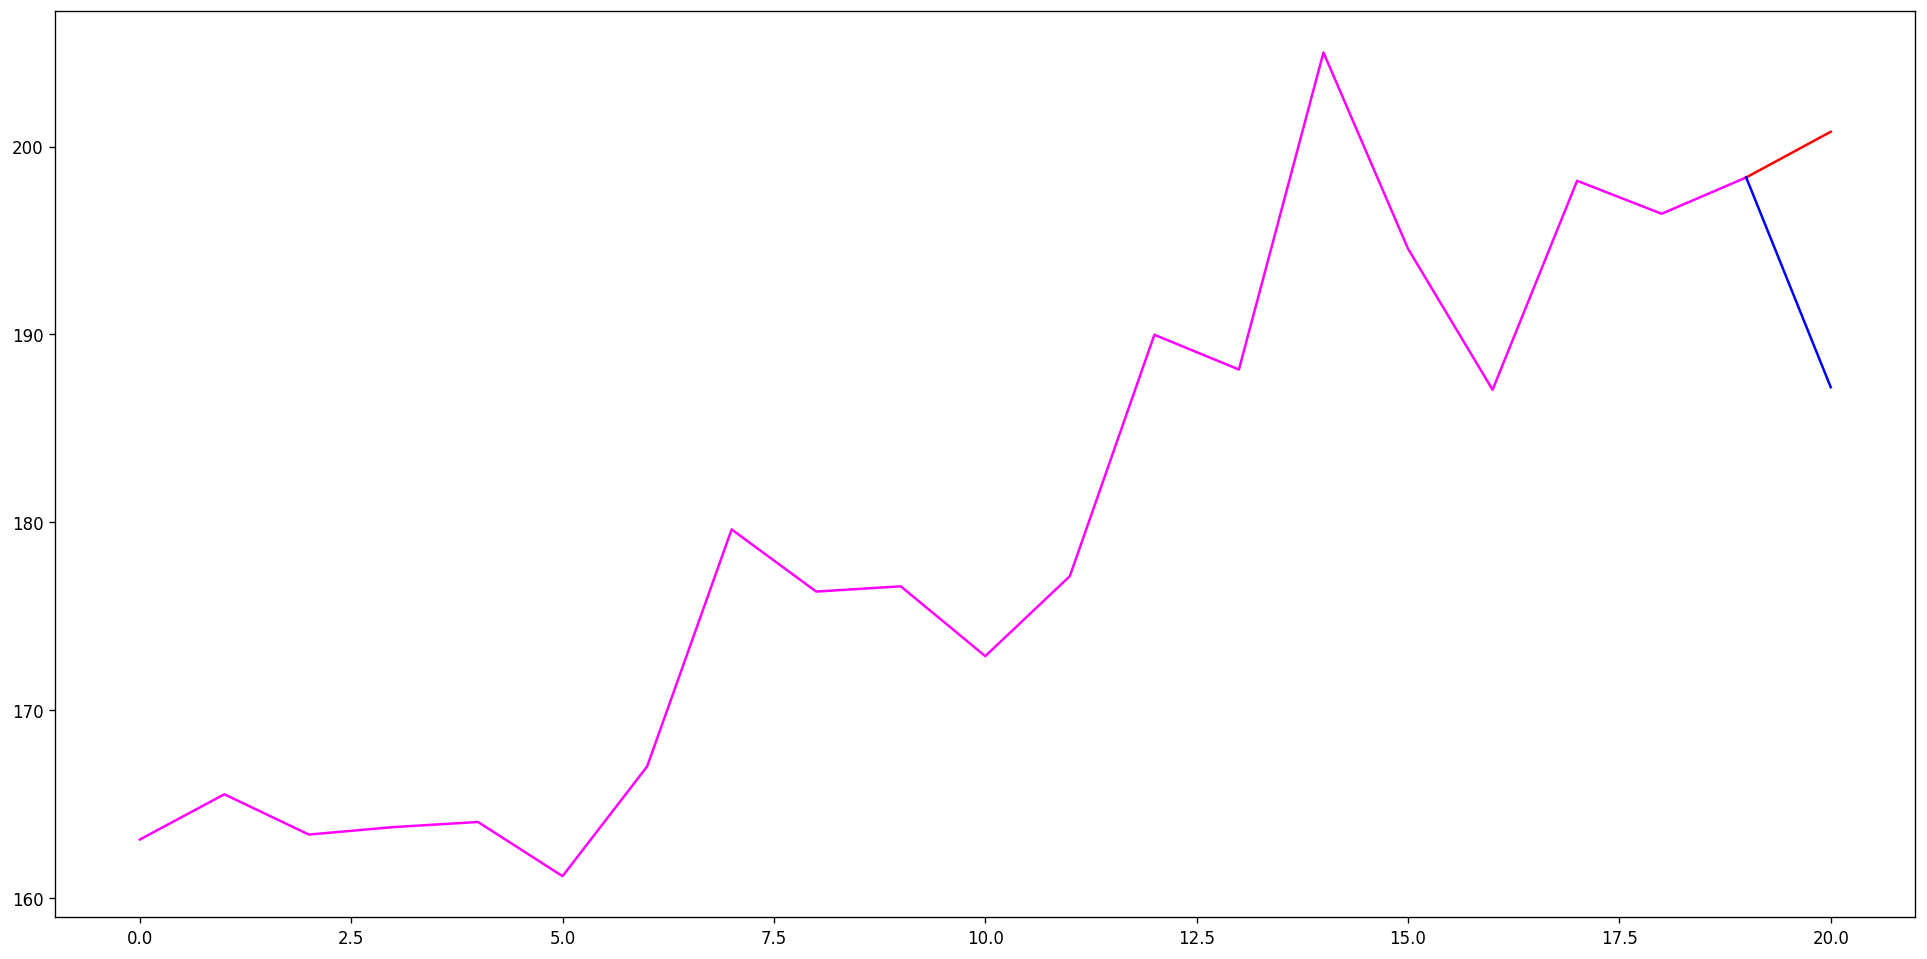

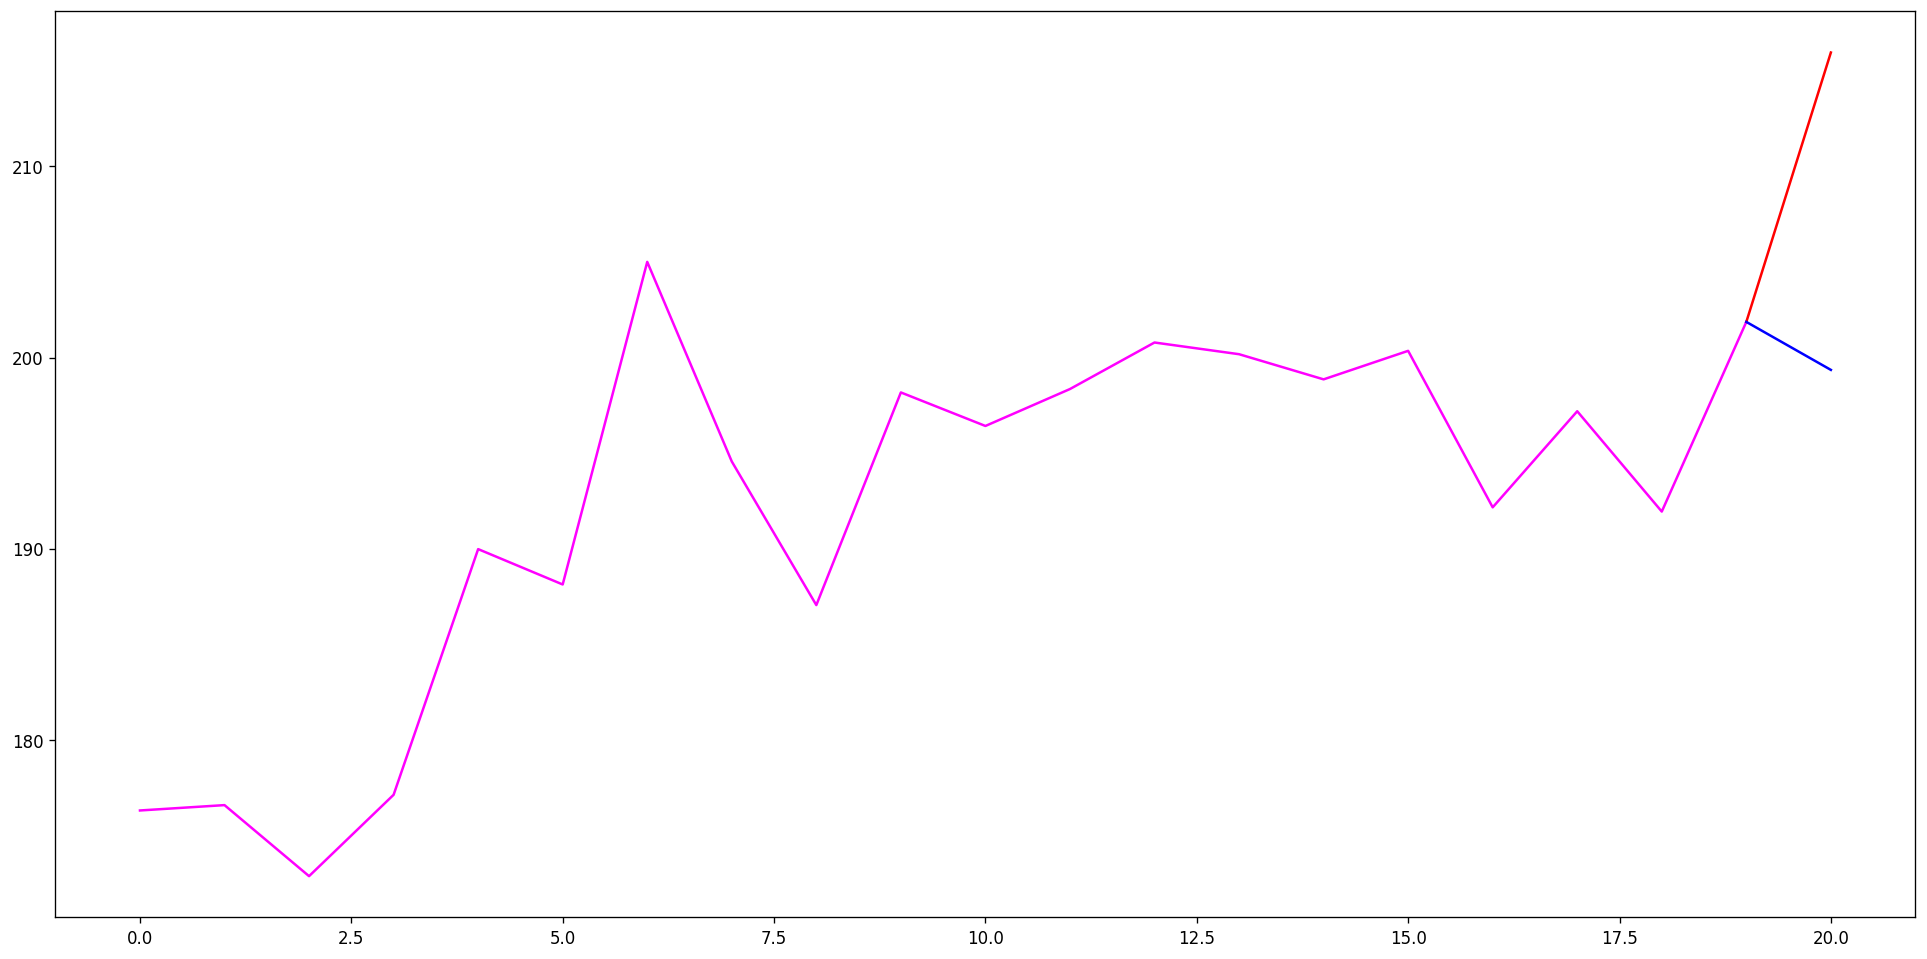

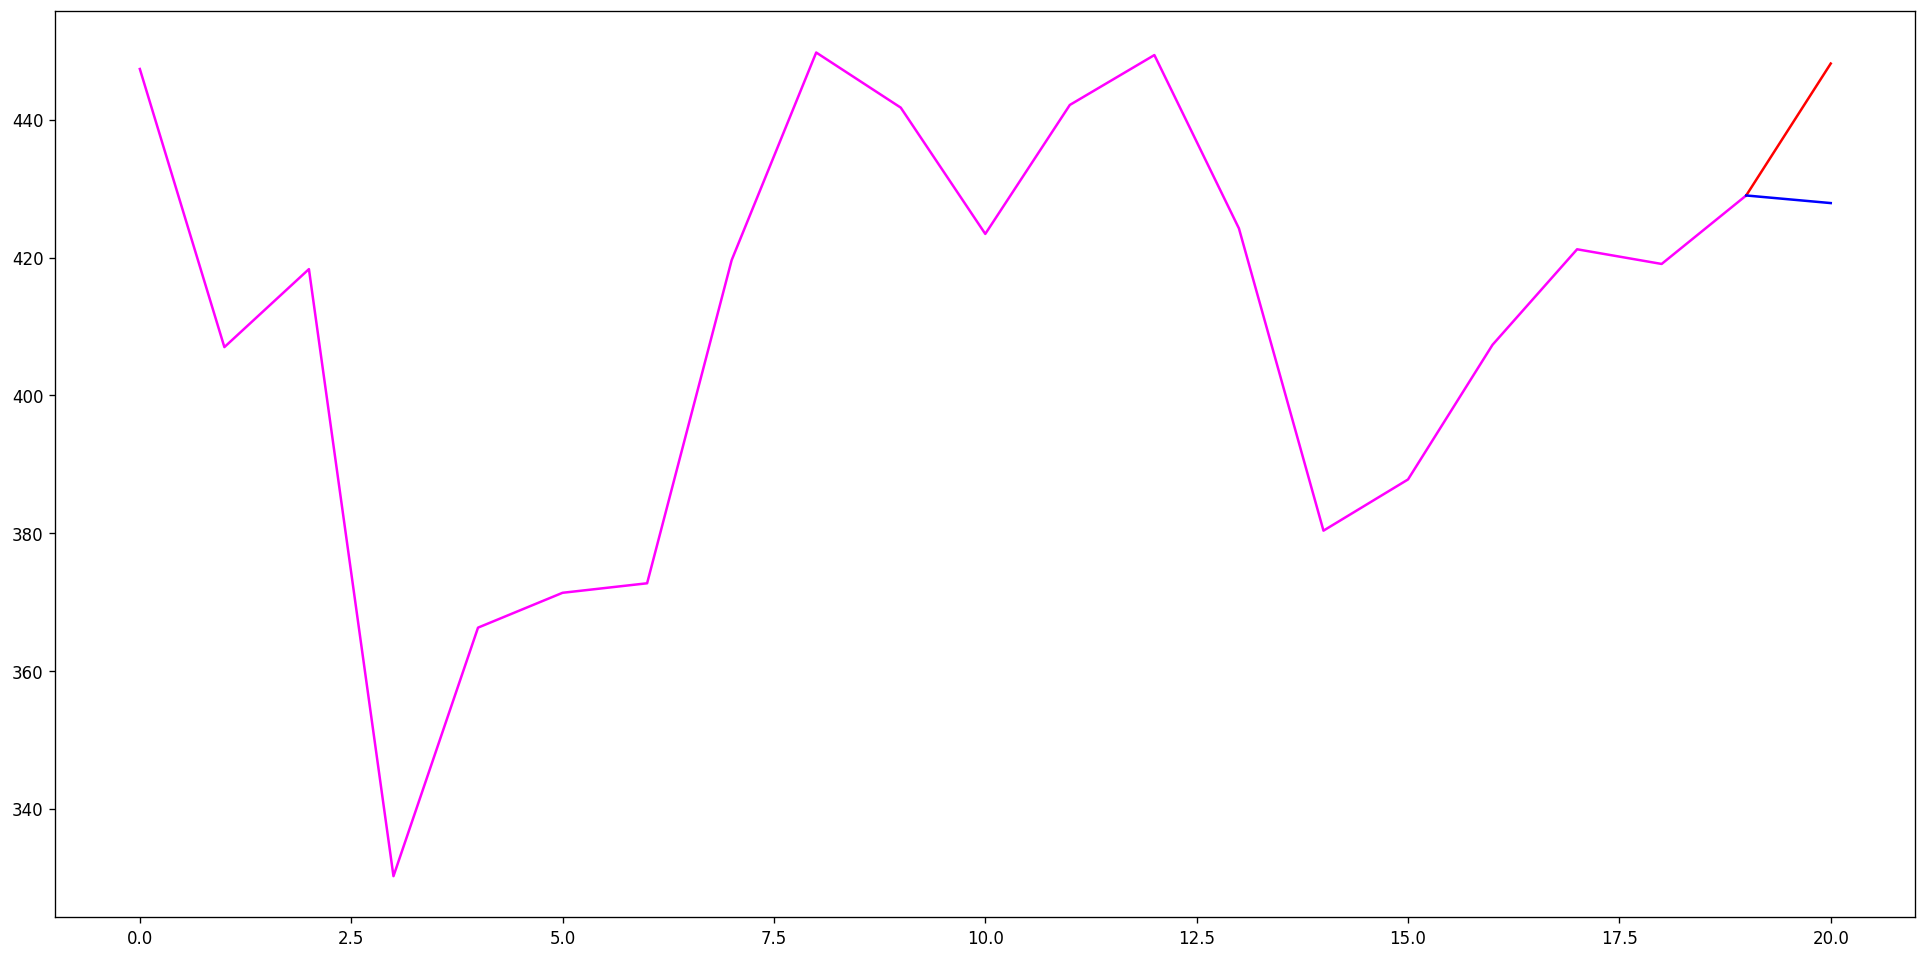

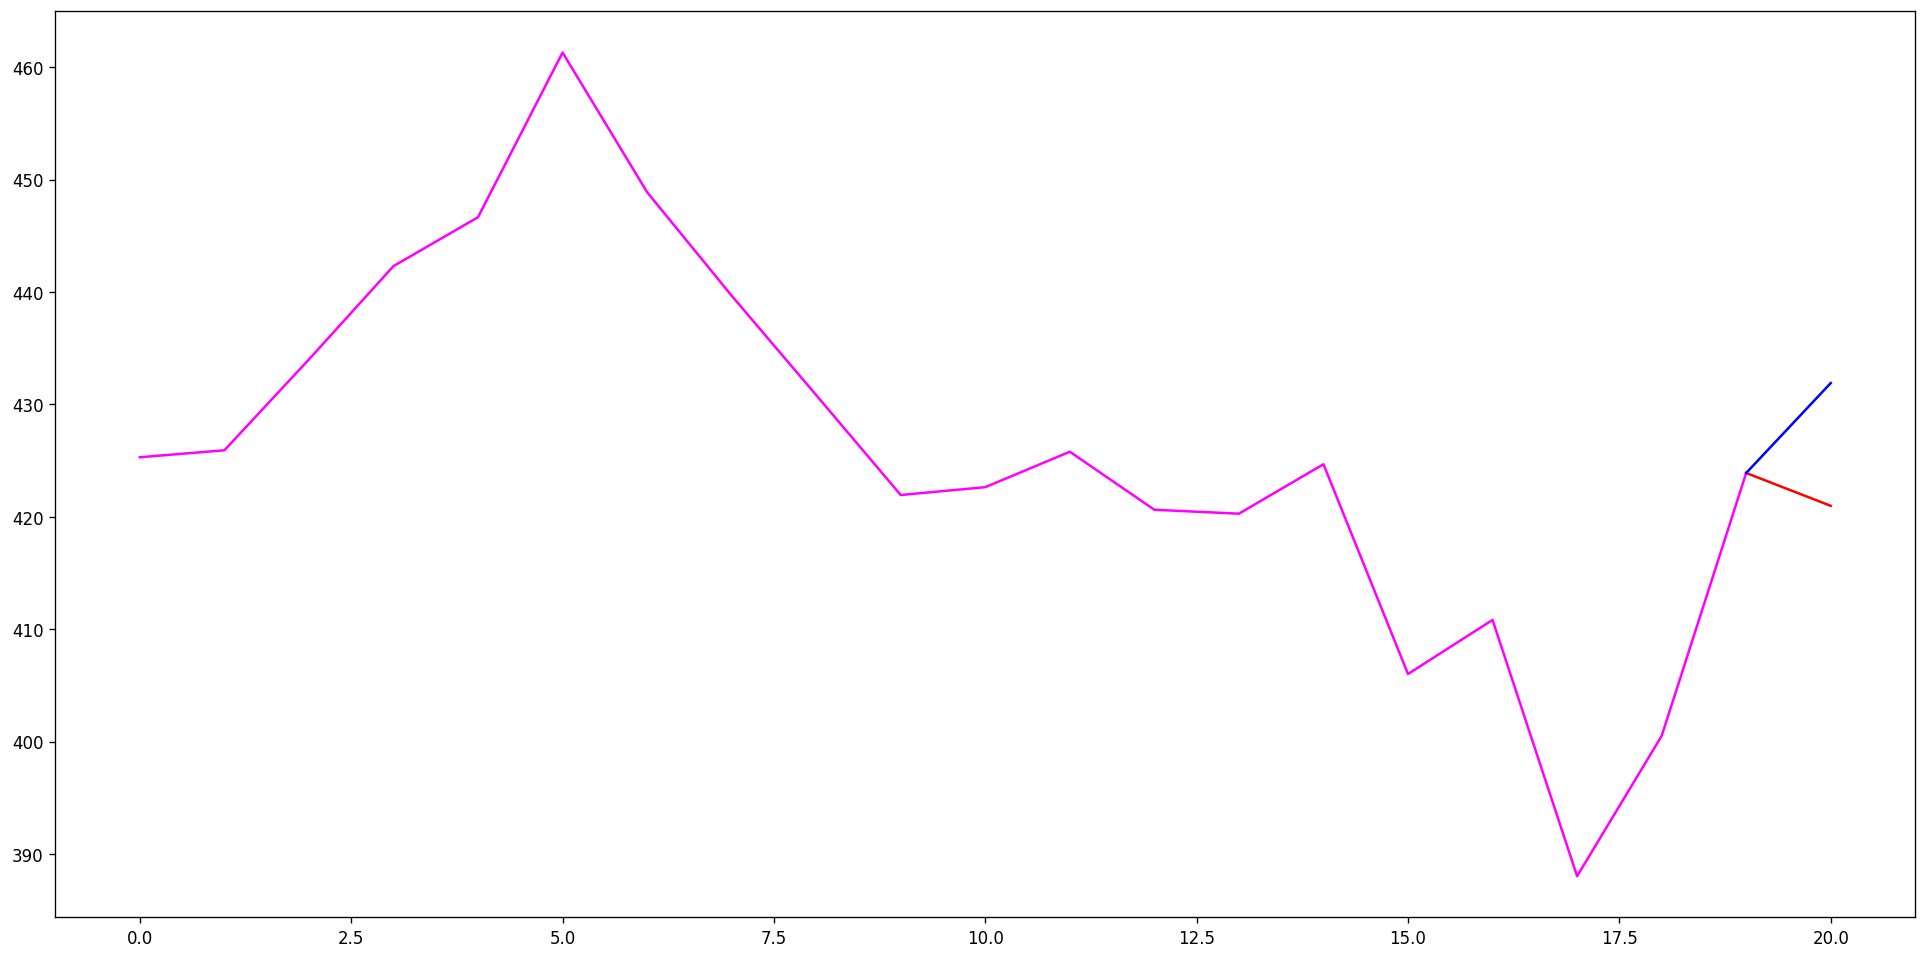

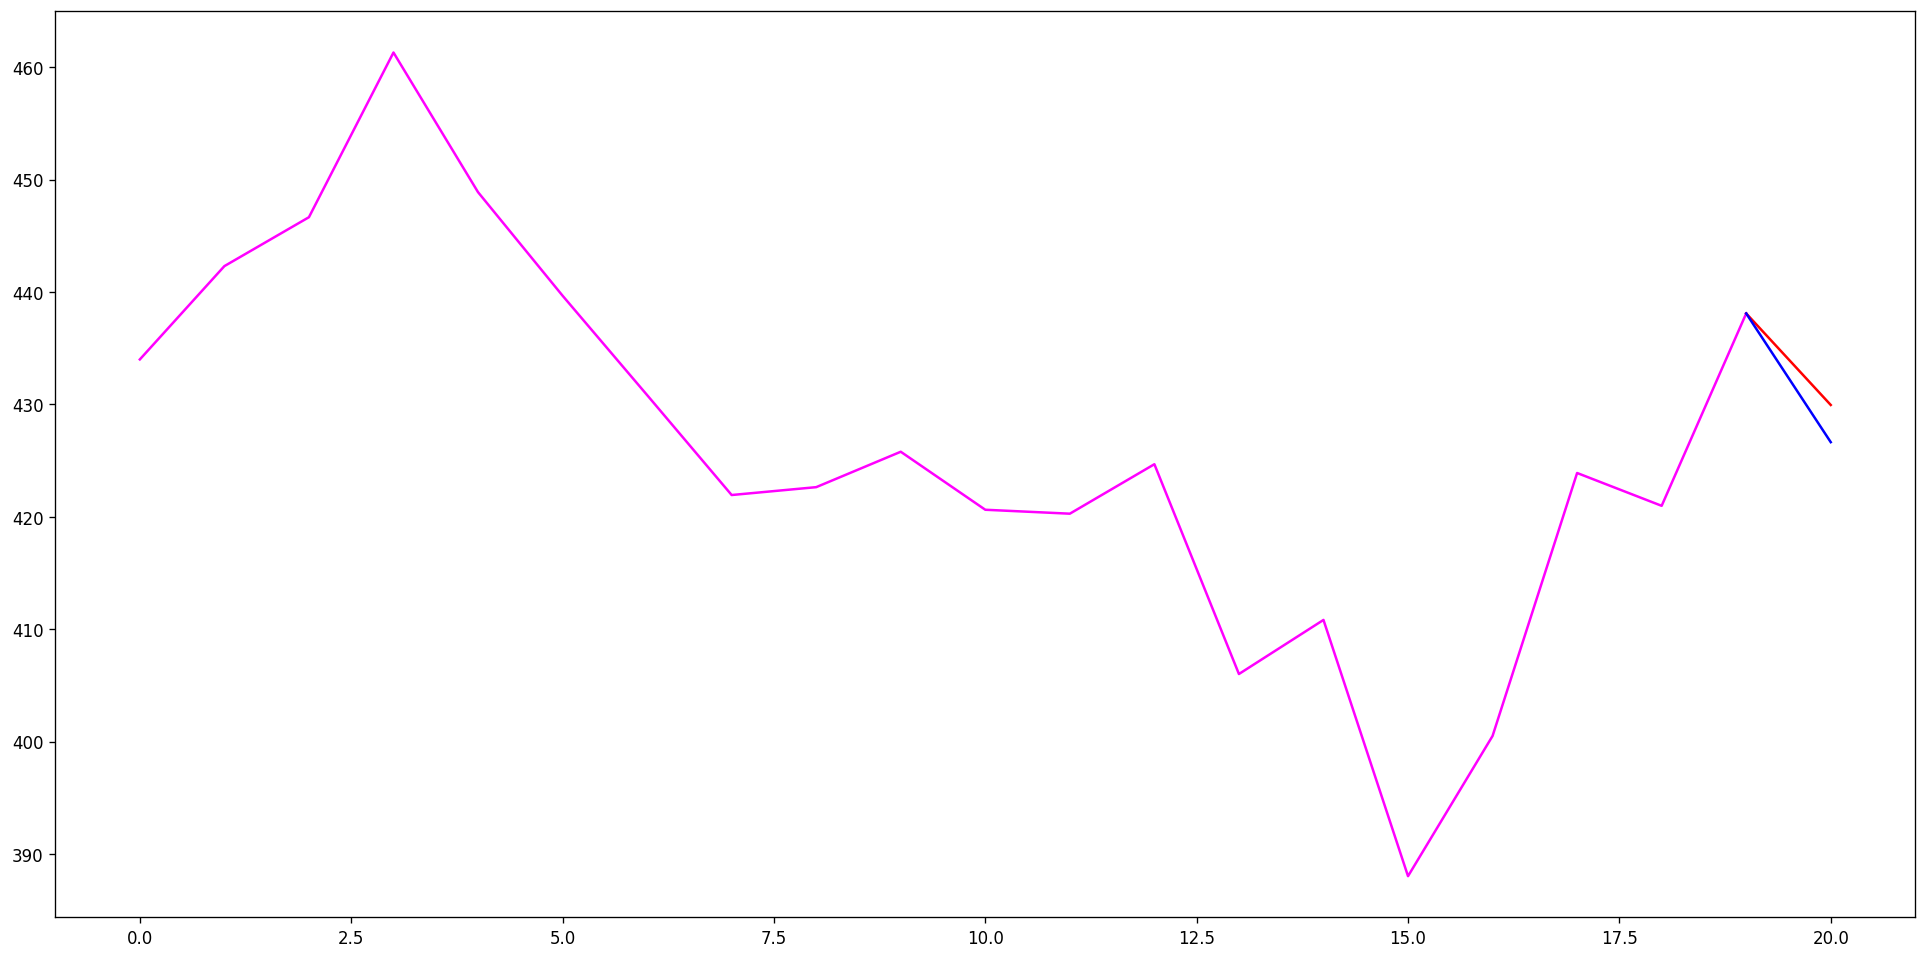

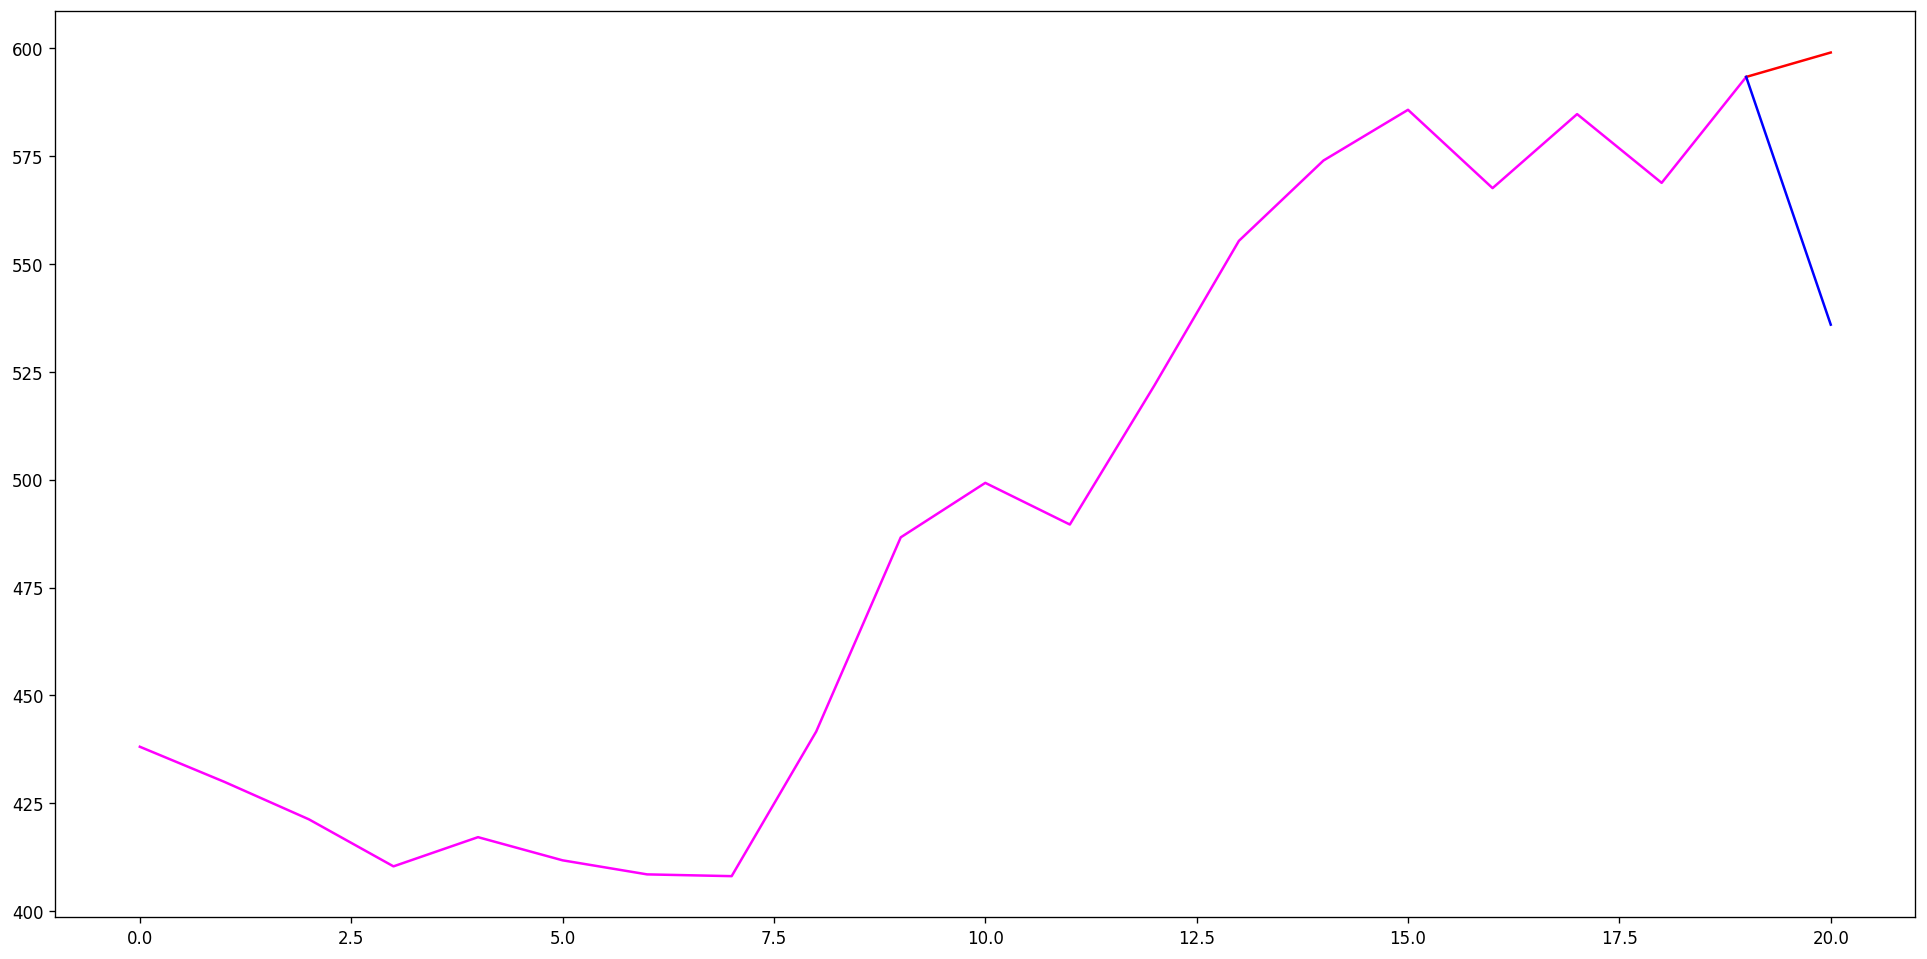

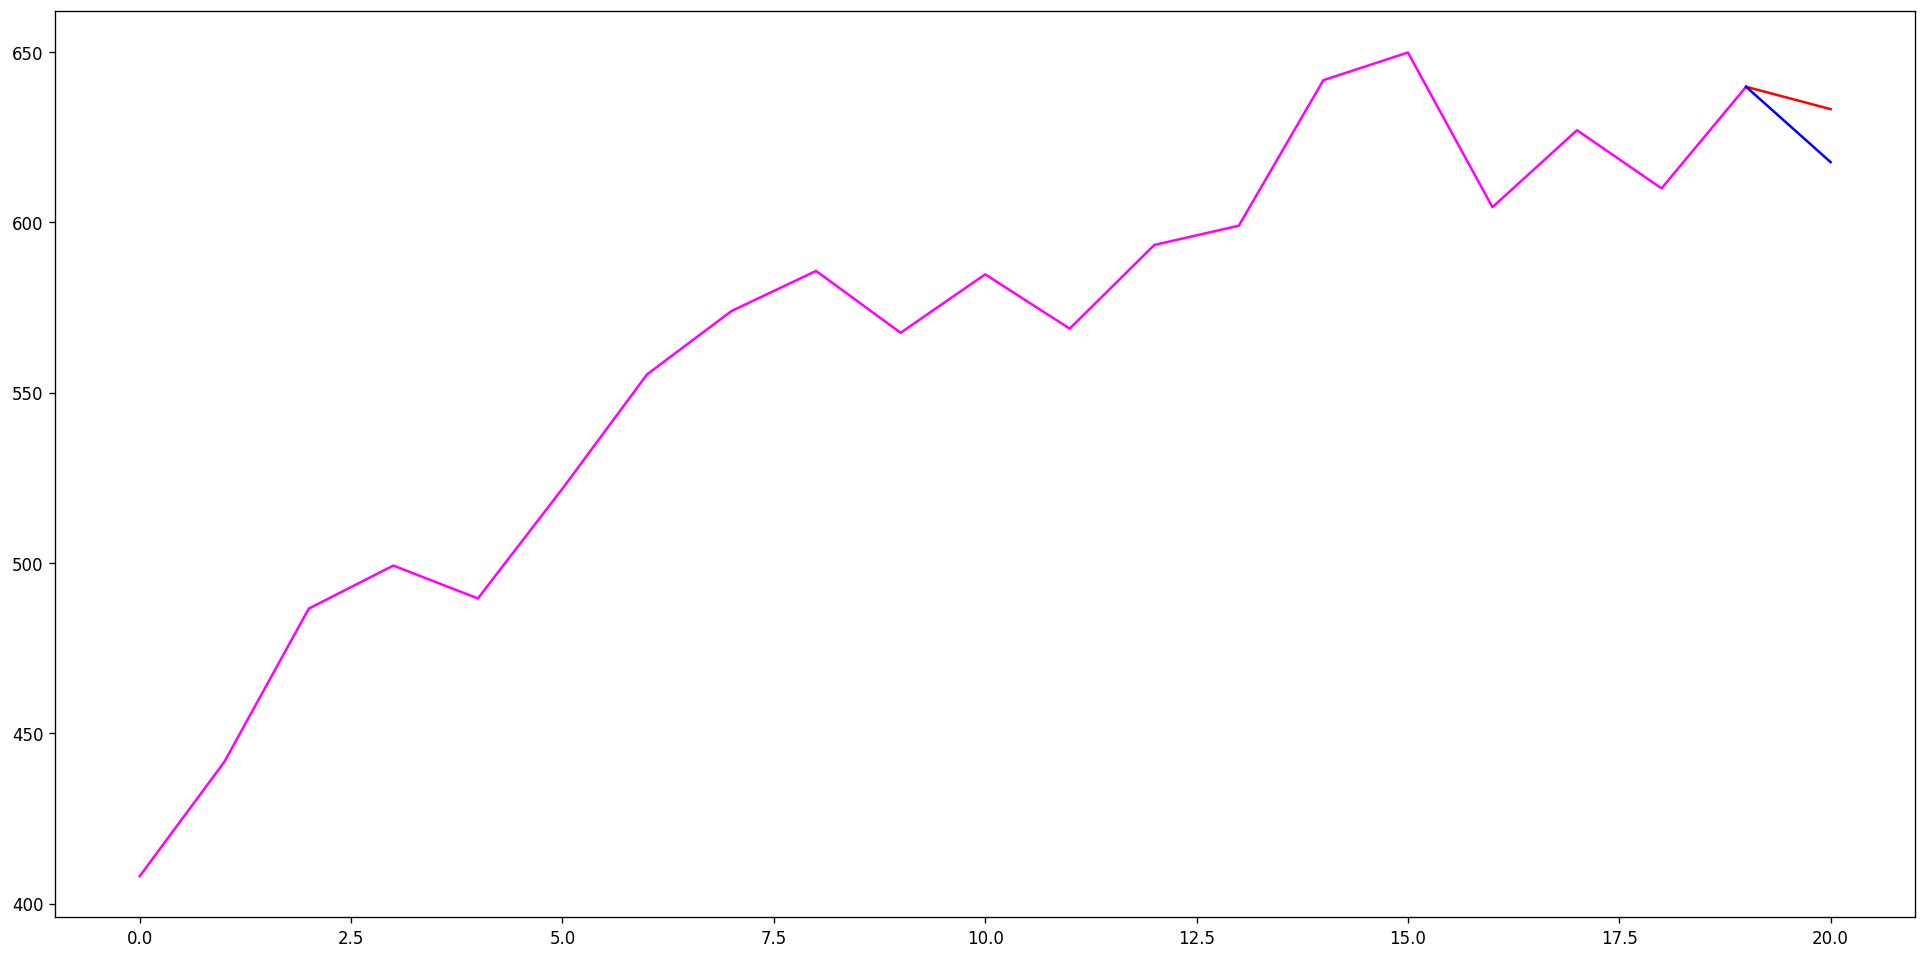

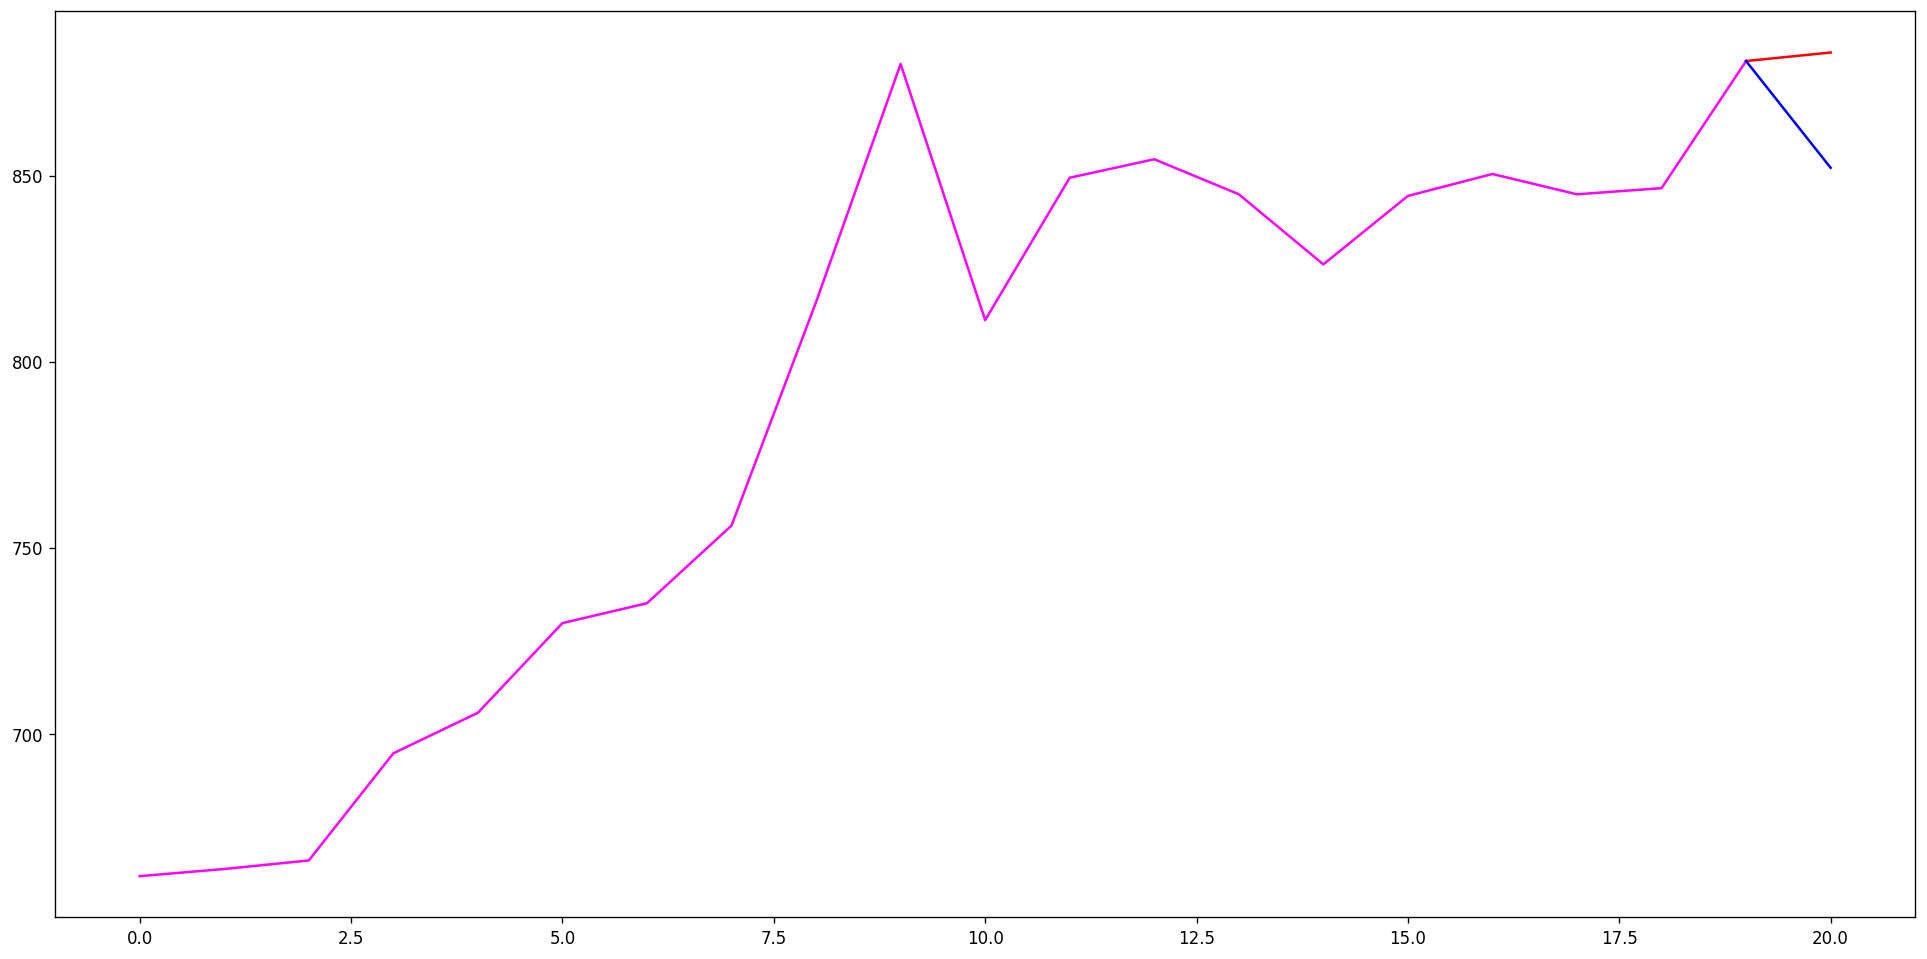

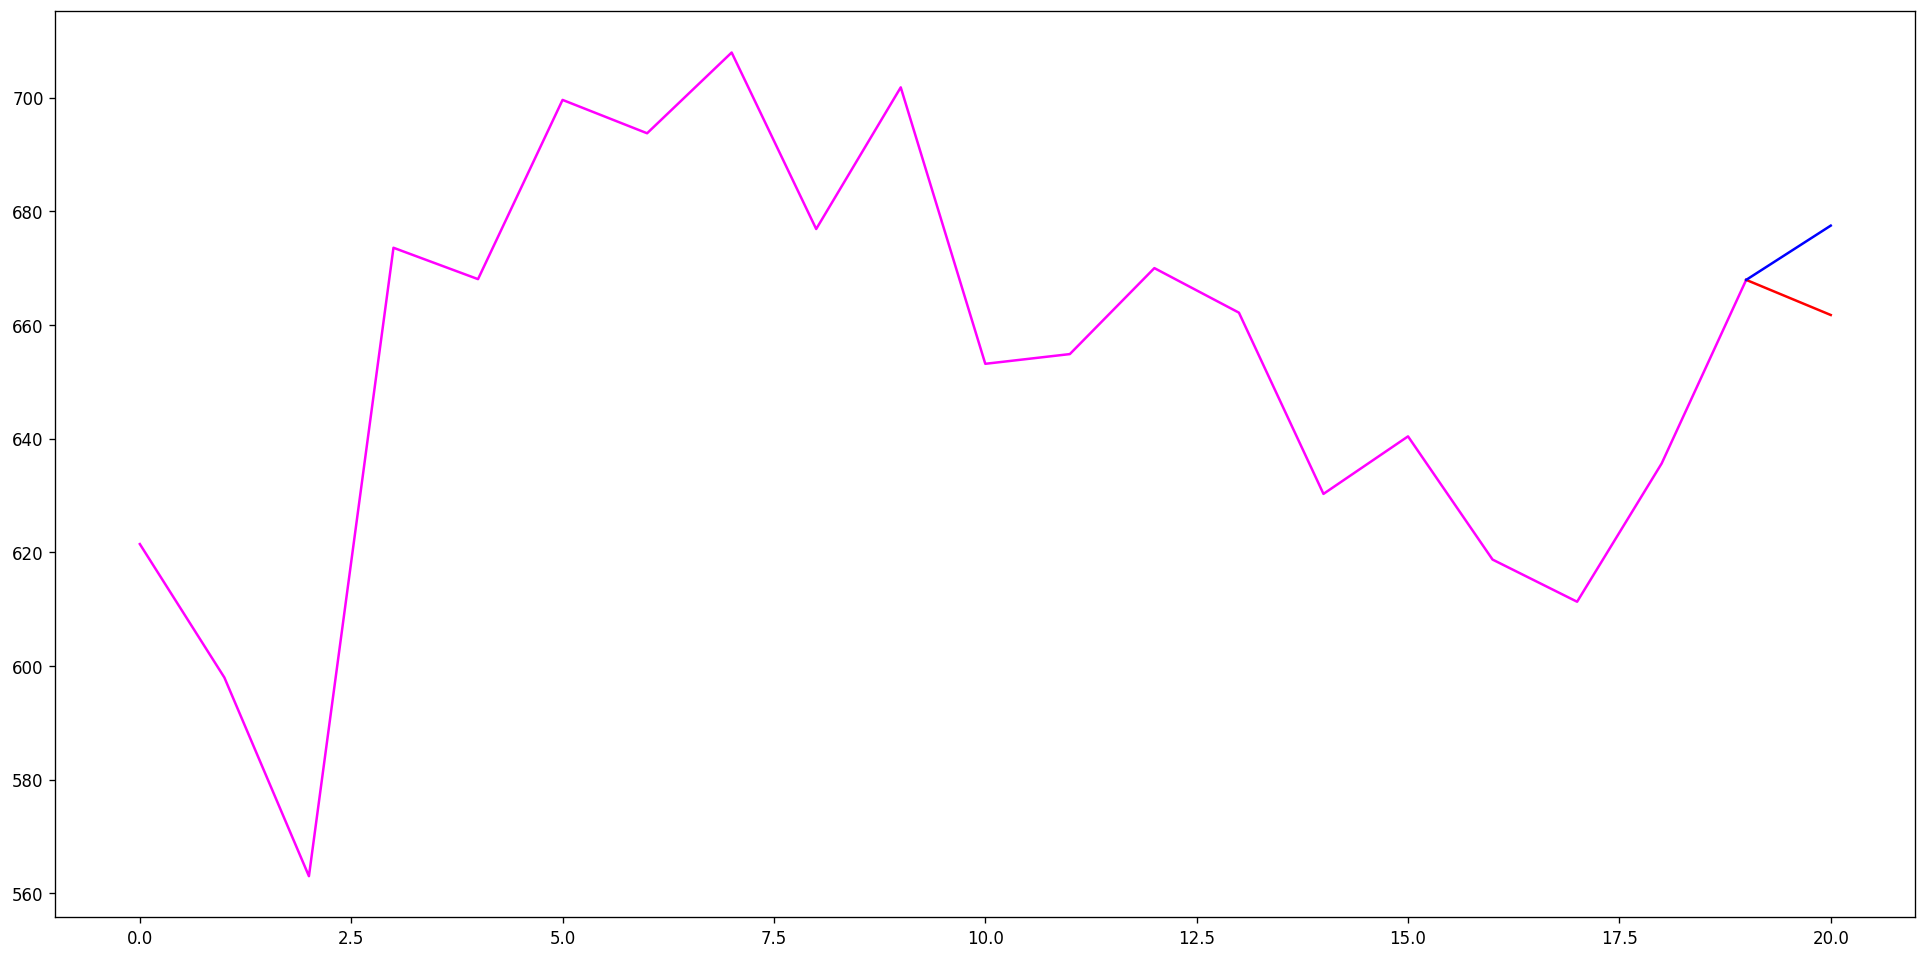

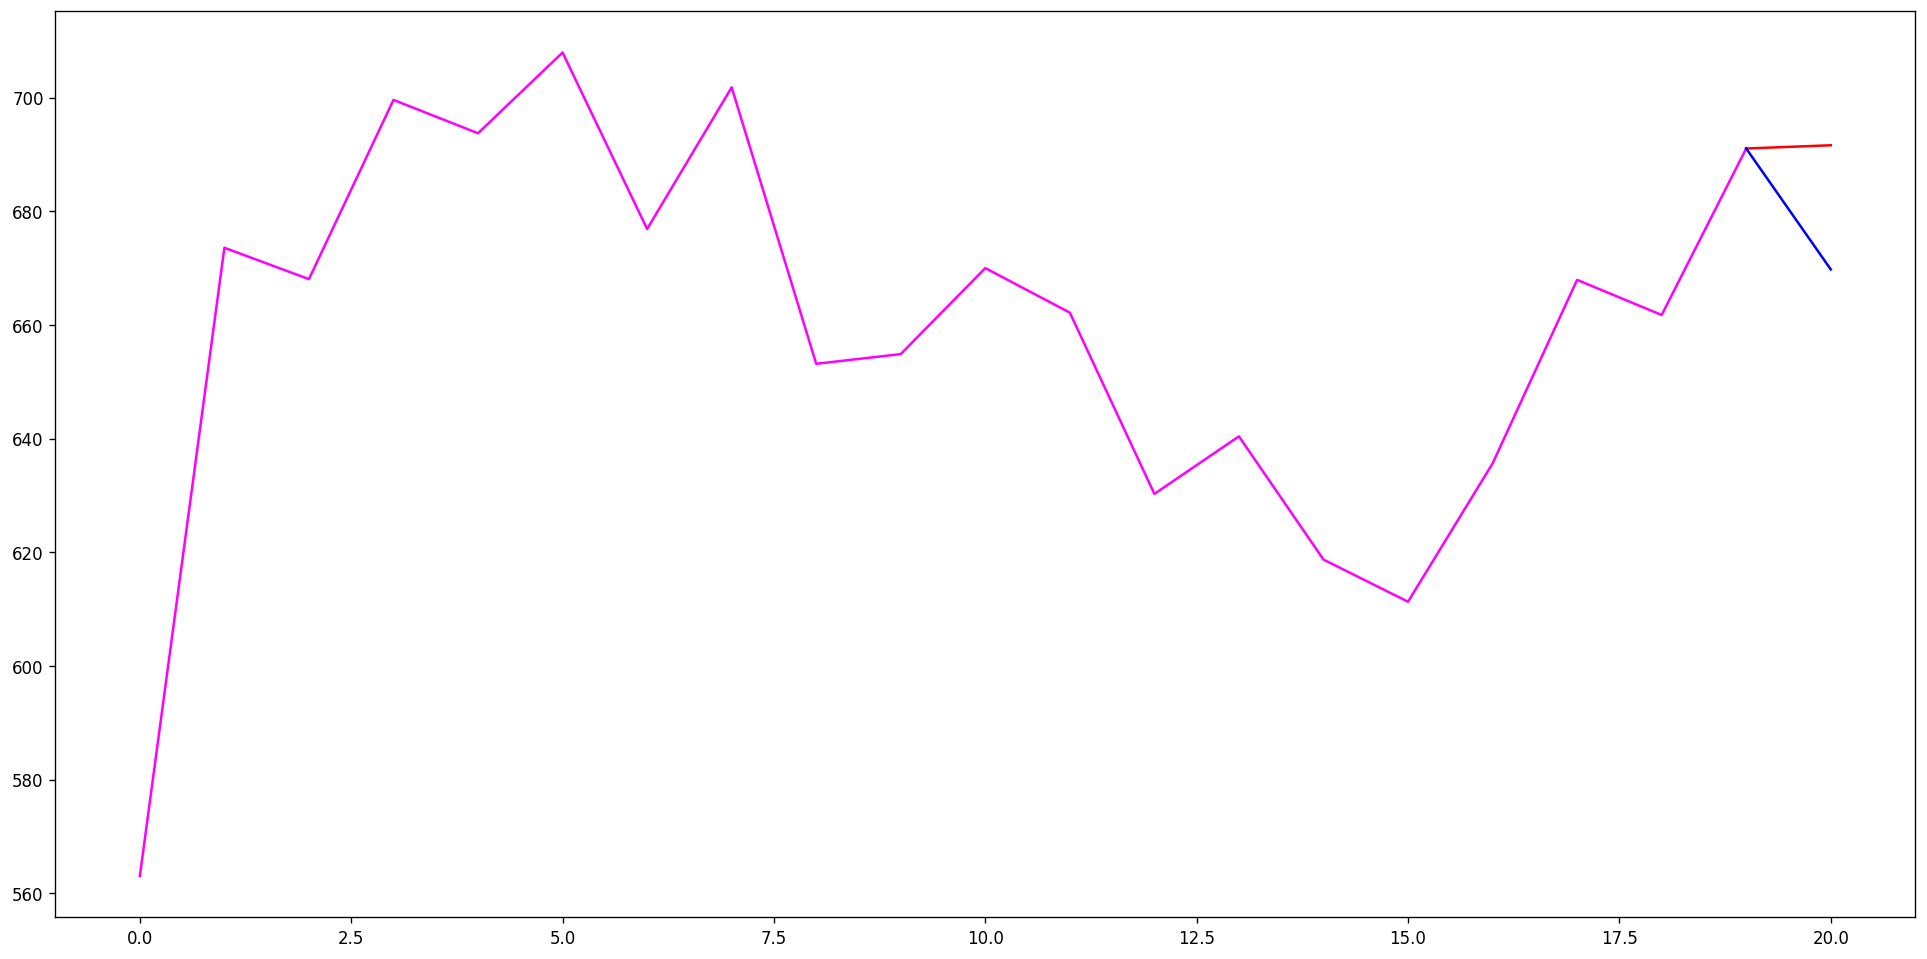

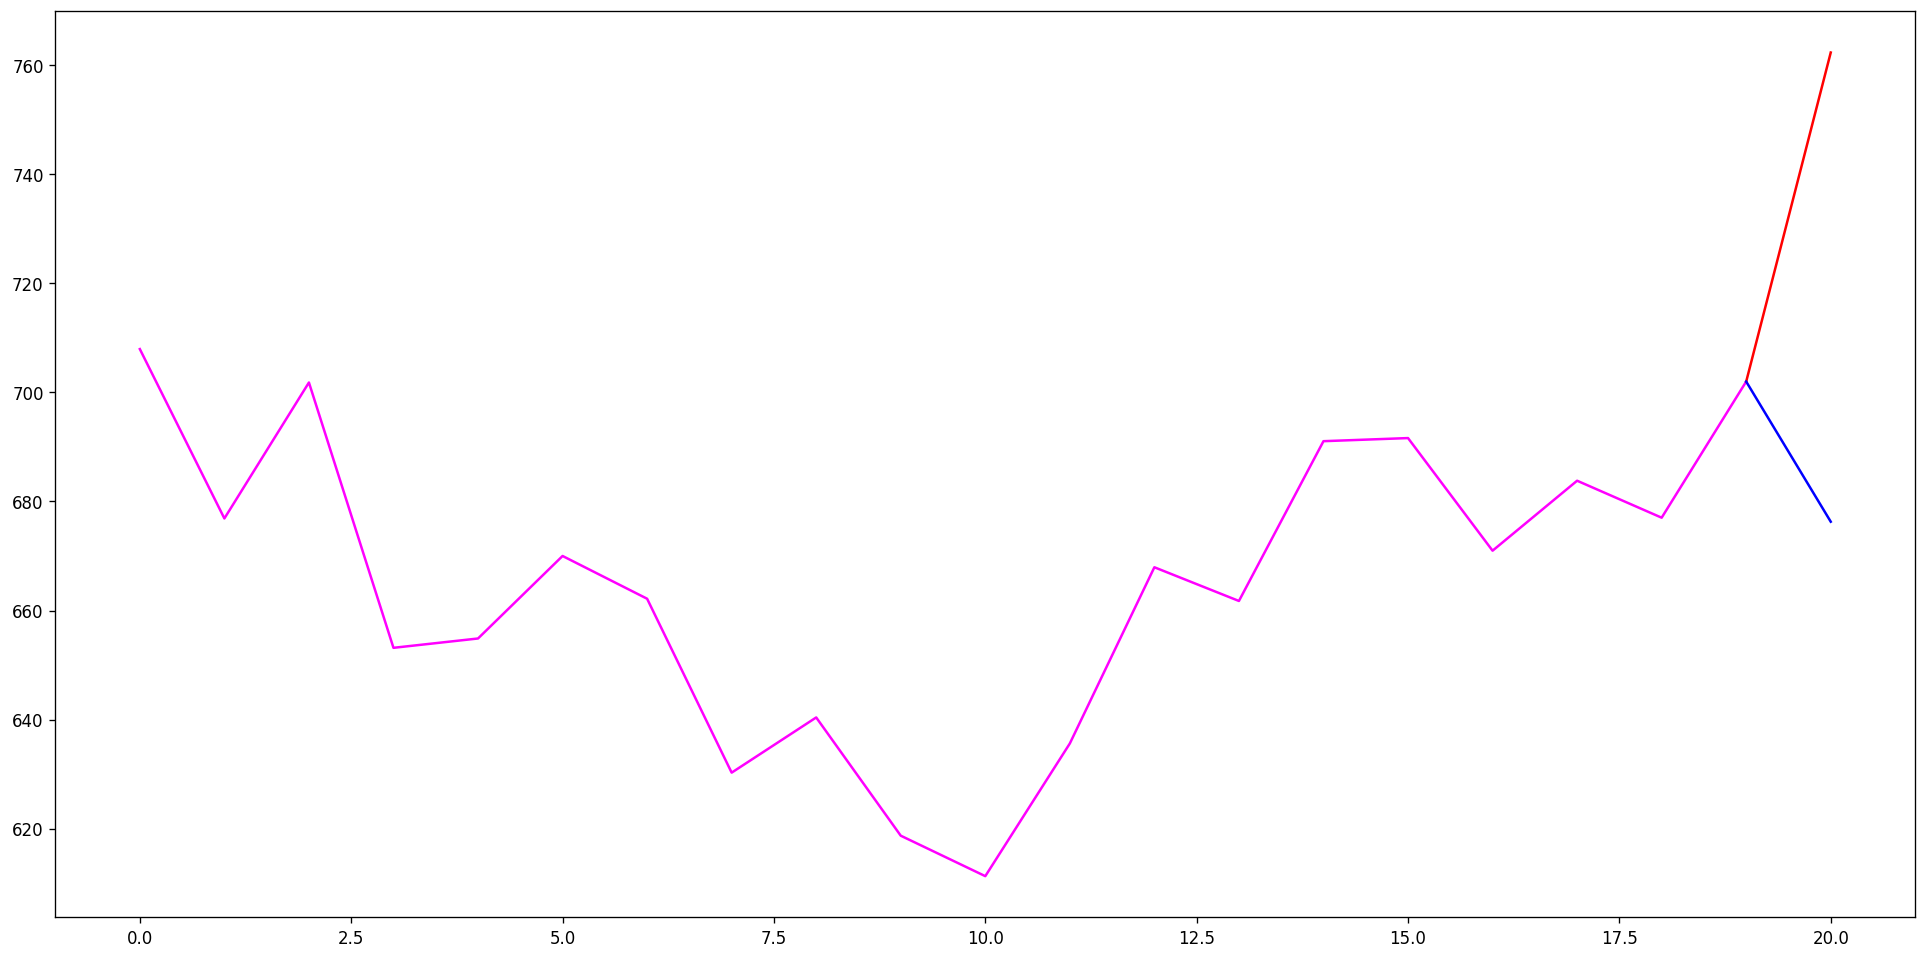

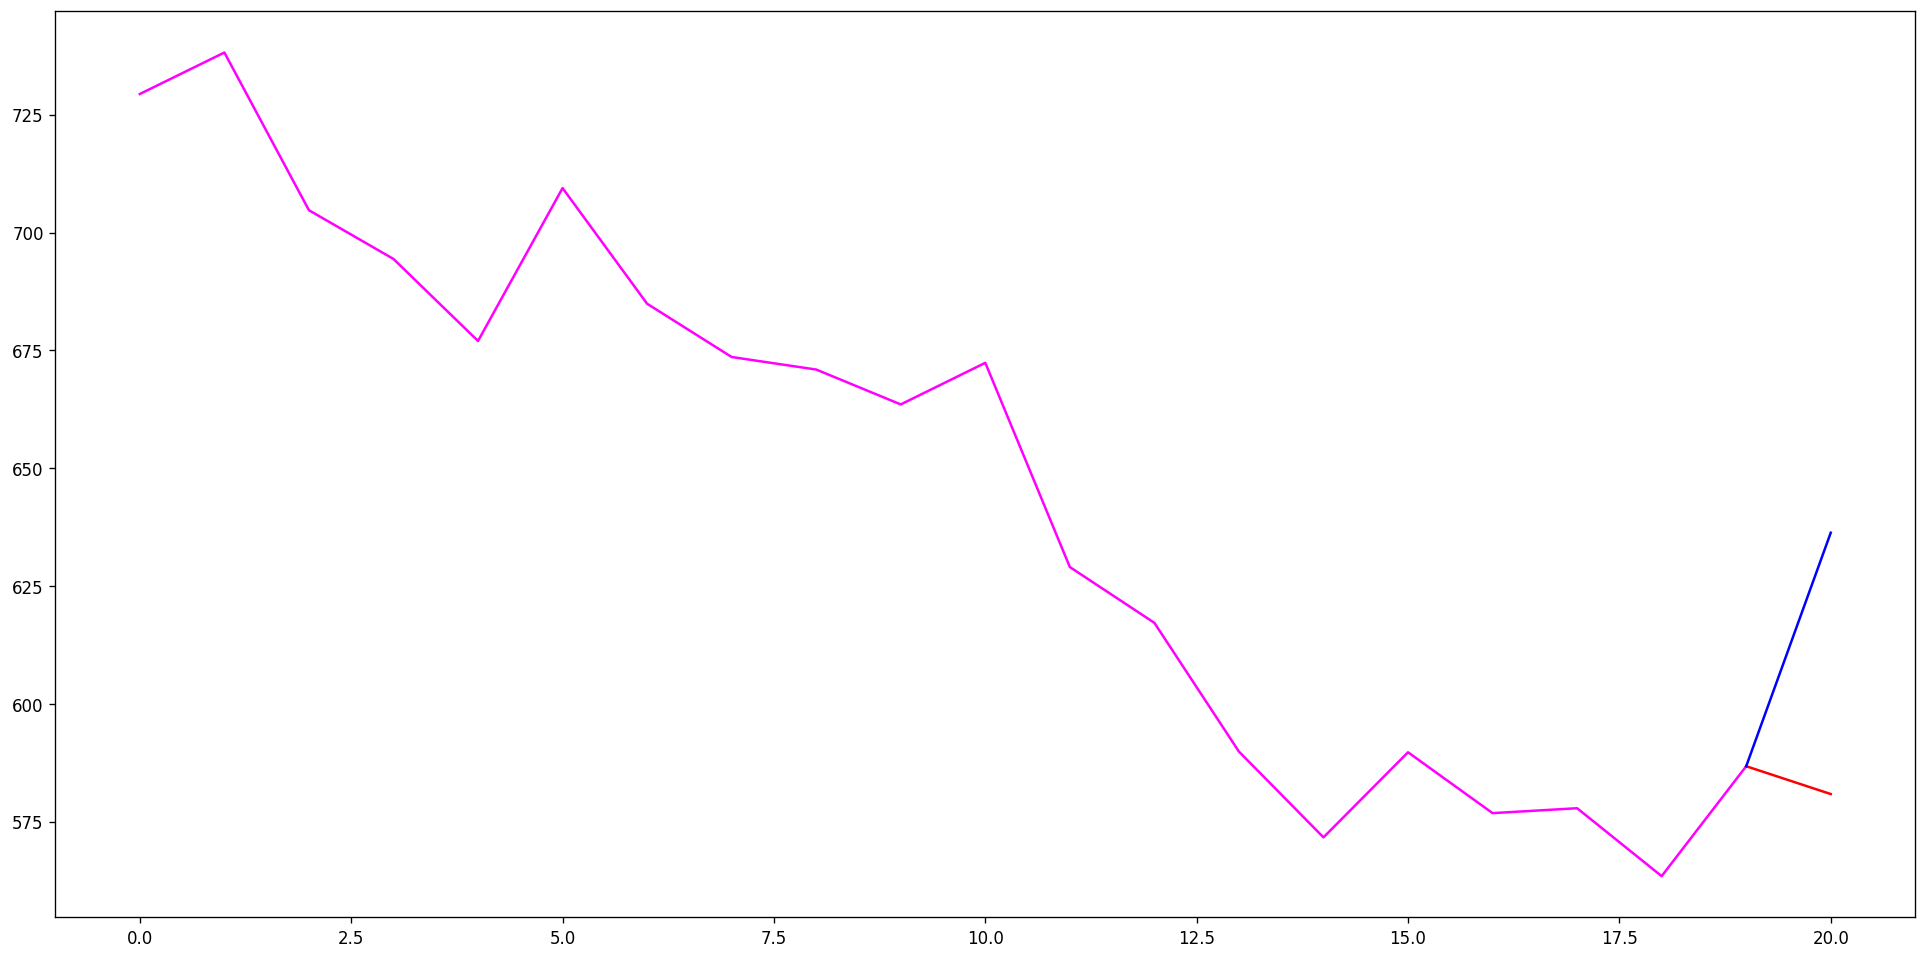

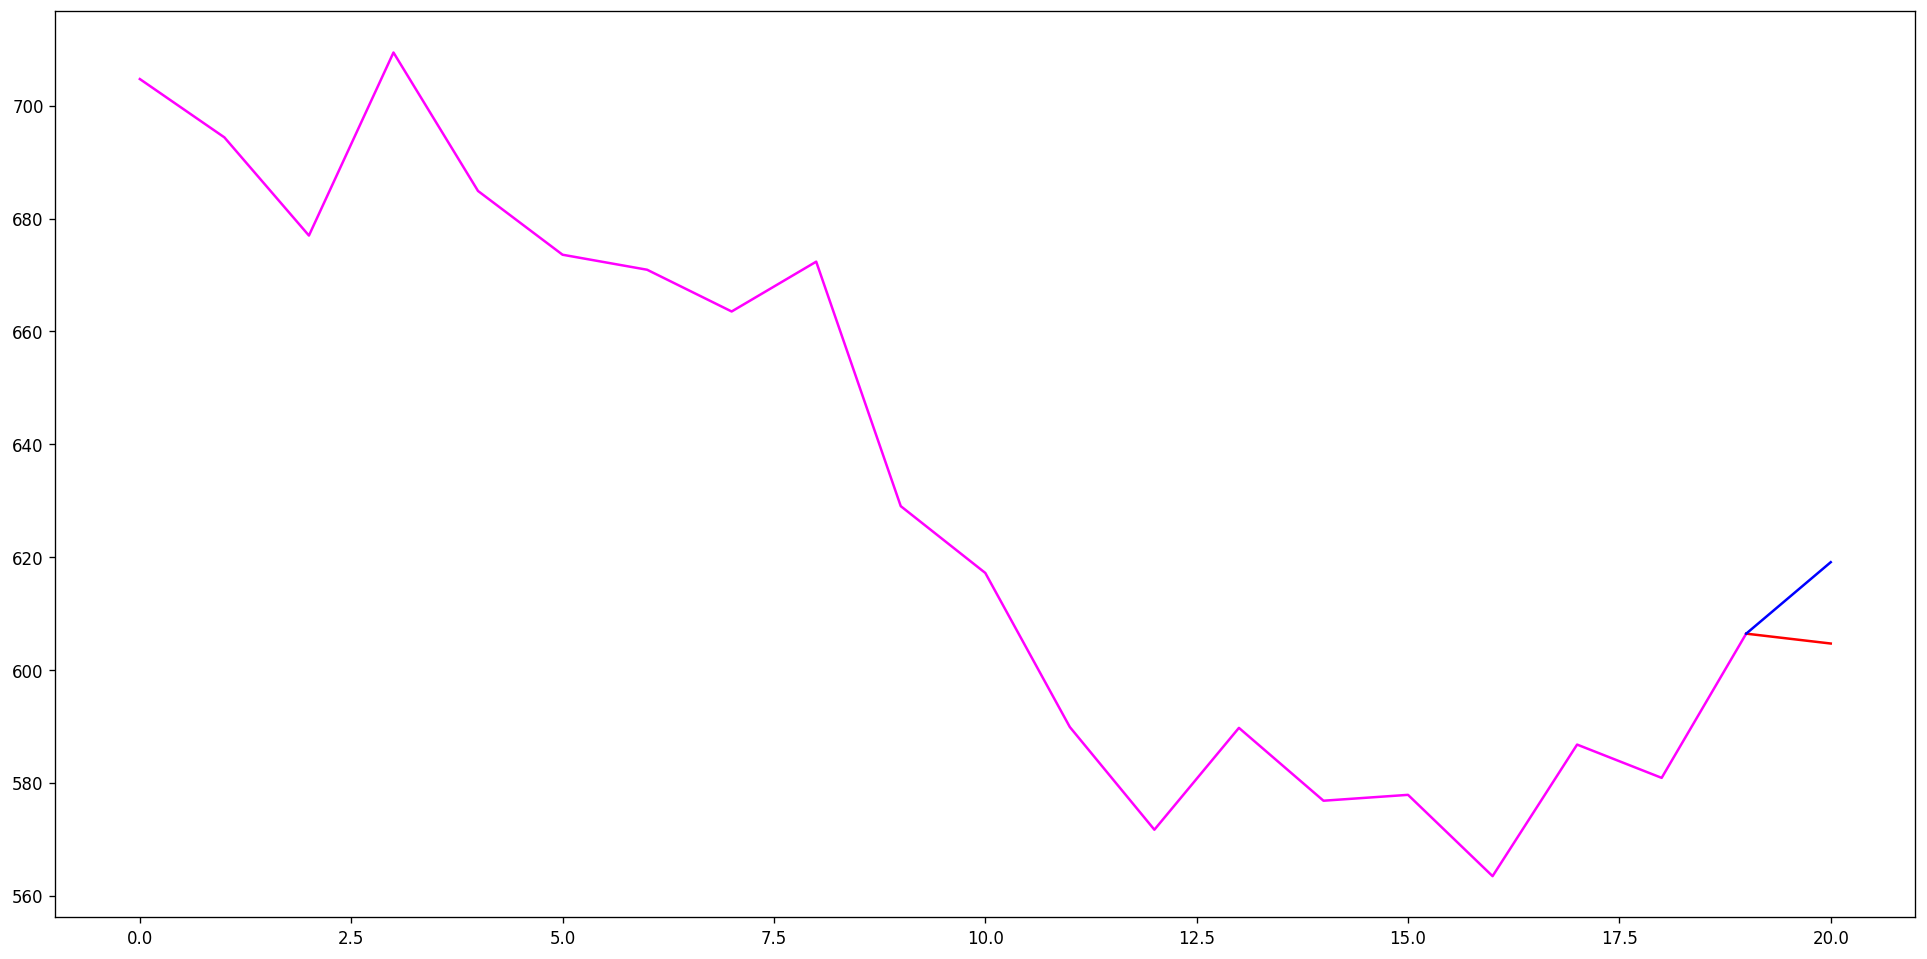

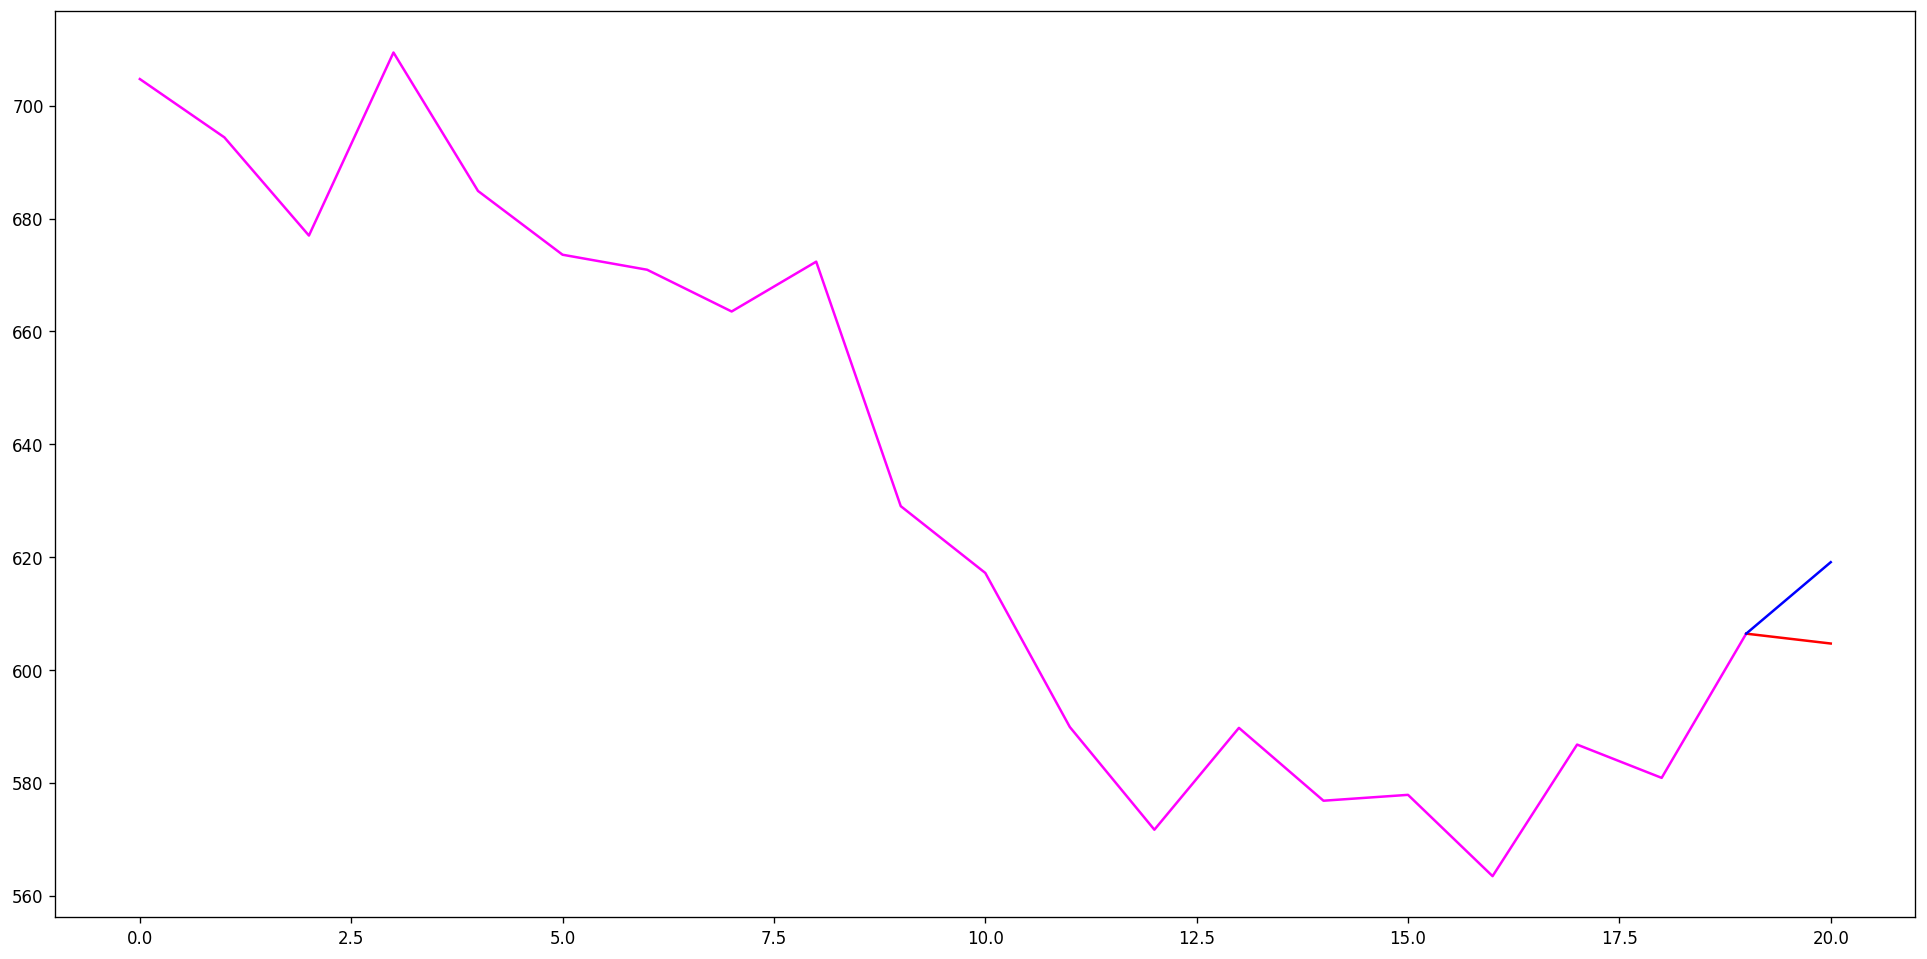

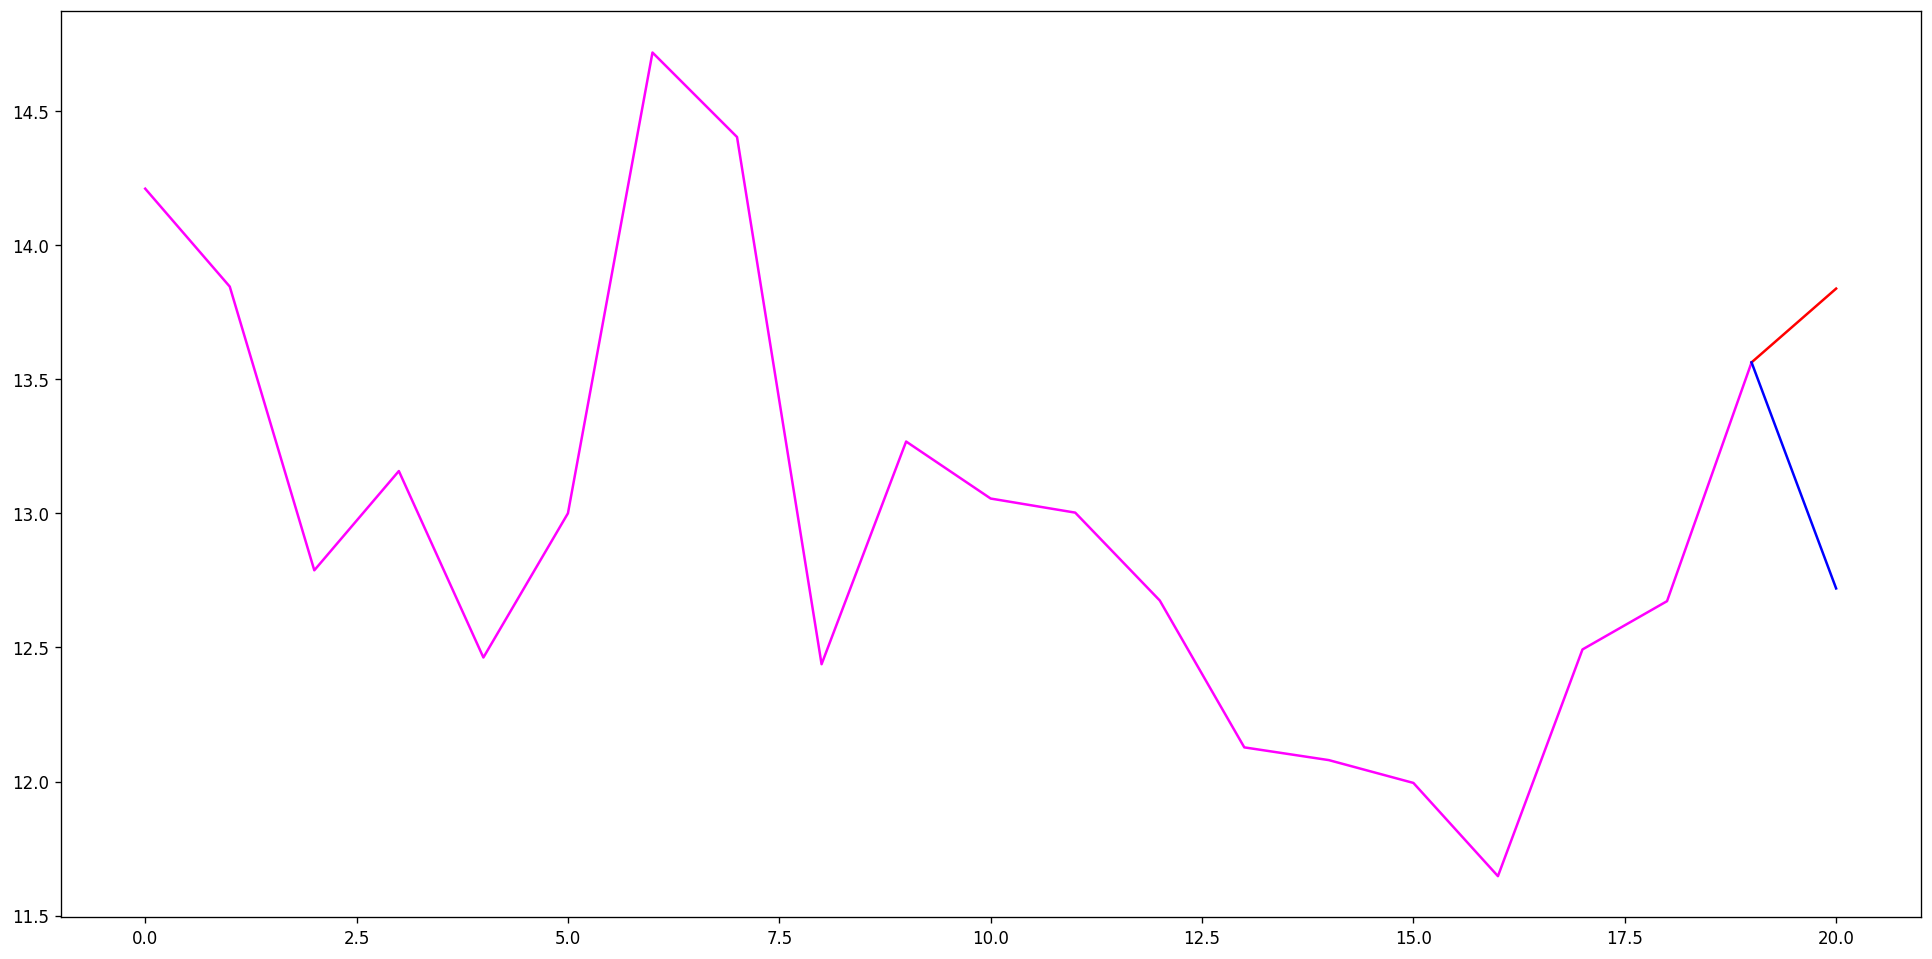

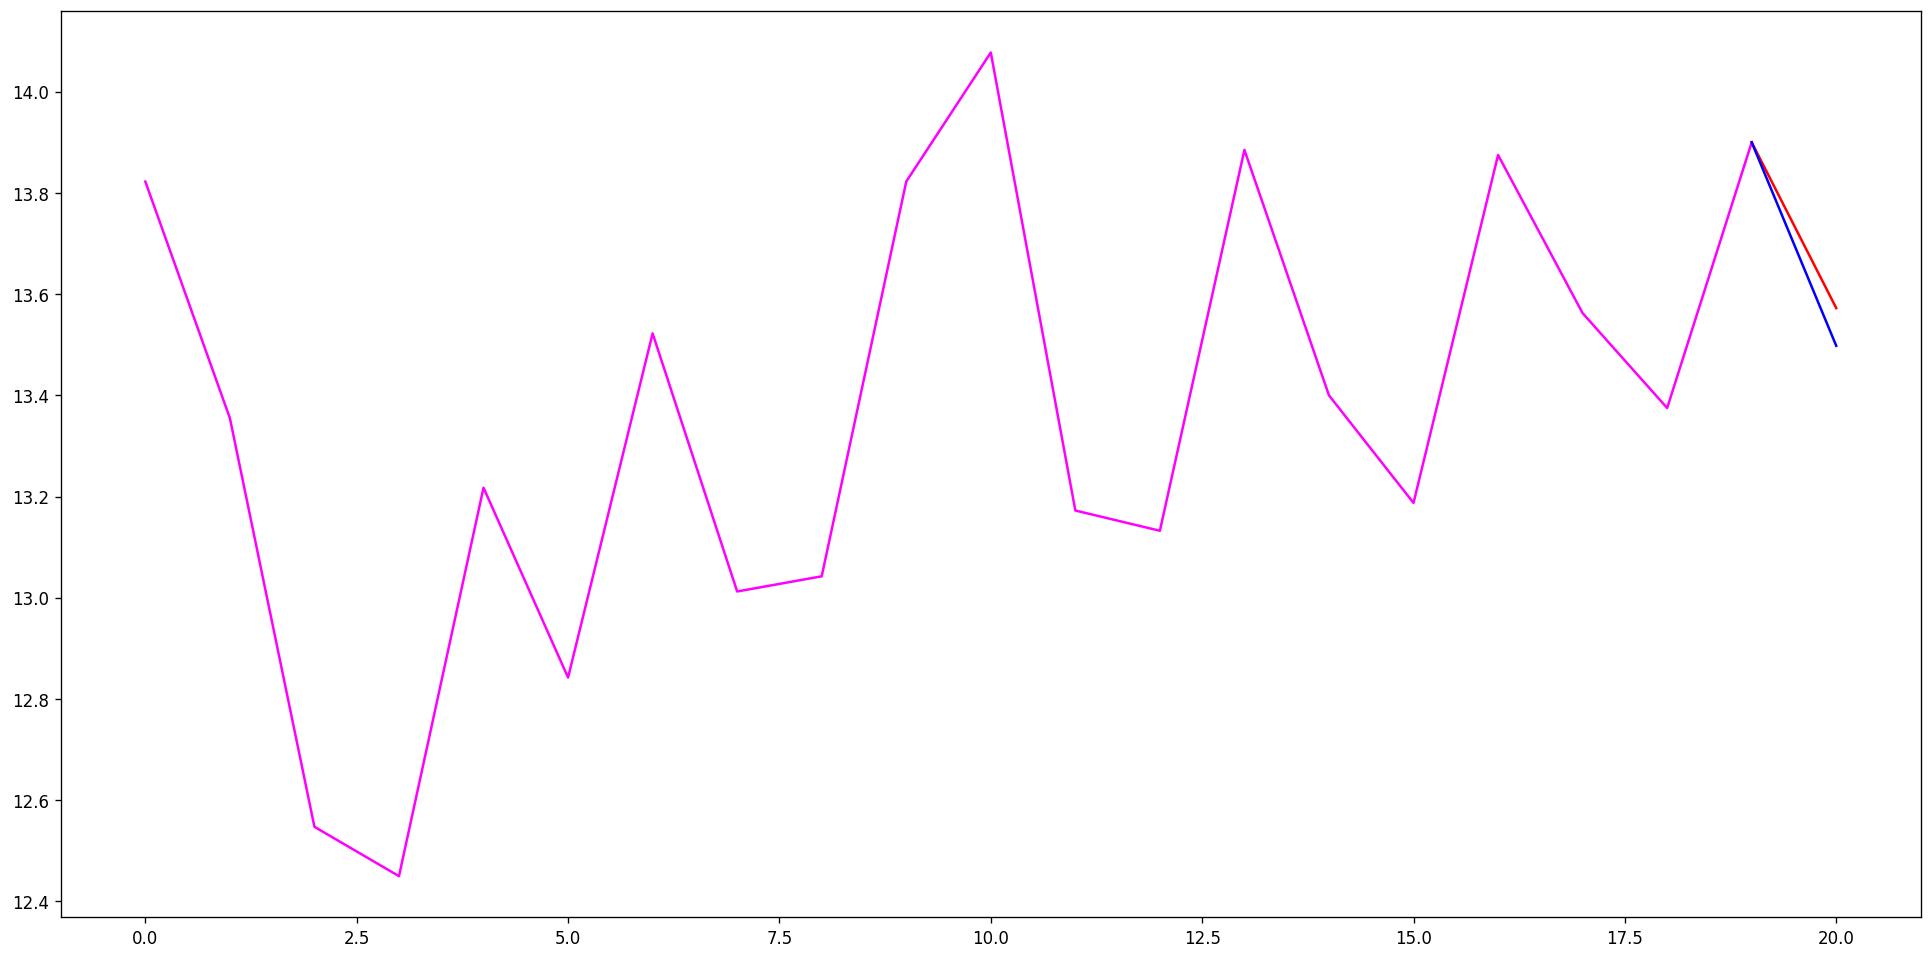

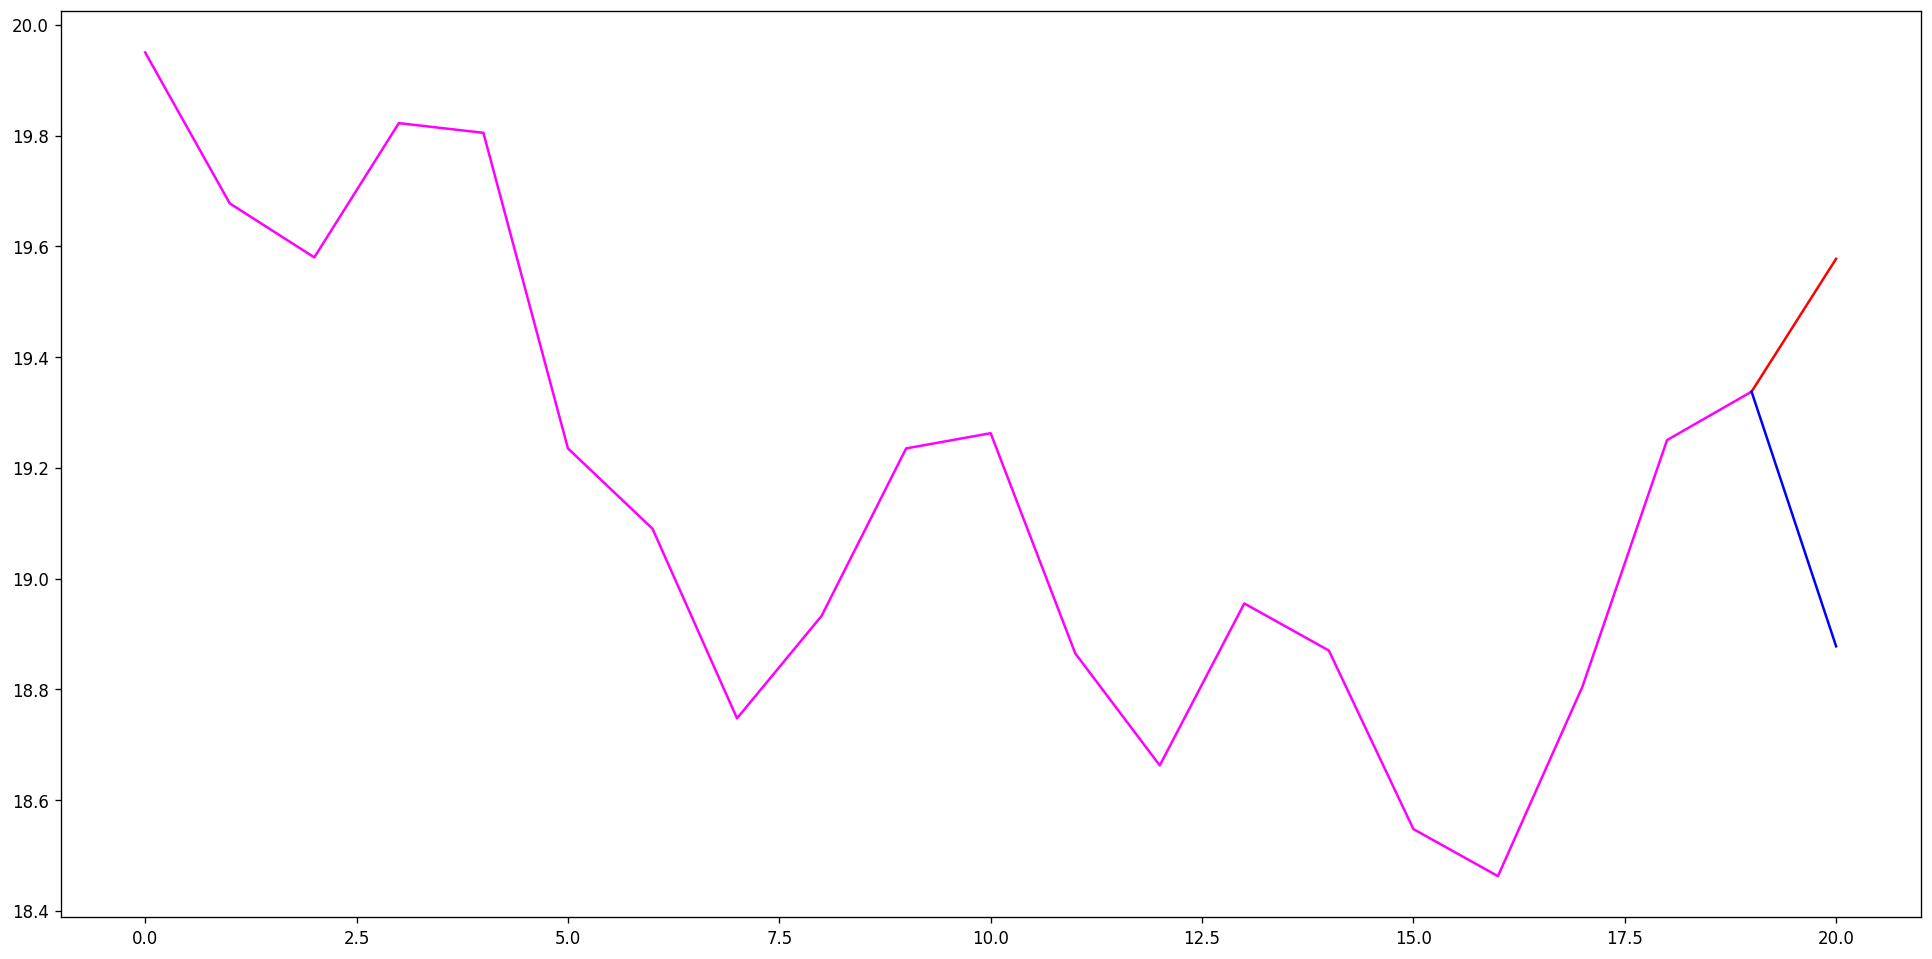

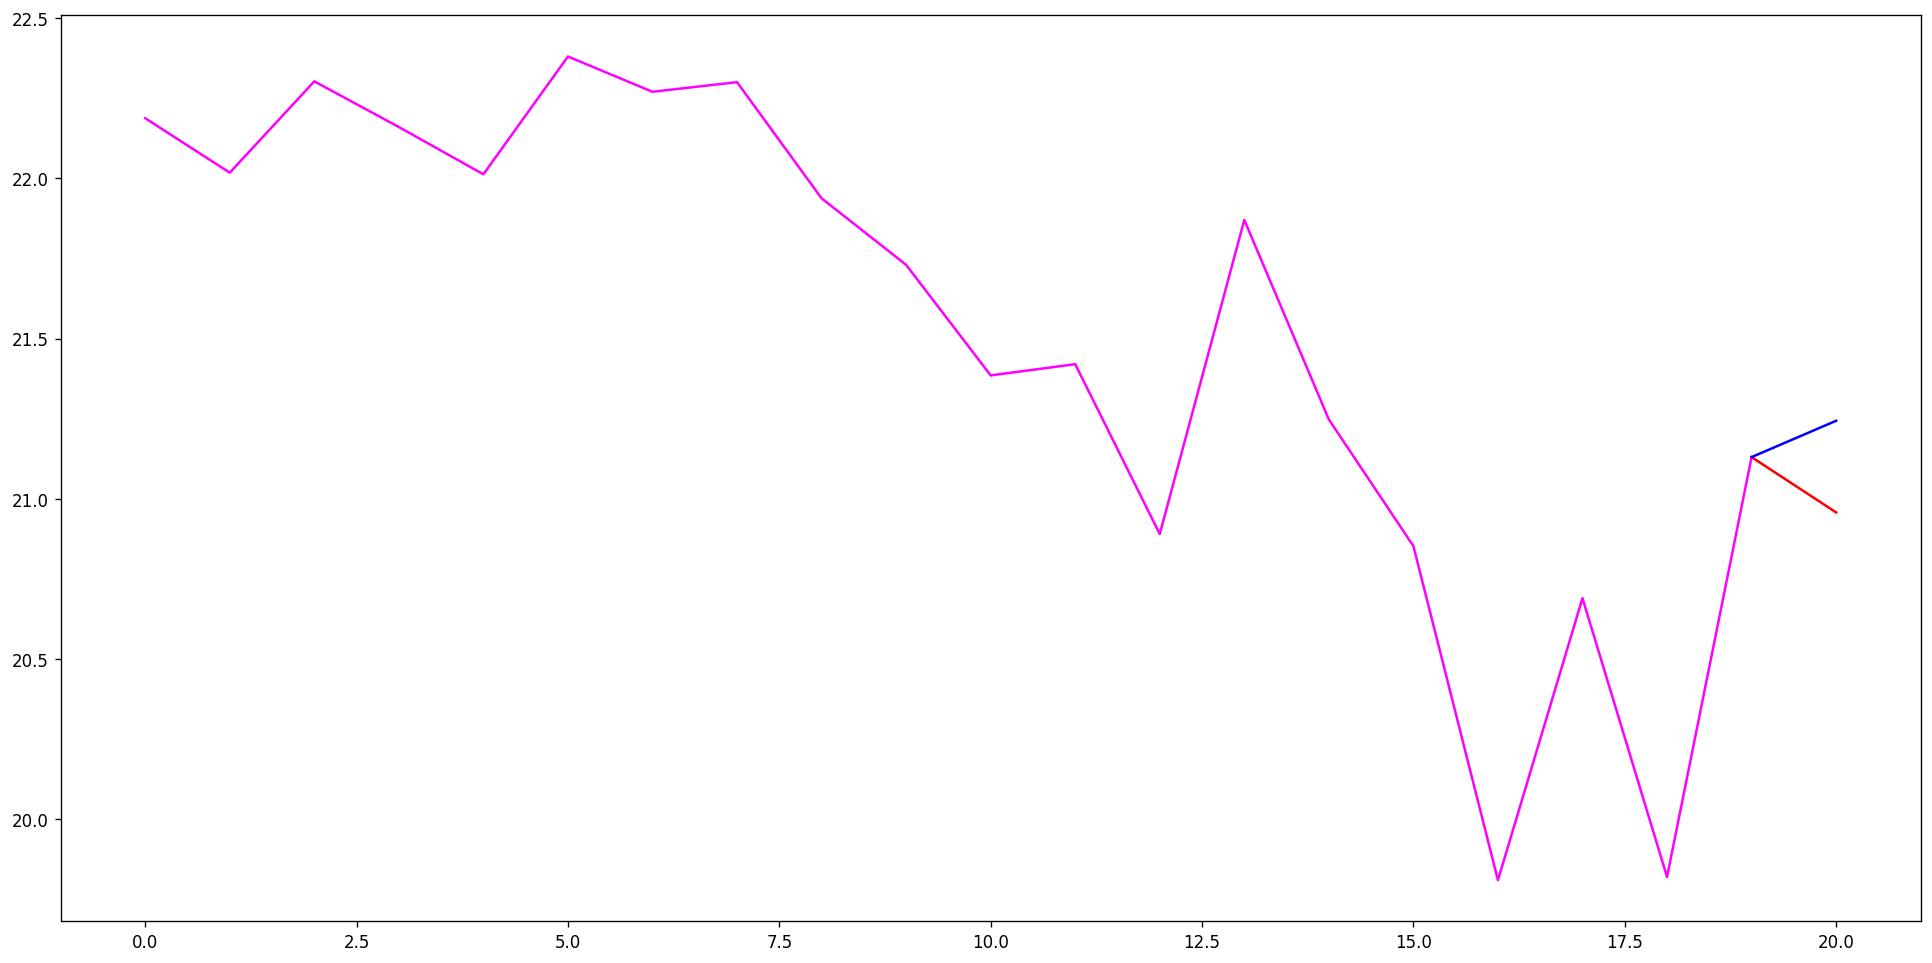

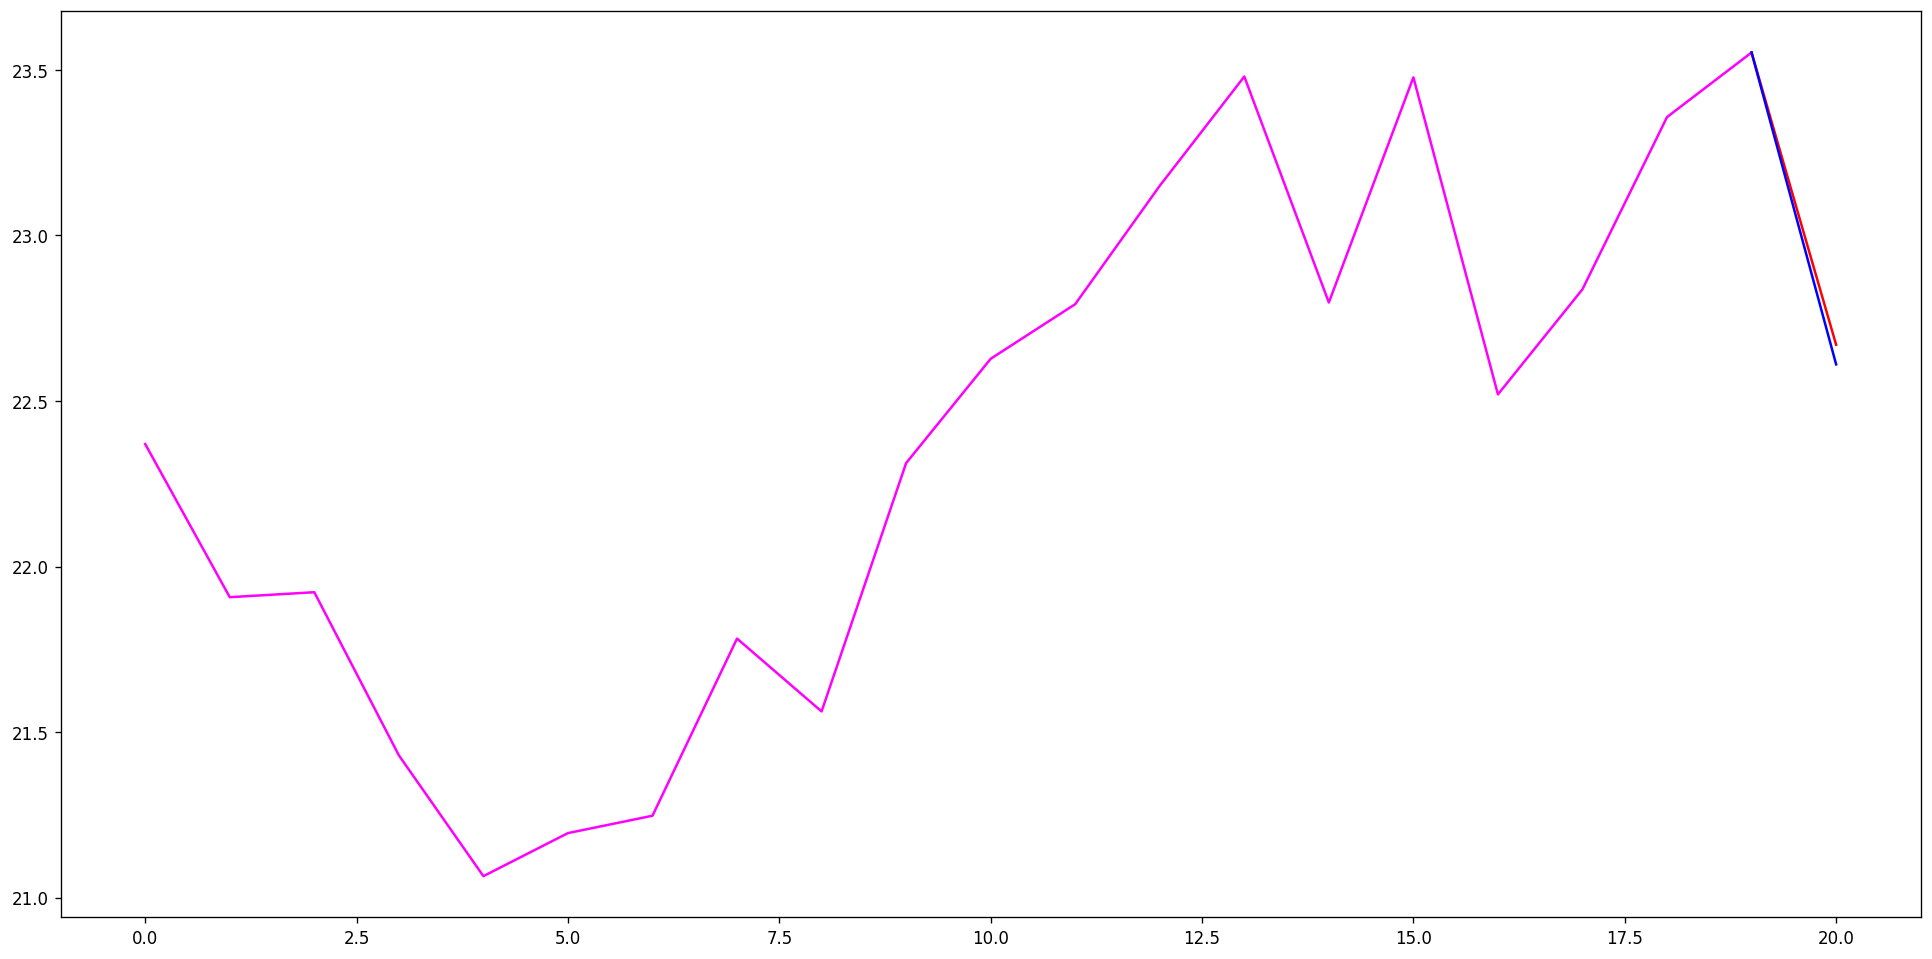

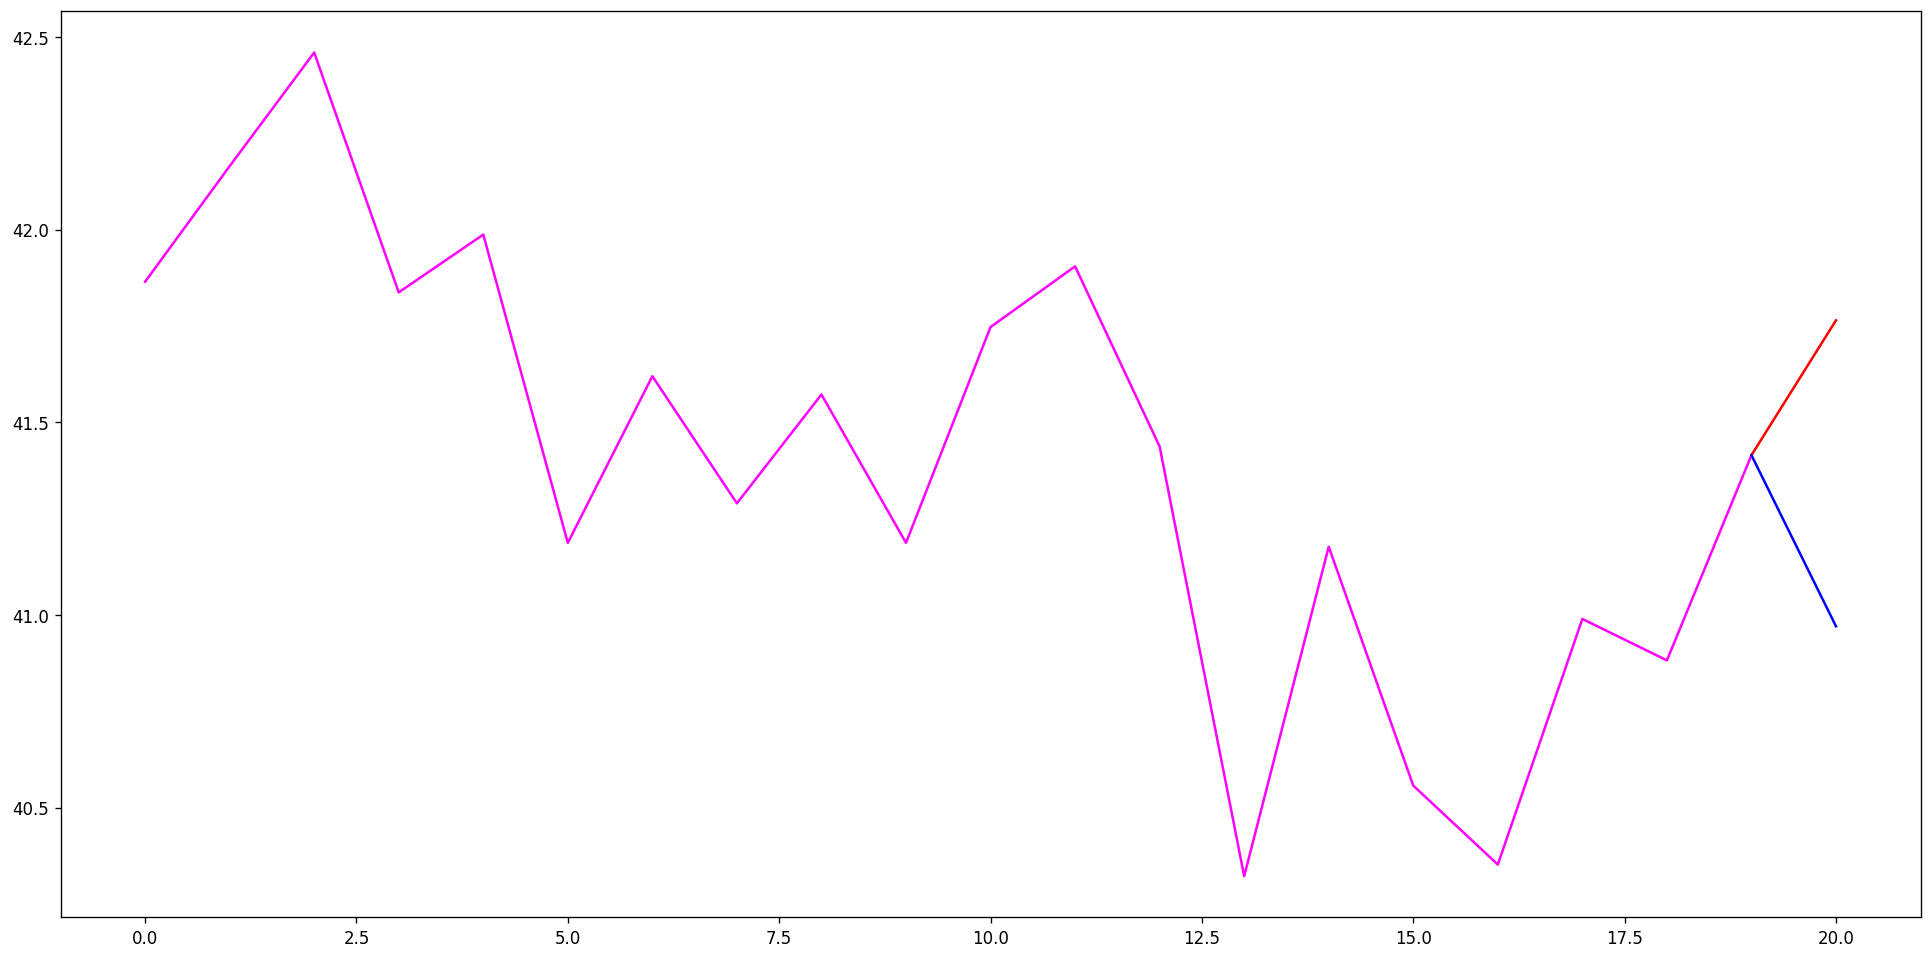

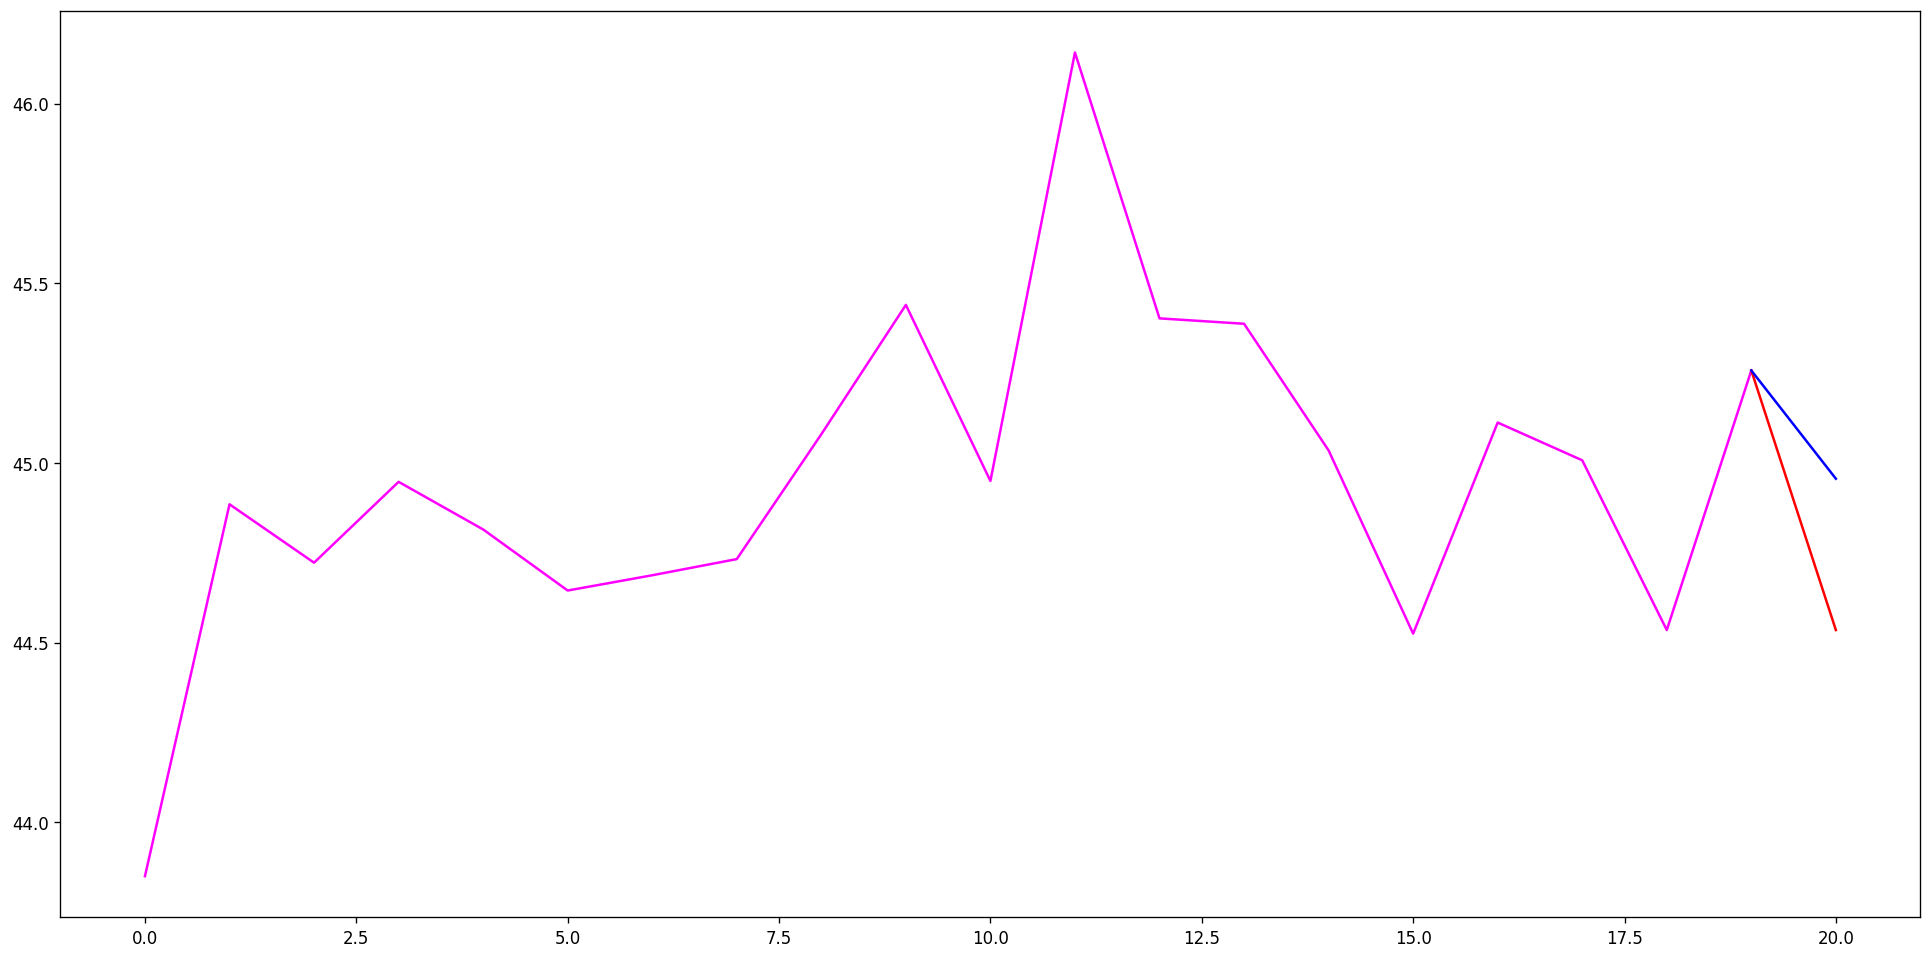

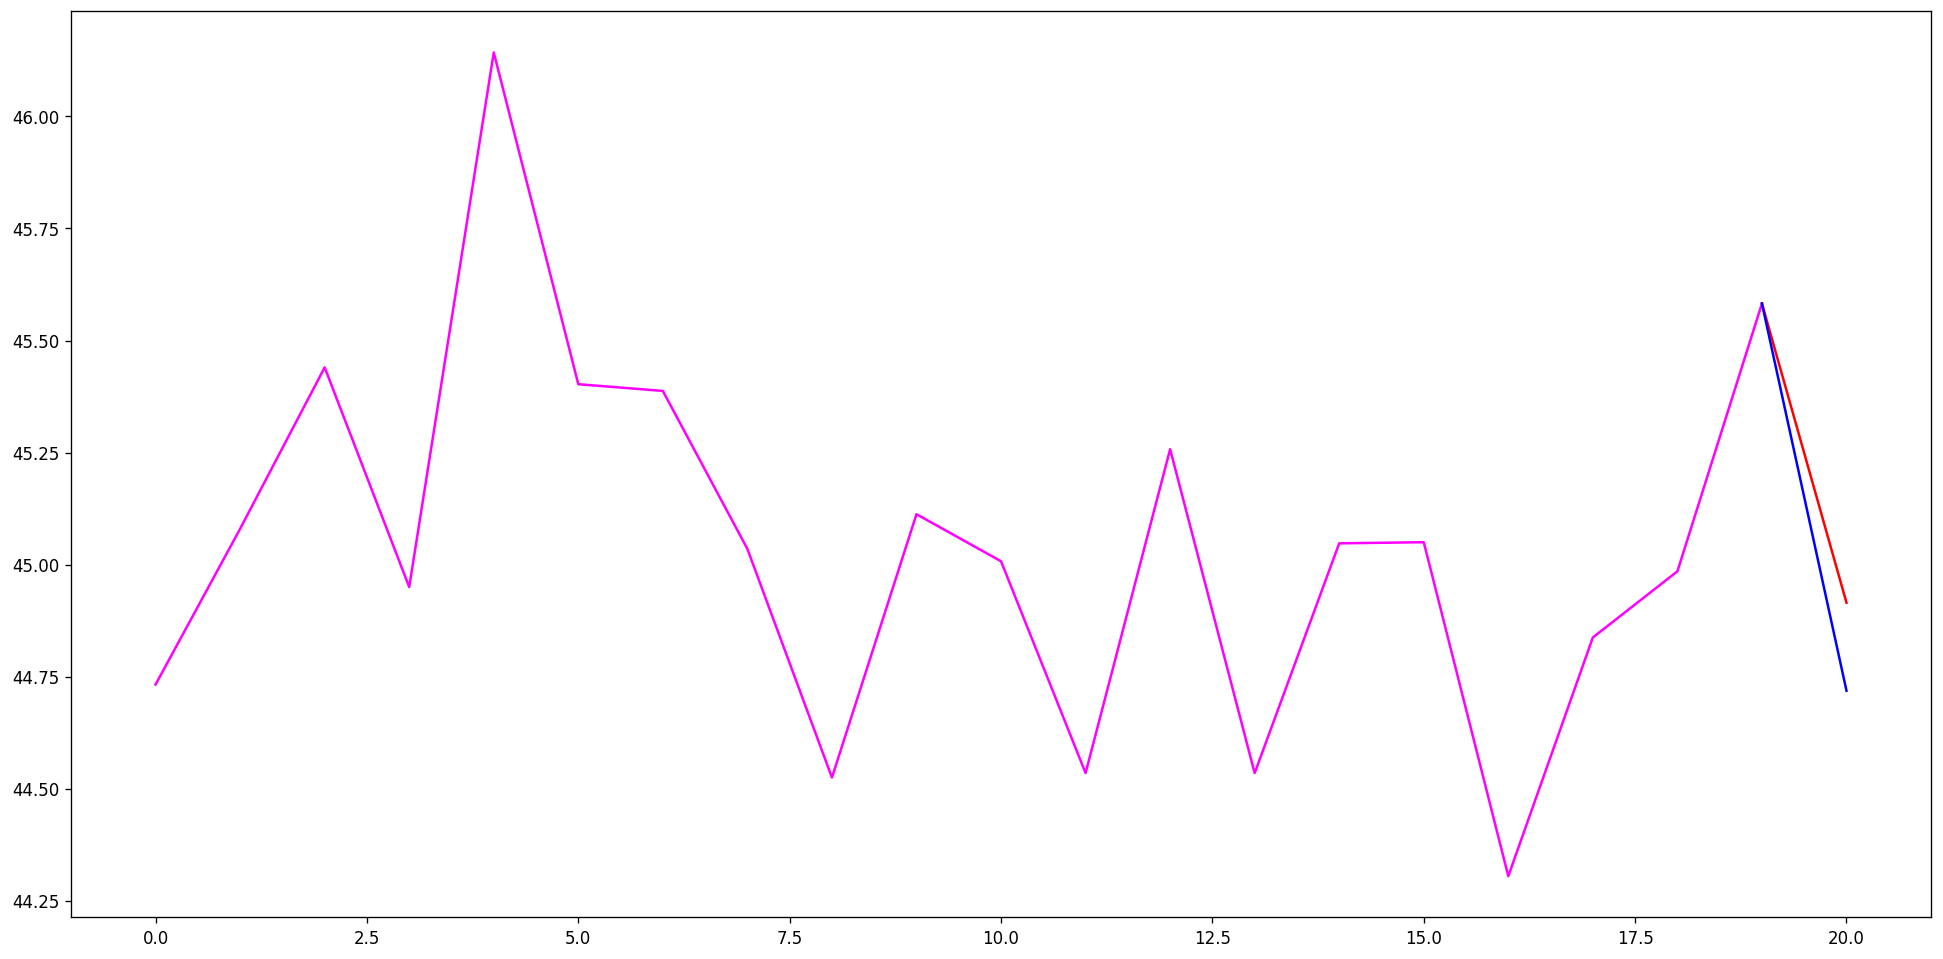

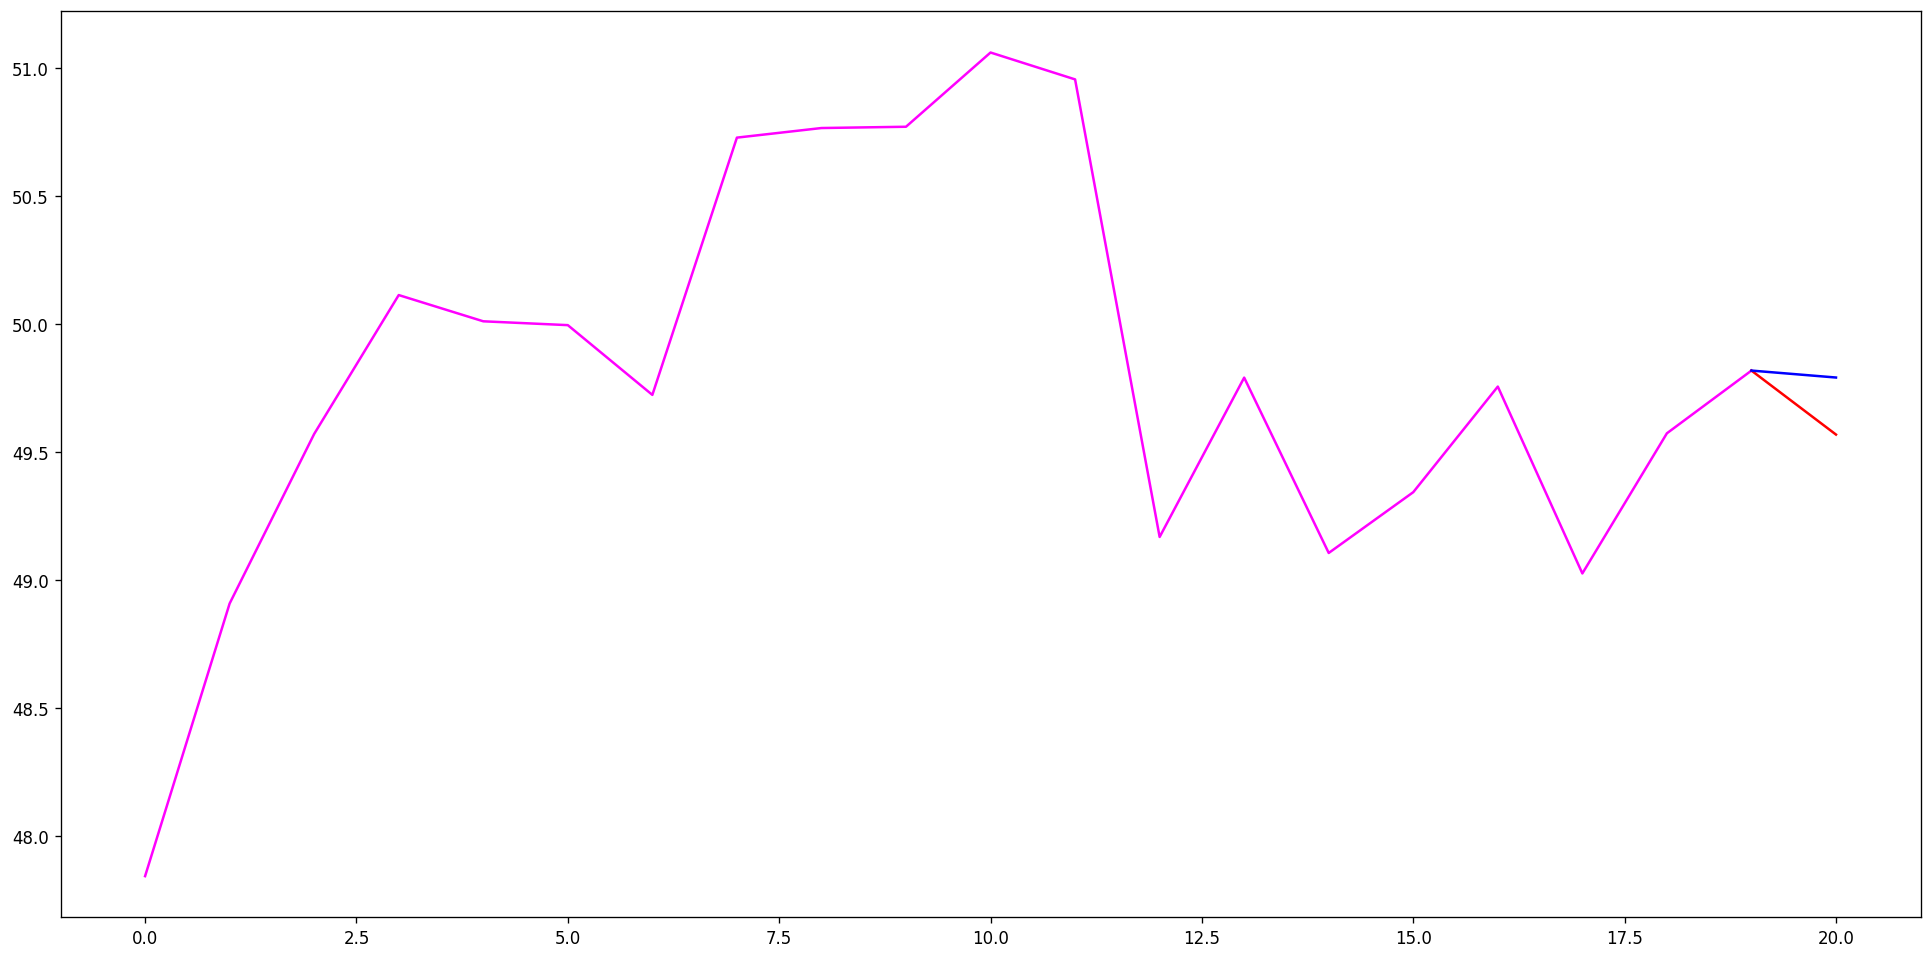

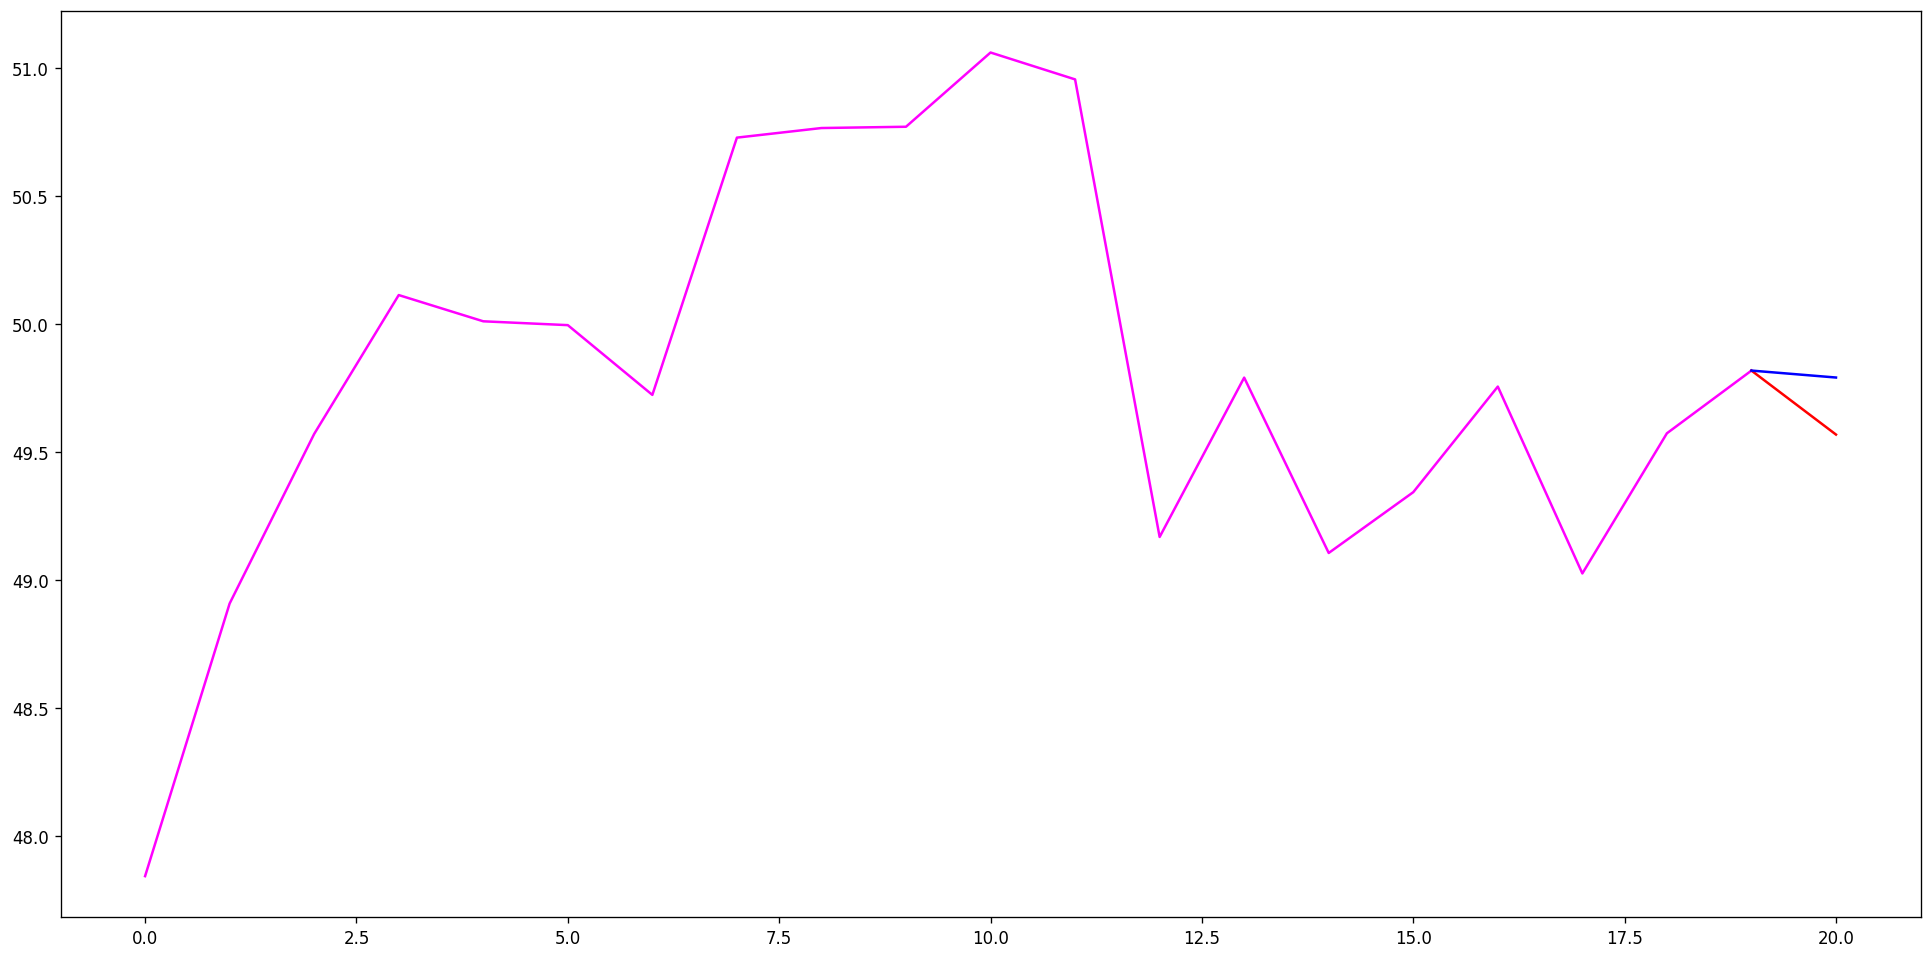

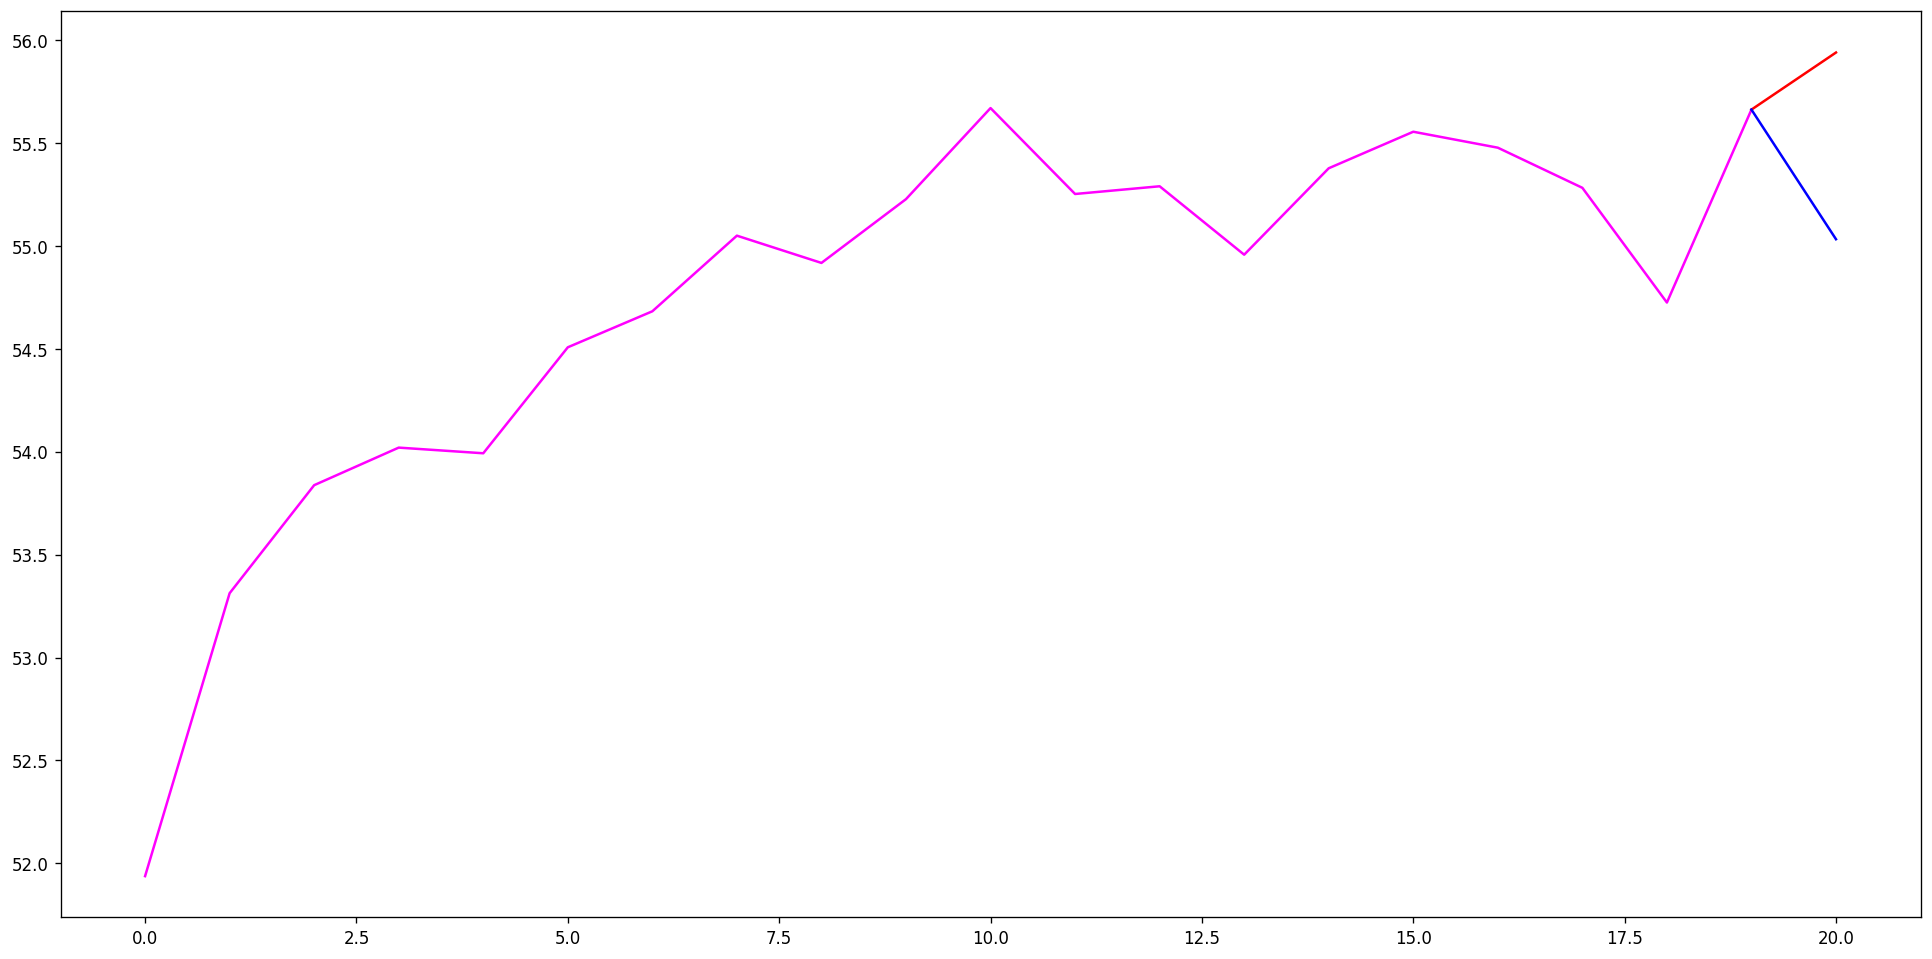

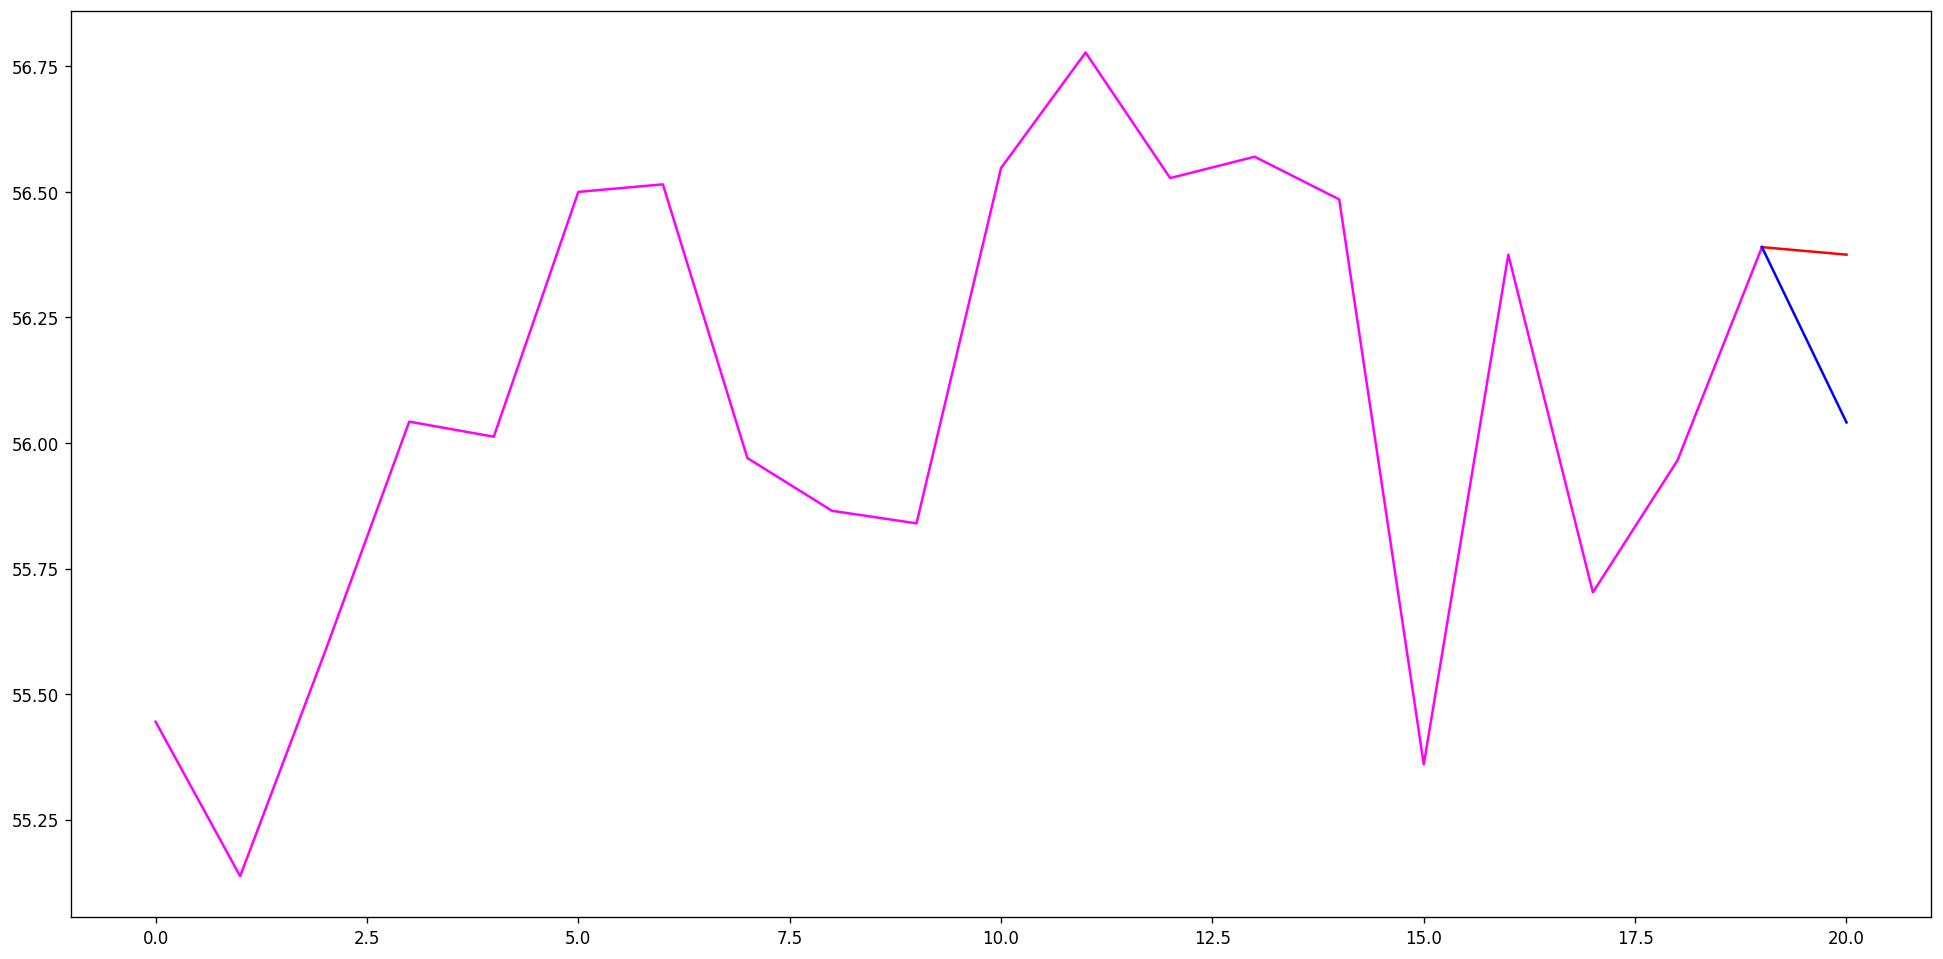

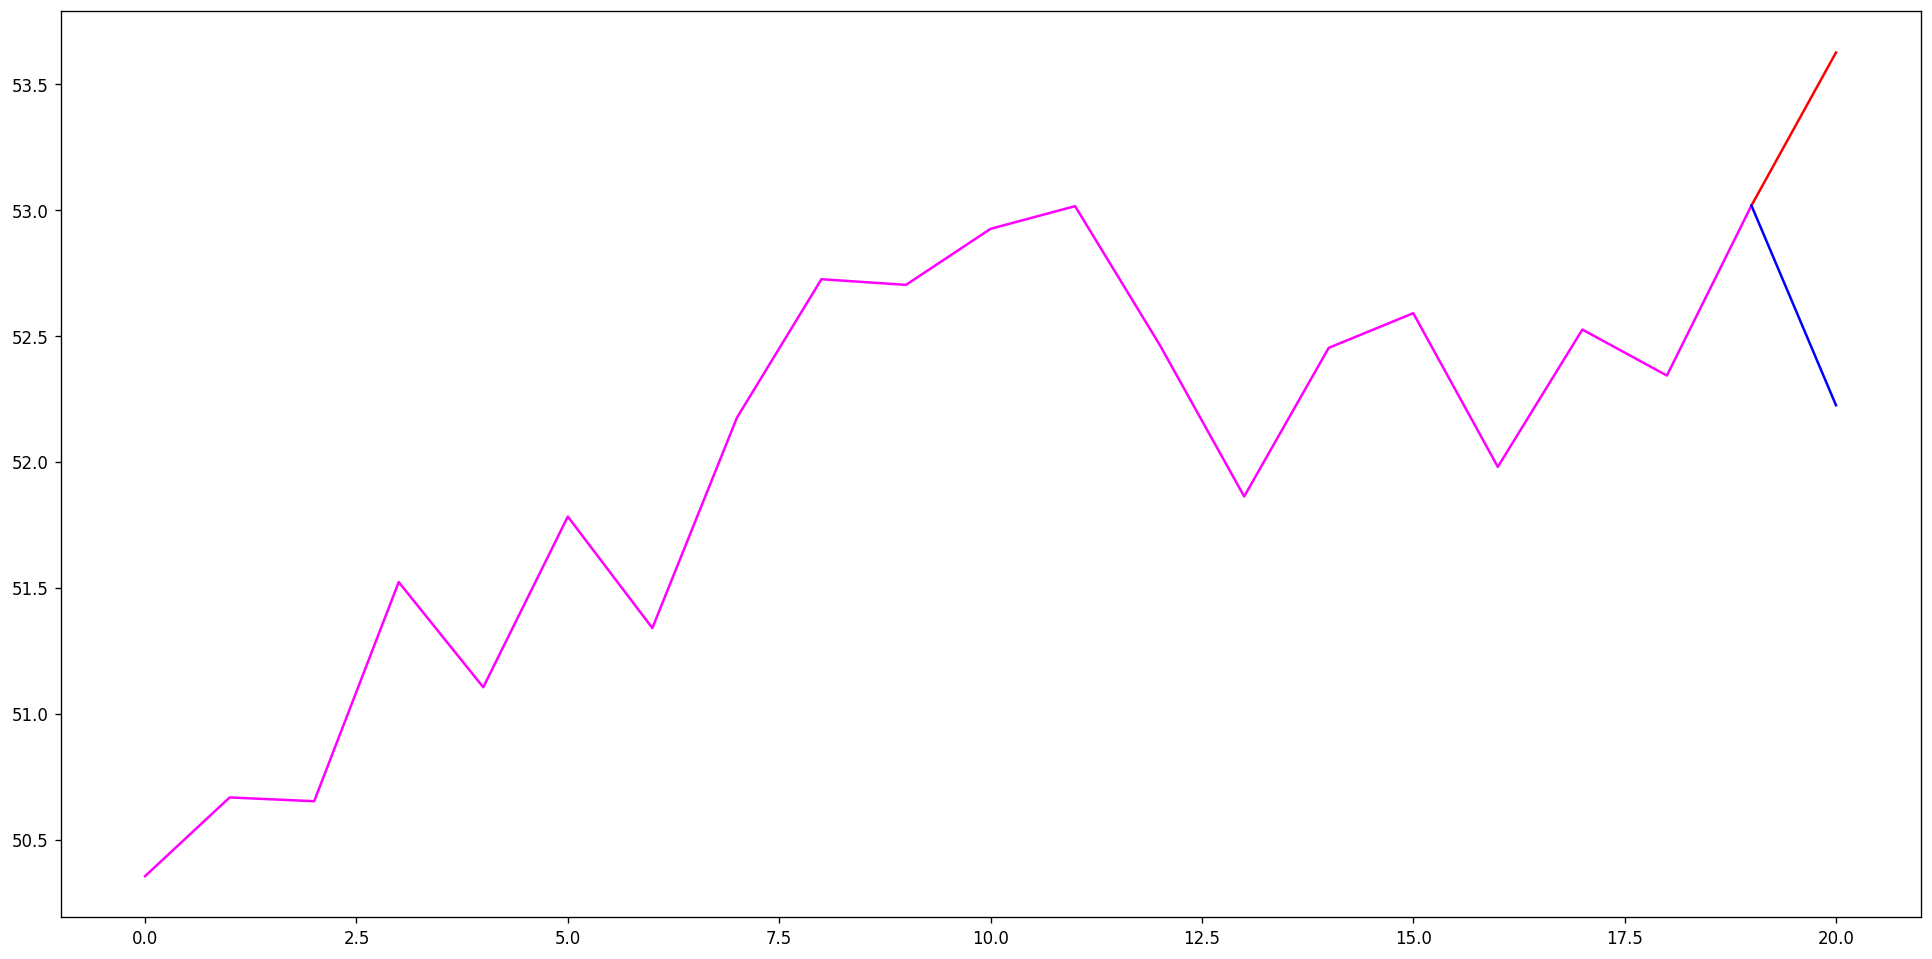

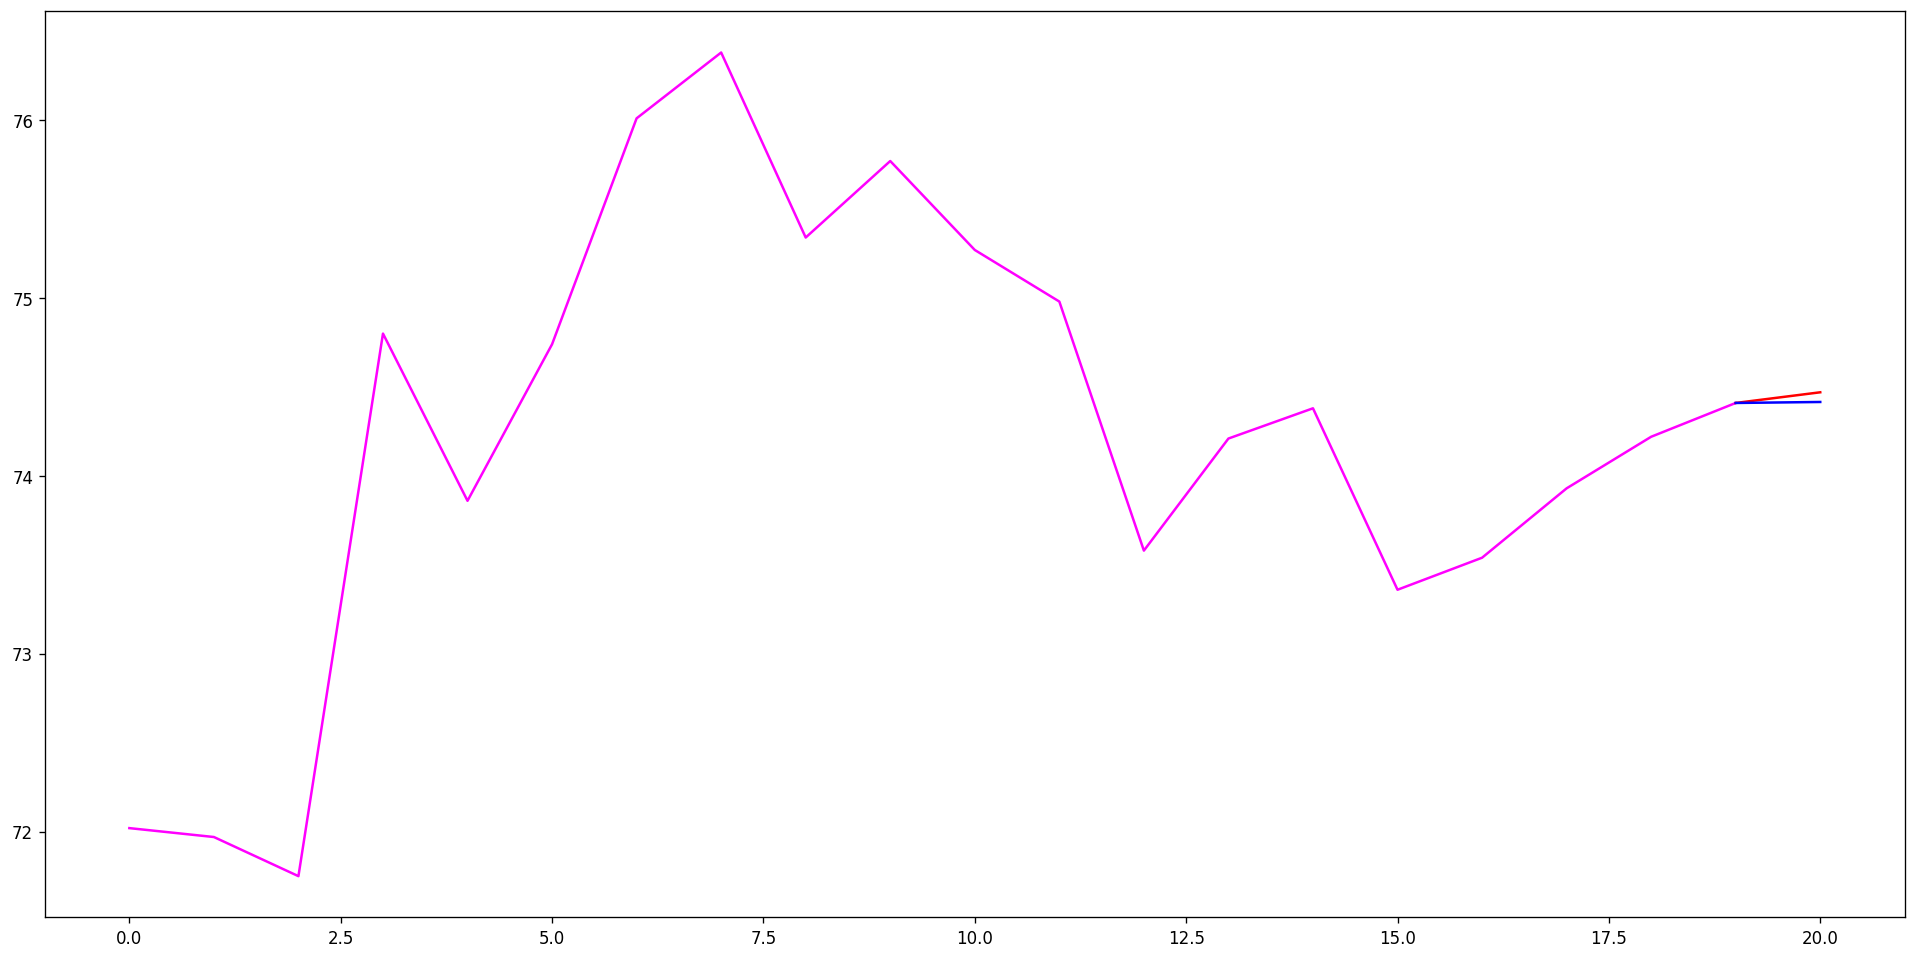

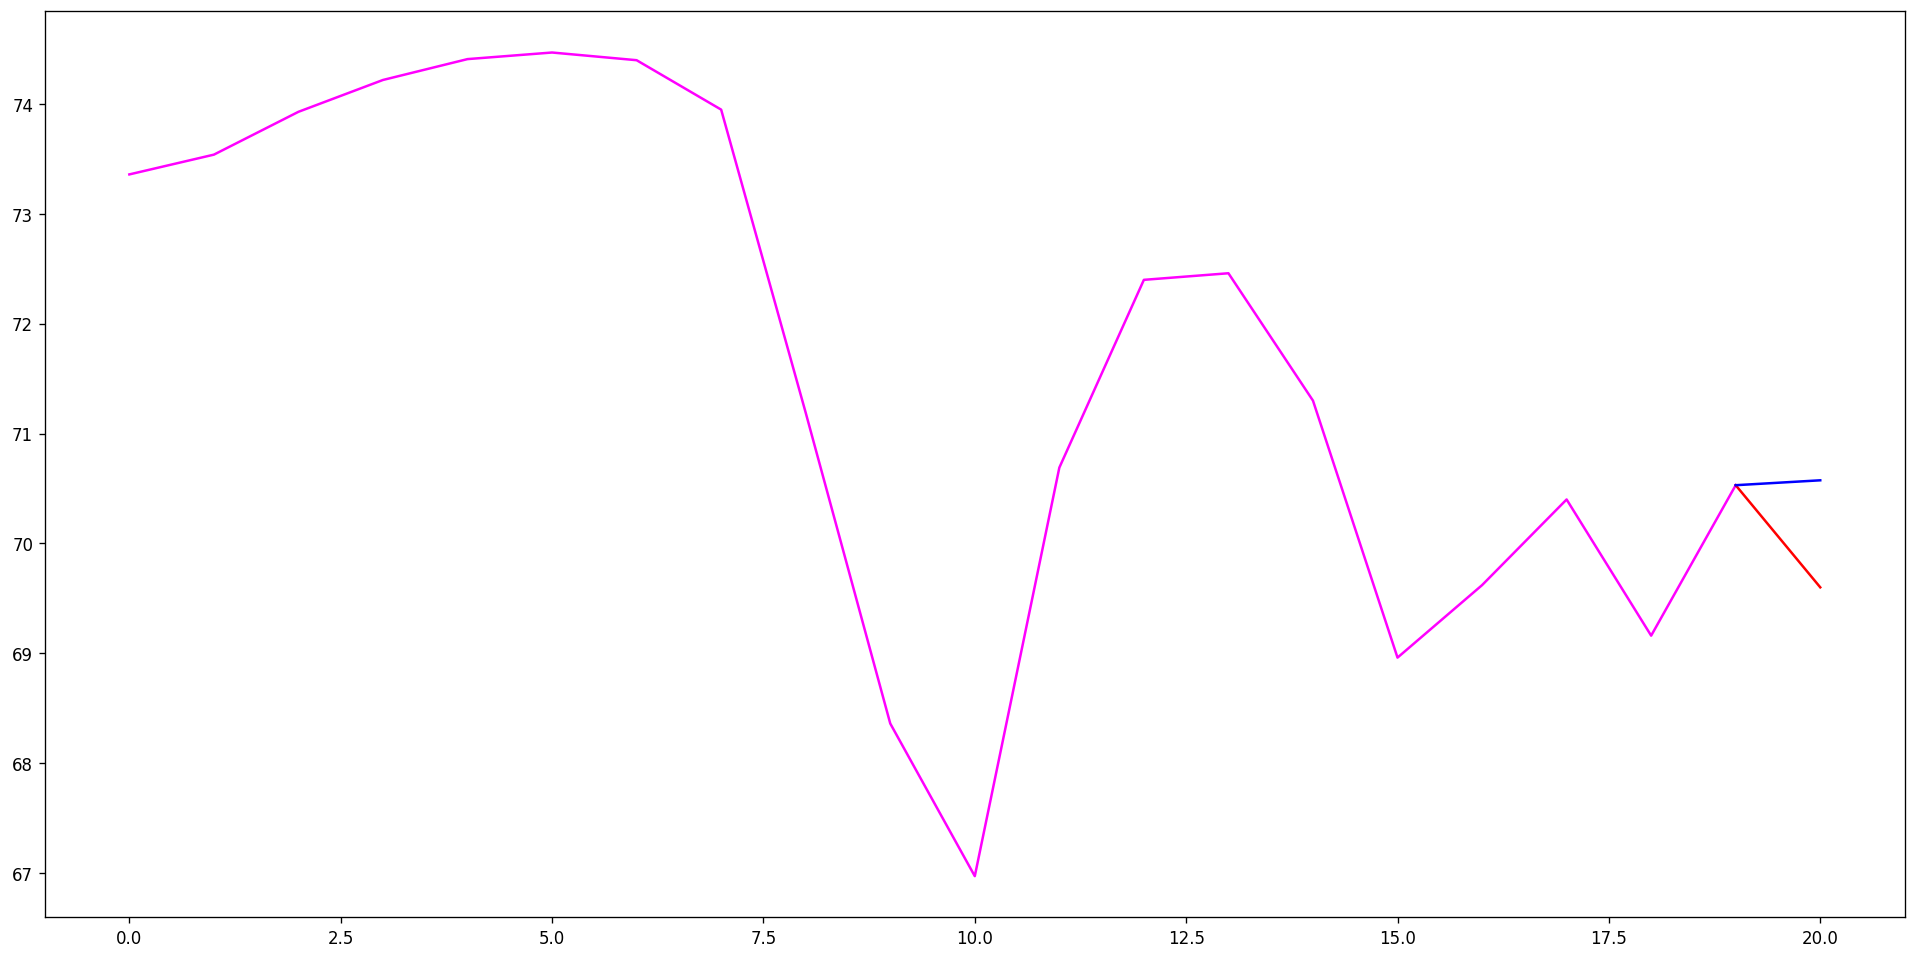

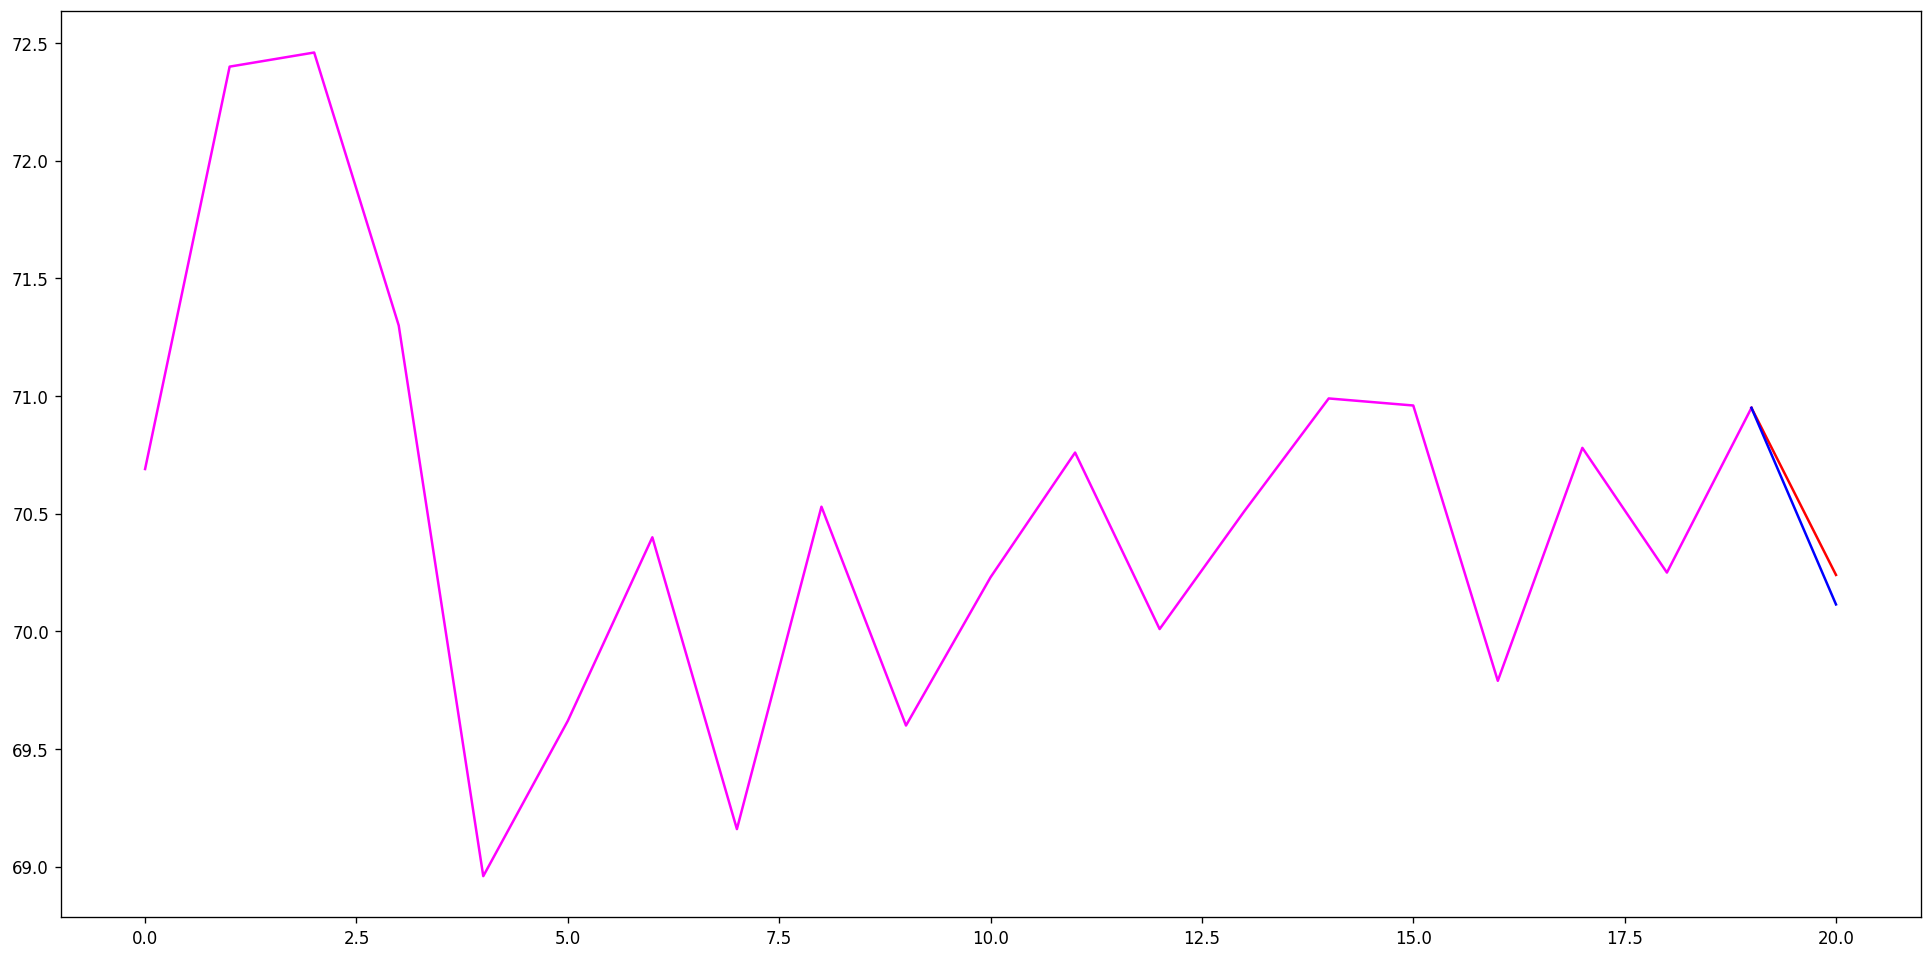

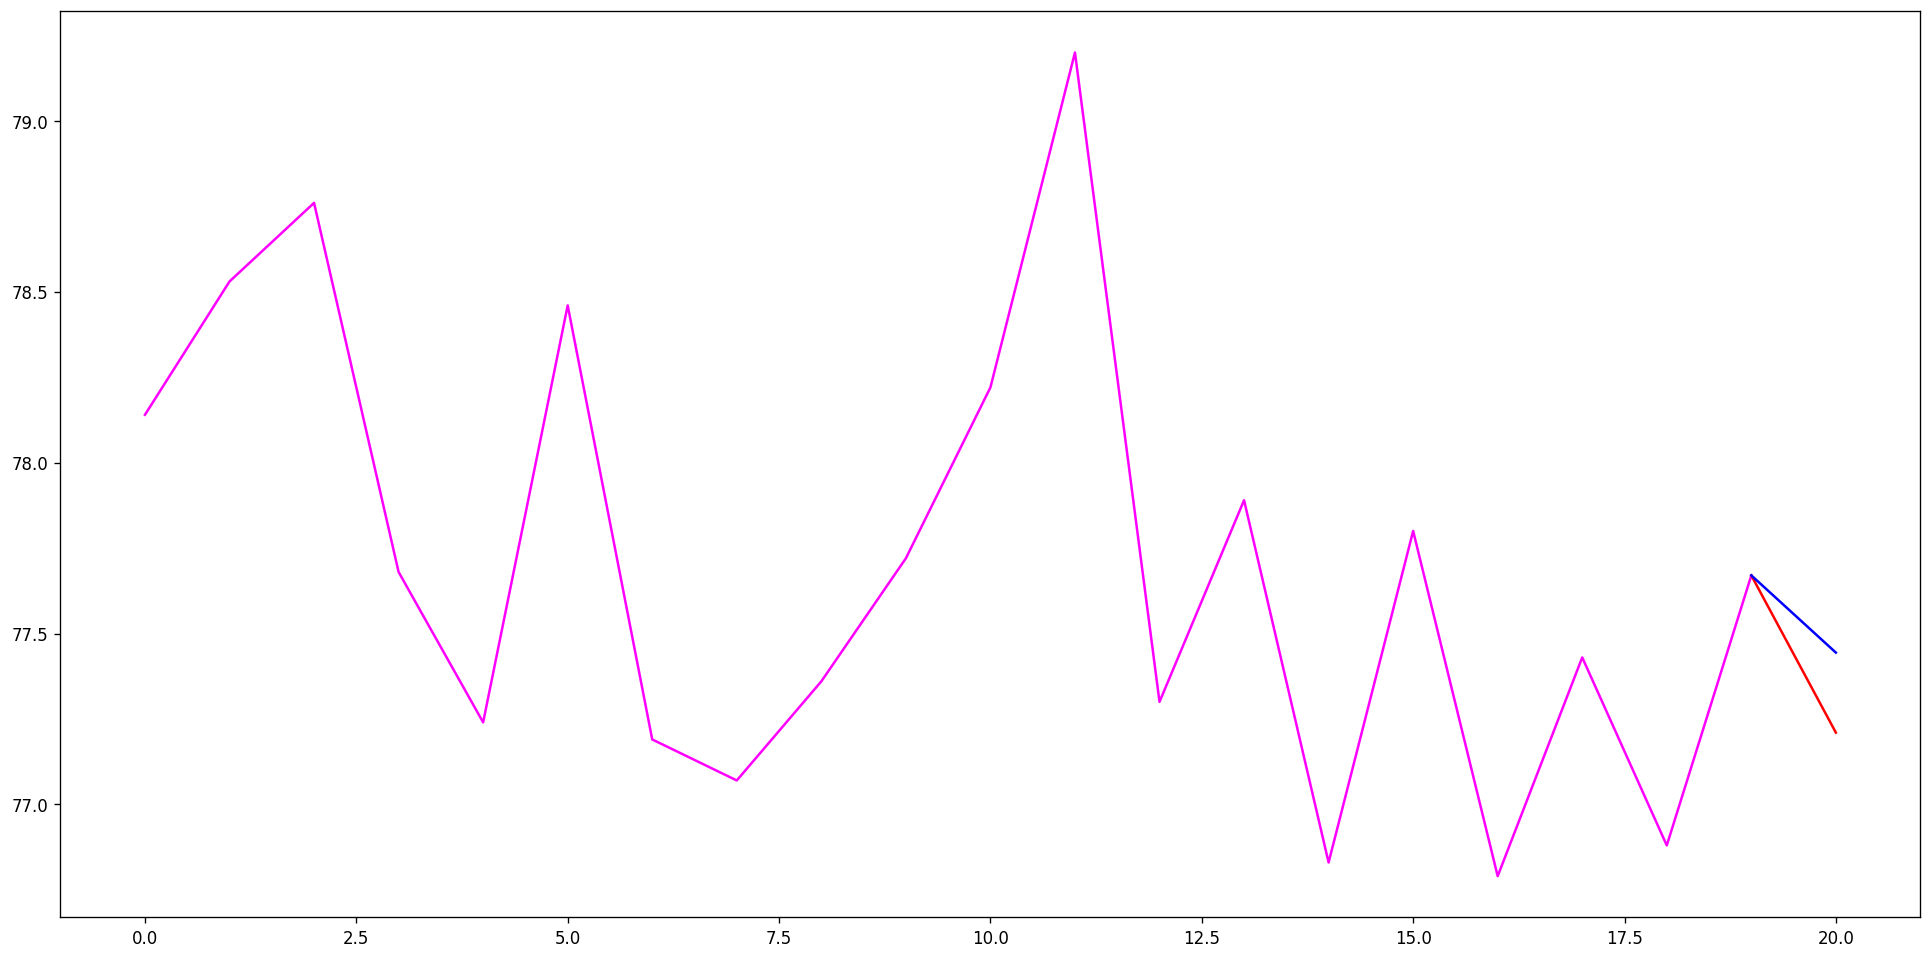

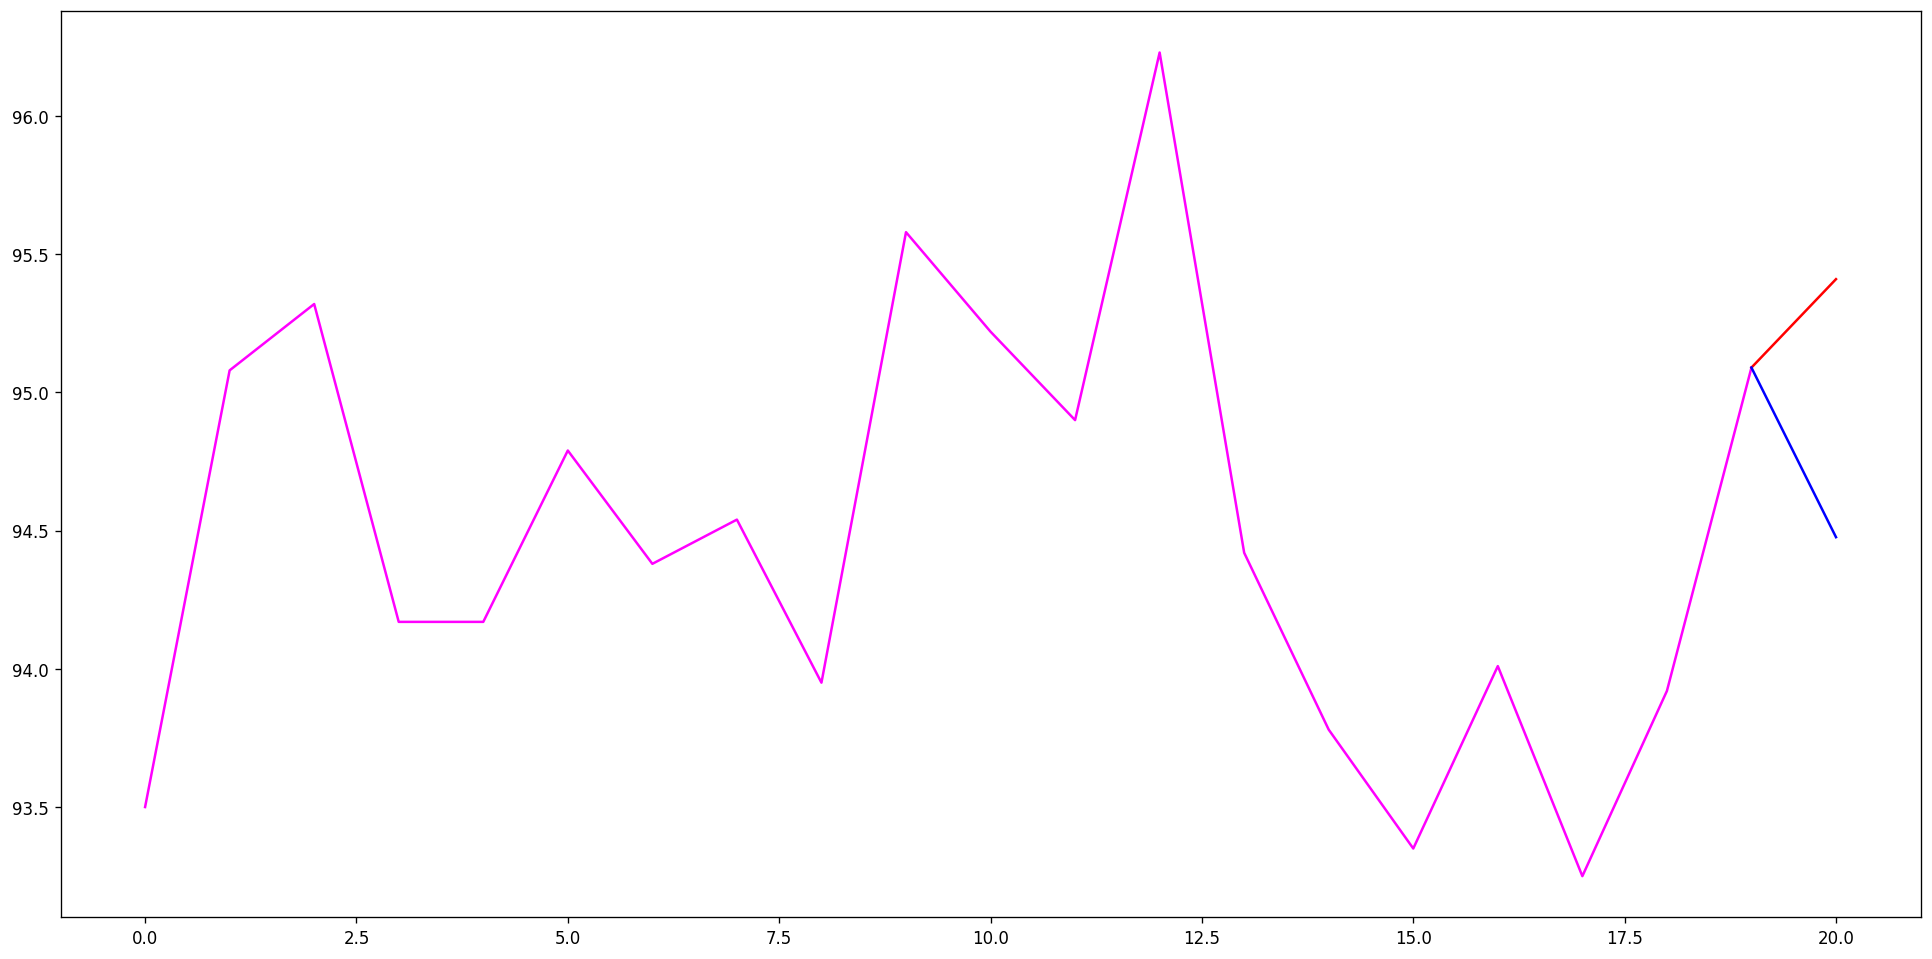

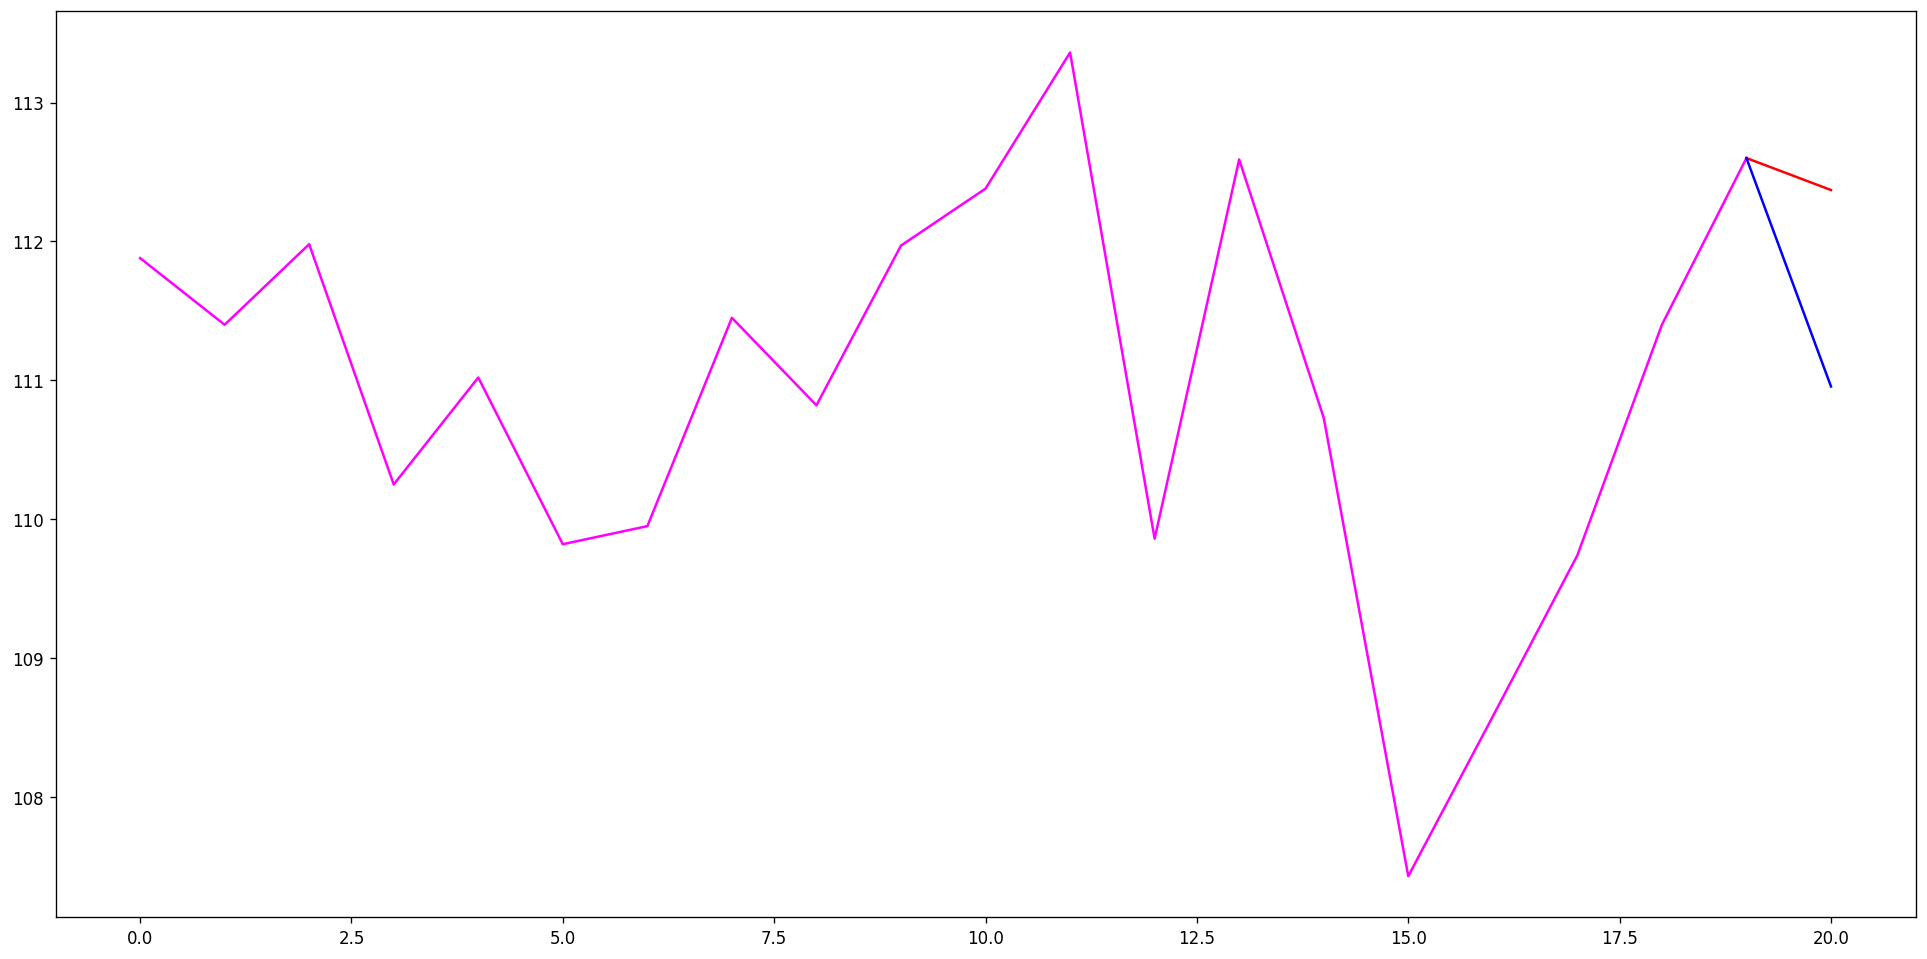

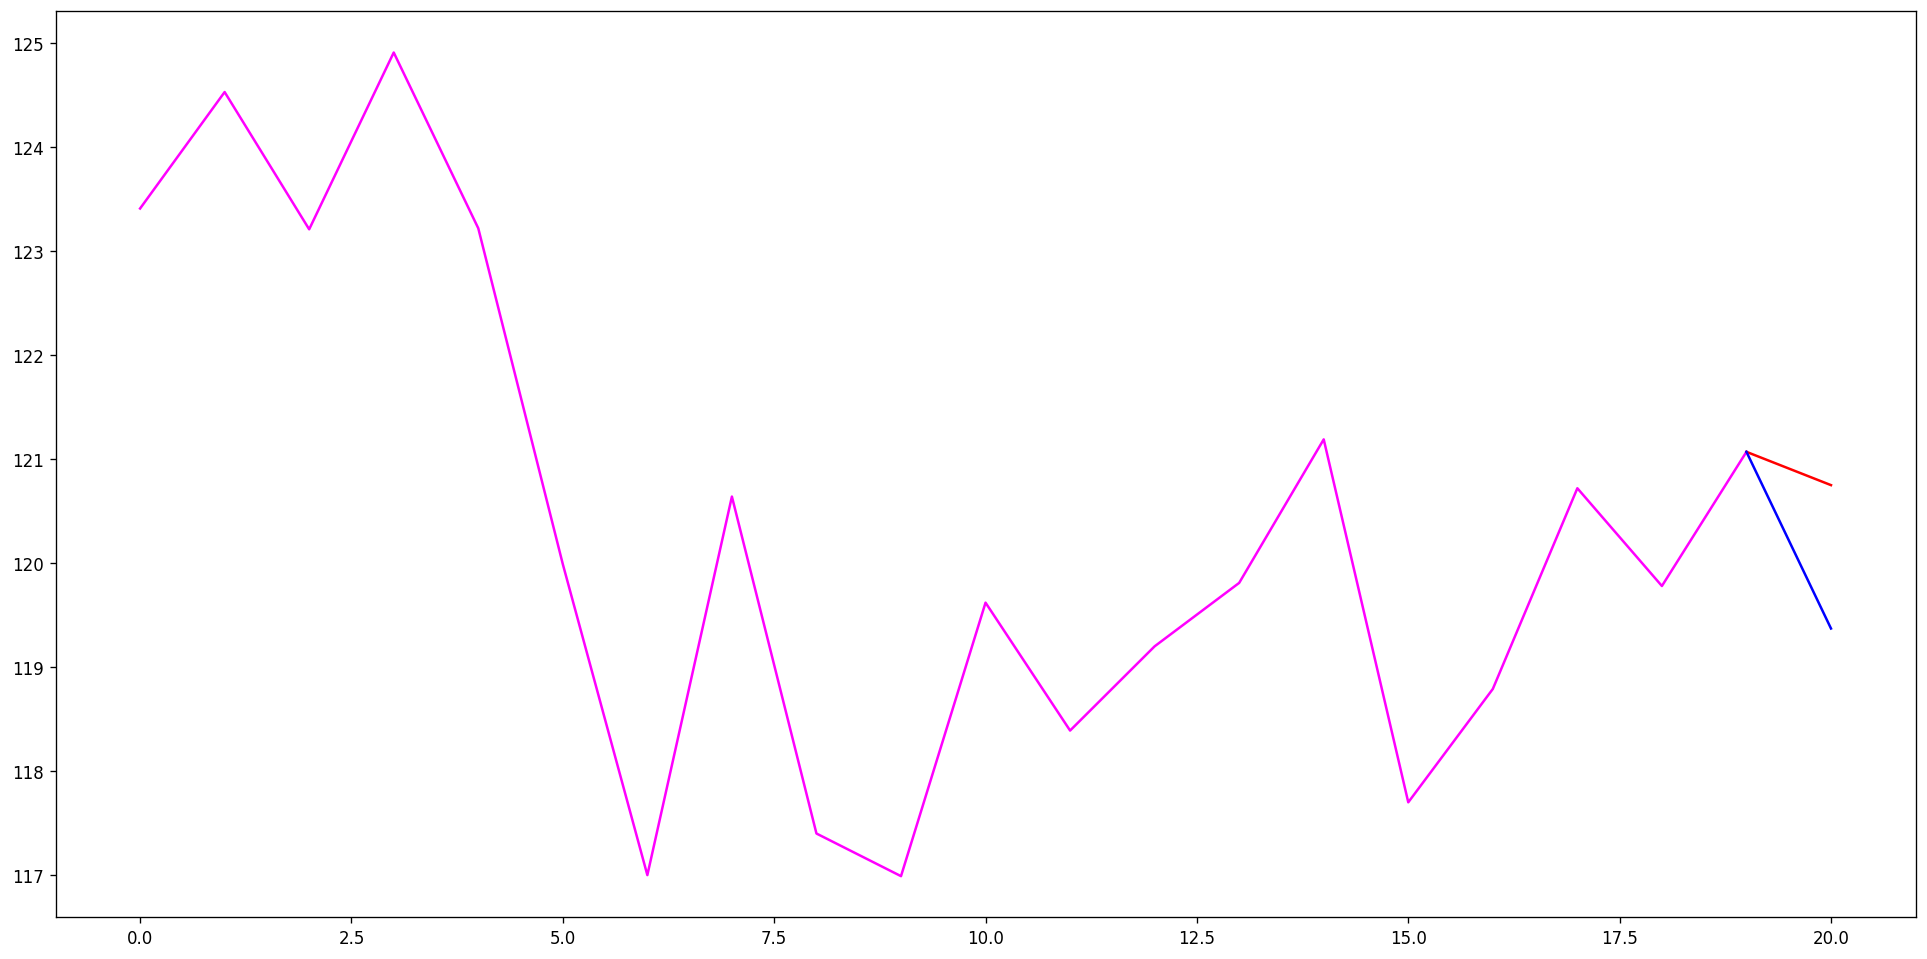

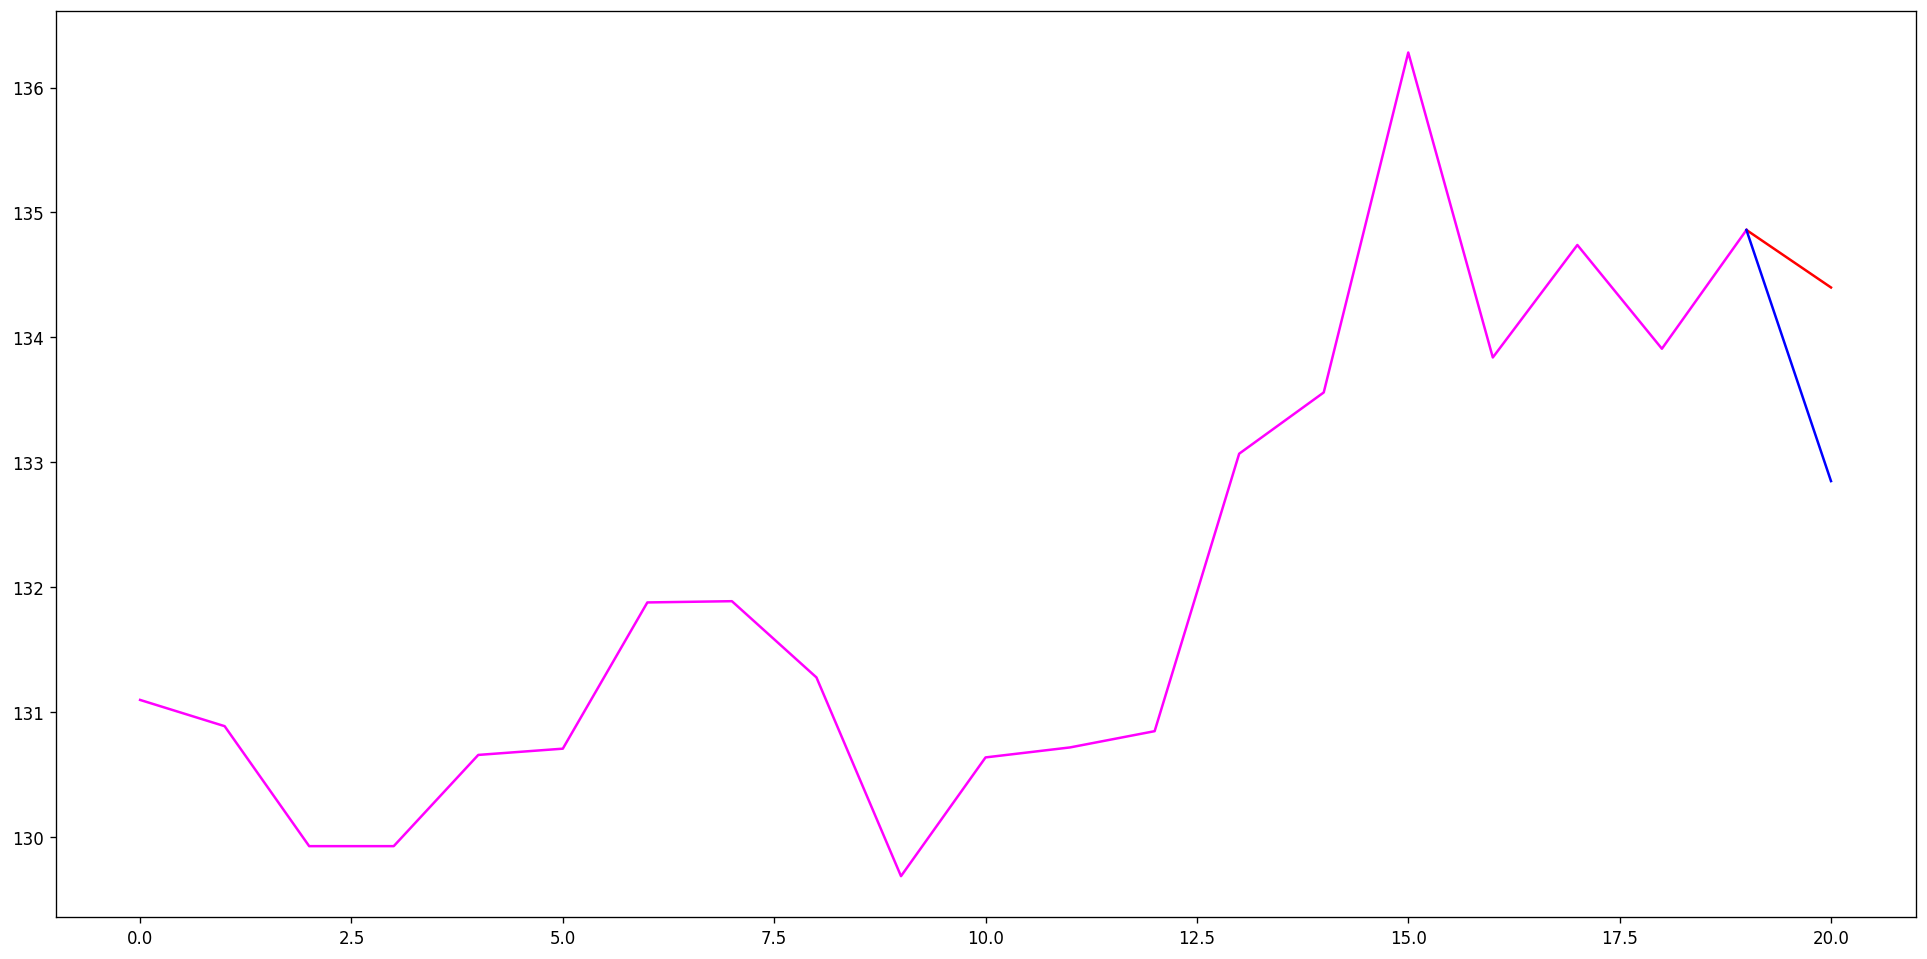

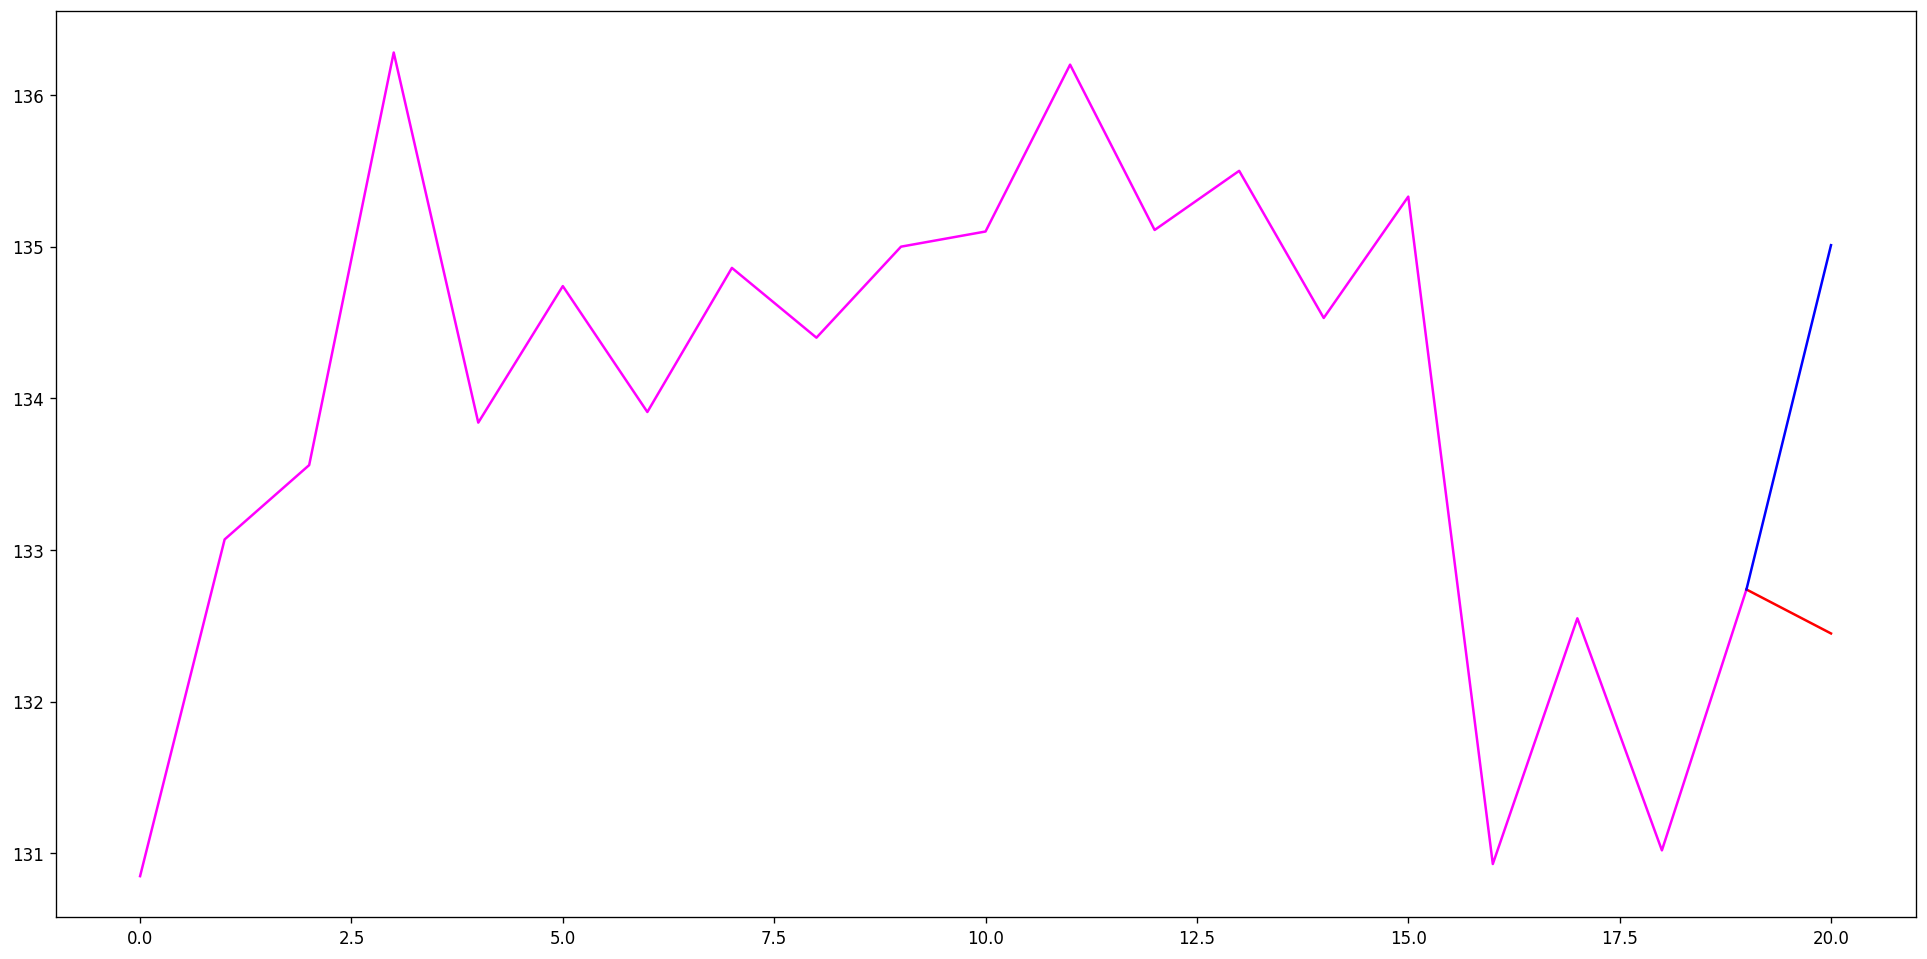

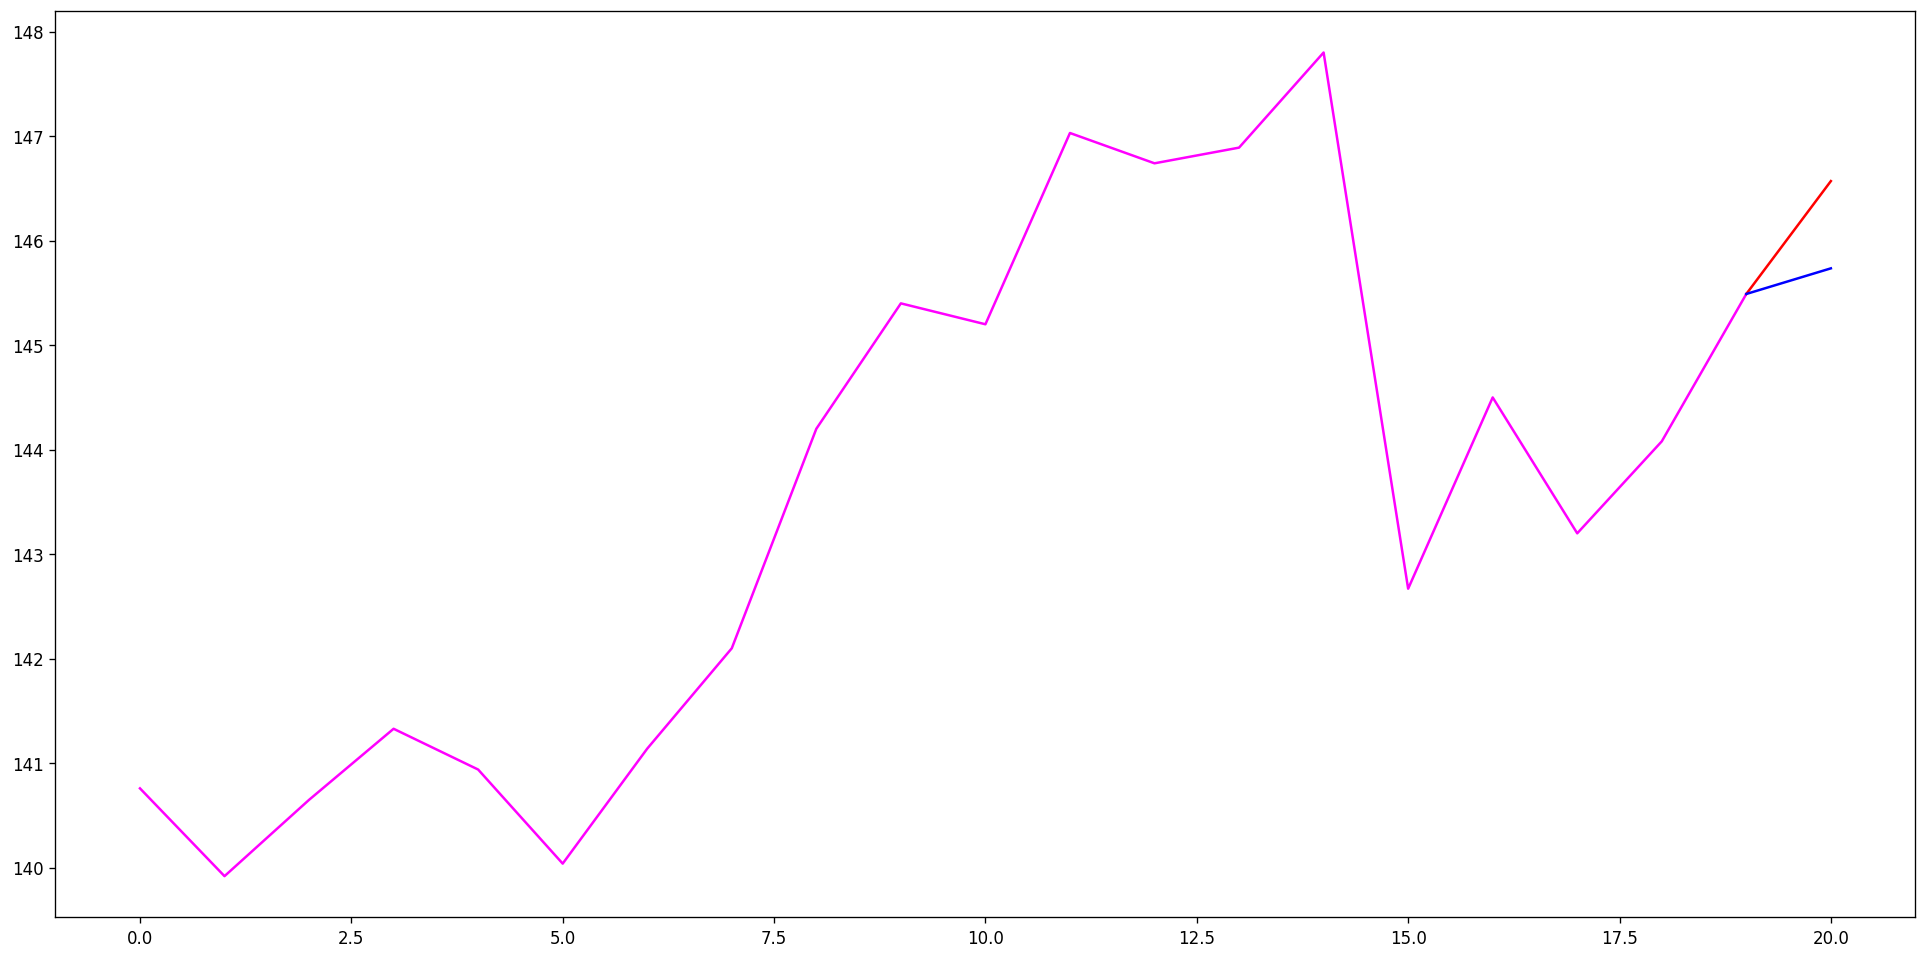

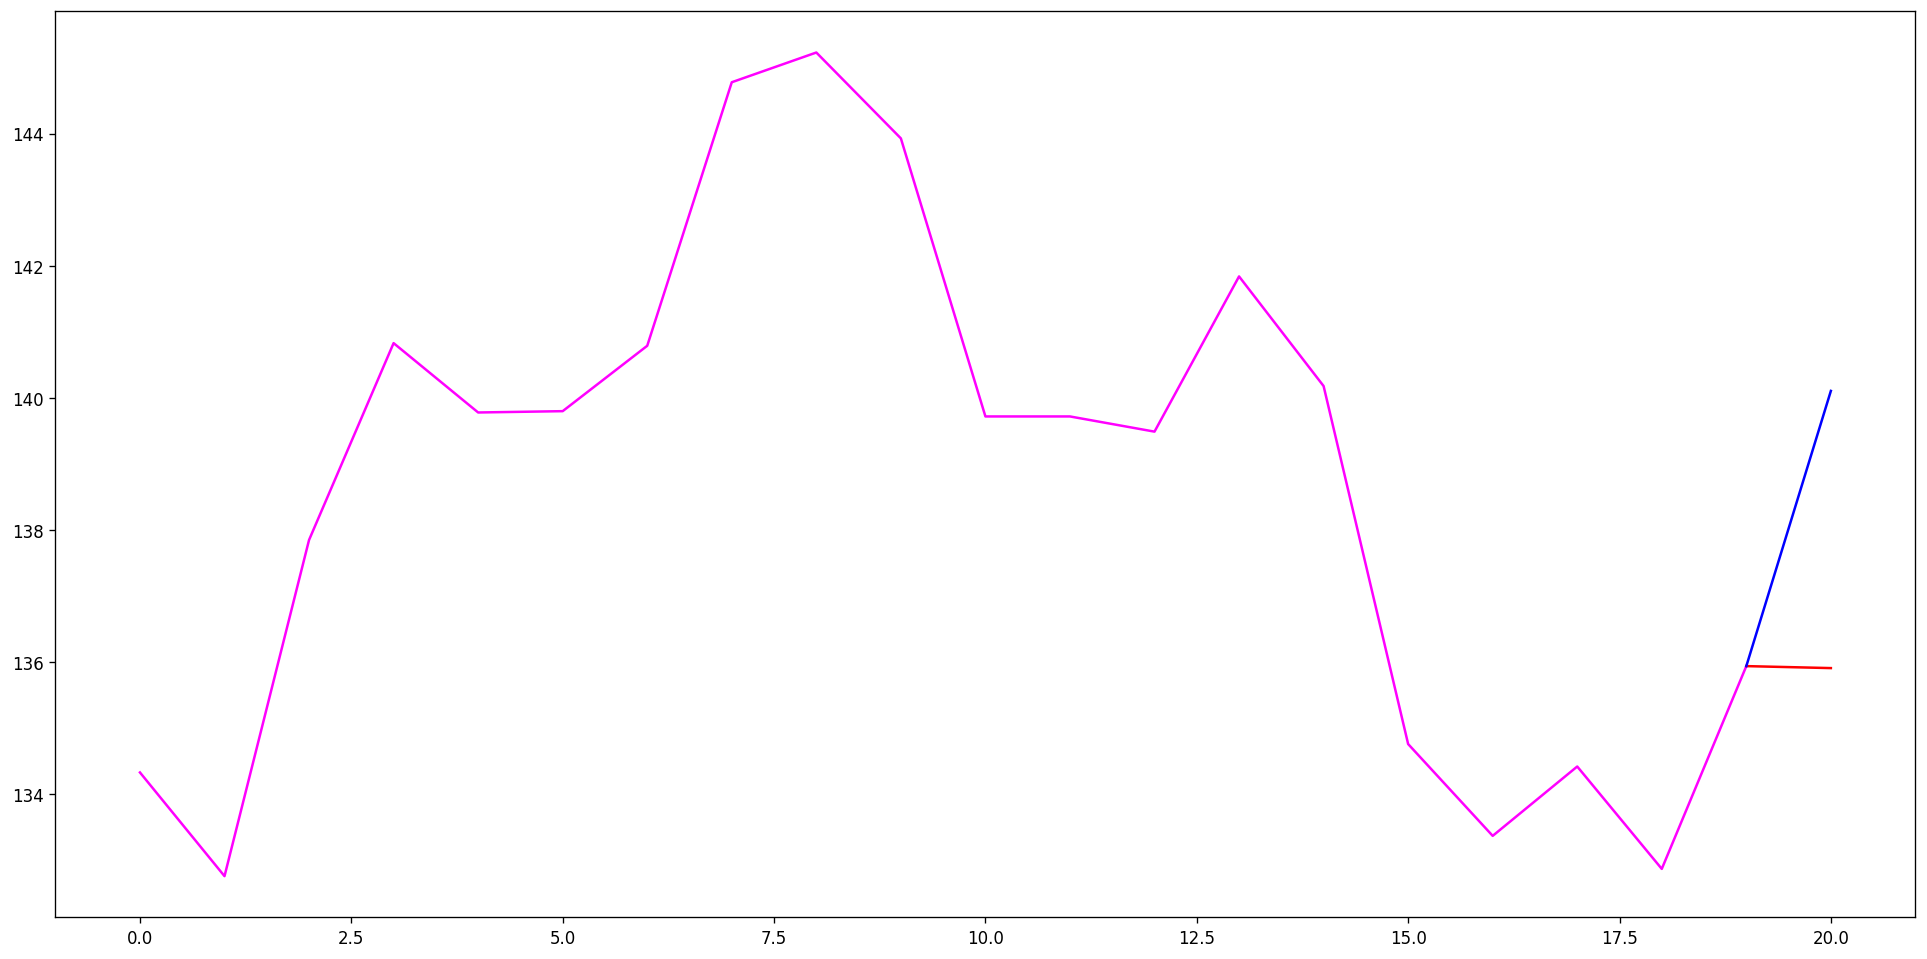

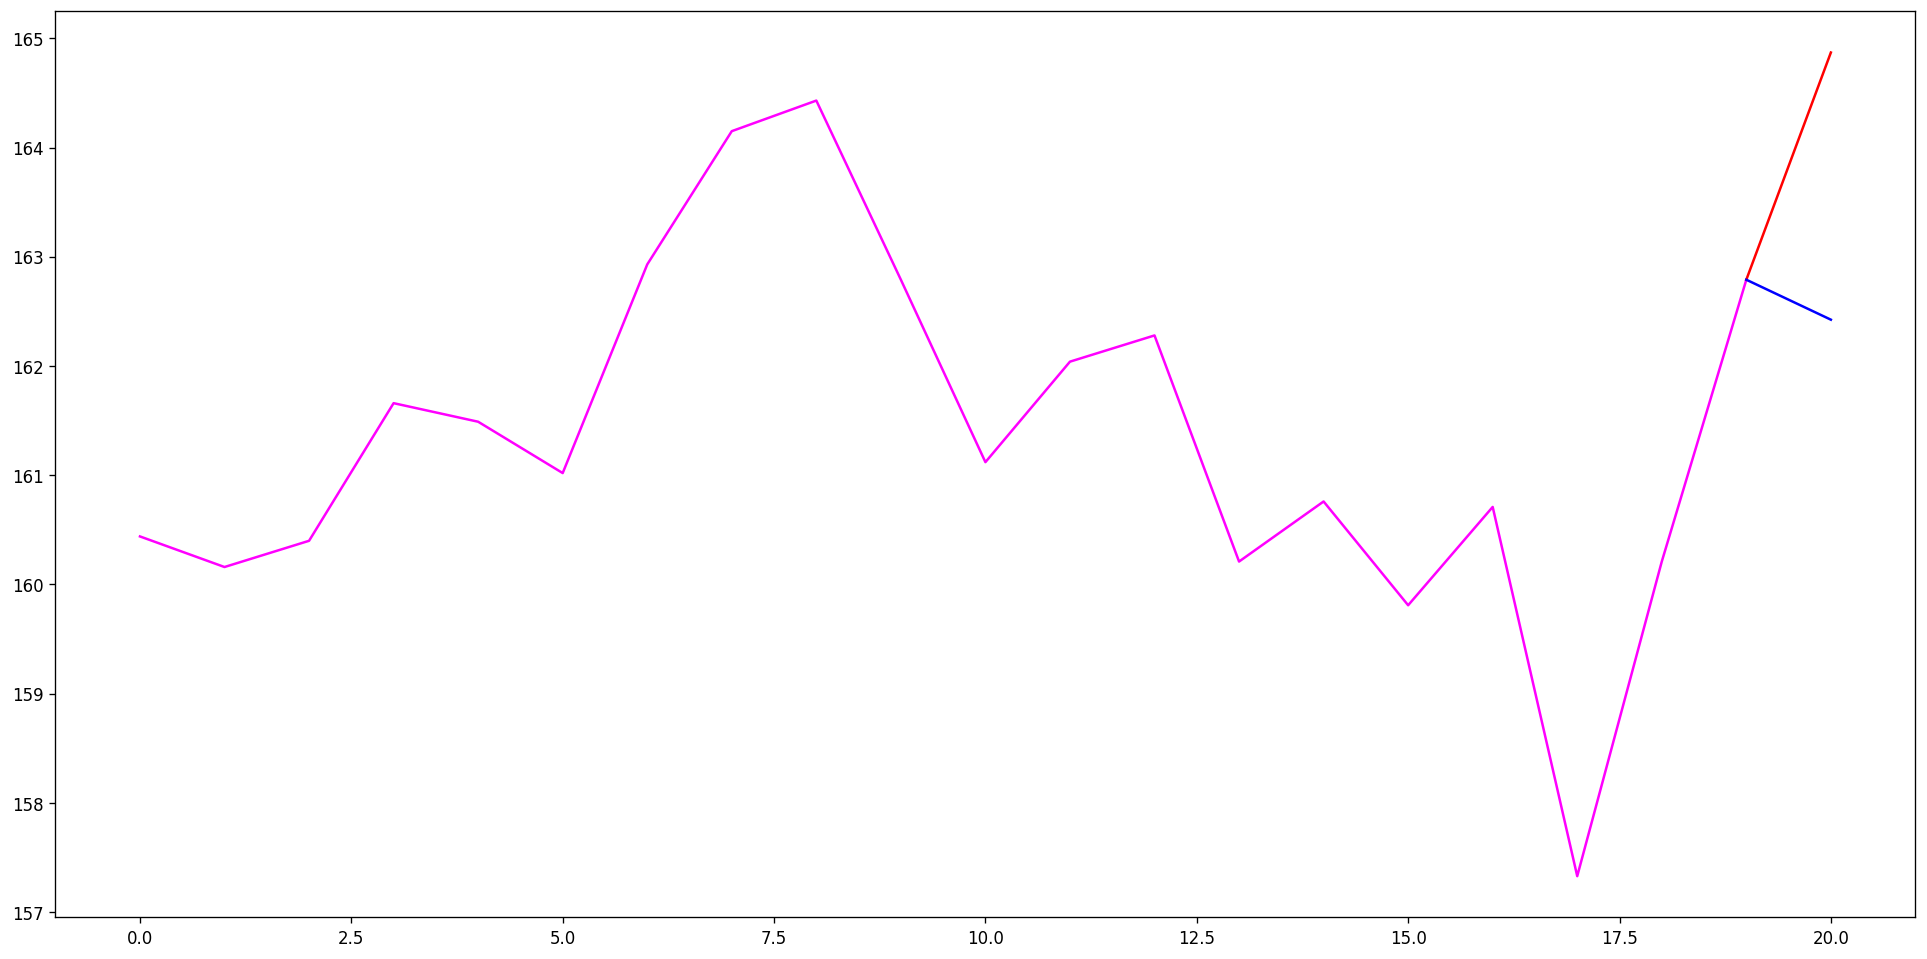

In [28]:
for i, (X_i, y_true_i, y_pred_i) in enumerate(zip(X_test, y_test, predicted_stock_price)):
    if (i > 100):
        break
    visualize_pred(X_i, y_true_i, y_pred_i)

## XGBoost model

### Build model

In [29]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBRegressor

xgbmodel = XGBRegressor(seed=seed,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        colsample_bylevel=colsample_bylevel,
                        gamma=gamma)

### Train the model

In [ ]:
if scale_method != 'None':
    xgbmodel.fit(X_train_scaled[:, :, feature_pred_idx].reshape(X_train_scaled.shape[:2]), y_train_scaled)
else:
    xgbmodel.fit(X_train[:, :, feature_pred_idx].reshape(X_train.shape[:2]), y_train)

[15:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Test model

In [ ]:
if scale_method != 'None':
    predicted_stock_price = xgbmodel.predict(X_test_scaled[:, :, feature_pred_idx].reshape(X_test_scaled.shape[:2]))
    predicted_stock_price = predicted_stock_price.reshape(-1, 1)
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
else:
    predicted_stock_price = xgbmodel.predict(X_test[:, :, feature_pred_idx].reshape(X_test.shape[:2]))
    predicted_stock_price = predicted_stock_price.reshape(-1, 1)
# predicted_stock_price = xgbmodel.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1])))
# predicted_stock_price = np.reshape(predicted_stock_price, (predicted_stock_price.shape[0], 1))
# if scale_method == 'MinMax':
#     predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [ ]:
print(y_test)
print(predicted_stock_price)

In [ ]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

In [ ]:
rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

In [ ]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('XGBoost Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
for i, (X_i, y_true_i, y_pred_i) in enumerate(zip(X_test, y_test, predicted_stock_price)):
    if (i > 100):
        break
    visualize_pred(X_i, y_true_i, y_pred_i)